# Advanced Machine Learning - programming assignment 2

**Please fill in:**
* Ernö Groeneweg (4279662)
* Otto Mättas (6324363)
* Vincent de Wit (6970877)

## Implementing the PC algorithm
In this assignment, you will complete an implementation of the PC algorithm. After that, you will use it to discover causal relations in a data set.

In [1]:
import numpy as np
import itertools
import graphviz # conda install python-graphviz

The graphviz can draw graphs to different file formats, or show them directly in the notebook. We will use numpy arrays to represent graphs. The following function converts such an array to a graph in graphviz format. 

In [2]:
def graph_to_graphviz(G, node_names):
    n = G.shape[0]
    d = graphviz.Digraph(engine='circo') #'neato')
    for node_name in node_names:
        d.node(node_name)
    for x in range(n):
        for y in range(n):
            if x == y:
                continue
            if G[x,y] and not G[y,x]:
                d.edge(node_names[x], node_names[y])
            elif x < y and G[x,y] and G[y,x]:
                d.edge(node_names[x], node_names[y], dir='none')
    return d

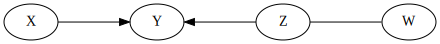

In [3]:
# Demonstration of graph_to_graphviz:
node_names = ['X', 'Y', 'Z', 'W']
G1 = np.zeros((4,4), dtype=bool)
G1[0,1] = G1[2,1] = True # two directed edges
G1[2,3] = G1[3,2] = True # an undirected edge
d = graph_to_graphviz(G1, node_names)
d # must be final line of code block to be displayed

Here is a function that performs the PC algorithm. Add the missing code for phase 2, and implement phases 3 and 4.

In [4]:
def PC_algorithm(n, independence_tester):
    # PHASE I: Initialization
    # The matrix G represents a graph as follows:
    # - For all x, G[x,x] == False
    # - G[x,y] == False and G[y,x] == False: no edge between x and y
    # - G[x,y] == True  and G[y,x] == True:  undirected edge x --- y
    # - G[x,y] == True  and G[y,x] == False: directed edge x --> y
    G = np.logical_not(np.eye(n, dtype=bool))

    # PHASE II: Skeleton search
    # Note: Adj(X) in the slides means: all nodes adjacent to X in the current graph G
    sepset = dict()
    for k in range(n-1):
        for x in range(n):
            for y in range(n):
                if not G[x,y]:
                    continue
                # Try all subsets S of Adj(x) \ {y} with |S|=k,
                # until an independence is found.
                # Hint: use itertools.combinations
                
                # Your code here
                # G[x,y] is true here , this means that y is adjacent to x
                # for all S subset of adjacent nodes to x not including y, with size of S: |S|=k
                l = [i for i in range(n) if (i != y and i != x)] # range n excluding y and x since adj to x
                Set = itertools.combinations(l,k) # all combinations of length k
                
                for S in Set:
                    indep = independence_tester.test_independence(x, y, S)
                    if indep:
                        print("independence found: {0} and {1} given {2}".format(x,y,S))
                        G[x,y] = G[y,x] = False
                        S_mask = np.zeros(n, dtype=bool)
                        np.put(S_mask, S, True)
                        sepset[frozenset([x,y])] = S_mask
                        break
        # Do we need to continue with smaller k? ....
        max_S_size = np.sum(G, axis=0) - 1
        if np.all(max_S_size < k + 1):
            break

    # PHASE III: Orient v-structures
    # Something to watch out for:
    # If the data are not faithful to any graph, the algorithm may end up trying
    # to orient a single edge in two different ways. You can choose either
    # orientation if this happens.

    # Your code here
    # for two not adjacent nodes connected to a third node
    # check if this third node is in the sepset of the two
    # not connected nodes. When the third node is not in
    # the sepset, the two first nodes collide in the third.

    for x in range(n-1):
        for y in range(x,n):
            # if x and y not adjacent
            if G[x,y] == G[y,x] == False and x != y:
                for z in range(n):
                    
                    # when z is adjacent to x and to y
                    if G[x,z] == False and G[z,x] == False:
                        continue
                    if G[y,z] == False and G[z,y] == False:
                        continue
                        
                    # unordered when atleast one edge is undirected
                    if not (G[x,z]==G[z,x]==True or G[y,z]==G[z,y]==True):
                        continue
                        
                    # if z not in sepset({x,y}):
                    if not sepset[frozenset([x,y])][z]:
                        # orient edges
                        G[z,x] = G[z,y] = False
                        
        # Not implemented "Something to watch out for" I do not understand when this exactly would happen...

    # PHASE IV: Orientation rules

    # Your code here
    # no extra v-structures, no cycles
    
    # undirected edges
    for x in range(n):
        for y in range(n):
            # if x and y adjacent and undirected
            if not(G[x,y] == G[y,x] == True and x != y):
                continue
                
            # x and y adjacent and undirected
            for z in range(n):
                # remove cases where z is either x or y
                if z == x or z == y:
                    continue
                if G[x,z] == False and G[z,x] == True:
                    # Rule 1
                    if G[y,z] == False and G[z,y] == False:
                        G[y,x] = False
                        break
                    # Rule 2
                    if G[y,z] == True and G[z,y] == False:
                        G[x,y] = False
                        break
                # Rule 3    
                for q in range(n):
                    if q == z or q == x or q == y:
                        continue
                    if G[x,z] == G[z,x] == True and G[x,q] == G[q,x] == True:
                        if G[z,y] == True and G[y,z] == False:
                            if G[q,y] == True and G[y,q] == False:
                                G[y,x] = False

    '''
    rule 1: When a node has an incoming edge and an undirected edge
                    then the undirected edge becomes a directed outgoing edge.
    rule 2: When two nodes are connected by an undirected edge and 
                have a directed chain connecting them via a third node
                    then the undirected edge becomes a directed edge with the same direction as the chain.
    rule 3: When two nodes are connected by an undirected edge and
                one node has two incoming edges that 'relate' to the 'other' node
                    then the undirected edge becomes a directed edge directed at the node with incoming edges.
    '''
    

    return G

## Testing the PC implementation

To verify that the algorithm is working correctly, we will feed it output from an /oracle/ instead of conditional independence test results from a data set. The oracle knows what the true graph is, and mimics the conditional independence test results that we would get for data that is Markov and faithful to that graph. In this situation, PC should be able to recover the Markov equivalence class of the true graph.

In [5]:
def is_d_connected_dfs(mB, pos, w, S, vis):
    # Made modifications to deal with CPDAGs as input
    #print("At ", pos)
    (v, dir) = pos
    if v == w:
        return True
    if (dir == 0 and not S[v]) or (dir == 1 and S[v]):
        # traverse backward (dir=0) along an arrow
        next_vs_mask = np.logical_and(mB[v,:], np.logical_not(vis[:,0]))
        if dir == 1:
            # we can't continue on an undirected path in case dir == 1 and S[v])
            next_vs_mask = np.logical_and(next_vs_mask, np.logical_not(mB[:,v]))
        tmp = np.logical_or(vis[:,0], next_vs_mask)
        vis[:,0] = tmp
        for next_v in np.nonzero(next_vs_mask)[0]:
            if is_d_connected_dfs(mB, (next_v, 0), w, S, vis):
                return True
    if not S[v]:
        # traverse forward (dir=1) along an arrow
        next_vs_mask = np.logical_and(mB[:,v], np.logical_not(vis[:,1]))
        next_vs_mask = np.logical_and(next_vs_mask, np.logical_not(mB[v,:]))
        vis[:,1] = np.logical_or(vis[:,1], next_vs_mask)
        for next_v in np.nonzero(next_vs_mask)[0]:
            if is_d_connected_dfs(mB, (next_v, 1), w, S, vis):
                return True
    return False

def is_d_separated(G, v, w, S):
    if S[v] or S[w]:
        return True
    mB = G.T
    d = mB.shape[0]
    # vis[v,0]: reachable by path ending in tail
    # vis[v,1]: reachable by path ending in head
    vis = np.zeros((d,2), dtype=bool)
    pos = (v,0)
    vis[pos] = True
    is_d_connected_dfs(mB, pos, w, S, vis)
    if vis[w,0] or vis[w,1]:
        return False
    return True

class IndependenceOracle:
    def __init__(self, true_G):
        self.G = true_G
        self.n = true_G.shape[0]
    def test_independence(self, x, y, S):
        S_mask = np.zeros(self.n, dtype=bool)
        #S_mask[S] = True
        np.put(S_mask, S, True)
        return is_d_separated(self.G, x, y, S_mask)

We will compare the output of PC to the oracle's true graph for the graph G1 we saw before, and for several other graphs. (You can add more tests to help chase down any bugs.)

independence found: 0 and 2 given ()
independence found: 0 and 3 given ()
independence found: 1 and 3 given (2,)
CORRECT


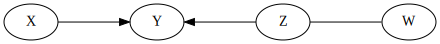

In [6]:
oracle = IndependenceOracle(G1)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G1) else "INCORRECT")
graph_to_graphviz(G, node_names)

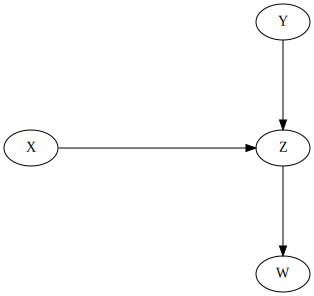

In [7]:
G2 = np.zeros((4,4), dtype=bool)
G2[0,2] = G2[1,2] = G2[2,3] = True
graph_to_graphviz(G2, node_names)

independence found: 0 and 1 given ()
independence found: 0 and 3 given (2,)
independence found: 1 and 3 given (2,)
CORRECT


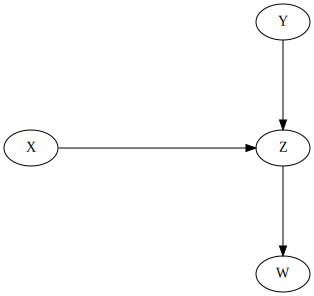

In [8]:
oracle = IndependenceOracle(G2)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G2) else "INCORRECT")
graph_to_graphviz(G, node_names)

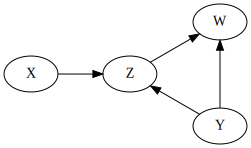

In [9]:
G3 = np.zeros((4,4), dtype=bool)
G3[0,2] = G3[1,2] = G3[1,3] = G3[2,3] = True
graph_to_graphviz(G3, node_names)

independence found: 0 and 1 given ()
independence found: 0 and 3 given (1, 2)
CORRECT


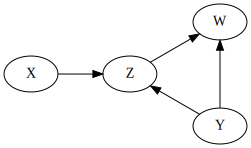

In [10]:
oracle = IndependenceOracle(G3)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G3) else "INCORRECT")
graph_to_graphviz(G, node_names)

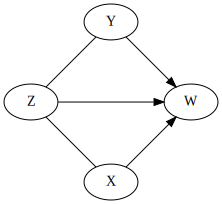

In [11]:
G4 = np.logical_not(np.eye(4, dtype=bool))
G4[0,1] = G4[1,0] = False
G4[3,0] = G4[3,1] = G4[3,2] = False
graph_to_graphviz(G4, node_names)

independence found: 0 and 1 given (2,)
CORRECT


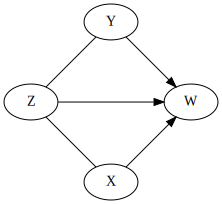

In [12]:
oracle = IndependenceOracle(G4)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G4) else "INCORRECT")
graph_to_graphviz(G, node_names)

## Running PC on data
In this second part of the assignment, you will apply the PC algorithm to the biological dataset of Sachs et al. (2005). In this dataset, the columns represent 11 different proteins, which were measured in thousands of human immune system cells. Each row is a single cell. The cells were prepared in different ways, by adding different chemicals some time before the measurements were made. A twelfth column, labeled 'experiment', indicates in which way that cell was prepared. We can think of experiment=1 as denoting the observational data, and other values of experiment (2 through 14) as various interventional datasets.

In [13]:
import pandas as pd

all_data = pd.read_csv("sachs2005_combined.csv", sep='\t')
# Transform all columns except 'experiment' by taking a logarithm
all_data.loc[:, all_data.columns != 'experiment'] = np.log(all_data.loc[:, all_data.columns != 'experiment'])

We will apply the PC algorithm to just the observational data.

Make a new dataframe containing only the data where experiment equals 1. Remove the `experiment` column from this dataframe. Check the shape of your dataframe: it should be `(853, 11)`.

In [14]:
# Your code here
data_exp1 = all_data[all_data.experiment==1]
data_exp1 = data_exp1.drop(columns='experiment')
data_exp1

praf      pmek      plcg      PIP2      PIP3      perk  pakts473  \
0    3.273364  2.580217  2.177022  2.906901  4.074142  1.888584  2.833213   
1    3.580737  2.803360  2.509599  2.821379  2.095561  2.923162  3.481240   
2    4.084294  3.786460  2.681022  2.322388  2.564949  2.701361  3.481240   
3    4.290459  4.416428  3.139833  2.602690  0.254642  1.763017  2.468100   
4    3.517498  2.985682  1.646734  2.275214  3.210844  3.049273  3.830813   
..        ...       ...       ...       ...       ...       ...       ...   
848  3.742420  3.317816  3.068053  4.218036  2.509599  2.113843  2.760010   
849  4.128746  3.077312  2.257588  1.870263  3.535145  2.727853  3.139833   
850  4.634729  3.471966  2.322388  2.580217  3.929863  1.663926  1.726332   
851  4.352855  3.165475  3.210844  4.100989  3.795489  3.068053  3.218876   
852  3.841601  2.708050  2.141242  4.787492  3.104587  1.808289  2.995732   

          PKA       PKC       P38      pjnk  
0    6.025866  2.833213  3.804438  3.688879  
1    5.863631  1.214913  2.803360  4.119037  
2    5.998937  2.433613  3.462606  2.970414  
3    6.269096  2.617396  3.353407  3.139833  
4    5.720312  1.539015  3.246491  4.398146  
..        ...       ...       ...       ...  
848  6.331502  3.086487  3.391147  2.113843  
849  5.765191  2.476538  3.569533  3.929863  
850  5.476464  2.674149  3.131137  1.654411  
851  5.666427  3.471966  4.424847  3.299534  
852  6.169611  3.039749  3.605498  2.266958  

[853 rows x 11 columns]

To run the PC algorithm on data, we need to perform (conditional) independence tests. The package [tigramite](https://github.com/jakobrunge/tigramite) implements several such tests. The simplest of these tests is ParCorr(). It assumes the data come from a linear model, which they actually don't. We will use it anyway, because the alternatives (such as CMIknn() (Runge, 2018)) are more effort to install and orders of magnitude slower.

As a statistical test, a conditional independence test works by computing a p-value. If a conditional independence exists, this p-value will be approximately uniformly distributed on the interval between 0 and 1. If the variables being tested are conditionally dependent, the p-value will be close to 0. PC wants to know a binary answer, so we will pick some threshold alpha and declare an independence if the p-value is larger than alpha.

In statistical testing, alpha is often taken to be 0.05 or smaller. For PC, it may be more appropriate to pick a (much) larger alpha instead. This is because as soon as PC finds a (conditional) independence between two variables, it will delete the edge between them and do no more tests between those two variables. If this happens while it shouldn't have, PC can't put the edge back. But in the reverse situation, if PC leaves an edge in place while it should have deleted it, there is still a possibility that the edge will be deleted later, when another test between those two variables reports a more convincing independence.

In [15]:
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp
# Importing these may give some warnings (e.g. 'Could not import r-package RCIT'),
# but most of these warnings can be ignored because we are not using the mentioned packages.

class IndependenceTester:
    def __init__(self, data, cond_ind_test, alpha):
        # data: a pandas dataframe
        # cond_ind_test: an independence test from tigramite, e.g. ParCorr()
        # alpha: the significance level to which the p-values are compared
        
        # tigramite uses its own kind of dataframe, so convert the data to that format
        df_tigramite = pp.DataFrame(data.to_numpy(), var_names=data.columns)
        self.cond_ind_test = cond_ind_test
        self.cond_ind_test.set_dataframe(df_tigramite)
        self.n = data.shape[1]
        self.alpha = alpha
    def test_independence(self, x, y, S):
        val, pval = self.cond_ind_test.run_test(X=[(x, 0)],
                                                Y=[(y, 0)],
                                                Z=[(z, 0) for z in S])
        print("test: {0} and {1} given {2} -> pval={3}".format(x,y,S,pval))
        return pval > self.alpha

Could not import rpy package
Could not import r-package RCIT


Using an IndependenceTester object (which works similarly to the IndependenceOracle we used earlier), run the PC algorithm on the observational data. Display the graph that comes out. You may experiment with different values of alpha; the graph you get should have just one or two connected components.

test: 0 and 1 given () -> pval=2.763329247780076e-116
test: 0 and 2 given () -> pval=0.7345031780389384
independence found: 0 and 2 given ()
test: 0 and 3 given () -> pval=0.7147143030936396
independence found: 0 and 3 given ()
test: 0 and 4 given () -> pval=0.4639779567396791
independence found: 0 and 4 given ()
test: 0 and 5 given () -> pval=0.49429391475369566
independence found: 0 and 5 given ()
test: 0 and 6 given () -> pval=0.24104570427628094
independence found: 0 and 6 given ()
test: 0 and 7 given () -> pval=0.8820017123329296
independence found: 0 and 7 given ()
test: 0 and 8 given () -> pval=0.3264140832119329
independence found: 0 and 8 given ()
test: 0 and 9 given () -> pval=0.11406363143778013
test: 0 and 10 given () -> pval=0.773348151789071
independence found: 0 and 10 given ()
test: 1 and 0 given () -> pval=2.763329247780076e-116
test: 1 and 2 given () -> pval=0.9899798095695264
independence found: 1 and 2 given ()
test: 1 and 3 given () -> pval=0.6357149945587127
indep

test: 8 and 10 given (9,) -> pval=8.310666644687424e-09
test: 9 and 8 given (0,) -> pval=3.9840486180425482e-78
test: 9 and 8 given (1,) -> pval=4.2638386924058854e-78
test: 9 and 8 given (2,) -> pval=2.5536743050191333e-78
test: 9 and 8 given (3,) -> pval=1.7201906588720365e-78
test: 9 and 8 given (4,) -> pval=2.477170564595105e-78
test: 9 and 8 given (5,) -> pval=1.455164310105671e-78
test: 9 and 8 given (6,) -> pval=2.363985891365964e-78
test: 9 and 8 given (7,) -> pval=4.4985527049632115e-78
test: 9 and 8 given (10,) -> pval=7.831749425050458e-78
test: 9 and 10 given (0,) -> pval=0.029877034992886017
test: 9 and 10 given (1,) -> pval=0.02483127781025555
test: 9 and 10 given (2,) -> pval=0.02967153693595061
test: 9 and 10 given (3,) -> pval=0.028586070334166516
test: 9 and 10 given (4,) -> pval=0.02864859473163029
test: 9 and 10 given (5,) -> pval=0.028574025085048506
test: 9 and 10 given (6,) -> pval=0.028954730690347645
test: 9 and 10 given (7,) -> pval=0.029986900774719945
test: 

test: 3 and 4 given (6, 10) -> pval=5.458081275341016e-26
test: 3 and 4 given (7, 8) -> pval=6.232892560233888e-26
test: 3 and 4 given (7, 9) -> pval=6.96689201652728e-26
test: 3 and 4 given (7, 10) -> pval=7.229440819591397e-26
test: 3 and 4 given (8, 9) -> pval=5.397635952637085e-26
test: 3 and 4 given (8, 10) -> pval=6.010702105973447e-26
test: 3 and 4 given (9, 10) -> pval=6.978268422523199e-26
test: 4 and 1 given (0, 2) -> pval=0.11399695640485098
test: 4 and 1 given (0, 3) -> pval=0.1988699027065482
test: 4 and 1 given (0, 5) -> pval=0.1135766987706972
test: 4 and 1 given (0, 6) -> pval=0.1180085885155085
test: 4 and 1 given (0, 7) -> pval=0.12147740636558009
test: 4 and 1 given (0, 8) -> pval=0.11940067114509807
test: 4 and 1 given (0, 9) -> pval=0.12154127216230912
test: 4 and 1 given (0, 10) -> pval=0.10795864490072363
test: 4 and 1 given (2, 3) -> pval=0.11597445033696696
test: 4 and 1 given (2, 5) -> pval=0.09765587490423384
test: 4 and 1 given (2, 6) -> pval=0.1041305824258

test: 8 and 9 given (1, 4) -> pval=5.335309104110153e-78
test: 8 and 9 given (1, 5) -> pval=3.104039607721982e-78
test: 8 and 9 given (1, 6) -> pval=5.000759417250353e-78
test: 8 and 9 given (1, 7) -> pval=9.48636825315004e-78
test: 8 and 9 given (1, 10) -> pval=1.9939758037516375e-77
test: 8 and 9 given (2, 3) -> pval=2.2017367864726e-78
test: 8 and 9 given (2, 4) -> pval=3.1650483961369846e-78
test: 8 and 9 given (2, 5) -> pval=1.842463874242193e-78
test: 8 and 9 given (2, 6) -> pval=3.012471312439051e-78
test: 8 and 9 given (2, 7) -> pval=5.689185176400313e-78
test: 8 and 9 given (2, 10) -> pval=9.740729580814437e-78
test: 8 and 9 given (3, 4) -> pval=1.9076395933883647e-78
test: 8 and 9 given (3, 5) -> pval=1.2049189955088993e-78
test: 8 and 9 given (3, 6) -> pval=2.0174818849934134e-78
test: 8 and 9 given (3, 7) -> pval=3.823999322541158e-78
test: 8 and 9 given (3, 10) -> pval=6.8407041430325e-78
test: 8 and 9 given (4, 5) -> pval=1.7922222054201758e-78
test: 8 and 9 given (4, 6) 

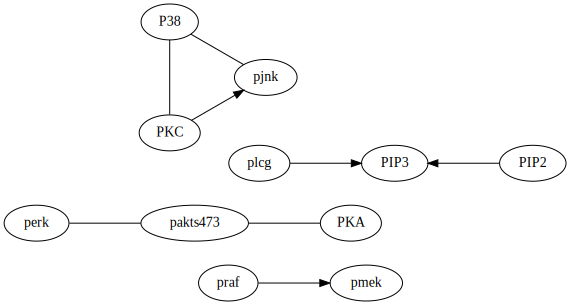

In [16]:
# Your code here
tester = IndependenceTester(data_exp1, ParCorr(), alpha=0.2)

G = PC_algorithm(11, tester)
graph_to_graphviz(G, list(data_exp1.columns))


Now let's look at what else is in the dataset: the interventional data corresponding to different experiments.

The interventions in these experiment are not perfect interventions: they change the structural equation of a variable, but not by setting it to a constant. The new structural equation in the intervened model may still include all variables that were there in the original model. So in the graph of the intervened model, all arrows will still be there.

Further, some of the interventions change not one, but multiple structural equations.

For some of the interventions in the data, here is what they do according to many (but not all) experts:
* experiment 5 adds the substance psitectorigenin, which modifies the amount of PIP2;
* experiment 6 adds the substance U0126, which increases the *activity* of pmek. This means that the amount of pmek is not changed by the intervention, but for all *children* of pmek in the causal model, the structural equation changes to reflect that pmek now has a stronger effect on them. pmek is believed to have only one child in the true causal model, namely perk.

(Source: Mooij et al., 2019, specifically Tables 2 & 3 and Figure 35(a))

Create two new dataframes, one containing all data from experiments 1 and 5, and one with the data from experiments 1 and 6. These dataframes should still have an 'experiment' column, so that you can tell for each row whether it came from the observational or the interventional dataset.

In [17]:
# Your code here
data_exp1 = all_data[all_data.experiment==1]
data_exp5 = all_data[all_data.experiment==5]
data_exp6 = all_data[all_data.experiment==6]

data_exp1_5 = pd.concat([data_exp1, data_exp5], sort=False)
data_exp1_6 = pd.concat([data_exp1, data_exp6], sort=False)

In [18]:
data_exp1_5

praf      pmek      plcg      PIP2      PIP3      perk  pakts473  \
0     3.273364  2.580217  2.177022  2.906901  4.074142  1.888584  2.833213   
1     3.580737  2.803360  2.509599  2.821379  2.095561  2.923162  3.481240   
2     4.084294  3.786460  2.681022  2.322388  2.564949  2.701361  3.481240   
3     4.290459  4.416428  3.139833  2.602690  0.254642  1.763017  2.468100   
4     3.517498  2.985682  1.646734  2.275214  3.210844  3.049273  3.830813   
...        ...       ...       ...       ...       ...       ...       ...   
4194  4.110874  3.713572  1.376244  1.366092  2.985682  3.317816  3.795489   
4195  4.254193  3.202746  0.000000  1.510722  3.758872  4.370713  5.043425   
4196  4.136765  3.139833  1.205971  1.196948  2.660260  2.674149  3.317816   
4197  4.727388  4.290459  0.000000  0.270027  2.442347  2.167910  3.437208   
4198  4.515245  3.218876  1.465568  0.378436  2.906901  2.005526  2.850707   

           PKA       PKC       P38      pjnk  experiment  
0     6.025866  2.833213  3.804438  3.688879           1  
1     5.863631  1.214913  2.803360  4.119037           1  
2     5.998937  2.433613  3.462606  2.970414           1  
3     6.269096  2.617396  3.353407  3.139833           1  
4     5.720312  1.539015  3.246491  4.398146           1  
...        ...       ...       ...       ...         ...  
4194  5.872118  3.363842  4.237001  3.552487           5  
4195  7.708411  1.376244  2.484907  3.508556           5  
4196  5.872118  2.879198  3.407842  1.223775           5  
4197  6.188264  3.688879  4.380776  3.777348           5  
4198  6.070738  1.853168  3.543854  5.164786           5  

[1663 rows x 12 columns]

In [19]:
data_exp1_6

praf      pmek      plcg      PIP2      PIP3      perk  pakts473  \
0     3.273364  2.580217  2.177022  2.906901  4.074142  1.888584  2.833213   
1     3.580737  2.803360  2.509599  2.821379  2.095561  2.923162  3.481240   
2     4.084294  3.786460  2.681022  2.322388  2.564949  2.701361  3.481240   
3     4.290459  4.416428  3.139833  2.602690  0.254642  1.763017  2.468100   
4     3.517498  2.985682  1.646734  2.275214  3.210844  3.049273  3.830813   
...        ...       ...       ...       ...       ...       ...       ...   
4993  4.056989  4.515245  2.844909  2.753661  1.879465  1.591274  3.561046   
4994  5.846439  6.386879  2.753661  2.493205  2.975530  0.000000  4.074142   
4995  4.779123  5.056246  2.602690  4.795791  3.696351  0.989541  3.885679   
4996  5.416100  5.872118  2.797281  2.995732  2.221375  3.020425  5.332719   
4997  4.709530  4.990433  1.332366  2.370244  3.391147  2.033398  3.912023   

           PKA       PKC       P38      pjnk  experiment  
0     6.025866  2.833213  3.804438  3.688879           1  
1     5.863631  1.214913  2.803360  4.119037           1  
2     5.998937  2.433613  3.462606  2.970414           1  
3     6.269096  2.617396  3.353407  3.139833           1  
4     5.720312  1.539015  3.246491  4.398146           1  
...        ...       ...       ...       ...         ...  
4993  4.804021  0.277632  3.005683  1.501853           6  
4994  5.062595  0.576613  3.471966  1.465568           6  
4995  5.147494  2.501436  3.374169  3.650658           6  
4996  8.014005  3.039749  4.434382  3.841601           6  
4997  6.980076  0.746688  2.985682  1.026042           6  

[1652 rows x 12 columns]

**Question**: In the dataframe for experiments 1 and 5, look at PIP2 and the variables that were adjacent to it in the output of PC. Based on looking at some plots, does the data give evidence for or against the hypothesis that psitectorigenin modifies PIP2? And what does the data for the two experiments seem to say about the directions of the arrows between PIP2 and its neighbours?

Insert one or more markdown and code boxes below here to give your answer and the plots you base your answer on. (Put your answer in markdown boxes, not as comments in your code!)

**Answer**: Based on comparing the structural graph of experiment 1 to the graph of experiments 1 and 5, we can see that PIP2 is much more connected. This means that PIP2 is influenced by more other proteins than in the graph of experiment 1. Additionally, the directional connection between PIP2 and PIP3 has changed direction, indicating that something in the way PIP2 functions has changed. The structural equation has evidently changed. It seems likely, then, that PIP2 has been modified by adding psitectorigenin. 

When experimenting with different values for alpha, although the number of edges obviously changes, the conclusion remains the same: PIP2 has been modified by the presence of psitectorigenin. The higher our alpha value, the more neighbours PIP2 seems to have. Interestingly enough, the edges between other nodes also change. This may indicate that the introduction of psitectorigenin might have other influences beyond modifying PIP2. 

test: 0 and 1 given () -> pval=2.763329247780076e-116
test: 0 and 2 given () -> pval=0.7345031780389384
independence found: 0 and 2 given ()
test: 0 and 3 given () -> pval=0.7147143030936396
independence found: 0 and 3 given ()
test: 0 and 4 given () -> pval=0.4639779567396791
independence found: 0 and 4 given ()
test: 0 and 5 given () -> pval=0.49429391475369566
independence found: 0 and 5 given ()
test: 0 and 6 given () -> pval=0.24104570427628094
independence found: 0 and 6 given ()
test: 0 and 7 given () -> pval=0.8820017123329296
independence found: 0 and 7 given ()
test: 0 and 8 given () -> pval=0.3264140832119329
independence found: 0 and 8 given ()
test: 0 and 9 given () -> pval=0.11406363143778013
test: 0 and 10 given () -> pval=0.773348151789071
independence found: 0 and 10 given ()
test: 1 and 0 given () -> pval=2.763329247780076e-116
test: 1 and 2 given () -> pval=0.9899798095695264
independence found: 1 and 2 given ()
test: 1 and 3 given () -> pval=0.6357149945587127
indep

test: 0 and 1 given (2, 10) -> pval=1.397979608306598e-116
test: 0 and 1 given (3, 4) -> pval=5.290564537903058e-116
test: 0 and 1 given (3, 5) -> pval=1.3718285241105735e-116
test: 0 and 1 given (3, 6) -> pval=3.454102845159118e-116
test: 0 and 1 given (3, 7) -> pval=3.57302655826322e-116
test: 0 and 1 given (3, 8) -> pval=5.628305324578839e-116
test: 0 and 1 given (3, 9) -> pval=7.307213887032396e-116
test: 0 and 1 given (3, 10) -> pval=9.662718348341923e-117
test: 0 and 1 given (4, 5) -> pval=2.1178488674284914e-116
test: 0 and 1 given (4, 6) -> pval=5.430137019240432e-116
test: 0 and 1 given (4, 7) -> pval=5.950798670295215e-116
test: 0 and 1 given (4, 8) -> pval=9.412828937885776e-116
test: 0 and 1 given (4, 9) -> pval=1.2163721382887523e-115
test: 0 and 1 given (4, 10) -> pval=1.5797947978888474e-116
test: 0 and 1 given (5, 6) -> pval=3.3372701738330343e-116
test: 0 and 1 given (5, 7) -> pval=1.637537286495684e-116
test: 0 and 1 given (5, 8) -> pval=2.990699665737279e-116
test: 0

test: 4 and 2 given (6, 7) -> pval=0.007181735841882511
test: 4 and 2 given (6, 8) -> pval=0.00763753065940746
test: 4 and 2 given (6, 9) -> pval=0.007757366247279278
test: 4 and 2 given (6, 10) -> pval=0.008560161084605871
test: 4 and 2 given (7, 8) -> pval=0.007967526334149565
test: 4 and 2 given (7, 9) -> pval=0.008069102410875148
test: 4 and 2 given (7, 10) -> pval=0.008892885572929284
test: 4 and 2 given (8, 9) -> pval=0.008134277220367175
test: 4 and 2 given (8, 10) -> pval=0.00898764924457173
test: 4 and 2 given (9, 10) -> pval=0.009066464108862868
test: 4 and 3 given (0, 1) -> pval=8.225772874176714e-26
test: 4 and 3 given (0, 2) -> pval=9.434178256401724e-26
test: 4 and 3 given (0, 5) -> pval=3.840505552321666e-26
test: 4 and 3 given (0, 6) -> pval=4.5631946307737215e-26
test: 4 and 3 given (0, 7) -> pval=5.944956057787305e-26
test: 4 and 3 given (0, 8) -> pval=5.0739800885444075e-26
test: 4 and 3 given (0, 9) -> pval=5.733347737990406e-26
test: 4 and 3 given (0, 10) -> pval=5

test: 9 and 8 given (1, 4) -> pval=5.335309104109392e-78
test: 9 and 8 given (1, 5) -> pval=3.104039607721982e-78
test: 9 and 8 given (1, 6) -> pval=5.000759417250637e-78
test: 9 and 8 given (1, 7) -> pval=9.48636825315085e-78
test: 9 and 8 given (1, 10) -> pval=1.993975803751467e-77
test: 9 and 8 given (2, 3) -> pval=2.2017367864726e-78
test: 9 and 8 given (2, 4) -> pval=3.1650483961369846e-78
test: 9 and 8 given (2, 5) -> pval=1.842463874242193e-78
test: 9 and 8 given (2, 6) -> pval=3.012471312439051e-78
test: 9 and 8 given (2, 7) -> pval=5.689185176400313e-78
test: 9 and 8 given (2, 10) -> pval=9.740729580814437e-78
test: 9 and 8 given (3, 4) -> pval=1.9076395933883647e-78
test: 9 and 8 given (3, 5) -> pval=1.2049189955088993e-78
test: 9 and 8 given (3, 6) -> pval=2.0174818849938734e-78
test: 9 and 8 given (3, 7) -> pval=3.823999322541158e-78
test: 9 and 8 given (3, 10) -> pval=6.84070414303289e-78
test: 9 and 8 given (4, 5) -> pval=1.7922222054200736e-78
test: 9 and 8 given (4, 6) 

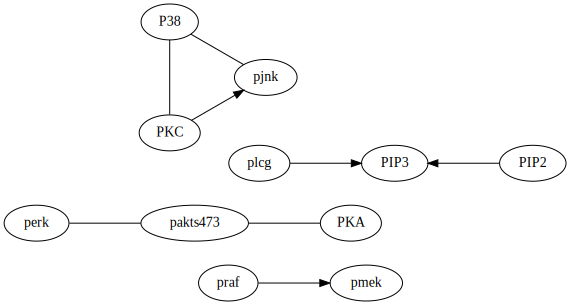

In [20]:
# For completeness: the graph over the data of experiment 1 again

data_exp1_drop = data_exp1.drop(columns='experiment')
tester = IndependenceTester(data_exp1_drop, ParCorr(), alpha=0.2)

G = PC_algorithm(11, tester)
graph_to_graphviz(G, list(data_exp1_drop.columns))

test: 0 and 1 given () -> pval=2.0376953059899394e-183
test: 0 and 2 given () -> pval=0.7288925242787185
independence found: 0 and 2 given ()
test: 0 and 3 given () -> pval=0.7124053354557727
independence found: 0 and 3 given ()
test: 0 and 4 given () -> pval=0.791738305990526
independence found: 0 and 4 given ()
test: 0 and 5 given () -> pval=0.10986481189123287
independence found: 0 and 5 given ()
test: 0 and 6 given () -> pval=0.01472987772599981
test: 0 and 7 given () -> pval=0.15894275506361807
independence found: 0 and 7 given ()
test: 0 and 8 given () -> pval=0.5617195629350336
independence found: 0 and 8 given ()
test: 0 and 9 given () -> pval=0.7455552457561689
independence found: 0 and 9 given ()
test: 0 and 10 given () -> pval=0.6894501241406117
independence found: 0 and 10 given ()
test: 1 and 0 given () -> pval=2.0376953059899394e-183
test: 1 and 2 given () -> pval=0.2804036871272833
independence found: 1 and 2 given ()
test: 1 and 3 given () -> pval=0.008173779888968266
t

test: 5 and 2 given (4,) -> pval=5.607455336953657e-06
test: 5 and 2 given (6,) -> pval=0.07373820188560634
test: 5 and 2 given (7,) -> pval=1.4003711293182383e-06
test: 5 and 2 given (8,) -> pval=2.8360621080886098e-08
test: 5 and 2 given (9,) -> pval=2.59938968285466e-08
test: 5 and 2 given (10,) -> pval=1.6999319156014226e-08
test: 5 and 3 given (0,) -> pval=1.4687011003824842e-12
test: 5 and 3 given (1,) -> pval=2.2777276216841747e-12
test: 5 and 3 given (2,) -> pval=2.1872482732636213e-06
test: 5 and 3 given (4,) -> pval=1.3773610583481822e-08
test: 5 and 3 given (6,) -> pval=0.00697056499306389
test: 5 and 3 given (7,) -> pval=3.605145422520552e-12
test: 5 and 3 given (8,) -> pval=4.397326782894026e-12
test: 5 and 3 given (9,) -> pval=3.2094144567407016e-12
test: 5 and 3 given (10,) -> pval=1.852989497388512e-12
test: 5 and 6 given (0,) -> pval=0.0
test: 5 and 6 given (1,) -> pval=0.0
test: 5 and 6 given (2,) -> pval=0.0
test: 5 and 6 given (3,) -> pval=0.0
test: 5 and 6 given (4

test: 1 and 3 given (6, 8) -> pval=0.005299809152724036
test: 1 and 3 given (6, 9) -> pval=0.00862649139310242
test: 1 and 3 given (6, 10) -> pval=0.0063430861142165
test: 1 and 3 given (7, 8) -> pval=0.007240076857848877
test: 1 and 3 given (7, 9) -> pval=0.011826241709937926
test: 1 and 3 given (7, 10) -> pval=0.008472800897655841
test: 1 and 3 given (8, 9) -> pval=0.011484897912168706
test: 1 and 3 given (8, 10) -> pval=0.008347722637197621
test: 1 and 3 given (9, 10) -> pval=0.014925409484079295
test: 2 and 3 given (0, 1) -> pval=5.117222061876546e-133
test: 2 and 3 given (0, 4) -> pval=1.4012604268027204e-100
test: 2 and 3 given (0, 5) -> pval=3.507364240652107e-127
test: 2 and 3 given (0, 6) -> pval=2.2649663939338867e-121
test: 2 and 3 given (0, 7) -> pval=1.2597525338384306e-132
test: 2 and 3 given (0, 8) -> pval=8.882114065821373e-131
test: 2 and 3 given (0, 9) -> pval=2.908425540733299e-129
test: 2 and 3 given (0, 10) -> pval=7.577236186560098e-133
test: 2 and 3 given (1, 4) 

test: 3 and 5 given (0, 4) -> pval=1.1931288708640173e-08
test: 3 and 5 given (0, 6) -> pval=0.006532923517082487
test: 3 and 5 given (0, 7) -> pval=3.2722993297193414e-12
test: 3 and 5 given (0, 8) -> pval=3.7841919164955196e-12
test: 3 and 5 given (0, 9) -> pval=2.7745865774106703e-12
test: 3 and 5 given (0, 10) -> pval=1.617047985279902e-12
test: 3 and 5 given (1, 2) -> pval=2.6080654942211167e-06
test: 3 and 5 given (1, 4) -> pval=1.964370470443394e-08
test: 3 and 5 given (1, 6) -> pval=0.004527638135711786
test: 3 and 5 given (1, 7) -> pval=5.768663222836627e-12
test: 3 and 5 given (1, 8) -> pval=5.944690978332837e-12
test: 3 and 5 given (1, 9) -> pval=4.232333495060628e-12
test: 3 and 5 given (1, 10) -> pval=2.487468565880247e-12
test: 3 and 5 given (2, 4) -> pval=7.165259051935021e-05
test: 3 and 5 given (2, 6) -> pval=0.039074783950036676
test: 3 and 5 given (2, 7) -> pval=2.6044337081827847e-07
test: 3 and 5 given (2, 8) -> pval=3.2452420415433706e-06
test: 3 and 5 given (2, 9

test: 5 and 6 given (1, 10) -> pval=0.0
test: 5 and 6 given (2, 3) -> pval=0.0
test: 5 and 6 given (2, 4) -> pval=0.0
test: 5 and 6 given (2, 7) -> pval=0.0
test: 5 and 6 given (2, 8) -> pval=0.0
test: 5 and 6 given (2, 9) -> pval=0.0
test: 5 and 6 given (2, 10) -> pval=0.0
test: 5 and 6 given (3, 4) -> pval=0.0
test: 5 and 6 given (3, 7) -> pval=0.0
test: 5 and 6 given (3, 8) -> pval=0.0
test: 5 and 6 given (3, 9) -> pval=0.0
test: 5 and 6 given (3, 10) -> pval=0.0
test: 5 and 6 given (4, 7) -> pval=0.0
test: 5 and 6 given (4, 8) -> pval=0.0
test: 5 and 6 given (4, 9) -> pval=0.0
test: 5 and 6 given (4, 10) -> pval=0.0
test: 5 and 6 given (7, 8) -> pval=0.0
test: 5 and 6 given (7, 9) -> pval=0.0
test: 5 and 6 given (7, 10) -> pval=0.0
test: 5 and 6 given (8, 9) -> pval=0.0
test: 5 and 6 given (8, 10) -> pval=0.0
test: 5 and 6 given (9, 10) -> pval=0.0
test: 6 and 2 given (0, 1) -> pval=3.913999291354e-15
test: 6 and 2 given (0, 3) -> pval=0.0044286807638399955
test: 6 and 2 given (0, 

test: 8 and 10 given (1, 4) -> pval=2.481730391108317e-10
test: 8 and 10 given (1, 5) -> pval=1.7670053412112882e-10
test: 8 and 10 given (1, 6) -> pval=1.401820678579046e-10
test: 8 and 10 given (1, 7) -> pval=1.650721104539193e-10
test: 8 and 10 given (1, 9) -> pval=3.145017511629806e-19
test: 8 and 10 given (2, 3) -> pval=3.8152411872211534e-10
test: 8 and 10 given (2, 4) -> pval=3.9202330137862406e-10
test: 8 and 10 given (2, 5) -> pval=3.4413652930033875e-10
test: 8 and 10 given (2, 6) -> pval=2.8442355212277503e-10
test: 8 and 10 given (2, 7) -> pval=3.290155674756786e-10
test: 8 and 10 given (2, 9) -> pval=5.734138526776385e-19
test: 8 and 10 given (3, 4) -> pval=3.487997949409412e-10
test: 8 and 10 given (3, 5) -> pval=3.554447821509924e-10
test: 8 and 10 given (3, 6) -> pval=3.2062457311046795e-10
test: 8 and 10 given (3, 7) -> pval=3.4728384917099923e-10
test: 8 and 10 given (3, 9) -> pval=7.380139969534263e-19
test: 8 and 10 given (4, 5) -> pval=2.600916463326676e-10
test: 8

test: 1 and 0 given (2, 7, 9) -> pval=2.509902424788552e-183
test: 1 and 0 given (2, 7, 10) -> pval=1.6445671033538923e-183
test: 1 and 0 given (2, 8, 9) -> pval=1.8616302616865132e-183
test: 1 and 0 given (2, 8, 10) -> pval=1.1183801112856087e-183
test: 1 and 0 given (2, 9, 10) -> pval=4.128939849255829e-184
test: 1 and 0 given (3, 4, 5) -> pval=9.625299329499281e-185
test: 1 and 0 given (3, 4, 6) -> pval=5.233190167638363e-184
test: 1 and 0 given (3, 4, 7) -> pval=9.608573162971885e-184
test: 1 and 0 given (3, 4, 8) -> pval=6.32348458809917e-184
test: 1 and 0 given (3, 4, 9) -> pval=3.0802145244924906e-184
test: 1 and 0 given (3, 4, 10) -> pval=1.6342039480740787e-184
test: 1 and 0 given (3, 5, 6) -> pval=1.4080920636251022e-183
test: 1 and 0 given (3, 5, 7) -> pval=2.9977835992581827e-184
test: 1 and 0 given (3, 5, 8) -> pval=2.1354840142955484e-184
test: 1 and 0 given (3, 5, 9) -> pval=1.0711781594484259e-184
test: 1 and 0 given (3, 5, 10) -> pval=5.8389323392918185e-185
test: 1 an

test: 2 and 4 given (0, 1, 9) -> pval=4.60490425433719e-35
test: 2 and 4 given (0, 1, 10) -> pval=2.3516491094824897e-36
test: 2 and 4 given (0, 3, 5) -> pval=0.003440840385486064
test: 2 and 4 given (0, 3, 6) -> pval=0.003151192309062923
test: 2 and 4 given (0, 3, 7) -> pval=0.0024706931769692634
test: 2 and 4 given (0, 3, 8) -> pval=0.002740692202604728
test: 2 and 4 given (0, 3, 9) -> pval=0.0029613239621312315
test: 2 and 4 given (0, 3, 10) -> pval=0.0029092783056973845
test: 2 and 4 given (0, 5, 6) -> pval=1.2484493057622633e-32
test: 2 and 4 given (0, 5, 7) -> pval=3.370902912429135e-34
test: 2 and 4 given (0, 5, 8) -> pval=3.177896351986622e-33
test: 2 and 4 given (0, 5, 9) -> pval=1.5812979172701324e-32
test: 2 and 4 given (0, 5, 10) -> pval=1.035706861058231e-33
test: 2 and 4 given (0, 6, 7) -> pval=1.564652410888029e-32
test: 2 and 4 given (0, 6, 8) -> pval=6.823168488232049e-32
test: 2 and 4 given (0, 6, 9) -> pval=2.8091458694686906e-31
test: 2 and 4 given (0, 6, 10) -> pva

test: 3 and 2 given (0, 6, 9) -> pval=5.790664821625215e-118
test: 3 and 2 given (0, 6, 10) -> pval=6.309852838289524e-121
test: 3 and 2 given (0, 7, 8) -> pval=2.8207259098645385e-130
test: 3 and 2 given (0, 7, 9) -> pval=1.0962062807824036e-128
test: 3 and 2 given (0, 7, 10) -> pval=3.1575948478129436e-132
test: 3 and 2 given (0, 8, 9) -> pval=4.3449120088434764e-129
test: 3 and 2 given (0, 8, 10) -> pval=1.2206449452872125e-130
test: 3 and 2 given (0, 9, 10) -> pval=8.172878251370496e-129
test: 3 and 2 given (1, 4, 5) -> pval=1.2340143005802495e-96
test: 3 and 2 given (1, 4, 6) -> pval=3.295033683981878e-92
test: 3 and 2 given (1, 4, 7) -> pval=1.4319224361430797e-99
test: 3 and 2 given (1, 4, 8) -> pval=1.5157822627007464e-98
test: 3 and 2 given (1, 4, 9) -> pval=9.02346592575824e-98
test: 3 and 2 given (1, 4, 10) -> pval=4.818232345391247e-100
test: 3 and 2 given (1, 5, 6) -> pval=1.8097588215743295e-120
test: 3 and 2 given (1, 5, 7) -> pval=1.1641473891188433e-127
test: 3 and 2 g

test: 3 and 6 given (0, 1, 10) -> pval=6.689256995974683e-24
test: 3 and 6 given (0, 2, 4) -> pval=1.871936323354706e-10
test: 3 and 6 given (0, 2, 5) -> pval=2.861827224829437e-08
test: 3 and 6 given (0, 2, 7) -> pval=2.8987211972309366e-15
test: 3 and 6 given (0, 2, 8) -> pval=4.649765670936491e-12
test: 3 and 6 given (0, 2, 9) -> pval=4.891399563280853e-12
test: 3 and 6 given (0, 2, 10) -> pval=2.3717729194574595e-12
test: 3 and 6 given (0, 4, 5) -> pval=1.4862842850018663e-13
test: 3 and 6 given (0, 4, 7) -> pval=1.671343465437199e-19
test: 3 and 6 given (0, 4, 8) -> pval=4.032921485588221e-18
test: 3 and 6 given (0, 4, 9) -> pval=4.760445551603793e-18
test: 3 and 6 given (0, 4, 10) -> pval=1.2510086933577733e-18
test: 3 and 6 given (0, 5, 7) -> pval=4.5696426987065215e-17
test: 3 and 6 given (0, 5, 8) -> pval=1.285244596995421e-14
test: 3 and 6 given (0, 5, 9) -> pval=4.0139690624010855e-14
test: 3 and 6 given (0, 5, 10) -> pval=4.619283328647011e-15
test: 3 and 6 given (0, 7, 8) 

test: 4 and 2 given (6, 7, 9) -> pval=2.7211199603619102e-31
test: 4 and 2 given (6, 7, 10) -> pval=2.693135325311294e-32
test: 4 and 2 given (6, 8, 9) -> pval=2.909543369759007e-31
test: 4 and 2 given (6, 8, 10) -> pval=9.190773177759598e-32
test: 4 and 2 given (6, 9, 10) -> pval=4.946851720411417e-31
test: 4 and 2 given (7, 8, 9) -> pval=6.623630140717229e-35
test: 4 and 2 given (7, 8, 10) -> pval=1.5476930341517454e-35
test: 4 and 2 given (7, 9, 10) -> pval=1.0828421705619786e-34
test: 4 and 2 given (8, 9, 10) -> pval=1.1919240881328864e-34
test: 4 and 3 given (0, 1, 2) -> pval=3.9428789907643476e-51
test: 4 and 3 given (0, 1, 5) -> pval=4.021136973459973e-80
test: 4 and 3 given (0, 1, 6) -> pval=2.7962395404401764e-78
test: 4 and 3 given (0, 1, 7) -> pval=5.740927962777771e-84
test: 4 and 3 given (0, 1, 8) -> pval=9.368304734525644e-83
test: 4 and 3 given (0, 1, 9) -> pval=1.376671235669023e-81
test: 4 and 3 given (0, 1, 10) -> pval=9.029106298241208e-84
test: 4 and 3 given (0, 2, 

test: 5 and 6 given (2, 7, 8) -> pval=0.0
test: 5 and 6 given (2, 7, 9) -> pval=0.0
test: 5 and 6 given (2, 7, 10) -> pval=0.0
test: 5 and 6 given (2, 8, 9) -> pval=0.0
test: 5 and 6 given (2, 8, 10) -> pval=0.0
test: 5 and 6 given (2, 9, 10) -> pval=0.0
test: 5 and 6 given (3, 4, 7) -> pval=0.0
test: 5 and 6 given (3, 4, 8) -> pval=0.0
test: 5 and 6 given (3, 4, 9) -> pval=0.0
test: 5 and 6 given (3, 4, 10) -> pval=0.0
test: 5 and 6 given (3, 7, 8) -> pval=0.0
test: 5 and 6 given (3, 7, 9) -> pval=0.0
test: 5 and 6 given (3, 7, 10) -> pval=0.0
test: 5 and 6 given (3, 8, 9) -> pval=0.0
test: 5 and 6 given (3, 8, 10) -> pval=0.0
test: 5 and 6 given (3, 9, 10) -> pval=0.0
test: 5 and 6 given (4, 7, 8) -> pval=0.0
test: 5 and 6 given (4, 7, 9) -> pval=0.0
test: 5 and 6 given (4, 7, 10) -> pval=0.0
test: 5 and 6 given (4, 8, 9) -> pval=0.0
test: 5 and 6 given (4, 8, 10) -> pval=0.0
test: 5 and 6 given (4, 9, 10) -> pval=0.0
test: 5 and 6 given (7, 8, 9) -> pval=0.0
test: 5 and 6 given (7, 

test: 6 and 7 given (1, 5, 9) -> pval=4.4902222526651675e-30
test: 6 and 7 given (1, 5, 10) -> pval=4.5006462423510735e-30
test: 6 and 7 given (1, 8, 9) -> pval=7.716284679671049e-80
test: 6 and 7 given (1, 8, 10) -> pval=1.172296999021641e-79
test: 6 and 7 given (1, 9, 10) -> pval=5.815188677513993e-80
test: 6 and 7 given (2, 3, 4) -> pval=9.319904605230131e-81
test: 6 and 7 given (2, 3, 5) -> pval=5.156954481182339e-32
test: 6 and 7 given (2, 3, 8) -> pval=1.400142213947652e-80
test: 6 and 7 given (2, 3, 9) -> pval=1.2056715465514992e-80
test: 6 and 7 given (2, 3, 10) -> pval=1.0927068678555999e-80
test: 6 and 7 given (2, 4, 5) -> pval=3.536803921673745e-30
test: 6 and 7 given (2, 4, 8) -> pval=1.9469078141324745e-78
test: 6 and 7 given (2, 4, 9) -> pval=1.2756738333102452e-78
test: 6 and 7 given (2, 4, 10) -> pval=1.2113837926932983e-78
test: 6 and 7 given (2, 5, 8) -> pval=7.725793922701298e-30
test: 6 and 7 given (2, 5, 9) -> pval=6.268658044656433e-30
test: 6 and 7 given (2, 5, 1

test: 8 and 10 given (0, 6, 7) -> pval=1.5089019205081416e-10
test: 8 and 10 given (0, 6, 9) -> pval=4.675246124731781e-19
test: 8 and 10 given (0, 7, 9) -> pval=4.97222435667237e-19
test: 8 and 10 given (1, 2, 3) -> pval=3.557740538709421e-10
test: 8 and 10 given (1, 2, 4) -> pval=3.890771934362854e-10
test: 8 and 10 given (1, 2, 5) -> pval=3.3710374076882583e-10
test: 8 and 10 given (1, 2, 6) -> pval=2.806234101716207e-10
test: 8 and 10 given (1, 2, 7) -> pval=3.2546457970099557e-10
test: 8 and 10 given (1, 2, 9) -> pval=3.941833814565794e-19
test: 8 and 10 given (1, 3, 4) -> pval=3.2409336380421784e-10
test: 8 and 10 given (1, 3, 5) -> pval=3.307341884103002e-10
test: 8 and 10 given (1, 3, 6) -> pval=2.9992896674892307e-10
test: 8 and 10 given (1, 3, 7) -> pval=3.2549254132231885e-10
test: 8 and 10 given (1, 3, 9) -> pval=4.976501789677626e-19
test: 8 and 10 given (1, 4, 5) -> pval=2.619112302446319e-10
test: 8 and 10 given (1, 4, 6) -> pval=2.1238578461632754e-10
test: 8 and 10 giv

test: 10 and 8 given (0, 3, 5) -> pval=3.7167480595285263e-10
test: 10 and 8 given (0, 3, 6) -> pval=3.3666841538719777e-10
test: 10 and 8 given (0, 3, 7) -> pval=3.6311370417903515e-10
test: 10 and 8 given (0, 3, 9) -> pval=7.849757029493772e-19
test: 10 and 8 given (0, 4, 5) -> pval=2.7039619977529985e-10
test: 10 and 8 given (0, 4, 6) -> pval=2.1776497446529046e-10
test: 10 and 8 given (0, 4, 7) -> pval=2.5840277402052175e-10
test: 10 and 8 given (0, 4, 9) -> pval=5.204490312068101e-19
test: 10 and 8 given (0, 5, 6) -> pval=1.3892531726615437e-10
test: 10 and 8 given (0, 5, 7) -> pval=1.8364243068339084e-10
test: 10 and 8 given (0, 5, 9) -> pval=5.428228336903285e-19
test: 10 and 8 given (0, 6, 7) -> pval=1.5089019205081416e-10
test: 10 and 8 given (0, 6, 9) -> pval=4.675246124731816e-19
test: 10 and 8 given (0, 7, 9) -> pval=4.9722243566722995e-19
test: 10 and 8 given (1, 2, 3) -> pval=3.557740538709421e-10
test: 10 and 8 given (1, 2, 4) -> pval=3.890771934362883e-10
test: 10 and 8

test: 1 and 0 given (2, 4, 8, 9) -> pval=2.1847780524565057e-183
test: 1 and 0 given (2, 4, 8, 10) -> pval=1.3259498580207723e-183
test: 1 and 0 given (2, 4, 9, 10) -> pval=4.720989239513329e-184
test: 1 and 0 given (2, 5, 6, 7) -> pval=2.596734869010857e-183
test: 1 and 0 given (2, 5, 6, 8) -> pval=2.2613587846143164e-183
test: 1 and 0 given (2, 5, 6, 9) -> pval=1.0583369469623378e-183
test: 1 and 0 given (2, 5, 6, 10) -> pval=6.302818221956643e-184
test: 1 and 0 given (2, 5, 7, 8) -> pval=7.240906377485456e-184
test: 1 and 0 given (2, 5, 7, 9) -> pval=3.271621717246604e-184
test: 1 and 0 given (2, 5, 7, 10) -> pval=2.1164022296436508e-184
test: 1 and 0 given (2, 5, 8, 9) -> pval=2.373812079504963e-184
test: 1 and 0 given (2, 5, 8, 10) -> pval=1.4585263289410738e-184
test: 1 and 0 given (2, 5, 9, 10) -> pval=5.5214080999105407e-185
test: 1 and 0 given (2, 6, 7, 8) -> pval=1.7722624364336729e-183
test: 1 and 0 given (2, 6, 7, 9) -> pval=8.553985265116002e-184
test: 1 and 0 given (2, 6,

test: 2 and 3 given (0, 1, 4, 10) -> pval=5.400344411815459e-100
test: 2 and 3 given (0, 1, 5, 6) -> pval=1.59721376129522e-120
test: 2 and 3 given (0, 1, 5, 7) -> pval=1.0578959723413746e-127
test: 2 and 3 given (0, 1, 5, 8) -> pval=6.565732465204785e-125
test: 2 and 3 given (0, 1, 5, 9) -> pval=1.9778499938441603e-123
test: 2 and 3 given (0, 1, 5, 10) -> pval=8.43671227880184e-127
test: 2 and 3 given (0, 1, 6, 7) -> pval=7.285306998004112e-122
test: 2 and 3 given (0, 1, 6, 8) -> pval=2.9760618706099236e-119
test: 2 and 3 given (0, 1, 6, 9) -> pval=5.753464436979852e-118
test: 2 and 3 given (0, 1, 6, 10) -> pval=6.603181608154498e-121
test: 2 and 3 given (0, 1, 7, 8) -> pval=4.541801466216408e-130
test: 2 and 3 given (0, 1, 7, 9) -> pval=1.4561024156054744e-128
test: 2 and 3 given (0, 1, 7, 10) -> pval=4.677491376448808e-132
test: 2 and 3 given (0, 1, 8, 9) -> pval=5.836996119418936e-129
test: 2 and 3 given (0, 1, 8, 10) -> pval=1.788049156369133e-130
test: 2 and 3 given (0, 1, 9, 10)

test: 2 and 4 given (3, 6, 7, 8) -> pval=0.0028686447176388954
test: 2 and 4 given (3, 6, 7, 9) -> pval=0.003087783712505636
test: 2 and 4 given (3, 6, 7, 10) -> pval=0.0030550469768396873
test: 2 and 4 given (3, 6, 8, 9) -> pval=0.0034938860575212407
test: 2 and 4 given (3, 6, 8, 10) -> pval=0.003409214140059752
test: 2 and 4 given (3, 6, 9, 10) -> pval=0.003697581713571776
test: 2 and 4 given (3, 7, 8, 9) -> pval=0.0027551486554972028
test: 2 and 4 given (3, 7, 8, 10) -> pval=0.002664613772882526
test: 2 and 4 given (3, 7, 9, 10) -> pval=0.0028997084016568983
test: 2 and 4 given (3, 8, 9, 10) -> pval=0.0032852460762008485
test: 2 and 4 given (5, 6, 7, 8) -> pval=5.757173846509953e-32
test: 2 and 4 given (5, 6, 7, 9) -> pval=2.2152372042585607e-31
test: 2 and 4 given (5, 6, 7, 10) -> pval=2.2781909050073916e-32
test: 2 and 4 given (5, 6, 8, 9) -> pval=2.3029723868552463e-31
test: 2 and 4 given (5, 6, 8, 10) -> pval=7.515621882003719e-32
test: 2 and 4 given (5, 6, 9, 10) -> pval=3.9707

test: 3 and 2 given (1, 5, 8, 10) -> pval=9.163087373903808e-125
test: 3 and 2 given (1, 5, 9, 10) -> pval=5.361754484766007e-123
test: 3 and 2 given (1, 6, 7, 8) -> pval=9.500758471368598e-120
test: 3 and 2 given (1, 6, 7, 9) -> pval=1.7665194234975686e-118
test: 3 and 2 given (1, 6, 7, 10) -> pval=2.1382988704278176e-121
test: 3 and 2 given (1, 6, 8, 9) -> pval=8.933362882222109e-118
test: 3 and 2 given (1, 6, 8, 10) -> pval=4.7826090610009906e-119
test: 3 and 2 given (1, 6, 9, 10) -> pval=1.8508027260527383e-117
test: 3 and 2 given (1, 7, 8, 9) -> pval=2.1031864391595103e-128
test: 3 and 2 given (1, 7, 8, 10) -> pval=5.95033217418412e-130
test: 3 and 2 given (1, 7, 9, 10) -> pval=3.966988054221916e-128
test: 3 and 2 given (1, 8, 9, 10) -> pval=1.1023131104208585e-128
test: 3 and 2 given (4, 5, 6, 7) -> pval=1.6434055807830372e-92
test: 3 and 2 given (4, 5, 6, 8) -> pval=1.7168477030200487e-90
test: 3 and 2 given (4, 5, 6, 9) -> pval=8.695052144076794e-90
test: 3 and 2 given (4, 5, 6

test: 3 and 5 given (0, 6, 7, 10) -> pval=0.004106096259021149
test: 3 and 5 given (0, 6, 8, 9) -> pval=0.00894085079793192
test: 3 and 5 given (0, 6, 8, 10) -> pval=0.00592891628403983
test: 3 and 5 given (0, 6, 9, 10) -> pval=0.008324725402494182
test: 3 and 5 given (0, 7, 8, 9) -> pval=6.227709695965792e-12
test: 3 and 5 given (0, 7, 8, 10) -> pval=6.006676915703893e-12
test: 3 and 5 given (0, 7, 9, 10) -> pval=6.000789075888082e-12
test: 3 and 5 given (0, 8, 9, 10) -> pval=3.808438243899675e-12
test: 3 and 5 given (1, 2, 4, 6) -> pval=0.00823399906234585
test: 3 and 5 given (1, 2, 4, 7) -> pval=2.9361527228867205e-05
test: 3 and 5 given (1, 2, 4, 8) -> pval=0.00011863620467900402
test: 3 and 5 given (1, 2, 4, 9) -> pval=9.445333246334273e-05
test: 3 and 5 given (1, 2, 4, 10) -> pval=8.913395256160601e-05
test: 3 and 5 given (1, 2, 6, 7) -> pval=0.021656121418989024
test: 3 and 5 given (1, 2, 6, 8) -> pval=0.027556436888076397
test: 3 and 5 given (1, 2, 6, 9) -> pval=0.0359012521771

test: 3 and 9 given (0, 1, 6, 10) -> pval=1.980110557775938e-08
test: 3 and 9 given (0, 1, 7, 8) -> pval=0.0005525097617580509
test: 3 and 9 given (0, 1, 7, 10) -> pval=3.416938217556142e-09
test: 3 and 9 given (0, 1, 8, 10) -> pval=0.0004031238627253822
test: 3 and 9 given (0, 2, 4, 5) -> pval=0.00017883502787242514
test: 3 and 9 given (0, 2, 4, 6) -> pval=0.00027450542822061796
test: 3 and 9 given (0, 2, 4, 7) -> pval=0.0001676799933846555
test: 3 and 9 given (0, 2, 4, 8) -> pval=0.06273102846312369
test: 3 and 9 given (0, 2, 4, 10) -> pval=0.0001633677619758237
test: 3 and 9 given (0, 2, 5, 6) -> pval=4.437549117775701e-05
test: 3 and 9 given (0, 2, 5, 7) -> pval=2.0830587248220472e-05
test: 3 and 9 given (0, 2, 5, 8) -> pval=0.018704971949949384
test: 3 and 9 given (0, 2, 5, 10) -> pval=2.0181451380204324e-05
test: 3 and 9 given (0, 2, 6, 7) -> pval=3.971506864971174e-05
test: 3 and 9 given (0, 2, 6, 8) -> pval=0.024938959224910694
test: 3 and 9 given (0, 2, 6, 10) -> pval=3.408019

test: 4 and 2 given (5, 6, 9, 10) -> pval=3.970778776756675e-31
test: 4 and 2 given (5, 7, 8, 9) -> pval=8.979250097443026e-33
test: 4 and 2 given (5, 7, 8, 10) -> pval=2.2181870106939315e-33
test: 4 and 2 given (5, 7, 9, 10) -> pval=1.4235086784796443e-32
test: 4 and 2 given (5, 8, 9, 10) -> pval=2.7141417156743e-32
test: 4 and 2 given (6, 7, 8, 9) -> pval=2.918031131903353e-31
test: 4 and 2 given (6, 7, 8, 10) -> pval=9.613360811155988e-32
test: 4 and 2 given (6, 7, 9, 10) -> pval=4.95142434317984e-31
test: 4 and 2 given (6, 8, 9, 10) -> pval=5.103077421046634e-31
test: 4 and 2 given (7, 8, 9, 10) -> pval=1.1277110147966742e-34
test: 4 and 3 given (0, 1, 2, 5) -> pval=1.2347983007375236e-49
test: 4 and 3 given (0, 1, 2, 6) -> pval=3.2155923972212356e-49
test: 4 and 3 given (0, 1, 2, 7) -> pval=4.3300899232765125e-51
test: 4 and 3 given (0, 1, 2, 8) -> pval=1.1709817849228587e-50
test: 4 and 3 given (0, 1, 2, 9) -> pval=3.6055789837882494e-50
test: 4 and 3 given (0, 1, 2, 10) -> pval=

test: 5 and 3 given (1, 7, 8, 10) -> pval=1.0605734105232585e-11
test: 5 and 3 given (1, 7, 9, 10) -> pval=1.014791130213495e-11
test: 5 and 3 given (1, 8, 9, 10) -> pval=5.865939383651465e-12
test: 5 and 3 given (2, 4, 6, 7) -> pval=0.0103537126922771
test: 5 and 3 given (2, 4, 6, 8) -> pval=0.013053674082092312
test: 5 and 3 given (2, 4, 6, 9) -> pval=0.01679691637769581
test: 5 and 3 given (2, 4, 6, 10) -> pval=0.012790923755107804
test: 5 and 3 given (2, 4, 7, 8) -> pval=2.4279744216021666e-05
test: 5 and 3 given (2, 4, 7, 9) -> pval=2.1653528448785715e-05
test: 5 and 3 given (2, 4, 7, 10) -> pval=2.0829172767423943e-05
test: 5 and 3 given (2, 4, 8, 9) -> pval=8.956646367504263e-05
test: 5 and 3 given (2, 4, 8, 10) -> pval=9.647553979322993e-05
test: 5 and 3 given (2, 4, 9, 10) -> pval=7.801472389238622e-05
test: 5 and 3 given (2, 6, 7, 8) -> pval=0.02921221794736813
test: 5 and 3 given (2, 6, 7, 9) -> pval=0.03780847376541598
test: 5 and 3 given (2, 6, 7, 10) -> pval=0.02807743101

test: 6 and 3 given (1, 2, 7, 10) -> pval=2.8532772244593855e-15
test: 6 and 3 given (1, 2, 8, 9) -> pval=5.262044891855156e-12
test: 6 and 3 given (1, 2, 8, 10) -> pval=4.521772905929273e-12
test: 6 and 3 given (1, 2, 9, 10) -> pval=4.341007082698423e-12
test: 6 and 3 given (1, 4, 5, 7) -> pval=1.9954896702395337e-15
test: 6 and 3 given (1, 4, 5, 8) -> pval=9.824833333436535e-14
test: 6 and 3 given (1, 4, 5, 9) -> pval=2.3835094977941514e-13
test: 6 and 3 given (1, 4, 5, 10) -> pval=4.860003561147632e-14
test: 6 and 3 given (1, 4, 7, 8) -> pval=4.2827312795978343e-19
test: 6 and 3 given (1, 4, 7, 9) -> pval=7.476134170165337e-19
test: 6 and 3 given (1, 4, 7, 10) -> pval=2.0705266046746446e-19
test: 6 and 3 given (1, 4, 8, 9) -> pval=6.505703353382112e-18
test: 6 and 3 given (1, 4, 8, 10) -> pval=4.60023201738857e-18
test: 6 and 3 given (1, 4, 9, 10) -> pval=4.82925101259196e-18
test: 6 and 3 given (1, 5, 7, 8) -> pval=3.685496518772338e-17
test: 6 and 3 given (1, 5, 7, 9) -> pval=1.68

test: 6 and 7 given (0, 3, 8, 9) -> pval=3.07859695287393e-81
test: 6 and 7 given (0, 3, 8, 10) -> pval=3.4644285278883338e-81
test: 6 and 7 given (0, 3, 9, 10) -> pval=2.8625530988097954e-81
test: 6 and 7 given (0, 4, 5, 8) -> pval=1.4698368628928978e-30
test: 6 and 7 given (0, 4, 5, 9) -> pval=1.1846161551370057e-30
test: 6 and 7 given (0, 4, 5, 10) -> pval=1.0995157919568585e-30
test: 6 and 7 given (0, 4, 8, 9) -> pval=2.706283162921508e-80
test: 6 and 7 given (0, 4, 8, 10) -> pval=3.682210225693995e-80
test: 6 and 7 given (0, 4, 9, 10) -> pval=2.053767665541966e-80
test: 6 and 7 given (0, 5, 8, 9) -> pval=3.5788083505621426e-30
test: 6 and 7 given (0, 5, 8, 10) -> pval=5.5525046867390565e-30
test: 6 and 7 given (0, 5, 9, 10) -> pval=3.9159111955414476e-30
test: 6 and 7 given (0, 8, 9, 10) -> pval=2.0843393938459785e-79
test: 6 and 7 given (1, 2, 3, 4) -> pval=1.3093760710817028e-80
test: 6 and 7 given (1, 2, 3, 5) -> pval=8.849611703340492e-32
test: 6 and 7 given (1, 2, 3, 8) -> pv

test: 8 and 9 given (0, 1, 4, 10) -> pval=2.7476873428588903e-195
test: 8 and 9 given (0, 1, 5, 6) -> pval=3.573103862269321e-187
test: 8 and 9 given (0, 1, 5, 7) -> pval=1.8421826392641753e-187
test: 8 and 9 given (0, 1, 5, 10) -> pval=4.090061066735773e-196
test: 8 and 9 given (0, 1, 6, 7) -> pval=3.243915488484032e-187
test: 8 and 9 given (0, 1, 6, 10) -> pval=1.097185646748412e-195
test: 8 and 9 given (0, 1, 7, 10) -> pval=2.5627004833731487e-196
test: 8 and 9 given (0, 2, 3, 4) -> pval=2.0182566926567865e-182
test: 8 and 9 given (0, 2, 3, 5) -> pval=2.08443802460783e-182
test: 8 and 9 given (0, 2, 3, 6) -> pval=2.5952845440980784e-182
test: 8 and 9 given (0, 2, 3, 7) -> pval=1.911323751935869e-182
test: 8 and 9 given (0, 2, 3, 10) -> pval=5.718478051250238e-191
test: 8 and 9 given (0, 2, 4, 5) -> pval=9.648749512276867e-185
test: 8 and 9 given (0, 2, 4, 6) -> pval=1.52685503445177e-184
test: 8 and 9 given (0, 2, 4, 7) -> pval=7.894414716350287e-185
test: 8 and 9 given (0, 2, 4, 10

test: 8 and 10 given (2, 6, 7, 9) -> pval=5.689578010466943e-19
test: 8 and 10 given (3, 4, 5, 6) -> pval=3.341226607936232e-10
test: 8 and 10 given (3, 4, 5, 7) -> pval=3.5915143969633403e-10
test: 8 and 10 given (3, 4, 5, 9) -> pval=7.016275465500114e-19
test: 8 and 10 given (3, 4, 6, 7) -> pval=3.4838134992288144e-10
test: 8 and 10 given (3, 4, 6, 9) -> pval=6.419997804934421e-19
test: 8 and 10 given (3, 4, 7, 9) -> pval=6.750850363143363e-19
test: 8 and 10 given (3, 5, 6, 7) -> pval=3.5632369217875265e-10
test: 8 and 10 given (3, 5, 6, 9) -> pval=9.256665811923891e-19
test: 8 and 10 given (3, 5, 7, 9) -> pval=7.723610019882425e-19
test: 8 and 10 given (3, 6, 7, 9) -> pval=7.915892573752545e-19
test: 8 and 10 given (4, 5, 6, 7) -> pval=2.1065798449725089e-10
test: 8 and 10 given (4, 5, 6, 9) -> pval=5.705816479363238e-19
test: 8 and 10 given (4, 5, 7, 9) -> pval=5.287396115828304e-19
test: 8 and 10 given (4, 6, 7, 9) -> pval=5.008507864950479e-19
test: 8 and 10 given (5, 6, 7, 9) ->

test: 9 and 8 given (1, 4, 5, 6) -> pval=2.9021395701116744e-186
test: 9 and 8 given (1, 4, 5, 7) -> pval=1.812948718084432e-186
test: 9 and 8 given (1, 4, 5, 10) -> pval=3.518394574702266e-195
test: 9 and 8 given (1, 4, 6, 7) -> pval=2.79245894548858e-186
test: 9 and 8 given (1, 4, 6, 10) -> pval=8.1202529064096e-195
test: 9 and 8 given (1, 4, 7, 10) -> pval=2.8166256744347684e-195
test: 9 and 8 given (1, 5, 6, 7) -> pval=1.7992468892449042e-187
test: 9 and 8 given (1, 5, 6, 10) -> pval=1.0919373754824578e-195
test: 9 and 8 given (1, 5, 7, 10) -> pval=3.892999735246965e-196
test: 9 and 8 given (1, 6, 7, 10) -> pval=7.849868828557835e-196
test: 9 and 8 given (2, 3, 4, 5) -> pval=1.663679241620376e-182
test: 9 and 8 given (2, 3, 4, 6) -> pval=2.1221530406482343e-182
test: 9 and 8 given (2, 3, 4, 7) -> pval=1.5650829661639984e-182
test: 9 and 8 given (2, 3, 4, 10) -> pval=4.159786279546046e-191
test: 9 and 8 given (2, 3, 5, 6) -> pval=1.651351620770457e-182
test: 9 and 8 given (2, 3, 5, 

test: 0 and 1 given (2, 4, 6, 9, 10) -> pval=1.7528415676618812e-184
test: 0 and 1 given (2, 4, 7, 8, 9) -> pval=4.184750779184343e-183
test: 0 and 1 given (2, 4, 7, 8, 10) -> pval=2.583794143163017e-183
test: 0 and 1 given (2, 4, 7, 9, 10) -> pval=9.311374745491598e-184
test: 0 and 1 given (2, 4, 8, 9, 10) -> pval=5.722895325487445e-184
test: 0 and 1 given (2, 5, 6, 7, 8) -> pval=3.0333043229899513e-183
test: 0 and 1 given (2, 5, 6, 7, 9) -> pval=1.4311309935466604e-183
test: 0 and 1 given (2, 5, 6, 7, 10) -> pval=8.463710986118044e-184
test: 0 and 1 given (2, 5, 6, 8, 9) -> pval=1.4934281272908967e-183
test: 0 and 1 given (2, 5, 6, 8, 10) -> pval=8.259795615137785e-184
test: 0 and 1 given (2, 5, 6, 9, 10) -> pval=3.296523077491731e-184
test: 0 and 1 given (2, 5, 7, 8, 9) -> pval=4.5147917445323136e-184
test: 0 and 1 given (2, 5, 7, 8, 10) -> pval=2.785016376889088e-184
test: 0 and 1 given (2, 5, 7, 9, 10) -> pval=1.063301454280268e-184
test: 0 and 1 given (2, 5, 8, 9, 10) -> pval=6.3

test: 1 and 3 given (0, 2, 5, 6, 7) -> pval=0.004860130493464311
test: 1 and 3 given (0, 2, 5, 6, 8) -> pval=0.0045339849133353574
test: 1 and 3 given (0, 2, 5, 6, 9) -> pval=0.0068796060421815975
test: 1 and 3 given (0, 2, 5, 6, 10) -> pval=0.004626042045758033
test: 1 and 3 given (0, 2, 5, 7, 8) -> pval=0.007469121194610502
test: 1 and 3 given (0, 2, 5, 7, 9) -> pval=0.011198150934937187
test: 1 and 3 given (0, 2, 5, 7, 10) -> pval=0.007312371602774302
test: 1 and 3 given (0, 2, 5, 8, 9) -> pval=0.009028636052304344
test: 1 and 3 given (0, 2, 5, 8, 10) -> pval=0.006446905940526038
test: 1 and 3 given (0, 2, 5, 9, 10) -> pval=0.010862854912682279
test: 1 and 3 given (0, 2, 6, 7, 8) -> pval=0.007304019701525396
test: 1 and 3 given (0, 2, 6, 7, 9) -> pval=0.010695820869500657
test: 1 and 3 given (0, 2, 6, 7, 10) -> pval=0.0073705488625163944
test: 1 and 3 given (0, 2, 6, 8, 9) -> pval=0.008283501598656404
test: 1 and 3 given (0, 2, 6, 8, 10) -> pval=0.006174944362501779
test: 1 and 3 gi

test: 2 and 3 given (1, 5, 7, 8, 10) -> pval=2.2881116823616287e-125
test: 2 and 3 given (1, 5, 7, 9, 10) -> pval=1.4240905336392174e-123
test: 2 and 3 given (1, 5, 8, 9, 10) -> pval=5.5534229461184366e-123
test: 2 and 3 given (1, 6, 7, 8, 9) -> pval=2.3671759146518782e-118
test: 2 and 3 given (1, 6, 7, 8, 10) -> pval=1.3667922183865146e-119
test: 2 and 3 given (1, 6, 7, 9, 10) -> pval=5.09486178633151e-118
test: 2 and 3 given (1, 6, 8, 9, 10) -> pval=1.903533263522335e-117
test: 2 and 3 given (1, 7, 8, 9, 10) -> pval=4.043782067837166e-128
test: 2 and 3 given (4, 5, 6, 7, 8) -> pval=4.245103994354624e-91
test: 2 and 3 given (4, 5, 6, 7, 9) -> pval=2.135204303526744e-90
test: 2 and 3 given (4, 5, 6, 7, 10) -> pval=3.0582527412440667e-92
test: 2 and 3 given (4, 5, 6, 8, 9) -> pval=1.14179847161902e-89
test: 2 and 3 given (4, 5, 6, 8, 10) -> pval=2.098989147822341e-90
test: 2 and 3 given (4, 5, 6, 9, 10) -> pval=1.699165974387679e-89
test: 2 and 3 given (4, 5, 7, 8, 9) -> pval=6.05782887

test: 3 and 1 given (0, 5, 6, 7, 10) -> pval=0.005620215285298397
test: 3 and 1 given (0, 5, 6, 8, 9) -> pval=0.006829747158275365
test: 3 and 1 given (0, 5, 6, 8, 10) -> pval=0.004837280978276157
test: 3 and 1 given (0, 5, 6, 9, 10) -> pval=0.00986676980984149
test: 3 and 1 given (0, 5, 7, 8, 9) -> pval=0.012079463080923164
test: 3 and 1 given (0, 5, 7, 8, 10) -> pval=0.008098211197744632
test: 3 and 1 given (0, 5, 7, 9, 10) -> pval=0.01630777678927356
test: 3 and 1 given (0, 5, 8, 9, 10) -> pval=0.013503546153253316
test: 3 and 1 given (0, 6, 7, 8, 9) -> pval=0.011389403040738195
test: 3 and 1 given (0, 6, 7, 8, 10) -> pval=0.008272750218773273
test: 3 and 1 given (0, 6, 7, 9, 10) -> pval=0.016027236920283496
test: 3 and 1 given (0, 6, 8, 9, 10) -> pval=0.012229298031241616
test: 3 and 1 given (0, 7, 8, 9, 10) -> pval=0.004672849023247731
test: 3 and 1 given (2, 4, 5, 6, 7) -> pval=0.0011285375425291845
test: 3 and 1 given (2, 4, 5, 6, 8) -> pval=0.0009047598138440138
test: 3 and 1 g

test: 3 and 4 given (0, 1, 5, 6, 8) -> pval=9.3185368406943e-78
test: 3 and 4 given (0, 1, 5, 6, 9) -> pval=1.0523349072952159e-76
test: 3 and 4 given (0, 1, 5, 6, 10) -> pval=1.64316813893547e-78
test: 3 and 4 given (0, 1, 5, 7, 8) -> pval=9.195740650824229e-79
test: 3 and 4 given (0, 1, 5, 7, 9) -> pval=1.3240511361064345e-77
test: 3 and 4 given (0, 1, 5, 7, 10) -> pval=1.1205746820585791e-79
test: 3 and 4 given (0, 1, 5, 8, 9) -> pval=7.467682317819281e-78
test: 3 and 4 given (0, 1, 5, 8, 10) -> pval=6.37969814785987e-79
test: 3 and 4 given (0, 1, 5, 9, 10) -> pval=1.5336136063617472e-77
test: 3 and 4 given (0, 1, 6, 7, 8) -> pval=2.5340779071493105e-76
test: 3 and 4 given (0, 1, 6, 7, 9) -> pval=2.532472191437879e-75
test: 3 and 4 given (0, 1, 6, 7, 10) -> pval=4.059637013233824e-77
test: 3 and 4 given (0, 1, 6, 8, 9) -> pval=3.4249742836525e-76
test: 3 and 4 given (0, 1, 6, 8, 10) -> pval=4.207892366482973e-77
test: 3 and 4 given (0, 1, 6, 9, 10) -> pval=7.759163004620554e-76
test

test: 3 and 5 given (2, 4, 6, 7, 9) -> pval=0.013162814676693993
test: 3 and 5 given (2, 4, 6, 7, 10) -> pval=0.009905078715521484
test: 3 and 5 given (2, 4, 6, 8, 9) -> pval=0.015277392620919107
test: 3 and 5 given (2, 4, 6, 8, 10) -> pval=0.013288701162424386
test: 3 and 5 given (2, 4, 6, 9, 10) -> pval=0.0160386481552116
test: 3 and 5 given (2, 4, 7, 8, 9) -> pval=2.351922222992841e-05
test: 3 and 5 given (2, 4, 7, 8, 10) -> pval=2.4290623088486365e-05
test: 3 and 5 given (2, 4, 7, 9, 10) -> pval=2.1926192745240168e-05
test: 3 and 5 given (2, 4, 8, 9, 10) -> pval=9.00026419355224e-05
test: 3 and 5 given (2, 6, 7, 8, 9) -> pval=0.03458821036296783
test: 3 and 5 given (2, 6, 7, 8, 10) -> pval=0.028912668139094724
test: 3 and 5 given (2, 6, 7, 9, 10) -> pval=0.035147375197390966
test: 3 and 5 given (2, 6, 8, 9, 10) -> pval=0.04361824417343796
test: 3 and 5 given (2, 7, 8, 9, 10) -> pval=3.2816299192813814e-07
test: 3 and 5 given (4, 6, 7, 8, 9) -> pval=0.0020495215468159687
test: 3 and

test: 3 and 9 given (1, 2, 4, 5, 7) -> pval=0.00024319958981263703
test: 3 and 9 given (1, 2, 4, 5, 8) -> pval=0.07360759893247824
test: 3 and 9 given (1, 2, 4, 5, 10) -> pval=0.0002466635963608849
test: 3 and 9 given (1, 2, 4, 6, 7) -> pval=0.0004054030387869361
test: 3 and 9 given (1, 2, 4, 6, 8) -> pval=0.09090433604427049
test: 3 and 9 given (1, 2, 4, 6, 10) -> pval=0.00038013153306892914
test: 3 and 9 given (1, 2, 4, 7, 8) -> pval=0.08048268611498996
test: 3 and 9 given (1, 2, 4, 7, 10) -> pval=0.00023203176482190443
test: 3 and 9 given (1, 2, 4, 8, 10) -> pval=0.08927262187643609
test: 3 and 9 given (1, 2, 5, 6, 7) -> pval=6.708118394497685e-05
test: 3 and 9 given (1, 2, 5, 6, 8) -> pval=0.03737483948613267
test: 3 and 9 given (1, 2, 5, 6, 10) -> pval=5.772074068622802e-05
test: 3 and 9 given (1, 2, 5, 7, 8) -> pval=0.02511266047126788
test: 3 and 9 given (1, 2, 5, 7, 10) -> pval=2.620187534342203e-05
test: 3 and 9 given (1, 2, 5, 8, 10) -> pval=0.023456453285293687
test: 3 and 9

test: 4 and 3 given (0, 1, 6, 7, 8) -> pval=2.5340779071493105e-76
test: 4 and 3 given (0, 1, 6, 7, 9) -> pval=2.532472191437879e-75
test: 4 and 3 given (0, 1, 6, 7, 10) -> pval=4.059637013233477e-77
test: 4 and 3 given (0, 1, 6, 8, 9) -> pval=3.4249742836525e-76
test: 4 and 3 given (0, 1, 6, 8, 10) -> pval=4.2078923664833324e-77
test: 4 and 3 given (0, 1, 6, 9, 10) -> pval=7.759163004620553e-76
test: 4 and 3 given (0, 1, 7, 8, 9) -> pval=1.4945975123814682e-81
test: 4 and 3 given (0, 1, 7, 8, 10) -> pval=1.2538384599799612e-82
test: 4 and 3 given (0, 1, 7, 9, 10) -> pval=3.041403988088521e-81
test: 4 and 3 given (0, 1, 8, 9, 10) -> pval=2.1371115672947296e-81
test: 4 and 3 given (0, 2, 5, 6, 7) -> pval=7.02490336318675e-48
test: 4 and 3 given (0, 2, 5, 6, 8) -> pval=2.818659139972421e-48
test: 4 and 3 given (0, 2, 5, 6, 9) -> pval=8.033901143158794e-48
test: 4 and 3 given (0, 2, 5, 6, 10) -> pval=1.3725095052294484e-48
test: 4 and 3 given (0, 2, 5, 7, 8) -> pval=7.820501860748257e-48


test: 5 and 3 given (2, 4, 6, 9, 10) -> pval=0.0160386481552116
test: 5 and 3 given (2, 4, 7, 8, 9) -> pval=2.351922222992841e-05
test: 5 and 3 given (2, 4, 7, 8, 10) -> pval=2.4290623088486365e-05
test: 5 and 3 given (2, 4, 7, 9, 10) -> pval=2.1926192745240202e-05
test: 5 and 3 given (2, 4, 8, 9, 10) -> pval=9.000264193552291e-05
test: 5 and 3 given (2, 6, 7, 8, 9) -> pval=0.03458821036296783
test: 5 and 3 given (2, 6, 7, 8, 10) -> pval=0.028912668139094638
test: 5 and 3 given (2, 6, 7, 9, 10) -> pval=0.03514737519739104
test: 5 and 3 given (2, 6, 8, 9, 10) -> pval=0.04361824417343787
test: 5 and 3 given (2, 7, 8, 9, 10) -> pval=3.2816299192813703e-07
test: 5 and 3 given (4, 6, 7, 8, 9) -> pval=0.002049521546815963
test: 5 and 3 given (4, 6, 7, 8, 10) -> pval=0.0014609220877975604
test: 5 and 3 given (4, 6, 7, 9, 10) -> pval=0.002039349976159496
test: 5 and 3 given (4, 6, 8, 9, 10) -> pval=0.0024551715742620003
test: 5 and 3 given (4, 7, 8, 9, 10) -> pval=5.955198317443653e-08
test: 5

test: 6 and 3 given (1, 2, 4, 5, 8) -> pval=1.6344519693339948e-08
test: 6 and 3 given (1, 2, 4, 5, 9) -> pval=2.5815865224479475e-08
test: 6 and 3 given (1, 2, 4, 5, 10) -> pval=1.2687739098999635e-08
test: 6 and 3 given (1, 2, 4, 7, 8) -> pval=1.8652350275939098e-12
test: 6 and 3 given (1, 2, 4, 7, 9) -> pval=2.410459736005275e-12
test: 6 and 3 given (1, 2, 4, 7, 10) -> pval=1.3956127530491345e-12
test: 6 and 3 given (1, 2, 4, 8, 9) -> pval=3.3279354959322384e-10
test: 6 and 3 given (1, 2, 4, 8, 10) -> pval=3.1689027490975957e-10
test: 6 and 3 given (1, 2, 4, 9, 10) -> pval=2.8628324275095123e-10
test: 6 and 3 given (1, 2, 5, 7, 8) -> pval=1.2809157536556894e-10
test: 6 and 3 given (1, 2, 5, 7, 9) -> pval=2.7465762000495875e-10
test: 6 and 3 given (1, 2, 5, 7, 10) -> pval=9.981179534425242e-11
test: 6 and 3 given (1, 2, 5, 8, 9) -> pval=3.1276839279165854e-08
test: 6 and 3 given (1, 2, 5, 8, 10) -> pval=2.0992415215354243e-08
test: 6 and 3 given (1, 2, 5, 9, 10) -> pval=3.07441978733

test: 6 and 7 given (0, 2, 3, 4, 9) -> pval=3.2066993474239936e-80
test: 6 and 7 given (0, 2, 3, 4, 10) -> pval=2.8946497161049893e-80
test: 6 and 7 given (0, 2, 3, 5, 8) -> pval=8.013719320262014e-32
test: 6 and 7 given (0, 2, 3, 5, 9) -> pval=8.229928537726249e-32
test: 6 and 7 given (0, 2, 3, 5, 10) -> pval=7.349095925138286e-32
test: 6 and 7 given (0, 2, 3, 8, 9) -> pval=3.9862160472924926e-80
test: 6 and 7 given (0, 2, 3, 8, 10) -> pval=4.535486596937479e-80
test: 6 and 7 given (0, 2, 3, 9, 10) -> pval=3.7320020402203365e-80
test: 6 and 7 given (0, 2, 4, 5, 8) -> pval=6.174491842743521e-30
test: 6 and 7 given (0, 2, 4, 5, 9) -> pval=5.2621096959303926e-30
test: 6 and 7 given (0, 2, 4, 5, 10) -> pval=5.0867419617047454e-30
test: 6 and 7 given (0, 2, 4, 8, 9) -> pval=4.855512923563896e-78
test: 6 and 7 given (0, 2, 4, 8, 10) -> pval=6.130551759338701e-78
test: 6 and 7 given (0, 2, 4, 9, 10) -> pval=3.8999053420391903e-78
test: 6 and 7 given (0, 2, 5, 8, 9) -> pval=8.167974232590109e

test: 8 and 9 given (0, 1, 2, 3, 5) -> pval=1.654971886834315e-182
test: 8 and 9 given (0, 1, 2, 3, 6) -> pval=2.1246091400521173e-182
test: 8 and 9 given (0, 1, 2, 3, 7) -> pval=1.5784933098882856e-182
test: 8 and 9 given (0, 1, 2, 3, 10) -> pval=2.5748185474397823e-191
test: 8 and 9 given (0, 1, 2, 4, 5) -> pval=9.271920034669326e-185
test: 8 and 9 given (0, 1, 2, 4, 6) -> pval=1.516341684385955e-184
test: 8 and 9 given (0, 1, 2, 4, 7) -> pval=8.170286826216422e-185
test: 8 and 9 given (0, 1, 2, 4, 10) -> pval=1.0296759818313352e-193
test: 8 and 9 given (0, 1, 2, 5, 6) -> pval=4.186583858265074e-185
test: 8 and 9 given (0, 1, 2, 5, 7) -> pval=3.0770994226967545e-185
test: 8 and 9 given (0, 1, 2, 5, 10) -> pval=4.631351121649919e-194
test: 8 and 9 given (0, 1, 2, 6, 7) -> pval=3.9666385950011054e-185
test: 8 and 9 given (0, 1, 2, 6, 10) -> pval=8.11825094982853e-194
test: 8 and 9 given (0, 1, 2, 7, 10) -> pval=3.535499845947227e-194
test: 8 and 9 given (0, 1, 3, 4, 5) -> pval=1.175238

test: 8 and 10 given (1, 2, 5, 6, 9) -> pval=4.656149187651366e-19
test: 8 and 10 given (1, 2, 5, 7, 9) -> pval=4.1095181237526243e-19
test: 8 and 10 given (1, 2, 6, 7, 9) -> pval=3.954880750684668e-19
test: 8 and 10 given (1, 3, 4, 5, 6) -> pval=3.1283249179372764e-10
test: 8 and 10 given (1, 3, 4, 5, 7) -> pval=3.355793155620735e-10
test: 8 and 10 given (1, 3, 4, 5, 9) -> pval=4.589196743314849e-19
test: 8 and 10 given (1, 3, 4, 6, 7) -> pval=3.2608967364659035e-10
test: 8 and 10 given (1, 3, 4, 6, 9) -> pval=4.238382473730074e-19
test: 8 and 10 given (1, 3, 4, 7, 9) -> pval=4.473658322615344e-19
test: 8 and 10 given (1, 3, 5, 6, 7) -> pval=3.3534946428503443e-10
test: 8 and 10 given (1, 3, 5, 6, 9) -> pval=6.3346094929989e-19
test: 8 and 10 given (1, 3, 5, 7, 9) -> pval=5.257889268085133e-19
test: 8 and 10 given (1, 3, 6, 7, 9) -> pval=5.403168190705516e-19
test: 8 and 10 given (1, 4, 5, 6, 7) -> pval=2.1506626384554998e-10
test: 8 and 10 given (1, 4, 5, 6, 9) -> pval=3.898359559420

test: 9 and 8 given (0, 2, 5, 7, 10) -> pval=9.785442648187788e-194
test: 9 and 8 given (0, 2, 6, 7, 10) -> pval=1.3535890880446715e-193
test: 9 and 8 given (0, 3, 4, 5, 6) -> pval=1.6270654895012653e-182
test: 9 and 8 given (0, 3, 4, 5, 7) -> pval=1.8768398698850982e-182
test: 9 and 8 given (0, 3, 4, 5, 10) -> pval=5.263383009467987e-191
test: 9 and 8 given (0, 3, 4, 6, 7) -> pval=1.842280852164637e-182
test: 9 and 8 given (0, 3, 4, 6, 10) -> pval=6.722561616617092e-191
test: 9 and 8 given (0, 3, 4, 7, 10) -> pval=5.065687293292058e-191
test: 9 and 8 given (0, 3, 5, 6, 7) -> pval=1.3708863120284942e-182
test: 9 and 8 given (0, 3, 5, 6, 10) -> pval=7.40141263750905e-191
test: 9 and 8 given (0, 3, 5, 7, 10) -> pval=6.489638819358681e-191
test: 9 and 8 given (0, 3, 6, 7, 10) -> pval=6.664732599538374e-191
test: 9 and 8 given (0, 4, 5, 6, 7) -> pval=3.89016443464616e-186
test: 9 and 8 given (0, 4, 5, 6, 10) -> pval=2.3486878148015643e-194
test: 9 and 8 given (0, 4, 5, 7, 10) -> pval=1.033

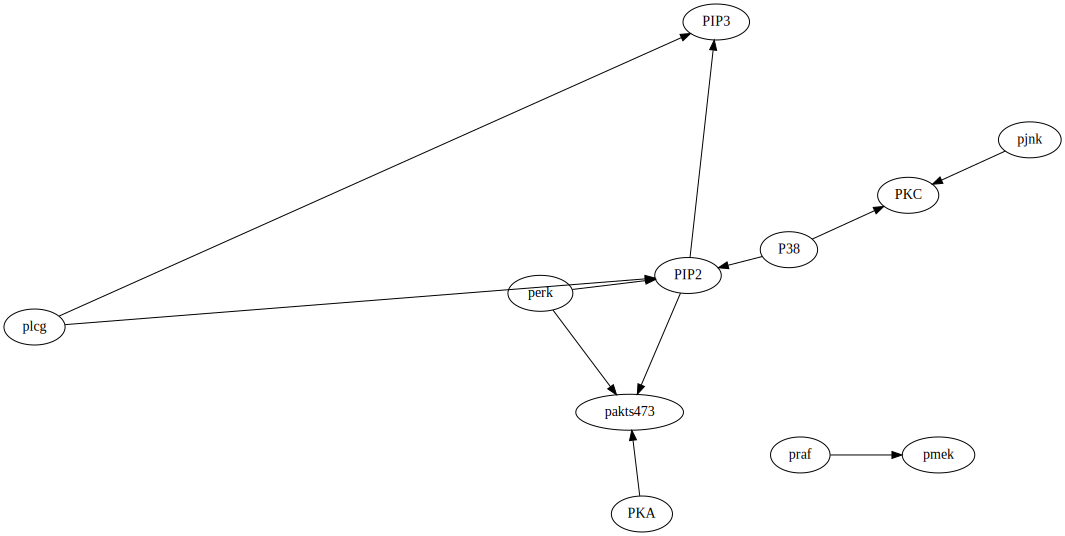

In [21]:
# Experiments 1 and 5, alpha 0.1

data_exp1_5_drop = data_exp1_5.drop(columns='experiment')
tester1_5 = IndependenceTester(data_exp1_5_drop, ParCorr(), alpha=0.1)

G = PC_algorithm(11, tester1_5)
graph_to_graphviz(G, list(data_exp1_5_drop.columns))

test: 0 and 1 given () -> pval=2.0376953059899394e-183
test: 0 and 2 given () -> pval=0.7288925242787185
independence found: 0 and 2 given ()
test: 0 and 3 given () -> pval=0.7124053354557727
independence found: 0 and 3 given ()
test: 0 and 4 given () -> pval=0.791738305990526
independence found: 0 and 4 given ()
test: 0 and 5 given () -> pval=0.10986481189123287
test: 0 and 6 given () -> pval=0.01472987772599981
test: 0 and 7 given () -> pval=0.15894275506361807
test: 0 and 8 given () -> pval=0.5617195629350336
independence found: 0 and 8 given ()
test: 0 and 9 given () -> pval=0.7455552457561689
independence found: 0 and 9 given ()
test: 0 and 10 given () -> pval=0.6894501241406117
independence found: 0 and 10 given ()
test: 1 and 0 given () -> pval=2.0376953059899394e-183
test: 1 and 2 given () -> pval=0.2804036871272833
independence found: 1 and 2 given ()
test: 1 and 3 given () -> pval=0.008173779888968266
test: 1 and 4 given () -> pval=0.4030837010156133
independence found: 1 and

test: 4 and 8 given (0,) -> pval=0.018176889015022398
test: 4 and 8 given (1,) -> pval=0.01790863928258878
test: 4 and 8 given (2,) -> pval=0.1565005743565377
test: 4 and 8 given (3,) -> pval=0.9404793099640125
independence found: 4 and 8 given (3,)
test: 4 and 9 given (0,) -> pval=0.0007083267377284462
test: 4 and 9 given (1,) -> pval=0.0006334528475099334
test: 4 and 9 given (2,) -> pval=0.031132763854385747
test: 4 and 9 given (3,) -> pval=0.42914461378858204
independence found: 4 and 9 given (3,)
test: 4 and 10 given (0,) -> pval=0.19522286489030583
test: 4 and 10 given (1,) -> pval=0.18379665674088747
test: 4 and 10 given (2,) -> pval=0.3945437113043432
independence found: 4 and 10 given (2,)
test: 5 and 2 given (0,) -> pval=1.4039693319828936e-08
test: 5 and 2 given (1,) -> pval=1.754166830846657e-08
test: 5 and 2 given (3,) -> pval=0.032009513946891346
test: 5 and 2 given (4,) -> pval=5.607455336953657e-06
test: 5 and 2 given (6,) -> pval=0.07373820188560634
test: 5 and 2 given 

test: 1 and 0 given (6, 7) -> pval=8.46688993436926e-184
test: 1 and 0 given (6, 8) -> pval=7.139833558831048e-184
test: 1 and 0 given (6, 9) -> pval=3.521099377898849e-184
test: 1 and 0 given (6, 10) -> pval=1.9448450642208366e-184
test: 1 and 0 given (7, 8) -> pval=3.997732216070269e-183
test: 1 and 0 given (7, 9) -> pval=1.7550570538511598e-183
test: 1 and 0 given (7, 10) -> pval=1.1842787215131488e-183
test: 1 and 0 given (8, 9) -> pval=1.390884340383447e-183
test: 1 and 0 given (8, 10) -> pval=8.426836239387197e-184
test: 1 and 0 given (9, 10) -> pval=3.0184595298039296e-184
test: 1 and 3 given (0, 2) -> pval=0.0028214833545803803
test: 1 and 3 given (0, 4) -> pval=9.411775673839701e-05
test: 1 and 3 given (0, 5) -> pval=0.0062949307598818855
test: 1 and 3 given (0, 6) -> pval=0.005637392591091833
test: 1 and 3 given (0, 7) -> pval=0.0019354797116047076
test: 1 and 3 given (0, 8) -> pval=0.002252703674109734
test: 1 and 3 given (0, 9) -> pval=0.004295274566463219
test: 1 and 3 giv

test: 3 and 1 given (5, 7) -> pval=0.012242374703771859
test: 3 and 1 given (5, 8) -> pval=0.010866743056494743
test: 3 and 1 given (5, 9) -> pval=0.01738133962658471
test: 3 and 1 given (5, 10) -> pval=0.012744828526222057
test: 3 and 1 given (6, 7) -> pval=0.006452306742259035
test: 3 and 1 given (6, 8) -> pval=0.005299809152724042
test: 3 and 1 given (6, 9) -> pval=0.008626491393102413
test: 3 and 1 given (6, 10) -> pval=0.006343086114216489
test: 3 and 1 given (7, 8) -> pval=0.007240076857848862
test: 3 and 1 given (7, 9) -> pval=0.011826241709937893
test: 3 and 1 given (7, 10) -> pval=0.008472800897655841
test: 3 and 1 given (8, 9) -> pval=0.011484897912168682
test: 3 and 1 given (8, 10) -> pval=0.008347722637197632
test: 3 and 1 given (9, 10) -> pval=0.014925409484079295
test: 3 and 2 given (0, 1) -> pval=5.117222061876546e-133
test: 3 and 2 given (0, 4) -> pval=1.4012604268027204e-100
test: 3 and 2 given (0, 5) -> pval=3.5073642406513084e-127
test: 3 and 2 given (0, 6) -> pval=2

test: 4 and 2 given (7, 10) -> pval=3.2614734526295e-36
test: 4 and 2 given (8, 9) -> pval=7.038434878970292e-35
test: 4 and 2 given (8, 10) -> pval=1.6819665535919567e-35
test: 4 and 2 given (9, 10) -> pval=1.1473790667087499e-34
test: 4 and 3 given (0, 1) -> pval=4.978953034911859e-84
test: 4 and 3 given (0, 2) -> pval=3.650368925403781e-50
test: 4 and 3 given (0, 5) -> pval=5.590735142659609e-79
test: 4 and 3 given (0, 6) -> pval=3.572051093992228e-77
test: 4 and 3 given (0, 7) -> pval=8.625852614378623e-83
test: 4 and 3 given (0, 8) -> pval=1.3695145305261894e-81
test: 4 and 3 given (0, 9) -> pval=1.9248087473498008e-80
test: 4 and 3 given (0, 10) -> pval=1.4266687430487532e-82
test: 4 and 3 given (1, 2) -> pval=6.545217922618446e-51
test: 4 and 3 given (1, 5) -> pval=6.949139439084991e-80
test: 4 and 3 given (1, 6) -> pval=4.338671783708057e-78
test: 4 and 3 given (1, 7) -> pval=1.0003286467901879e-83
test: 4 and 3 given (1, 8) -> pval=1.6346063144577608e-82
test: 4 and 3 given (1

test: 7 and 6 given (0, 1) -> pval=9.685042903209606e-80
test: 7 and 6 given (0, 2) -> pval=2.2866611179514713e-77
test: 7 and 6 given (0, 3) -> pval=2.4069326116027757e-81
test: 7 and 6 given (0, 4) -> pval=1.6146891381347691e-80
test: 7 and 6 given (0, 5) -> pval=4.2176731959387964e-30
test: 7 and 6 given (0, 8) -> pval=2.6463287435747092e-79
test: 7 and 6 given (0, 9) -> pval=1.321937154648396e-79
test: 7 and 6 given (0, 10) -> pval=1.2055942701971009e-79
test: 7 and 6 given (1, 2) -> pval=9.448610701240321e-78
test: 7 and 6 given (1, 3) -> pval=1.1674497519478442e-81
test: 7 and 6 given (1, 4) -> pval=6.206816774372779e-81
test: 7 and 6 given (1, 5) -> pval=4.657675792492279e-30
test: 7 and 6 given (1, 8) -> pval=1.0843640246941443e-79
test: 7 and 6 given (1, 9) -> pval=5.449384720944776e-80
test: 7 and 6 given (1, 10) -> pval=4.793804328994832e-80
test: 7 and 6 given (2, 3) -> pval=1.0562416275613866e-80
test: 7 and 6 given (2, 4) -> pval=1.1685606197814965e-78
test: 7 and 6 given

test: 10 and 8 given (0, 9) -> pval=4.883613795621467e-19
test: 10 and 8 given (1, 2) -> pval=3.245928821414393e-10
test: 10 and 8 given (1, 3) -> pval=3.2046414745642874e-10
test: 10 and 8 given (1, 4) -> pval=2.4817303911082895e-10
test: 10 and 8 given (1, 5) -> pval=1.7670053412112882e-10
test: 10 and 8 given (1, 6) -> pval=1.401820678579046e-10
test: 10 and 8 given (1, 7) -> pval=1.650721104539193e-10
test: 10 and 8 given (1, 9) -> pval=3.1450175116298744e-19
test: 10 and 8 given (2, 3) -> pval=3.8152411872211534e-10
test: 10 and 8 given (2, 4) -> pval=3.9202330137862406e-10
test: 10 and 8 given (2, 5) -> pval=3.4413652930033875e-10
test: 10 and 8 given (2, 6) -> pval=2.8442355212277503e-10
test: 10 and 8 given (2, 7) -> pval=3.290155674756786e-10
test: 10 and 8 given (2, 9) -> pval=5.73413852677655e-19
test: 10 and 8 given (3, 4) -> pval=3.4879979494093743e-10
test: 10 and 8 given (3, 5) -> pval=3.554447821509924e-10
test: 10 and 8 given (3, 6) -> pval=3.2062457311047033e-10
test:

test: 1 and 3 given (2, 7, 9) -> pval=0.019177128499931154
test: 1 and 3 given (2, 7, 10) -> pval=0.014930141446037012
test: 1 and 3 given (2, 8, 9) -> pval=0.016956103584226022
test: 1 and 3 given (2, 8, 10) -> pval=0.013407905960615673
test: 1 and 3 given (2, 9, 10) -> pval=0.019979032364362055
test: 1 and 3 given (4, 5, 6) -> pval=0.00027222901187325474
test: 1 and 3 given (4, 5, 7) -> pval=0.0011029588414015106
test: 1 and 3 given (4, 5, 8) -> pval=0.0010157441743124933
test: 1 and 3 given (4, 5, 9) -> pval=0.0016931892899355394
test: 1 and 3 given (4, 5, 10) -> pval=0.0011515535014862022
test: 1 and 3 given (4, 6, 7) -> pval=0.0005981331894075334
test: 1 and 3 given (4, 6, 8) -> pval=0.0004920991206680861
test: 1 and 3 given (4, 6, 9) -> pval=0.0008240515776875244
test: 1 and 3 given (4, 6, 10) -> pval=0.0005676515541631649
test: 1 and 3 given (4, 7, 8) -> pval=0.0006359070000854972
test: 1 and 3 given (4, 7, 9) -> pval=0.0010728241430035105
test: 1 and 3 given (4, 7, 10) -> pval=

test: 2 and 4 given (1, 5, 8) -> pval=2.2568089271618393e-33
test: 2 and 4 given (1, 5, 9) -> pval=1.1429139348936653e-32
test: 2 and 4 given (1, 5, 10) -> pval=7.374340127841535e-34
test: 2 and 4 given (1, 6, 7) -> pval=1.0792370549459284e-32
test: 2 and 4 given (1, 6, 8) -> pval=4.7578192029786705e-32
test: 2 and 4 given (1, 6, 9) -> pval=1.97967200336221e-31
test: 2 and 4 given (1, 6, 10) -> pval=1.8880734963347335e-32
test: 2 and 4 given (1, 7, 8) -> pval=8.034881629063251e-36
test: 2 and 4 given (1, 7, 9) -> pval=4.285682392906714e-35
test: 2 and 4 given (1, 7, 10) -> pval=2.2551006479871118e-36
test: 2 and 4 given (1, 8, 9) -> pval=5.026959536035565e-35
test: 2 and 4 given (1, 8, 10) -> pval=1.1925815746807539e-35
test: 2 and 4 given (1, 9, 10) -> pval=8.279206969144522e-35
test: 2 and 4 given (3, 5, 6) -> pval=0.0030114007400822845
test: 2 and 4 given (3, 5, 7) -> pval=0.0029170972780079587
test: 2 and 4 given (3, 5, 8) -> pval=0.0034781891632765256
test: 2 and 4 given (3, 5, 9)

test: 3 and 2 given (1, 4, 9) -> pval=9.02346592575824e-98
test: 3 and 2 given (1, 4, 10) -> pval=4.818232345391247e-100
test: 3 and 2 given (1, 5, 6) -> pval=1.8097588215743295e-120
test: 3 and 2 given (1, 5, 7) -> pval=1.1641473891188433e-127
test: 3 and 2 given (1, 5, 8) -> pval=7.241230148618351e-125
test: 3 and 2 given (1, 5, 9) -> pval=2.2306018443104453e-123
test: 3 and 2 given (1, 5, 10) -> pval=9.52776686192606e-127
test: 3 and 2 given (1, 6, 7) -> pval=8.226924249136101e-122
test: 3 and 2 given (1, 6, 8) -> pval=3.3750499204653444e-119
test: 3 and 2 given (1, 6, 9) -> pval=6.574694082552852e-118
test: 3 and 2 given (1, 6, 10) -> pval=7.6806041773054645e-121
test: 3 and 2 given (1, 7, 8) -> pval=4.596195007596184e-130
test: 3 and 2 given (1, 7, 9) -> pval=1.5430158166661542e-128
test: 3 and 2 given (1, 7, 10) -> pval=4.846005745655394e-132
test: 3 and 2 given (1, 8, 9) -> pval=5.75926827078644e-129
test: 3 and 2 given (1, 8, 10) -> pval=1.7427999509998461e-130
test: 3 and 2 gi

test: 3 and 6 given (0, 8, 10) -> pval=1.2336783882435927e-23
test: 3 and 6 given (0, 9, 10) -> pval=1.7664319057252091e-23
test: 3 and 6 given (1, 2, 4) -> pval=1.7751057877091793e-10
test: 3 and 6 given (1, 2, 5) -> pval=1.619804122995817e-08
test: 3 and 6 given (1, 2, 7) -> pval=3.0325058925866516e-15
test: 3 and 6 given (1, 2, 8) -> pval=4.387996123311718e-12
test: 3 and 6 given (1, 2, 9) -> pval=4.585919549742866e-12
test: 3 and 6 given (1, 2, 10) -> pval=2.219409958829156e-12
test: 3 and 6 given (1, 4, 5) -> pval=6.009899521914376e-14
test: 3 and 6 given (1, 4, 7) -> pval=2.297019902519816e-19
test: 3 and 6 given (1, 4, 8) -> pval=4.55945817286091e-18
test: 3 and 6 given (1, 4, 9) -> pval=5.262423909148088e-18
test: 3 and 6 given (1, 4, 10) -> pval=1.4103497588832245e-18
test: 3 and 6 given (1, 5, 7) -> pval=2.404459943538015e-17
test: 3 and 6 given (1, 5, 8) -> pval=6.495472900089003e-15
test: 3 and 6 given (1, 5, 9) -> pval=2.1189898747973186e-14
test: 3 and 6 given (1, 5, 10) 

test: 4 and 2 given (0, 5, 10) -> pval=1.0357068610582014e-33
test: 4 and 2 given (0, 6, 7) -> pval=1.564652410888029e-32
test: 4 and 2 given (0, 6, 8) -> pval=6.823168488232441e-32
test: 4 and 2 given (0, 6, 9) -> pval=2.80914586946861e-31
test: 4 and 2 given (0, 6, 10) -> pval=2.7057045178528736e-32
test: 4 and 2 given (0, 7, 8) -> pval=1.1551806875701812e-35
test: 4 and 2 given (0, 7, 9) -> pval=6.096071132064469e-35
test: 4 and 2 given (0, 7, 10) -> pval=3.2490974404347876e-36
test: 4 and 2 given (0, 8, 9) -> pval=7.080485278843604e-35
test: 4 and 2 given (0, 8, 10) -> pval=1.6931838478192153e-35
test: 4 and 2 given (0, 9, 10) -> pval=1.1547306858371644e-34
test: 4 and 2 given (1, 3, 5) -> pval=0.00372786090629206
test: 4 and 2 given (1, 3, 6) -> pval=0.0033761312038909407
test: 4 and 2 given (1, 3, 7) -> pval=0.0026459775772797443
test: 4 and 2 given (1, 3, 8) -> pval=0.0029525917923793896
test: 4 and 2 given (1, 3, 9) -> pval=0.0032103153415780792
test: 4 and 2 given (1, 3, 10) -

test: 5 and 6 given (0, 2, 7) -> pval=0.0
test: 5 and 6 given (0, 2, 8) -> pval=0.0
test: 5 and 6 given (0, 2, 9) -> pval=0.0
test: 5 and 6 given (0, 2, 10) -> pval=0.0
test: 5 and 6 given (0, 3, 4) -> pval=0.0
test: 5 and 6 given (0, 3, 7) -> pval=0.0
test: 5 and 6 given (0, 3, 8) -> pval=0.0
test: 5 and 6 given (0, 3, 9) -> pval=0.0
test: 5 and 6 given (0, 3, 10) -> pval=0.0
test: 5 and 6 given (0, 4, 7) -> pval=0.0
test: 5 and 6 given (0, 4, 8) -> pval=0.0
test: 5 and 6 given (0, 4, 9) -> pval=0.0
test: 5 and 6 given (0, 4, 10) -> pval=0.0
test: 5 and 6 given (0, 7, 8) -> pval=0.0
test: 5 and 6 given (0, 7, 9) -> pval=0.0
test: 5 and 6 given (0, 7, 10) -> pval=0.0
test: 5 and 6 given (0, 8, 9) -> pval=0.0
test: 5 and 6 given (0, 8, 10) -> pval=0.0
test: 5 and 6 given (0, 9, 10) -> pval=0.0
test: 5 and 6 given (1, 2, 3) -> pval=0.0
test: 5 and 6 given (1, 2, 4) -> pval=0.0
test: 5 and 6 given (1, 2, 7) -> pval=0.0
test: 5 and 6 given (1, 2, 8) -> pval=0.0
test: 5 and 6 given (1, 2, 9

test: 6 and 3 given (5, 8, 9) -> pval=4.987914488303945e-14
test: 6 and 3 given (5, 8, 10) -> pval=1.5117810011345255e-14
test: 6 and 3 given (5, 9, 10) -> pval=3.70616939779569e-14
test: 6 and 3 given (7, 8, 9) -> pval=5.7251229775057e-25
test: 6 and 3 given (7, 8, 10) -> pval=1.9563566809551954e-25
test: 6 and 3 given (7, 9, 10) -> pval=4.692603375072798e-25
test: 6 and 3 given (8, 9, 10) -> pval=3.4734702103638397e-23
test: 6 and 5 given (0, 1, 2) -> pval=0.0
test: 6 and 5 given (0, 1, 3) -> pval=0.0
test: 6 and 5 given (0, 1, 4) -> pval=0.0
test: 6 and 5 given (0, 1, 7) -> pval=0.0
test: 6 and 5 given (0, 1, 8) -> pval=0.0
test: 6 and 5 given (0, 1, 9) -> pval=0.0
test: 6 and 5 given (0, 1, 10) -> pval=0.0
test: 6 and 5 given (0, 2, 3) -> pval=0.0
test: 6 and 5 given (0, 2, 4) -> pval=0.0
test: 6 and 5 given (0, 2, 7) -> pval=0.0
test: 6 and 5 given (0, 2, 8) -> pval=0.0
test: 6 and 5 given (0, 2, 9) -> pval=0.0
test: 6 and 5 given (0, 2, 10) -> pval=0.0
test: 6 and 5 given (0, 3, 

test: 7 and 6 given (3, 8, 9) -> pval=1.065510040998174e-81
test: 7 and 6 given (3, 8, 10) -> pval=1.196839125996326e-81
test: 7 and 6 given (3, 9, 10) -> pval=9.736643103748972e-82
test: 7 and 6 given (4, 5, 8) -> pval=1.0089475863601162e-30
test: 7 and 6 given (4, 5, 9) -> pval=8.081991443327223e-31
test: 7 and 6 given (4, 5, 10) -> pval=7.473539247361026e-31
test: 7 and 6 given (4, 8, 9) -> pval=9.881230455707527e-81
test: 7 and 6 given (4, 8, 10) -> pval=1.3421115378546673e-80
test: 7 and 6 given (4, 9, 10) -> pval=7.375623453916077e-81
test: 7 and 6 given (5, 8, 9) -> pval=2.463963084293156e-30
test: 7 and 6 given (5, 8, 10) -> pval=3.8182654508513066e-30
test: 7 and 6 given (5, 9, 10) -> pval=2.6769691642337227e-30
test: 7 and 6 given (8, 9, 10) -> pval=7.590519536810296e-80
test: 8 and 3 given (0, 1, 2) -> pval=8.865000801076572e-05
test: 8 and 3 given (0, 1, 4) -> pval=5.575505827962552e-06
test: 8 and 3 given (0, 1, 5) -> pval=7.391325851288521e-07
test: 8 and 3 given (0, 1, 6

test: 8 and 10 given (3, 4, 5) -> pval=3.5941351819620195e-10
test: 8 and 10 given (3, 4, 6) -> pval=3.245941338710425e-10
test: 8 and 10 given (3, 4, 7) -> pval=3.525560275607347e-10
test: 8 and 10 given (3, 4, 9) -> pval=6.682158248229367e-19
test: 8 and 10 given (3, 5, 6) -> pval=3.301443120019362e-10
test: 8 and 10 given (3, 5, 7) -> pval=3.5416486648305357e-10
test: 8 and 10 given (3, 5, 9) -> pval=7.781619286174178e-19
test: 8 and 10 given (3, 6, 7) -> pval=3.4333731467043047e-10
test: 8 and 10 given (3, 6, 9) -> pval=7.114162939193467e-19
test: 8 and 10 given (3, 7, 9) -> pval=7.440622510607895e-19
test: 8 and 10 given (4, 5, 6) -> pval=1.9953076709049577e-10
test: 8 and 10 given (4, 5, 7) -> pval=2.5988740105362174e-10
test: 8 and 10 given (4, 5, 9) -> pval=5.309376905940779e-19
test: 8 and 10 given (4, 6, 7) -> pval=2.200284267891108e-10
test: 8 and 10 given (4, 6, 9) -> pval=4.580573084513784e-19
test: 8 and 10 given (4, 7, 9) -> pval=4.99695581039015e-19
test: 8 and 10 given

test: 10 and 1 given (3, 6, 9) -> pval=0.16264413193685306
test: 10 and 1 given (3, 7, 8) -> pval=0.1485309366694343
test: 10 and 1 given (3, 7, 9) -> pval=0.15764704322944803
test: 10 and 1 given (3, 8, 9) -> pval=0.09332349286334615
test: 10 and 1 given (4, 5, 6) -> pval=0.1520889188949313
test: 10 and 1 given (4, 5, 7) -> pval=0.13565303683418992
test: 10 and 1 given (4, 5, 8) -> pval=0.1348550675973065
test: 10 and 1 given (4, 5, 9) -> pval=0.12843730898820427
test: 10 and 1 given (4, 6, 7) -> pval=0.13192885382714453
test: 10 and 1 given (4, 6, 8) -> pval=0.13450792715059037
test: 10 and 1 given (4, 6, 9) -> pval=0.12694242076858447
test: 10 and 1 given (4, 7, 8) -> pval=0.13446654989770557
test: 10 and 1 given (4, 7, 9) -> pval=0.12579502054099953
test: 10 and 1 given (4, 8, 9) -> pval=0.07601494331010754
test: 10 and 1 given (5, 6, 7) -> pval=0.1583471072196536
test: 10 and 1 given (5, 6, 8) -> pval=0.159404395372943
test: 10 and 1 given (5, 6, 9) -> pval=0.1536806116968871
test

test: 1 and 0 given (2, 3, 4, 7) -> pval=1.0962878535278098e-183
test: 1 and 0 given (2, 3, 4, 8) -> pval=7.310265346204957e-184
test: 1 and 0 given (2, 3, 4, 9) -> pval=3.5056259552001216e-184
test: 1 and 0 given (2, 3, 4, 10) -> pval=1.8581718430823833e-184
test: 1 and 0 given (2, 3, 5, 6) -> pval=1.4382729760922397e-183
test: 1 and 0 given (2, 3, 5, 7) -> pval=3.087792189096392e-184
test: 1 and 0 given (2, 3, 5, 8) -> pval=2.1812921413114741e-184
test: 1 and 0 given (2, 3, 5, 9) -> pval=1.0686918972818973e-184
test: 1 and 0 given (2, 3, 5, 10) -> pval=5.81533705558772e-185
test: 1 and 0 given (2, 3, 6, 7) -> pval=1.1270756124529015e-183
test: 1 and 0 given (2, 3, 6, 8) -> pval=1.0918492283877077e-183
test: 1 and 0 given (2, 3, 6, 9) -> pval=5.561953690603479e-184
test: 1 and 0 given (2, 3, 6, 10) -> pval=2.709282971672805e-184
test: 1 and 0 given (2, 3, 7, 8) -> pval=1.901919731309582e-183
test: 1 and 0 given (2, 3, 7, 9) -> pval=9.50145283037952e-184
test: 1 and 0 given (2, 3, 7, 1

test: 1 and 3 given (4, 5, 9, 10) -> pval=0.0018851289120359873
test: 1 and 3 given (4, 6, 7, 8) -> pval=0.0005902007413902807
test: 1 and 3 given (4, 6, 7, 9) -> pval=0.0009747615027627175
test: 1 and 3 given (4, 6, 7, 10) -> pval=0.0006785078969154246
test: 1 and 3 given (4, 6, 8, 9) -> pval=0.0007076554427450943
test: 1 and 3 given (4, 6, 8, 10) -> pval=0.000509768585324592
test: 1 and 3 given (4, 6, 9, 10) -> pval=0.0009428102626487073
test: 1 and 3 given (4, 7, 8, 9) -> pval=0.0009227883983411076
test: 1 and 3 given (4, 7, 8, 10) -> pval=0.0006439648515101033
test: 1 and 3 given (4, 7, 9, 10) -> pval=0.0012051809401388087
test: 1 and 3 given (4, 8, 9, 10) -> pval=0.0011101460391909747
test: 1 and 3 given (5, 6, 7, 8) -> pval=0.004084679682283416
test: 1 and 3 given (5, 6, 7, 9) -> pval=0.006791613847442313
test: 1 and 3 given (5, 6, 7, 10) -> pval=0.004928062585982245
test: 1 and 3 given (5, 6, 8, 9) -> pval=0.005099439300486407
test: 1 and 3 given (5, 6, 8, 10) -> pval=0.00375057

test: 2 and 3 given (1, 5, 9, 10) -> pval=5.361754484767229e-123
test: 2 and 3 given (1, 6, 7, 8) -> pval=9.500758471368598e-120
test: 2 and 3 given (1, 6, 7, 9) -> pval=1.7665194234977698e-118
test: 2 and 3 given (1, 6, 7, 10) -> pval=2.138298870427087e-121
test: 2 and 3 given (1, 6, 8, 9) -> pval=8.933362882221096e-118
test: 2 and 3 given (1, 6, 8, 10) -> pval=4.7826090609999004e-119
test: 2 and 3 given (1, 6, 9, 10) -> pval=1.850802726052528e-117
test: 2 and 3 given (1, 7, 8, 9) -> pval=2.1031864391590314e-128
test: 2 and 3 given (1, 7, 8, 10) -> pval=5.95033217418412e-130
test: 2 and 3 given (1, 7, 9, 10) -> pval=3.966988054221916e-128
test: 2 and 3 given (1, 8, 9, 10) -> pval=1.1023131104208583e-128
test: 2 and 3 given (4, 5, 6, 7) -> pval=1.6434055807830372e-92
test: 2 and 3 given (4, 5, 6, 8) -> pval=1.7168477030201464e-90
test: 2 and 3 given (4, 5, 6, 9) -> pval=8.695052144077783e-90
test: 2 and 3 given (4, 5, 6, 10) -> pval=1.2293075245181294e-91
test: 2 and 3 given (4, 5, 7, 

test: 2 and 6 given (1, 3, 5, 8) -> pval=0.06197536927668712
test: 2 and 6 given (1, 3, 5, 9) -> pval=0.06672557481829113
test: 2 and 6 given (1, 3, 5, 10) -> pval=0.055752437323758904
test: 2 and 6 given (1, 3, 7, 8) -> pval=0.07885250056803489
test: 2 and 6 given (1, 3, 7, 9) -> pval=0.08174278076585947
test: 2 and 6 given (1, 3, 7, 10) -> pval=0.07495038741875325
test: 2 and 6 given (1, 3, 8, 9) -> pval=0.005113383720984528
test: 2 and 6 given (1, 3, 8, 10) -> pval=0.0046686182449566
test: 2 and 6 given (1, 3, 9, 10) -> pval=0.004848600504222647
test: 2 and 6 given (1, 4, 5, 7) -> pval=6.391916126115188e-07
test: 2 and 6 given (1, 4, 5, 8) -> pval=1.7693954861799145e-07
test: 2 and 6 given (1, 4, 5, 9) -> pval=2.9341099162879536e-07
test: 2 and 6 given (1, 4, 5, 10) -> pval=1.0213593241921523e-07
test: 2 and 6 given (1, 4, 7, 8) -> pval=9.504251722967023e-09
test: 2 and 6 given (1, 4, 7, 9) -> pval=1.3273186403321419e-08
test: 2 and 6 given (1, 4, 7, 10) -> pval=5.850746347699487e-0

test: 3 and 2 given (0, 5, 7, 10) -> pval=2.0444928882503846e-127
test: 3 and 2 given (0, 5, 8, 9) -> pval=2.7694135063919413e-123
test: 3 and 2 given (0, 5, 8, 10) -> pval=7.905679567054159e-125
test: 3 and 2 given (0, 5, 9, 10) -> pval=5.340778111622836e-123
test: 3 and 2 given (0, 6, 7, 8) -> pval=7.265875586466787e-120
test: 3 and 2 given (0, 6, 7, 9) -> pval=1.53654650539068e-118
test: 3 and 2 given (0, 6, 7, 10) -> pval=1.7364634368816969e-121
test: 3 and 2 given (0, 6, 8, 9) -> pval=7.8353739017806835e-118
test: 3 and 2 given (0, 6, 8, 10) -> pval=3.961327371753659e-119
test: 3 and 2 given (0, 6, 9, 10) -> pval=1.7885614202631338e-117
test: 3 and 2 given (0, 7, 8, 9) -> pval=1.4853568687197747e-128
test: 3 and 2 given (0, 7, 8, 10) -> pval=3.8812611307505185e-130
test: 3 and 2 given (0, 7, 9, 10) -> pval=3.060377684742911e-128
test: 3 and 2 given (0, 8, 9, 10) -> pval=9.103228162528862e-129
test: 3 and 2 given (1, 4, 5, 6) -> pval=2.398000190177079e-91
test: 3 and 2 given (1, 4,

test: 3 and 5 given (0, 2, 4, 7) -> pval=1.954362030947791e-05
test: 3 and 5 given (0, 2, 4, 8) -> pval=8.882040444262217e-05
test: 3 and 5 given (0, 2, 4, 9) -> pval=7.134416467595789e-05
test: 3 and 5 given (0, 2, 4, 10) -> pval=6.722622420043485e-05
test: 3 and 5 given (0, 2, 6, 7) -> pval=0.02901944354759373
test: 3 and 5 given (0, 2, 6, 8) -> pval=0.036824456872868214
test: 3 and 5 given (0, 2, 6, 9) -> pval=0.04702922105198543
test: 3 and 5 given (0, 2, 6, 10) -> pval=0.035416889725819994
test: 3 and 5 given (0, 2, 7, 8) -> pval=3.158972171695249e-07
test: 3 and 5 given (0, 2, 7, 9) -> pval=2.818784740775585e-07
test: 3 and 5 given (0, 2, 7, 10) -> pval=2.567026851413031e-07
test: 3 and 5 given (0, 2, 8, 9) -> pval=2.788701557866328e-06
test: 3 and 5 given (0, 2, 8, 10) -> pval=3.0544464184752917e-06
test: 3 and 5 given (0, 2, 9, 10) -> pval=2.4247105672994936e-06
test: 3 and 5 given (0, 4, 6, 7) -> pval=0.0014312257849024524
test: 3 and 5 given (0, 4, 6, 8) -> pval=0.00182587650

test: 3 and 6 given (5, 7, 9, 10) -> pval=2.591771398543891e-16
test: 3 and 6 given (5, 8, 9, 10) -> pval=3.6571083503227646e-14
test: 3 and 6 given (7, 8, 9, 10) -> pval=4.924257672626767e-25
test: 3 and 8 given (0, 1, 2, 4) -> pval=0.00026203174073926547
test: 3 and 8 given (0, 1, 2, 5) -> pval=0.00012792132251982223
test: 3 and 8 given (0, 1, 2, 6) -> pval=0.00016247302450118513
test: 3 and 8 given (0, 1, 2, 7) -> pval=8.629730903241492e-05
test: 3 and 8 given (0, 1, 2, 9) -> pval=0.0949138355592325
test: 3 and 8 given (0, 1, 2, 10) -> pval=9.257755978531061e-05
test: 3 and 8 given (0, 1, 4, 5) -> pval=9.866733690436081e-06
test: 3 and 8 given (0, 1, 4, 6) -> pval=1.58636275062101e-05
test: 3 and 8 given (0, 1, 4, 7) -> pval=6.993178211885271e-06
test: 3 and 8 given (0, 1, 4, 9) -> pval=0.059276996619028556
test: 3 and 8 given (0, 1, 4, 10) -> pval=6.842052905945025e-06
test: 3 and 8 given (0, 1, 5, 6) -> pval=1.3733109772603825e-06
test: 3 and 8 given (0, 1, 5, 7) -> pval=6.5832601

test: 3 and 9 given (2, 6, 7, 8) -> pval=0.03099163847894336
test: 3 and 9 given (2, 6, 7, 10) -> pval=3.784370708928559e-05
test: 3 and 9 given (2, 6, 8, 10) -> pval=0.022598411949296293
test: 3 and 9 given (2, 7, 8, 10) -> pval=0.020190491393418455
test: 3 and 9 given (4, 5, 6, 7) -> pval=2.522583879213828e-06
test: 3 and 9 given (4, 5, 6, 8) -> pval=0.01061945101653162
test: 3 and 9 given (4, 5, 6, 10) -> pval=2.152120862075536e-06
test: 3 and 9 given (4, 5, 7, 8) -> pval=0.005041716258860849
test: 3 and 9 given (4, 5, 7, 10) -> pval=5.652998191720126e-07
test: 3 and 9 given (4, 5, 8, 10) -> pval=0.0042095201607321
test: 3 and 9 given (4, 6, 7, 8) -> pval=0.00933809232958789
test: 3 and 9 given (4, 6, 7, 10) -> pval=1.529854281276928e-06
test: 3 and 9 given (4, 6, 8, 10) -> pval=0.006258556234171033
test: 3 and 9 given (4, 7, 8, 10) -> pval=0.004366210145989968
test: 3 and 9 given (5, 6, 7, 8) -> pval=0.001249804205257996
test: 3 and 9 given (5, 6, 7, 10) -> pval=1.7971227399483067e

test: 4 and 3 given (1, 6, 7, 9) -> pval=3.73851424530331e-75
test: 4 and 3 given (1, 6, 7, 10) -> pval=6.3000774767185406e-77
test: 4 and 3 given (1, 6, 8, 9) -> pval=5.1009649363141706e-76
test: 4 and 3 given (1, 6, 8, 10) -> pval=6.4534233143940024e-77
test: 4 and 3 given (1, 6, 9, 10) -> pval=1.1475469311236853e-75
test: 4 and 3 given (1, 7, 8, 9) -> pval=2.5770559753955937e-81
test: 4 and 3 given (1, 7, 8, 10) -> pval=2.2126531228281062e-82
test: 4 and 3 given (1, 7, 9, 10) -> pval=5.314153832182679e-81
test: 4 and 3 given (1, 8, 9, 10) -> pval=3.8580670092614102e-81
test: 4 and 3 given (2, 5, 6, 7) -> pval=7.264611910964022e-48
test: 4 and 3 given (2, 5, 6, 8) -> pval=2.9271045029736556e-48
test: 4 and 3 given (2, 5, 6, 9) -> pval=8.317975144781389e-48
test: 4 and 3 given (2, 5, 6, 10) -> pval=1.4170976433628972e-48
test: 4 and 3 given (2, 5, 7, 8) -> pval=7.83029810513251e-48
test: 4 and 3 given (2, 5, 7, 9) -> pval=2.27692797244265e-47
test: 4 and 3 given (2, 5, 7, 10) -> pval=

test: 5 and 6 given (1, 2, 7, 9) -> pval=0.0
test: 5 and 6 given (1, 2, 7, 10) -> pval=0.0
test: 5 and 6 given (1, 2, 8, 9) -> pval=0.0
test: 5 and 6 given (1, 2, 8, 10) -> pval=0.0
test: 5 and 6 given (1, 2, 9, 10) -> pval=0.0
test: 5 and 6 given (1, 3, 4, 7) -> pval=0.0
test: 5 and 6 given (1, 3, 4, 8) -> pval=0.0
test: 5 and 6 given (1, 3, 4, 9) -> pval=0.0
test: 5 and 6 given (1, 3, 4, 10) -> pval=0.0
test: 5 and 6 given (1, 3, 7, 8) -> pval=0.0
test: 5 and 6 given (1, 3, 7, 9) -> pval=0.0
test: 5 and 6 given (1, 3, 7, 10) -> pval=0.0
test: 5 and 6 given (1, 3, 8, 9) -> pval=0.0
test: 5 and 6 given (1, 3, 8, 10) -> pval=0.0
test: 5 and 6 given (1, 3, 9, 10) -> pval=0.0
test: 5 and 6 given (1, 4, 7, 8) -> pval=0.0
test: 5 and 6 given (1, 4, 7, 9) -> pval=0.0
test: 5 and 6 given (1, 4, 7, 10) -> pval=0.0
test: 5 and 6 given (1, 4, 8, 9) -> pval=0.0
test: 5 and 6 given (1, 4, 8, 10) -> pval=0.0
test: 5 and 6 given (1, 4, 9, 10) -> pval=0.0
test: 5 and 6 given (1, 7, 8, 9) -> pval=0.0


test: 6 and 3 given (0, 5, 7, 10) -> pval=2.8715205079009574e-17
test: 6 and 3 given (0, 5, 8, 9) -> pval=3.5310387260840654e-14
test: 6 and 3 given (0, 5, 8, 10) -> pval=1.0560855785968604e-14
test: 6 and 3 given (0, 5, 9, 10) -> pval=2.6168400663849608e-14
test: 6 and 3 given (0, 7, 8, 9) -> pval=3.9257941643506486e-25
test: 6 and 3 given (0, 7, 8, 10) -> pval=1.3290086853793765e-25
test: 6 and 3 given (0, 7, 9, 10) -> pval=3.2175549061589645e-25
test: 6 and 3 given (0, 8, 9, 10) -> pval=2.2404934420391047e-23
test: 6 and 3 given (1, 2, 4, 5) -> pval=1.3215004797908682e-08
test: 6 and 3 given (1, 2, 4, 7) -> pval=1.4149717345160964e-12
test: 6 and 3 given (1, 2, 4, 8) -> pval=2.968171930908684e-10
test: 6 and 3 given (1, 2, 4, 9) -> pval=2.9154504173574796e-10
test: 6 and 3 given (1, 2, 4, 10) -> pval=1.7598282208119748e-10
test: 6 and 3 given (1, 2, 5, 7) -> pval=1.1404359274475551e-10
test: 6 and 3 given (1, 2, 5, 8) -> pval=2.0448723690127725e-08
test: 6 and 3 given (1, 2, 5, 9) -

test: 6 and 7 given (0, 2, 4, 10) -> pval=3.5774516935022063e-78
test: 6 and 7 given (0, 2, 5, 8) -> pval=1.1428715122239877e-29
test: 6 and 7 given (0, 2, 5, 9) -> pval=9.331683959381494e-30
test: 6 and 7 given (0, 2, 5, 10) -> pval=9.62187646281093e-30
test: 6 and 7 given (0, 2, 8, 9) -> pval=3.0842614217274397e-77
test: 6 and 7 given (0, 2, 8, 10) -> pval=4.197423331545426e-77
test: 6 and 7 given (0, 2, 9, 10) -> pval=2.513321355260561e-77
test: 6 and 7 given (0, 3, 4, 5) -> pval=3.6587990298492333e-32
test: 6 and 7 given (0, 3, 4, 8) -> pval=2.8777948062115956e-81
test: 6 and 7 given (0, 3, 4, 9) -> pval=2.5274618327418504e-81
test: 6 and 7 given (0, 3, 4, 10) -> pval=2.1916828854492556e-81
test: 6 and 7 given (0, 3, 5, 8) -> pval=3.059406960715137e-32
test: 6 and 7 given (0, 3, 5, 9) -> pval=3.1842155553073676e-32
test: 6 and 7 given (0, 3, 5, 10) -> pval=2.718016306556593e-32
test: 6 and 7 given (0, 3, 8, 9) -> pval=3.07859695287393e-81
test: 6 and 7 given (0, 3, 8, 10) -> pval=3

test: 8 and 3 given (0, 1, 4, 9) -> pval=0.059276996619028556
test: 8 and 3 given (0, 1, 4, 10) -> pval=6.842052905945025e-06
test: 8 and 3 given (0, 1, 5, 6) -> pval=1.3733109772603955e-06
test: 8 and 3 given (0, 1, 5, 7) -> pval=6.583260194131286e-07
test: 8 and 3 given (0, 1, 5, 9) -> pval=0.09884900371703237
test: 8 and 3 given (0, 1, 5, 10) -> pval=1.3339269426344916e-06
test: 8 and 3 given (0, 1, 6, 7) -> pval=9.94602508750194e-07
test: 8 and 3 given (0, 1, 6, 9) -> pval=0.09256299287683009
test: 8 and 3 given (0, 1, 6, 10) -> pval=2.867159190223993e-06
test: 8 and 3 given (0, 1, 7, 9) -> pval=0.079121581705491
test: 8 and 3 given (0, 1, 7, 10) -> pval=7.189757761342637e-07
test: 8 and 3 given (0, 1, 9, 10) -> pval=0.11868289694904889
test: 8 and 3 given (0, 2, 4, 5) -> pval=0.00030785719039497624
test: 8 and 3 given (0, 2, 4, 6) -> pval=0.0003822989093507956
test: 8 and 3 given (0, 2, 4, 7) -> pval=0.00022983619910969631
test: 8 and 3 given (0, 2, 4, 9) -> pval=0.090889870648144

test: 8 and 9 given (3, 4, 5, 6) -> pval=1.2082776041952342e-182
test: 8 and 9 given (3, 4, 5, 7) -> pval=1.3665483145254596e-182
test: 8 and 9 given (3, 4, 5, 10) -> pval=3.7670786792253286e-191
test: 8 and 9 given (3, 4, 6, 7) -> pval=1.3569598002309268e-182
test: 8 and 9 given (3, 4, 6, 10) -> pval=4.872087314774442e-191
test: 8 and 9 given (3, 4, 7, 10) -> pval=3.6375128282451214e-191
test: 8 and 9 given (3, 5, 6, 7) -> pval=1.0138036551261352e-182
test: 8 and 9 given (3, 5, 6, 10) -> pval=5.382149550815547e-191
test: 8 and 9 given (3, 5, 7, 10) -> pval=4.646944177043288e-191
test: 8 and 9 given (3, 6, 7, 10) -> pval=4.81814006173937e-191
test: 8 and 9 given (4, 5, 6, 7) -> pval=2.9929493468624002e-186
test: 8 and 9 given (4, 5, 6, 10) -> pval=1.7739387859162307e-194
test: 8 and 9 given (4, 5, 7, 10) -> pval=7.610640686972147e-195
test: 8 and 9 given (4, 6, 7, 10) -> pval=1.2824854140392581e-194
test: 8 and 9 given (5, 6, 7, 10) -> pval=1.6170635673516716e-195
test: 8 and 10 given 

test: 9 and 3 given (1, 7, 8, 10) -> pval=0.0003087897261383398
test: 9 and 3 given (2, 4, 5, 6) -> pval=0.0003492046410143768
test: 9 and 3 given (2, 4, 5, 7) -> pval=0.00017763571533484557
test: 9 and 3 given (2, 4, 5, 8) -> pval=0.05743401661637902
test: 9 and 3 given (2, 4, 5, 10) -> pval=0.00017793752772629016
test: 9 and 3 given (2, 4, 6, 7) -> pval=0.00029425204966159027
test: 9 and 3 given (2, 4, 6, 8) -> pval=0.07075446645983118
test: 9 and 3 given (2, 4, 6, 10) -> pval=0.00027122371638844945
test: 9 and 3 given (2, 4, 7, 8) -> pval=0.06294685238113658
test: 9 and 3 given (2, 4, 7, 10) -> pval=0.0001655919969042009
test: 9 and 3 given (2, 4, 8, 10) -> pval=0.06701315786460484
test: 9 and 3 given (2, 5, 6, 7) -> pval=4.98777285479026e-05
test: 9 and 3 given (2, 5, 6, 8) -> pval=0.02922575759813604
test: 9 and 3 given (2, 5, 6, 10) -> pval=4.2259954994563514e-05
test: 9 and 3 given (2, 5, 7, 8) -> pval=0.020280411982485296
test: 9 and 3 given (2, 5, 7, 10) -> pval=2.001890688579

test: 10 and 1 given (2, 3, 6, 9) -> pval=0.15902167389956615
test: 10 and 1 given (2, 3, 7, 8) -> pval=0.14589239563018297
test: 10 and 1 given (2, 3, 7, 9) -> pval=0.15429729393543246
test: 10 and 1 given (2, 3, 8, 9) -> pval=0.09050860348815278
test: 10 and 1 given (2, 4, 5, 6) -> pval=0.16784537148645726
test: 10 and 1 given (2, 4, 5, 7) -> pval=0.14659040098009438
test: 10 and 1 given (2, 4, 5, 8) -> pval=0.14187929702390534
test: 10 and 1 given (2, 4, 5, 9) -> pval=0.1382022388935071
test: 10 and 1 given (2, 4, 6, 7) -> pval=0.14453830679692067
test: 10 and 1 given (2, 4, 6, 8) -> pval=0.14360493118160048
test: 10 and 1 given (2, 4, 6, 9) -> pval=0.13882090469614866
test: 10 and 1 given (2, 4, 7, 8) -> pval=0.14254797065669927
test: 10 and 1 given (2, 4, 7, 9) -> pval=0.13697372679031009
test: 10 and 1 given (2, 4, 8, 9) -> pval=0.08261125003119653
test: 10 and 1 given (2, 5, 6, 7) -> pval=0.17420638555156343
test: 10 and 1 given (2, 5, 6, 8) -> pval=0.17115554194327742
test: 10 

test: 0 and 1 given (2, 4, 5, 6, 9) -> pval=1.0230246476211856e-183
test: 0 and 1 given (2, 4, 5, 6, 10) -> pval=6.246103900609499e-184
test: 0 and 1 given (2, 4, 5, 7, 8) -> pval=7.596809658335108e-184
test: 0 and 1 given (2, 4, 5, 7, 9) -> pval=3.311462015614938e-184
test: 0 and 1 given (2, 4, 5, 7, 10) -> pval=2.2089027679946403e-184
test: 0 and 1 given (2, 4, 5, 8, 9) -> pval=2.365460419012917e-184
test: 0 and 1 given (2, 4, 5, 8, 10) -> pval=1.4775792316261375e-184
test: 0 and 1 given (2, 4, 5, 9, 10) -> pval=5.32653131646091e-185
test: 0 and 1 given (2, 4, 6, 7, 8) -> pval=1.7740970492870505e-183
test: 0 and 1 given (2, 4, 6, 7, 9) -> pval=8.281818148794496e-184
test: 0 and 1 given (2, 4, 6, 7, 10) -> pval=4.6899518135657344e-184
test: 0 and 1 given (2, 4, 6, 8, 9) -> pval=8.560567378700465e-184
test: 0 and 1 given (2, 4, 6, 8, 10) -> pval=4.525552610887915e-184
test: 0 and 1 given (2, 4, 6, 9, 10) -> pval=1.7528415676618812e-184
test: 0 and 1 given (2, 4, 7, 8, 9) -> pval=4.1847

test: 1 and 3 given (0, 2, 4, 5, 9) -> pval=0.0009417515594704264
test: 1 and 3 given (0, 2, 4, 5, 10) -> pval=0.0005545395386267304
test: 1 and 3 given (0, 2, 4, 6, 7) -> pval=0.0006478100078521918
test: 1 and 3 given (0, 2, 4, 6, 8) -> pval=0.0005964282770127727
test: 1 and 3 given (0, 2, 4, 6, 9) -> pval=0.0009151621767113279
test: 1 and 3 given (0, 2, 4, 6, 10) -> pval=0.0005668062810489658
test: 1 and 3 given (0, 2, 4, 7, 8) -> pval=0.00027546572165117726
test: 1 and 3 given (0, 2, 4, 7, 9) -> pval=0.0004383873130708389
test: 1 and 3 given (0, 2, 4, 7, 10) -> pval=0.00025036909108369713
test: 1 and 3 given (0, 2, 4, 8, 9) -> pval=0.0003782699948141692
test: 1 and 3 given (0, 2, 4, 8, 10) -> pval=0.0002520015455761591
test: 1 and 3 given (0, 2, 4, 9, 10) -> pval=0.00045945126646046024
test: 1 and 3 given (0, 2, 5, 6, 7) -> pval=0.004860130493464311
test: 1 and 3 given (0, 2, 5, 6, 8) -> pval=0.0045339849133353574
test: 1 and 3 given (0, 2, 5, 6, 9) -> pval=0.0068796060421815975
tes

test: 1 and 10 given (2, 5, 6, 7, 8) -> pval=0.16965112437057572
test: 1 and 10 given (2, 5, 6, 7, 9) -> pval=0.1661921461979423
test: 1 and 10 given (2, 5, 6, 8, 9) -> pval=0.10259244994377427
test: 1 and 10 given (2, 5, 7, 8, 9) -> pval=0.08997521522492621
test: 1 and 10 given (2, 6, 7, 8, 9) -> pval=0.08935040427914669
test: 1 and 10 given (3, 4, 5, 6, 7) -> pval=0.17749611062412168
test: 1 and 10 given (3, 4, 5, 6, 8) -> pval=0.16237837159269242
test: 1 and 10 given (3, 4, 5, 6, 9) -> pval=0.17244926985949888
test: 1 and 10 given (3, 4, 5, 7, 8) -> pval=0.1370892437232947
test: 1 and 10 given (3, 4, 5, 7, 9) -> pval=0.1454022104939945
test: 1 and 10 given (3, 4, 5, 8, 9) -> pval=0.08308931244972631
test: 1 and 10 given (3, 4, 6, 7, 8) -> pval=0.1386836998041073
test: 1 and 10 given (3, 4, 6, 7, 9) -> pval=0.146840340166219
test: 1 and 10 given (3, 4, 6, 8, 9) -> pval=0.08577179257454084
test: 1 and 10 given (3, 4, 7, 8, 9) -> pval=0.08363473445356488
test: 1 and 10 given (3, 5, 6, 

test: 2 and 4 given (1, 3, 5, 6, 7) -> pval=0.002865432334699483
test: 2 and 4 given (1, 3, 5, 6, 8) -> pval=0.0031987167003049185
test: 2 and 4 given (1, 3, 5, 6, 9) -> pval=0.0034775096337881276
test: 2 and 4 given (1, 3, 5, 6, 10) -> pval=0.003423231549740443
test: 2 and 4 given (1, 3, 5, 7, 8) -> pval=0.0031251735015400336
test: 2 and 4 given (1, 3, 5, 7, 9) -> pval=0.0033951044688360407
test: 2 and 4 given (1, 3, 5, 7, 10) -> pval=0.0033374277984716642
test: 2 and 4 given (1, 3, 5, 8, 9) -> pval=0.004135184307465189
test: 2 and 4 given (1, 3, 5, 8, 10) -> pval=0.003990160015974897
test: 2 and 4 given (1, 3, 5, 9, 10) -> pval=0.004369047332654686
test: 2 and 4 given (1, 3, 6, 7, 8) -> pval=0.0030289173717371375
test: 2 and 4 given (1, 3, 6, 7, 9) -> pval=0.0032799039306999644
test: 2 and 4 given (1, 3, 6, 7, 10) -> pval=0.0032502510831293524
test: 2 and 4 given (1, 3, 6, 8, 9) -> pval=0.0037308806522217517
test: 2 and 4 given (1, 3, 6, 8, 10) -> pval=0.003637423243424135
test: 2 an

test: 3 and 1 given (2, 4, 7, 9, 10) -> pval=0.0029039323163417108
test: 3 and 1 given (2, 4, 8, 9, 10) -> pval=0.00239865706836492
test: 3 and 1 given (2, 5, 6, 7, 8) -> pval=0.008692367111662788
test: 3 and 1 given (2, 5, 6, 7, 9) -> pval=0.012235725037729364
test: 3 and 1 given (2, 5, 6, 7, 10) -> pval=0.009609078479835742
test: 3 and 1 given (2, 5, 6, 8, 9) -> pval=0.009261292350047452
test: 3 and 1 given (2, 5, 6, 8, 10) -> pval=0.007401129245872709
test: 3 and 1 given (2, 5, 6, 9, 10) -> pval=0.011231836179744176
test: 3 and 1 given (2, 5, 7, 8, 9) -> pval=0.02379361090255945
test: 3 and 1 given (2, 5, 7, 8, 10) -> pval=0.01898007591583433
test: 3 and 1 given (2, 5, 7, 9, 10) -> pval=0.02763142658678541
test: 3 and 1 given (2, 5, 8, 9, 10) -> pval=0.02092344942618921
test: 3 and 1 given (2, 6, 7, 8, 9) -> pval=0.01477641151155289
test: 3 and 1 given (2, 6, 7, 8, 10) -> pval=0.012046836685919207
test: 3 and 1 given (2, 6, 7, 9, 10) -> pval=0.017695045366684866
test: 3 and 1 given 

test: 3 and 4 given (0, 2, 6, 8, 9) -> pval=1.7754783854135125e-47
test: 3 and 4 given (0, 2, 6, 8, 10) -> pval=7.200019709077246e-48
test: 3 and 4 given (0, 2, 6, 9, 10) -> pval=2.444280684964968e-47
test: 3 and 4 given (0, 2, 7, 8, 9) -> pval=3.2515130837110058e-49
test: 3 and 4 given (0, 2, 7, 8, 10) -> pval=1.2071531611302532e-49
test: 3 and 4 given (0, 2, 7, 9, 10) -> pval=4.243491703716714e-49
test: 3 and 4 given (0, 2, 8, 9, 10) -> pval=3.2459199311993213e-49
test: 3 and 4 given (0, 5, 6, 7, 8) -> pval=1.1029613419463955e-75
test: 3 and 4 given (0, 5, 6, 7, 9) -> pval=1.025247578406601e-74
test: 3 and 4 given (0, 5, 6, 7, 10) -> pval=1.950273312125415e-76
test: 3 and 4 given (0, 5, 6, 8, 9) -> pval=1.4147506508859783e-75
test: 3 and 4 given (0, 5, 6, 8, 10) -> pval=1.9941188819524845e-76
test: 3 and 4 given (0, 5, 6, 9, 10) -> pval=3.3151921427077517e-75
test: 3 and 4 given (0, 5, 7, 8, 9) -> pval=1.6361009027863486e-76
test: 3 and 4 given (0, 5, 7, 8, 10) -> pval=1.569194627809

test: 3 and 6 given (0, 1, 4, 7, 9) -> pval=1.8410375108882086e-18
test: 3 and 6 given (0, 1, 4, 7, 10) -> pval=5.692401238178456e-19
test: 3 and 6 given (0, 1, 4, 8, 9) -> pval=1.7168459208474548e-17
test: 3 and 6 given (0, 1, 4, 8, 10) -> pval=1.2944385342211655e-17
test: 3 and 6 given (0, 1, 4, 9, 10) -> pval=1.2552152508247197e-17
test: 3 and 6 given (0, 1, 5, 7, 8) -> pval=4.752354647538688e-17
test: 3 and 6 given (0, 1, 5, 7, 9) -> pval=2.0956297424195524e-16
test: 3 and 6 given (0, 1, 5, 7, 10) -> pval=2.1035119659747697e-17
test: 3 and 6 given (0, 1, 5, 8, 9) -> pval=2.2539783787125593e-14
test: 3 and 6 given (0, 1, 5, 8, 10) -> pval=7.106636752275629e-15
test: 3 and 6 given (0, 1, 5, 9, 10) -> pval=1.7788034886375583e-14
test: 3 and 6 given (0, 1, 7, 8, 9) -> pval=1.084506907723771e-24
test: 3 and 6 given (0, 1, 7, 8, 10) -> pval=4.147919230242036e-25
test: 3 and 6 given (0, 1, 7, 9, 10) -> pval=8.759048272432184e-25
test: 3 and 6 given (0, 1, 8, 9, 10) -> pval=5.5505037602647

test: 3 and 8 given (2, 4, 7, 9, 10) -> pval=0.09739361811181126
test: 3 and 8 given (2, 5, 6, 7, 9) -> pval=0.09204023811626637
test: 3 and 8 given (2, 5, 6, 7, 10) -> pval=0.0001499105817969555
test: 3 and 8 given (2, 5, 6, 9, 10) -> pval=0.15295671854050677
test: 3 and 8 given (2, 5, 7, 9, 10) -> pval=0.14177266617813913
test: 3 and 8 given (2, 6, 7, 9, 10) -> pval=0.1313700639385155
test: 3 and 8 given (4, 5, 6, 7, 9) -> pval=0.06609679279793296
test: 3 and 8 given (4, 5, 6, 7, 10) -> pval=1.9207875198847877e-05
test: 3 and 8 given (4, 5, 6, 9, 10) -> pval=0.12377508972774426
test: 3 and 8 given (4, 5, 7, 9, 10) -> pval=0.12552749005793976
test: 3 and 8 given (4, 6, 7, 9, 10) -> pval=0.11590563317709207
test: 3 and 8 given (5, 6, 7, 9, 10) -> pval=0.15036638275675887
test: 3 and 9 given (0, 1, 2, 4, 5) -> pval=0.00031104144777928405
test: 3 and 9 given (0, 1, 2, 4, 6) -> pval=0.0004679088468050877
test: 3 and 9 given (0, 1, 2, 4, 7) -> pval=0.0003029474796923134
test: 3 and 9 given

test: 4 and 2 given (1, 3, 7, 8, 9) -> pval=0.002946644490517495
test: 4 and 2 given (1, 3, 7, 8, 10) -> pval=0.0028460111639254594
test: 4 and 2 given (1, 3, 7, 9, 10) -> pval=0.0031179625687035592
test: 4 and 2 given (1, 3, 8, 9, 10) -> pval=0.003583902920038403
test: 4 and 2 given (1, 5, 6, 7, 8) -> pval=3.9150736025281167e-32
test: 4 and 2 given (1, 5, 6, 7, 9) -> pval=1.5195570967957993e-31
test: 4 and 2 given (1, 5, 6, 7, 10) -> pval=1.5483175089536254e-32
test: 4 and 2 given (1, 5, 6, 8, 9) -> pval=1.5959719315315926e-31
test: 4 and 2 given (1, 5, 6, 8, 10) -> pval=5.197951275539237e-32
test: 4 and 2 given (1, 5, 6, 9, 10) -> pval=2.7786356165592886e-31
test: 4 and 2 given (1, 5, 7, 8, 9) -> pval=6.34865436756486e-33
test: 4 and 2 given (1, 5, 7, 8, 10) -> pval=1.5510309030983565e-33
test: 4 and 2 given (1, 5, 7, 9, 10) -> pval=1.0186170004225475e-32
test: 4 and 2 given (1, 5, 8, 9, 10) -> pval=1.9949266848784738e-32
test: 4 and 2 given (1, 6, 7, 8, 9) -> pval=2.0724629355365634

test: 5 and 3 given (0, 4, 6, 7, 10) -> pval=0.0012538304863911555
test: 5 and 3 given (0, 4, 6, 8, 9) -> pval=0.0024439432101132108
test: 5 and 3 given (0, 4, 6, 8, 10) -> pval=0.0017504418798999278
test: 5 and 3 given (0, 4, 6, 9, 10) -> pval=0.0024163383878640595
test: 5 and 3 given (0, 4, 7, 8, 9) -> pval=5.2054231368392954e-08
test: 5 and 3 given (0, 4, 7, 8, 10) -> pval=5.3446653033802994e-08
test: 5 and 3 given (0, 4, 7, 9, 10) -> pval=4.858870146792588e-08
test: 5 and 3 given (0, 4, 8, 9, 10) -> pval=2.0423981727854044e-08
test: 5 and 3 given (0, 6, 7, 8, 9) -> pval=0.00671001773099627
test: 5 and 3 given (0, 6, 7, 8, 10) -> pval=0.004386837447120671
test: 5 and 3 given (0, 6, 7, 9, 10) -> pval=0.006273246184293335
test: 5 and 3 given (0, 6, 8, 9, 10) -> pval=0.007906074191168235
test: 5 and 3 given (0, 7, 8, 9, 10) -> pval=6.6390071956562165e-12
test: 5 and 3 given (1, 2, 4, 6, 7) -> pval=0.006406456118285851
test: 5 and 3 given (1, 2, 4, 6, 8) -> pval=0.008058749914000742
tes

test: 6 and 3 given (0, 1, 4, 8, 10) -> pval=1.2944385342211655e-17
test: 6 and 3 given (0, 1, 4, 9, 10) -> pval=1.2552152508247197e-17
test: 6 and 3 given (0, 1, 5, 7, 8) -> pval=4.75235464753862e-17
test: 6 and 3 given (0, 1, 5, 7, 9) -> pval=2.0956297424195524e-16
test: 6 and 3 given (0, 1, 5, 7, 10) -> pval=2.1035119659747697e-17
test: 6 and 3 given (0, 1, 5, 8, 9) -> pval=2.2539783787125997e-14
test: 6 and 3 given (0, 1, 5, 8, 10) -> pval=7.106636752275629e-15
test: 6 and 3 given (0, 1, 5, 9, 10) -> pval=1.7788034886375583e-14
test: 6 and 3 given (0, 1, 7, 8, 9) -> pval=1.0845069077238098e-24
test: 6 and 3 given (0, 1, 7, 8, 10) -> pval=4.147919230242036e-25
test: 6 and 3 given (0, 1, 7, 9, 10) -> pval=8.759048272432184e-25
test: 6 and 3 given (0, 1, 8, 9, 10) -> pval=5.550503760264753e-23
test: 6 and 3 given (0, 2, 4, 5, 7) -> pval=4.745705332526563e-10
test: 6 and 3 given (0, 2, 4, 5, 8) -> pval=3.3207702842033825e-08
test: 6 and 3 given (0, 2, 4, 5, 9) -> pval=5.147354466646581

test: 6 and 5 given (2, 3, 8, 9, 10) -> pval=0.0
test: 6 and 5 given (2, 4, 7, 8, 9) -> pval=0.0
test: 6 and 5 given (2, 4, 7, 8, 10) -> pval=0.0
test: 6 and 5 given (2, 4, 7, 9, 10) -> pval=0.0
test: 6 and 5 given (2, 4, 8, 9, 10) -> pval=0.0
test: 6 and 5 given (2, 7, 8, 9, 10) -> pval=0.0
test: 6 and 5 given (3, 4, 7, 8, 9) -> pval=0.0
test: 6 and 5 given (3, 4, 7, 8, 10) -> pval=0.0
test: 6 and 5 given (3, 4, 7, 9, 10) -> pval=0.0
test: 6 and 5 given (3, 4, 8, 9, 10) -> pval=0.0
test: 6 and 5 given (3, 7, 8, 9, 10) -> pval=0.0
test: 6 and 5 given (4, 7, 8, 9, 10) -> pval=0.0
test: 6 and 7 given (0, 1, 2, 3, 4) -> pval=2.7198328738776915e-80
test: 6 and 7 given (0, 1, 2, 3, 5) -> pval=9.502626828147634e-32
test: 6 and 7 given (0, 1, 2, 3, 8) -> pval=4.078787102187299e-80
test: 6 and 7 given (0, 1, 2, 3, 9) -> pval=3.5834955520025825e-80
test: 6 and 7 given (0, 1, 2, 3, 10) -> pval=3.22770911268903e-80
test: 6 and 7 given (0, 1, 2, 4, 5) -> pval=6.290749588392666e-30
test: 6 and 7 gi

test: 7 and 6 given (1, 2, 3, 5, 9) -> pval=9.511103539052563e-32
test: 7 and 6 given (1, 2, 3, 5, 10) -> pval=8.324369089903915e-32
test: 7 and 6 given (1, 2, 3, 8, 9) -> pval=1.89743818894957e-80
test: 7 and 6 given (1, 2, 3, 8, 10) -> pval=2.1391526169943667e-80
test: 7 and 6 given (1, 2, 3, 9, 10) -> pval=1.7503020625949934e-80
test: 7 and 6 given (1, 2, 4, 5, 8) -> pval=7.143697203575347e-30
test: 7 and 6 given (1, 2, 4, 5, 9) -> pval=6.127617634552971e-30
test: 7 and 6 given (1, 2, 4, 5, 10) -> pval=5.74874491345055e-30
test: 7 and 6 given (1, 2, 4, 8, 9) -> pval=1.9881909468426153e-78
test: 7 and 6 given (1, 2, 4, 8, 10) -> pval=2.44807828133874e-78
test: 7 and 6 given (1, 2, 4, 9, 10) -> pval=1.5594028466773036e-78
test: 7 and 6 given (1, 2, 5, 8, 9) -> pval=9.327251124688714e-30
test: 7 and 6 given (1, 2, 5, 8, 10) -> pval=1.3171542167109847e-29
test: 7 and 6 given (1, 2, 5, 9, 10) -> pval=1.0330492561401666e-29
test: 7 and 6 given (1, 2, 8, 9, 10) -> pval=1.4938281290142099e-

test: 8 and 9 given (0, 2, 3, 5, 10) -> pval=6.70794809958856e-191
test: 8 and 9 given (0, 2, 3, 6, 7) -> pval=2.341030822716076e-182
test: 8 and 9 given (0, 2, 3, 6, 10) -> pval=8.414257550873582e-191
test: 8 and 9 given (0, 2, 3, 7, 10) -> pval=5.972187993864987e-191
test: 8 and 9 given (0, 2, 4, 5, 6) -> pval=1.385051322627835e-184
test: 8 and 9 given (0, 2, 4, 5, 7) -> pval=1.0582095008055778e-184
test: 8 and 9 given (0, 2, 4, 5, 10) -> pval=2.592902352392206e-193
test: 8 and 9 given (0, 2, 4, 6, 7) -> pval=1.2942845163560573e-184
test: 8 and 9 given (0, 2, 4, 6, 10) -> pval=4.268482704902421e-193
test: 8 and 9 given (0, 2, 4, 7, 10) -> pval=2.066973464698061e-193
test: 8 and 9 given (0, 2, 5, 6, 7) -> pval=3.5239047417267143e-185
test: 8 and 9 given (0, 2, 5, 6, 10) -> pval=1.8818015579019707e-193
test: 8 and 9 given (0, 2, 5, 7, 10) -> pval=9.785442648190012e-194
test: 8 and 9 given (0, 2, 6, 7, 10) -> pval=1.3535890880442863e-193
test: 8 and 9 given (0, 3, 4, 5, 6) -> pval=1.627

test: 9 and 3 given (0, 1, 2, 6, 7) -> pval=6.222759252173801e-05
test: 9 and 3 given (0, 1, 2, 6, 8) -> pval=0.03390743667088081
test: 9 and 3 given (0, 1, 2, 6, 10) -> pval=5.460530632695579e-05
test: 9 and 3 given (0, 1, 2, 7, 8) -> pval=0.029500798489612755
test: 9 and 3 given (0, 1, 2, 7, 10) -> pval=3.0044866643871025e-05
test: 9 and 3 given (0, 1, 2, 8, 10) -> pval=0.029916679919301217
test: 9 and 3 given (0, 1, 4, 5, 6) -> pval=5.01169531226584e-06
test: 9 and 3 given (0, 1, 4, 5, 7) -> pval=1.2907198516610926e-06
test: 9 and 3 given (0, 1, 4, 5, 8) -> pval=0.008207041655922712
test: 9 and 3 given (0, 1, 4, 5, 10) -> pval=1.2109676178392397e-06
test: 9 and 3 given (0, 1, 4, 6, 7) -> pval=3.3733756163693303e-06
test: 9 and 3 given (0, 1, 4, 6, 8) -> pval=0.012805558357969385
test: 9 and 3 given (0, 1, 4, 6, 10) -> pval=2.986130070902725e-06
test: 9 and 3 given (0, 1, 4, 7, 8) -> pval=0.008905001426714305
test: 9 and 3 given (0, 1, 4, 7, 10) -> pval=1.0644963903081525e-06
test: 9

test: 9 and 8 given (1, 4, 5, 6, 10) -> pval=9.657156471169753e-195
test: 9 and 8 given (1, 4, 5, 7, 10) -> pval=4.335220851650945e-195
test: 9 and 8 given (1, 4, 6, 7, 10) -> pval=7.434946551828964e-195
test: 9 and 8 given (1, 5, 6, 7, 10) -> pval=9.119610106518183e-196
test: 9 and 8 given (2, 3, 4, 5, 6) -> pval=1.8115286882507433e-182
test: 9 and 8 given (2, 3, 4, 5, 7) -> pval=1.9413603970159804e-182
test: 9 and 8 given (2, 3, 4, 5, 10) -> pval=4.8115233860638174e-191
test: 9 and 8 given (2, 3, 4, 6, 7) -> pval=1.9423118787439353e-182
test: 9 and 8 given (2, 3, 4, 6, 10) -> pval=6.17474019303172e-191
test: 9 and 8 given (2, 3, 4, 7, 10) -> pval=4.409922249332279e-191
test: 9 and 8 given (2, 3, 5, 6, 7) -> pval=1.4427361023607332e-182
test: 9 and 8 given (2, 3, 5, 6, 10) -> pval=6.643029214177523e-191
test: 9 and 8 given (2, 3, 5, 7, 10) -> pval=5.418957990565801e-191
test: 9 and 8 given (2, 3, 6, 7, 10) -> pval=5.653112322766372e-191
test: 9 and 8 given (2, 4, 5, 6, 7) -> pval=8.62

test: 10 and 8 given (0, 3, 5, 7, 9) -> pval=8.176050203700863e-19
test: 10 and 8 given (0, 3, 6, 7, 9) -> pval=8.43285908674922e-19
test: 10 and 8 given (0, 4, 5, 6, 7) -> pval=2.1949153717600008e-10
test: 10 and 8 given (0, 4, 5, 6, 9) -> pval=6.070237795711288e-19
test: 10 and 8 given (0, 4, 5, 7, 9) -> pval=5.576605230629204e-19
test: 10 and 8 given (0, 4, 6, 7, 9) -> pval=5.303346908577513e-19
test: 10 and 8 given (0, 5, 6, 7, 9) -> pval=6.341385602386557e-19
test: 10 and 8 given (1, 2, 3, 4, 5) -> pval=3.6629549857866794e-10
test: 10 and 8 given (1, 2, 3, 4, 6) -> pval=3.3362164223475684e-10
test: 10 and 8 given (1, 2, 3, 4, 7) -> pval=3.5959865942210873e-10
test: 10 and 8 given (1, 2, 3, 4, 9) -> pval=4.1142137697452226e-19
test: 10 and 8 given (1, 2, 3, 5, 6) -> pval=3.4348570813938763e-10
test: 10 and 8 given (1, 2, 3, 5, 7) -> pval=3.629737403586192e-10
test: 10 and 8 given (1, 2, 3, 5, 9) -> pval=4.785854187988448e-19
test: 10 and 8 given (1, 2, 3, 6, 7) -> pval=3.5356277420

test: 1 and 0 given (2, 3, 4, 5, 6, 9) -> pval=6.16249472429714e-184
test: 1 and 0 given (2, 3, 4, 5, 6, 10) -> pval=3.178150126062149e-184
test: 1 and 0 given (2, 3, 4, 5, 7, 8) -> pval=2.6198271858931597e-184
test: 1 and 0 given (2, 3, 4, 5, 7, 9) -> pval=1.25600093104425e-184
test: 1 and 0 given (2, 3, 4, 5, 7, 10) -> pval=6.754341575029654e-185
test: 1 and 0 given (2, 3, 4, 5, 8, 9) -> pval=9.183768414220535e-185
test: 1 and 0 given (2, 3, 4, 5, 8, 10) -> pval=5.082399174900787e-185
test: 1 and 0 given (2, 3, 4, 5, 9, 10) -> pval=2.1099944285989995e-185
test: 1 and 0 given (2, 3, 4, 6, 7, 8) -> pval=1.0043147724962402e-183
test: 1 and 0 given (2, 3, 4, 6, 7, 9) -> pval=4.999206329556451e-184
test: 1 and 0 given (2, 3, 4, 6, 7, 10) -> pval=2.388280573218274e-184
test: 1 and 0 given (2, 3, 4, 6, 8, 9) -> pval=5.204013889159052e-184
test: 1 and 0 given (2, 3, 4, 6, 8, 10) -> pval=2.512166658229656e-184
test: 1 and 0 given (2, 3, 4, 6, 9, 10) -> pval=1.0891669650942222e-184
test: 1 and

test: 1 and 3 given (0, 4, 5, 7, 8, 9) -> pval=0.0006418636887516165
test: 1 and 3 given (0, 4, 5, 7, 8, 10) -> pval=0.00039809772819854745
test: 1 and 3 given (0, 4, 5, 7, 9, 10) -> pval=0.0008718349355600962
test: 1 and 3 given (0, 4, 5, 8, 9, 10) -> pval=0.0006821039294987709
test: 1 and 3 given (0, 4, 6, 7, 8, 9) -> pval=0.0006832193285335545
test: 1 and 3 given (0, 4, 6, 7, 8, 10) -> pval=0.00046436099663578744
test: 1 and 3 given (0, 4, 6, 7, 9, 10) -> pval=0.0009684223659903995
test: 1 and 3 given (0, 4, 6, 8, 9, 10) -> pval=0.0006767515448964117
test: 1 and 3 given (0, 4, 7, 8, 9, 10) -> pval=0.00021597721594708114
test: 1 and 3 given (0, 5, 6, 7, 8, 9) -> pval=0.007784855159798595
test: 1 and 3 given (0, 5, 6, 7, 8, 10) -> pval=0.005643705489916903
test: 1 and 3 given (0, 5, 6, 7, 9, 10) -> pval=0.01130676041224576
test: 1 and 3 given (0, 5, 6, 8, 9, 10) -> pval=0.008552776716014062
test: 1 and 3 given (0, 5, 7, 8, 9, 10) -> pval=0.014283803823205087
test: 1 and 3 given (0, 6,

test: 1 and 10 given (3, 5, 6, 7, 8, 9) -> pval=0.11102027303701095
test: 1 and 10 given (4, 5, 6, 7, 8, 9) -> pval=0.08643719926044978
test: 2 and 3 given (0, 1, 4, 5, 6, 7) -> pval=5.381341968689658e-92
test: 2 and 3 given (0, 1, 4, 5, 6, 8) -> pval=5.409338948497109e-90
test: 2 and 3 given (0, 1, 4, 5, 6, 9) -> pval=2.277980675509798e-89
test: 2 and 3 given (0, 1, 4, 5, 6, 10) -> pval=3.509204096752731e-91
test: 2 and 3 given (0, 1, 4, 5, 7, 8) -> pval=1.5603035993831398e-95
test: 2 and 3 given (0, 1, 4, 5, 7, 9) -> pval=1.0589660286269363e-94
test: 2 and 3 given (0, 1, 4, 5, 7, 10) -> pval=6.994429641545795e-97
test: 2 and 3 given (0, 1, 4, 5, 8, 9) -> pval=3.2234234840603506e-94
test: 2 and 3 given (0, 1, 4, 5, 8, 10) -> pval=3.8813011751716545e-95
test: 2 and 3 given (0, 1, 4, 5, 9, 10) -> pval=3.6339206709815344e-94
test: 2 and 3 given (0, 1, 4, 6, 7, 8) -> pval=1.869443044022301e-91
test: 2 and 3 given (0, 1, 4, 6, 7, 9) -> pval=9.273684033485414e-91
test: 2 and 3 given (0, 1, 

test: 2 and 4 given (0, 3, 5, 6, 8, 9) -> pval=0.0032770798957108016
test: 2 and 4 given (0, 3, 5, 6, 8, 10) -> pval=0.0031748304450538636
test: 2 and 4 given (0, 3, 5, 6, 9, 10) -> pval=0.003453585082154888
test: 2 and 4 given (0, 3, 5, 7, 8, 9) -> pval=0.003194331068290802
test: 2 and 4 given (0, 3, 5, 7, 8, 10) -> pval=0.00308308794850825
test: 2 and 4 given (0, 3, 5, 7, 9, 10) -> pval=0.003352987091227947
test: 2 and 4 given (0, 3, 5, 8, 9, 10) -> pval=0.004116080830445697
test: 2 and 4 given (0, 3, 6, 7, 8, 9) -> pval=0.003104127105692613
test: 2 and 4 given (0, 3, 6, 7, 8, 10) -> pval=0.003023979574754104
test: 2 and 4 given (0, 3, 6, 7, 9, 10) -> pval=0.0032796391297234754
test: 2 and 4 given (0, 3, 6, 8, 9, 10) -> pval=0.003780316249597707
test: 2 and 4 given (0, 3, 7, 8, 9, 10) -> pval=0.002977848242950419
test: 2 and 4 given (0, 5, 6, 7, 8, 9) -> pval=2.4172655289241422e-31
test: 2 and 4 given (0, 5, 6, 7, 8, 10) -> pval=8.276101216007841e-32
test: 2 and 4 given (0, 5, 6, 7, 

test: 3 and 1 given (4, 5, 6, 7, 8, 10) -> pval=0.0003368462378387963
test: 3 and 1 given (4, 5, 6, 7, 9, 10) -> pval=0.0006357144713098647
test: 3 and 1 given (4, 5, 6, 8, 9, 10) -> pval=0.00043892247688934085
test: 3 and 1 given (4, 5, 7, 8, 9, 10) -> pval=0.0016697015258928655
test: 3 and 1 given (4, 6, 7, 8, 9, 10) -> pval=0.0009272348605937213
test: 3 and 1 given (5, 6, 7, 8, 9, 10) -> pval=0.0069597857494038415
test: 3 and 2 given (0, 1, 4, 5, 6, 7) -> pval=5.381341968689963e-92
test: 3 and 2 given (0, 1, 4, 5, 6, 8) -> pval=5.409338948497109e-90
test: 3 and 2 given (0, 1, 4, 5, 6, 9) -> pval=2.277980675509798e-89
test: 3 and 2 given (0, 1, 4, 5, 6, 10) -> pval=3.509204096752432e-91
test: 3 and 2 given (0, 1, 4, 5, 7, 8) -> pval=1.5603035993830955e-95
test: 3 and 2 given (0, 1, 4, 5, 7, 9) -> pval=1.0589660286269363e-94
test: 3 and 2 given (0, 1, 4, 5, 7, 10) -> pval=6.994429641545795e-97
test: 3 and 2 given (0, 1, 4, 5, 8, 9) -> pval=3.2234234840609935e-94
test: 3 and 2 given (0

test: 3 and 4 given (0, 1, 7, 8, 9, 10) -> pval=2.4269846346808736e-81
test: 3 and 4 given (0, 2, 5, 6, 7, 8) -> pval=1.896320222457723e-47
test: 3 and 4 given (0, 2, 5, 6, 7, 9) -> pval=4.961174564371007e-47
test: 3 and 4 given (0, 2, 5, 6, 7, 10) -> pval=8.92095940373195e-48
test: 3 and 4 given (0, 2, 5, 6, 8, 9) -> pval=7.283247469808972e-48
test: 3 and 4 given (0, 2, 5, 6, 8, 10) -> pval=3.026191917855507e-48
test: 3 and 4 given (0, 2, 5, 6, 9, 10) -> pval=1.0385068308853469e-47
test: 3 and 4 given (0, 2, 5, 7, 8, 9) -> pval=2.1188466064406875e-47
test: 3 and 4 given (0, 2, 5, 7, 8, 10) -> pval=7.898694336824578e-48
test: 3 and 4 given (0, 2, 5, 7, 9, 10) -> pval=2.7570211318324643e-47
test: 3 and 4 given (0, 2, 5, 8, 9, 10) -> pval=8.809429109298703e-48
test: 3 and 4 given (0, 2, 6, 7, 8, 9) -> pval=1.1163382769405895e-46
test: 3 and 4 given (0, 2, 6, 7, 8, 10) -> pval=4.859920597230785e-47
test: 3 and 4 given (0, 2, 6, 7, 9, 10) -> pval=1.525305558838416e-46
test: 3 and 4 given (

test: 3 and 5 given (1, 4, 6, 8, 9, 10) -> pval=0.001361837766792058
test: 3 and 5 given (1, 4, 7, 8, 9, 10) -> pval=9.768549173789509e-08
test: 3 and 5 given (1, 6, 7, 8, 9, 10) -> pval=0.004249248952117127
test: 3 and 5 given (2, 4, 6, 7, 8, 9) -> pval=0.011818575190986603
test: 3 and 5 given (2, 4, 6, 7, 8, 10) -> pval=0.010248907635346964
test: 3 and 5 given (2, 4, 6, 7, 9, 10) -> pval=0.012506349078520117
test: 3 and 5 given (2, 4, 6, 8, 9, 10) -> pval=0.015132797243902077
test: 3 and 5 given (2, 4, 7, 8, 9, 10) -> pval=2.3638141007108818e-05
test: 3 and 5 given (2, 6, 7, 8, 9, 10) -> pval=0.03334219524710598
test: 3 and 5 given (4, 6, 7, 8, 9, 10) -> pval=0.0018906508861420276
test: 3 and 6 given (0, 1, 2, 4, 5, 7) -> pval=3.2520767612163234e-10
test: 3 and 6 given (0, 1, 2, 4, 5, 8) -> pval=2.1314560196452647e-08
test: 3 and 6 given (0, 1, 2, 4, 5, 9) -> pval=3.298352409787304e-08
test: 3 and 6 given (0, 1, 2, 4, 5, 10) -> pval=1.7013143262009754e-08
test: 3 and 6 given (0, 1, 2

test: 3 and 8 given (0, 1, 5, 6, 7, 9) -> pval=0.06565190905001887
test: 3 and 8 given (0, 1, 5, 6, 7, 10) -> pval=2.287602126690429e-06
test: 3 and 8 given (0, 1, 5, 6, 9, 10) -> pval=0.14868179277770477
test: 3 and 8 given (0, 1, 5, 7, 9, 10) -> pval=0.15044972569765525
test: 3 and 8 given (0, 1, 6, 7, 9, 10) -> pval=0.1356901367507321
test: 3 and 8 given (0, 2, 4, 5, 6, 7) -> pval=0.0002900014572731694
test: 3 and 8 given (0, 2, 4, 5, 6, 9) -> pval=0.09351427651253638
test: 3 and 8 given (0, 2, 4, 5, 6, 10) -> pval=0.00041800930239552735
test: 3 and 8 given (0, 2, 4, 5, 7, 9) -> pval=0.09916032118955977
test: 3 and 8 given (0, 2, 4, 5, 7, 10) -> pval=0.0002600891267699254
test: 3 and 8 given (0, 2, 4, 5, 9, 10) -> pval=0.11424321552236776
test: 3 and 8 given (0, 2, 4, 6, 7, 9) -> pval=0.08565902398651948
test: 3 and 8 given (0, 2, 4, 6, 7, 10) -> pval=0.00031898009069603717
test: 3 and 8 given (0, 2, 4, 6, 9, 10) -> pval=0.11743384361545589
test: 3 and 8 given (0, 2, 4, 7, 9, 10) ->

test: 3 and 9 given (1, 2, 6, 7, 8, 10) -> pval=0.036296115112662175
test: 3 and 9 given (1, 4, 5, 6, 7, 8) -> pval=0.018553975067623057
test: 3 and 9 given (1, 4, 5, 6, 7, 10) -> pval=3.8087886256018813e-06
test: 3 and 9 given (1, 4, 5, 6, 8, 10) -> pval=0.012926094566762554
test: 3 and 9 given (1, 4, 5, 7, 8, 10) -> pval=0.006652729528993278
test: 3 and 9 given (1, 4, 6, 7, 8, 10) -> pval=0.011341320313086446
test: 3 and 9 given (1, 5, 6, 7, 8, 10) -> pval=0.0010680702432804398
test: 3 and 9 given (2, 4, 5, 6, 7, 8) -> pval=0.09813395282196329
test: 3 and 9 given (2, 4, 5, 6, 7, 10) -> pval=0.0003557081502104674
test: 3 and 9 given (2, 4, 5, 6, 8, 10) -> pval=0.08301217347547474
test: 3 and 9 given (2, 4, 5, 7, 8, 10) -> pval=0.06495961678853364
test: 3 and 9 given (2, 4, 6, 7, 8, 10) -> pval=0.08368068775470394
test: 3 and 9 given (2, 5, 6, 7, 8, 10) -> pval=0.032405042440698355
test: 3 and 9 given (4, 5, 6, 7, 8, 10) -> pval=0.00961514759170911
test: 4 and 2 given (0, 1, 3, 5, 6, 7

test: 4 and 3 given (0, 1, 5, 6, 9, 10) -> pval=2.308724276801372e-76
test: 4 and 3 given (0, 1, 5, 7, 8, 9) -> pval=1.2378992612218333e-77
test: 4 and 3 given (0, 1, 5, 7, 8, 10) -> pval=1.0872169365465854e-78
test: 4 and 3 given (0, 1, 5, 7, 9, 10) -> pval=2.487930831364647e-77
test: 4 and 3 given (0, 1, 5, 8, 9, 10) -> pval=1.189598844355835e-77
test: 4 and 3 given (0, 1, 6, 7, 8, 9) -> pval=2.419310598398355e-75
test: 4 and 3 given (0, 1, 6, 7, 8, 10) -> pval=3.330621247536616e-76
test: 4 and 3 given (0, 1, 6, 7, 9, 10) -> pval=5.448274726648506e-75
test: 4 and 3 given (0, 1, 6, 8, 9, 10) -> pval=6.10440576544129e-76
test: 4 and 3 given (0, 1, 7, 8, 9, 10) -> pval=2.4269846346808736e-81
test: 4 and 3 given (0, 2, 5, 6, 7, 8) -> pval=1.896320222457723e-47
test: 4 and 3 given (0, 2, 5, 6, 7, 9) -> pval=4.961174564371007e-47
test: 4 and 3 given (0, 2, 5, 6, 7, 10) -> pval=8.92095940373195e-48
test: 4 and 3 given (0, 2, 5, 6, 8, 9) -> pval=7.283247469808972e-48
test: 4 and 3 given (0, 

test: 5 and 3 given (1, 2, 4, 7, 8, 9) -> pval=3.3283492641430274e-05
test: 5 and 3 given (1, 2, 4, 7, 8, 10) -> pval=3.4539848105820486e-05
test: 5 and 3 given (1, 2, 4, 7, 9, 10) -> pval=3.071873108763047e-05
test: 5 and 3 given (1, 2, 4, 8, 9, 10) -> pval=0.00011106871125721419
test: 5 and 3 given (1, 2, 6, 7, 8, 9) -> pval=0.025114704587841125
test: 5 and 3 given (1, 2, 6, 7, 8, 10) -> pval=0.020970985027116314
test: 5 and 3 given (1, 2, 6, 7, 9, 10) -> pval=0.026065945986094602
test: 5 and 3 given (1, 2, 6, 8, 9, 10) -> pval=0.03203068244164777
test: 5 and 3 given (1, 2, 7, 8, 9, 10) -> pval=4.3999407577383514e-07
test: 5 and 3 given (1, 4, 6, 7, 8, 9) -> pval=0.0011185932223446505
test: 5 and 3 given (1, 4, 6, 7, 8, 10) -> pval=0.0007983849296103081
test: 5 and 3 given (1, 4, 6, 7, 9, 10) -> pval=0.0011546352118430494
test: 5 and 3 given (1, 4, 6, 8, 9, 10) -> pval=0.0013618377667920542
test: 5 and 3 given (1, 4, 7, 8, 9, 10) -> pval=9.768549173789403e-08
test: 5 and 3 given (1, 

test: 6 and 5 given (1, 2, 3, 4, 8, 9) -> pval=0.0
test: 6 and 5 given (1, 2, 3, 4, 8, 10) -> pval=0.0
test: 6 and 5 given (1, 2, 3, 4, 9, 10) -> pval=0.0
test: 6 and 5 given (1, 2, 3, 7, 8, 9) -> pval=0.0
test: 6 and 5 given (1, 2, 3, 7, 8, 10) -> pval=0.0
test: 6 and 5 given (1, 2, 3, 7, 9, 10) -> pval=0.0
test: 6 and 5 given (1, 2, 3, 8, 9, 10) -> pval=0.0
test: 6 and 5 given (1, 2, 4, 7, 8, 9) -> pval=0.0
test: 6 and 5 given (1, 2, 4, 7, 8, 10) -> pval=0.0
test: 6 and 5 given (1, 2, 4, 7, 9, 10) -> pval=0.0
test: 6 and 5 given (1, 2, 4, 8, 9, 10) -> pval=0.0
test: 6 and 5 given (1, 2, 7, 8, 9, 10) -> pval=0.0
test: 6 and 5 given (1, 3, 4, 7, 8, 9) -> pval=0.0
test: 6 and 5 given (1, 3, 4, 7, 8, 10) -> pval=0.0
test: 6 and 5 given (1, 3, 4, 7, 9, 10) -> pval=0.0
test: 6 and 5 given (1, 3, 4, 8, 9, 10) -> pval=0.0
test: 6 and 5 given (1, 3, 7, 8, 9, 10) -> pval=0.0
test: 6 and 5 given (1, 4, 7, 8, 9, 10) -> pval=0.0
test: 6 and 5 given (2, 3, 4, 7, 8, 9) -> pval=0.0
test: 6 and 5 giv

test: 8 and 3 given (0, 4, 5, 6, 7, 9) -> pval=0.06418207974364903
test: 8 and 3 given (0, 4, 5, 6, 7, 10) -> pval=1.8207247132304428e-05
test: 8 and 3 given (0, 4, 5, 6, 9, 10) -> pval=0.12108248699884239
test: 8 and 3 given (0, 4, 5, 7, 9, 10) -> pval=0.12386815961884065
test: 8 and 3 given (0, 4, 6, 7, 9, 10) -> pval=0.11368246876902321
test: 8 and 3 given (0, 5, 6, 7, 9, 10) -> pval=0.147623513425848
test: 8 and 3 given (1, 2, 4, 5, 6, 7) -> pval=0.0002944224904542417
test: 8 and 3 given (1, 2, 4, 5, 6, 9) -> pval=0.07986335820641449
test: 8 and 3 given (1, 2, 4, 5, 6, 10) -> pval=0.00039406747126573635
test: 8 and 3 given (1, 2, 4, 5, 7, 9) -> pval=0.08635864972822506
test: 8 and 3 given (1, 2, 4, 5, 7, 10) -> pval=0.00024329097123039392
test: 8 and 3 given (1, 2, 4, 5, 9, 10) -> pval=0.09401559286014034
test: 8 and 3 given (1, 2, 4, 6, 7, 9) -> pval=0.07432446948703744
test: 8 and 3 given (1, 2, 4, 6, 7, 10) -> pval=0.0003015197298121076
test: 8 and 3 given (1, 2, 4, 6, 9, 10) ->

test: 8 and 10 given (0, 1, 2, 3, 4, 9) -> pval=3.564230240119967e-19
test: 8 and 10 given (0, 1, 2, 3, 5, 6) -> pval=3.905937548455329e-10
test: 8 and 10 given (0, 1, 2, 3, 5, 7) -> pval=4.115545063931399e-10
test: 8 and 10 given (0, 1, 2, 3, 5, 9) -> pval=4.1144630297777297e-19
test: 8 and 10 given (0, 1, 2, 3, 6, 7) -> pval=4.028464737644469e-10
test: 8 and 10 given (0, 1, 2, 3, 6, 9) -> pval=3.7967186317573144e-19
test: 8 and 10 given (0, 1, 2, 3, 7, 9) -> pval=3.942620899026218e-19
test: 8 and 10 given (0, 1, 2, 4, 5, 6) -> pval=3.9024537608983144e-10
test: 8 and 10 given (0, 1, 2, 4, 5, 7) -> pval=4.725441086681222e-10
test: 8 and 10 given (0, 1, 2, 4, 5, 9) -> pval=3.6225285555704097e-19
test: 8 and 10 given (0, 1, 2, 4, 6, 7) -> pval=4.191624607687721e-10
test: 8 and 10 given (0, 1, 2, 4, 6, 9) -> pval=3.186886197396697e-19
test: 8 and 10 given (0, 1, 2, 4, 7, 9) -> pval=3.515004918475957e-19
test: 8 and 10 given (0, 1, 2, 5, 6, 7) -> pval=3.405647605472355e-10
test: 8 and 10 g

test: 9 and 8 given (1, 2, 3, 4, 5, 7) -> pval=1.4475034185664784e-182
test: 9 and 8 given (1, 2, 3, 4, 5, 10) -> pval=2.4580199654945763e-191
test: 9 and 8 given (1, 2, 3, 4, 6, 7) -> pval=1.4530885966634352e-182
test: 9 and 8 given (1, 2, 3, 4, 6, 10) -> pval=3.2108737659014404e-191
test: 9 and 8 given (1, 2, 3, 4, 7, 10) -> pval=2.3447919927990925e-191
test: 9 and 8 given (1, 2, 3, 5, 6, 7) -> pval=1.0582145743557921e-182
test: 9 and 8 given (1, 2, 3, 5, 6, 10) -> pval=3.4902135314056926e-191
test: 9 and 8 given (1, 2, 3, 5, 7, 10) -> pval=3.023610355598281e-191
test: 9 and 8 given (1, 2, 3, 6, 7, 10) -> pval=3.164104415322033e-191
test: 9 and 8 given (1, 2, 4, 5, 6, 7) -> pval=6.910187537755445e-185
test: 9 and 8 given (1, 2, 4, 5, 6, 10) -> pval=2.0084621291046754e-193
test: 9 and 8 given (1, 2, 4, 5, 7, 10) -> pval=1.1613742043517877e-193
test: 9 and 8 given (1, 2, 4, 6, 7, 10) -> pval=1.600430285136656e-193
test: 9 and 8 given (1, 2, 5, 6, 7, 10) -> pval=6.457443045916418e-194
t

test: 10 and 8 given (0, 1, 2, 4, 5, 7) -> pval=4.725441086681138e-10
test: 10 and 8 given (0, 1, 2, 4, 5, 9) -> pval=3.622528555570488e-19
test: 10 and 8 given (0, 1, 2, 4, 6, 7) -> pval=4.1916246076876897e-10
test: 10 and 8 given (0, 1, 2, 4, 6, 9) -> pval=3.18688619739672e-19
test: 10 and 8 given (0, 1, 2, 4, 7, 9) -> pval=3.515004918476007e-19
test: 10 and 8 given (0, 1, 2, 5, 6, 7) -> pval=3.405647605472355e-10
test: 10 and 8 given (0, 1, 2, 5, 6, 9) -> pval=4.069716263544197e-19
test: 10 and 8 given (0, 1, 2, 5, 7, 9) -> pval=3.5888583162129666e-19
test: 10 and 8 given (0, 1, 2, 6, 7, 9) -> pval=3.468984297753105e-19
test: 10 and 8 given (0, 1, 3, 4, 5, 6) -> pval=3.5496779840187484e-10
test: 10 and 8 given (0, 1, 3, 4, 5, 7) -> pval=3.7996085932392787e-10
test: 10 and 8 given (0, 1, 3, 4, 5, 9) -> pval=3.916597702251024e-19
test: 10 and 8 given (0, 1, 3, 4, 6, 7) -> pval=3.709243231719391e-10
test: 10 and 8 given (0, 1, 3, 4, 6, 9) -> pval=3.630914122230416e-19
test: 10 and 8 gi

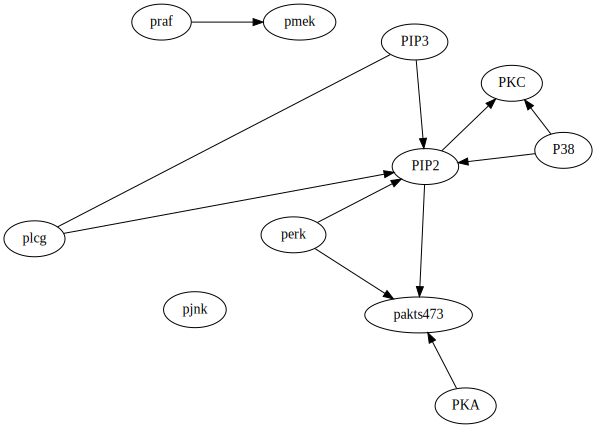

In [22]:
# Experiments 1 and 5, alpha 0.2

data_exp1_5_drop = data_exp1_5.drop(columns='experiment')
tester1_5 = IndependenceTester(data_exp1_5_drop, ParCorr(), alpha=0.2)

G = PC_algorithm(11, tester1_5)
graph_to_graphviz(G, list(data_exp1_5_drop.columns))

test: 0 and 1 given () -> pval=2.0376953059899394e-183
test: 0 and 2 given () -> pval=0.7288925242787185
independence found: 0 and 2 given ()
test: 0 and 3 given () -> pval=0.7124053354557727
independence found: 0 and 3 given ()
test: 0 and 4 given () -> pval=0.791738305990526
independence found: 0 and 4 given ()
test: 0 and 5 given () -> pval=0.10986481189123287
test: 0 and 6 given () -> pval=0.01472987772599981
test: 0 and 7 given () -> pval=0.15894275506361807
test: 0 and 8 given () -> pval=0.5617195629350336
independence found: 0 and 8 given ()
test: 0 and 9 given () -> pval=0.7455552457561689
independence found: 0 and 9 given ()
test: 0 and 10 given () -> pval=0.6894501241406117
independence found: 0 and 10 given ()
test: 1 and 0 given () -> pval=2.0376953059899394e-183
test: 1 and 2 given () -> pval=0.2804036871272833
test: 1 and 3 given () -> pval=0.008173779888968266
test: 1 and 4 given () -> pval=0.4030837010156133
independence found: 1 and 4 given ()
test: 1 and 5 given () ->

test: 3 and 9 given (2,) -> pval=1.8597226377489733e-05
test: 3 and 9 given (4,) -> pval=4.6089293316561754e-07
test: 3 and 9 given (5,) -> pval=3.24011490055977e-09
test: 3 and 9 given (6,) -> pval=1.2873382922209024e-08
test: 3 and 9 given (7,) -> pval=1.892178513947093e-09
test: 3 and 9 given (8,) -> pval=0.00034963402812607925
test: 3 and 9 given (10,) -> pval=1.4395934079399777e-09
test: 3 and 10 given (0,) -> pval=0.18548115853165084
test: 3 and 10 given (1,) -> pval=0.21936850451128864
test: 3 and 10 given (2,) -> pval=0.6051968410739472
independence found: 3 and 10 given (2,)
test: 4 and 2 given (0,) -> pval=1.996103907159019e-36
test: 4 and 2 given (1,) -> pval=1.3977975982252813e-36
test: 4 and 2 given (3,) -> pval=0.0027385884408152403
test: 4 and 2 given (5,) -> pval=6.300937031030442e-34
test: 4 and 2 given (6,) -> pval=1.5159169863834416e-32
test: 4 and 2 given (7,) -> pval=1.9220168427207177e-36
test: 4 and 2 given (8,) -> pval=1.2636016637235148e-35
test: 4 and 2 given 

test: 10 and 8 given (4,) -> pval=2.447541786344942e-10
test: 10 and 8 given (5,) -> pval=1.7750376633682378e-10
test: 10 and 8 given (6,) -> pval=1.3948138412281811e-10
test: 10 and 8 given (7,) -> pval=1.6354947735858618e-10
test: 10 and 8 given (9,) -> pval=4.601796348840058e-19
test: 0 and 1 given (2, 3) -> pval=7.693558001488034e-184
test: 0 and 1 given (2, 4) -> pval=3.1255813753656607e-183
test: 0 and 1 given (2, 5) -> pval=3.2141339974789416e-184
test: 0 and 1 given (2, 6) -> pval=1.118782361082393e-183
test: 0 and 1 given (2, 7) -> pval=4.889890568500318e-183
test: 0 and 1 given (2, 8) -> pval=2.9199798093123912e-183
test: 0 and 1 given (2, 9) -> pval=1.2968054865151182e-183
test: 0 and 1 given (2, 10) -> pval=8.534901874332773e-184
test: 0 and 1 given (3, 4) -> pval=4.829432148269709e-184
test: 0 and 1 given (3, 5) -> pval=1.6167637377371402e-184
test: 0 and 1 given (3, 6) -> pval=8.248533630364456e-184
test: 0 and 1 given (3, 7) -> pval=1.3711391989541289e-183
test: 0 and 1 

test: 2 and 4 given (5, 8) -> pval=3.13356271056286e-33
test: 2 and 4 given (5, 9) -> pval=1.5605579790753384e-32
test: 2 and 4 given (5, 10) -> pval=1.0221053564872686e-33
test: 2 and 4 given (6, 7) -> pval=1.5359789093842084e-32
test: 2 and 4 given (6, 8) -> pval=6.641023012134168e-32
test: 2 and 4 given (6, 9) -> pval=2.7396386375860076e-31
test: 2 and 4 given (6, 10) -> pval=2.637429580521981e-32
test: 2 and 4 given (7, 8) -> pval=1.1600568681839365e-35
test: 2 and 4 given (7, 9) -> pval=6.123511995871988e-35
test: 2 and 4 given (7, 10) -> pval=3.2614734526295e-36
test: 2 and 4 given (8, 9) -> pval=7.03843487897009e-35
test: 2 and 4 given (8, 10) -> pval=1.6819665535919567e-35
test: 2 and 4 given (9, 10) -> pval=1.1473790667086842e-34
test: 2 and 5 given (0, 1) -> pval=1.9428681828987194e-08
test: 2 and 5 given (0, 3) -> pval=0.03134812086662947
test: 2 and 5 given (0, 4) -> pval=5.102942905382656e-06
test: 2 and 5 given (0, 6) -> pval=0.07094496523492684
test: 2 and 5 given (0, 7)

test: 3 and 5 given (2, 8) -> pval=3.2452420415433706e-06
test: 3 and 5 given (2, 9) -> pval=2.5249781243286346e-06
test: 3 and 5 given (2, 10) -> pval=2.234019369597677e-06
test: 3 and 5 given (4, 6) -> pval=0.001995897075280115
test: 3 and 5 given (4, 7) -> pval=4.2367209058665795e-08
test: 3 and 5 given (4, 8) -> pval=2.5513716860555e-08
test: 3 and 5 given (4, 9) -> pval=1.865193470398246e-08
test: 3 and 5 given (4, 10) -> pval=1.4379557069663111e-08
test: 3 and 5 given (6, 7) -> pval=0.005232212058420906
test: 3 and 5 given (6, 8) -> pval=0.00691630680829299
test: 3 and 5 given (6, 9) -> pval=0.010534003898508554
test: 3 and 5 given (6, 10) -> pval=0.005910243213691464
test: 3 and 5 given (7, 8) -> pval=6.459461263318329e-12
test: 3 and 5 given (7, 9) -> pval=6.033189816168639e-12
test: 3 and 5 given (7, 10) -> pval=3.96200507454954e-12
test: 3 and 5 given (8, 9) -> pval=4.2108887603473745e-12
test: 3 and 5 given (8, 10) -> pval=4.545046367293132e-12
test: 3 and 5 given (9, 10) ->

test: 5 and 6 given (1, 4) -> pval=0.0
test: 5 and 6 given (1, 7) -> pval=0.0
test: 5 and 6 given (1, 8) -> pval=0.0
test: 5 and 6 given (1, 9) -> pval=0.0
test: 5 and 6 given (1, 10) -> pval=0.0
test: 5 and 6 given (2, 3) -> pval=0.0
test: 5 and 6 given (2, 4) -> pval=0.0
test: 5 and 6 given (2, 7) -> pval=0.0
test: 5 and 6 given (2, 8) -> pval=0.0
test: 5 and 6 given (2, 9) -> pval=0.0
test: 5 and 6 given (2, 10) -> pval=0.0
test: 5 and 6 given (3, 4) -> pval=0.0
test: 5 and 6 given (3, 7) -> pval=0.0
test: 5 and 6 given (3, 8) -> pval=0.0
test: 5 and 6 given (3, 9) -> pval=0.0
test: 5 and 6 given (3, 10) -> pval=0.0
test: 5 and 6 given (4, 7) -> pval=0.0
test: 5 and 6 given (4, 8) -> pval=0.0
test: 5 and 6 given (4, 9) -> pval=0.0
test: 5 and 6 given (4, 10) -> pval=0.0
test: 5 and 6 given (7, 8) -> pval=0.0
test: 5 and 6 given (7, 9) -> pval=0.0
test: 5 and 6 given (7, 10) -> pval=0.0
test: 5 and 6 given (8, 9) -> pval=0.0
test: 5 and 6 given (8, 10) -> pval=0.0
test: 5 and 6 given

test: 7 and 6 given (3, 4) -> pval=7.301261694174195e-82
test: 7 and 6 given (3, 5) -> pval=1.9709363529882655e-32
test: 7 and 6 given (3, 8) -> pval=1.108427055387297e-81
test: 7 and 6 given (3, 9) -> pval=9.548857882745083e-82
test: 7 and 6 given (3, 10) -> pval=8.305557958858187e-82
test: 7 and 6 given (4, 5) -> pval=7.861043125576884e-31
test: 7 and 6 given (4, 8) -> pval=1.2442383341852338e-80
test: 7 and 6 given (4, 9) -> pval=7.054280264975482e-81
test: 7 and 6 given (4, 10) -> pval=6.0017932235107e-81
test: 7 and 6 given (5, 8) -> pval=3.730709719384856e-30
test: 7 and 6 given (5, 9) -> pval=2.7328731609244986e-30
test: 7 and 6 given (5, 10) -> pval=2.8165867872260894e-30
test: 7 and 6 given (8, 9) -> pval=6.740337397606291e-80
test: 7 and 6 given (8, 10) -> pval=1.0529556663937296e-79
test: 7 and 6 given (9, 10) -> pval=5.079648925652107e-80
test: 8 and 3 given (0, 1) -> pval=2.967370476856128e-07
test: 8 and 3 given (0, 2) -> pval=7.979531674799557e-05
test: 8 and 3 given (0,

test: 10 and 1 given (0, 2) -> pval=0.029657172949233132
test: 10 and 1 given (0, 3) -> pval=0.03379536626037016
test: 10 and 1 given (0, 4) -> pval=0.024758899008477053
test: 10 and 1 given (0, 5) -> pval=0.02833941343936211
test: 10 and 1 given (0, 6) -> pval=0.025484096181086404
test: 10 and 1 given (0, 7) -> pval=0.026704147515749437
test: 10 and 1 given (0, 8) -> pval=0.031194039554991348
test: 10 and 1 given (0, 9) -> pval=0.024273015314442443
test: 10 and 1 given (2, 3) -> pval=0.160774235509549
test: 10 and 1 given (2, 4) -> pval=0.1449961746454624
test: 10 and 1 given (2, 5) -> pval=0.15369131179685763
test: 10 and 1 given (2, 6) -> pval=0.15436446972651807
test: 10 and 1 given (2, 7) -> pval=0.15232128625703384
test: 10 and 1 given (2, 8) -> pval=0.1469291767273948
test: 10 and 1 given (2, 9) -> pval=0.14491303717777632
test: 10 and 1 given (3, 4) -> pval=0.1508687935127139
test: 10 and 1 given (3, 5) -> pval=0.16527856480992853
test: 10 and 1 given (3, 6) -> pval=0.168982690

test: 1 and 0 given (2, 4, 6) -> pval=1.1464797520343902e-183
test: 1 and 0 given (2, 4, 7) -> pval=6.112148880476281e-183
test: 1 and 0 given (2, 4, 8) -> pval=3.5158999873225427e-183
test: 1 and 0 given (2, 4, 9) -> pval=1.5222721570123373e-183
test: 1 and 0 given (2, 4, 10) -> pval=1.0276307799207035e-183
test: 1 and 0 given (2, 5, 6) -> pval=1.9269383772057352e-183
test: 1 and 0 given (2, 5, 7) -> pval=6.179840297716185e-184
test: 1 and 0 given (2, 5, 8) -> pval=3.7955900472901173e-184
test: 1 and 0 given (2, 5, 9) -> pval=1.7007275964453293e-184
test: 1 and 0 given (2, 5, 10) -> pval=1.0995847943207319e-184
test: 1 and 0 given (2, 6, 7) -> pval=1.5176540944183423e-183
test: 1 and 0 given (2, 6, 8) -> pval=1.3129743078234153e-183
test: 1 and 0 given (2, 6, 9) -> pval=6.283792132537235e-184
test: 1 and 0 given (2, 6, 10) -> pval=3.5053839979736626e-184
test: 1 and 0 given (2, 7, 8) -> pval=5.6188239978624895e-183
test: 1 and 0 given (2, 7, 9) -> pval=2.509902424788552e-183
test: 1 a

test: 1 and 10 given (4, 6, 8) -> pval=0.13450792715059048
test: 1 and 10 given (4, 6, 9) -> pval=0.12694242076858447
test: 1 and 10 given (4, 7, 8) -> pval=0.13446654989770546
test: 1 and 10 given (4, 7, 9) -> pval=0.12579502054099953
test: 1 and 10 given (4, 8, 9) -> pval=0.07601494331010758
test: 1 and 10 given (5, 6, 7) -> pval=0.1583471072196535
test: 1 and 10 given (5, 6, 8) -> pval=0.159404395372943
test: 1 and 10 given (5, 6, 9) -> pval=0.1536806116968871
test: 1 and 10 given (5, 7, 8) -> pval=0.14202745364524486
test: 1 and 10 given (5, 7, 9) -> pval=0.1376083603637945
test: 1 and 10 given (5, 8, 9) -> pval=0.08245960924524977
test: 1 and 10 given (6, 7, 8) -> pval=0.13896219230245577
test: 1 and 10 given (6, 7, 9) -> pval=0.13375679536355564
test: 1 and 10 given (6, 8, 9) -> pval=0.08198833549077454
test: 1 and 10 given (7, 8, 9) -> pval=0.08196458931326679
test: 2 and 3 given (0, 1, 4) -> pval=3.8871511273242575e-100
test: 2 and 3 given (0, 1, 5) -> pval=4.026330308636682e-1

test: 2 and 6 given (0, 1, 9) -> pval=1.475357363744536e-14
test: 2 and 6 given (0, 1, 10) -> pval=3.2682480723964957e-15
test: 2 and 6 given (0, 3, 4) -> pval=0.00512340102341696
test: 2 and 6 given (0, 3, 5) -> pval=0.056158728094879935
test: 2 and 6 given (0, 3, 7) -> pval=0.07483344497829844
test: 2 and 6 given (0, 3, 8) -> pval=0.004566893519909461
test: 2 and 6 given (0, 3, 9) -> pval=0.004712965410947653
test: 2 and 6 given (0, 3, 10) -> pval=0.004164771409920951
test: 2 and 6 given (0, 4, 5) -> pval=1.4949842745469099e-07
test: 2 and 6 given (0, 4, 7) -> pval=5.165359999104994e-09
test: 2 and 6 given (0, 4, 8) -> pval=4.3826044573306316e-11
test: 2 and 6 given (0, 4, 9) -> pval=5.356307885225235e-11
test: 2 and 6 given (0, 4, 10) -> pval=2.0804632702245305e-11
test: 2 and 6 given (0, 5, 7) -> pval=1.6994582369011432e-08
test: 2 and 6 given (0, 5, 8) -> pval=1.106734456909537e-08
test: 2 and 6 given (0, 5, 9) -> pval=2.2364335322574262e-08
test: 2 and 6 given (0, 5, 10) -> pval=

test: 3 and 1 given (2, 6, 8) -> pval=0.010009395174313068
test: 3 and 1 given (2, 6, 9) -> pval=0.013937076991451818
test: 3 and 1 given (2, 6, 10) -> pval=0.01097200772945184
test: 3 and 1 given (2, 7, 8) -> pval=0.013847590710959758
test: 3 and 1 given (2, 7, 9) -> pval=0.019177128499931112
test: 3 and 1 given (2, 7, 10) -> pval=0.014930141446036957
test: 3 and 1 given (2, 8, 9) -> pval=0.016956103584226022
test: 3 and 1 given (2, 8, 10) -> pval=0.013407905960615673
test: 3 and 1 given (2, 9, 10) -> pval=0.019979032364362055
test: 3 and 1 given (4, 5, 6) -> pval=0.00027222901187325474
test: 3 and 1 given (4, 5, 7) -> pval=0.001102958841401516
test: 3 and 1 given (4, 5, 8) -> pval=0.0010157441743124961
test: 3 and 1 given (4, 5, 9) -> pval=0.0016931892899355319
test: 3 and 1 given (4, 5, 10) -> pval=0.001151553501486197
test: 3 and 1 given (4, 6, 7) -> pval=0.0005981331894075322
test: 3 and 1 given (4, 6, 8) -> pval=0.0004920991206680861
test: 3 and 1 given (4, 6, 9) -> pval=0.000824

test: 3 and 4 given (2, 6, 10) -> pval=3.34519152998214e-48
test: 3 and 4 given (2, 7, 8) -> pval=1.1772024531350809e-49
test: 3 and 4 given (2, 7, 9) -> pval=3.413160297251806e-49
test: 3 and 4 given (2, 7, 10) -> pval=4.678212728818413e-50
test: 3 and 4 given (2, 8, 9) -> pval=2.893220871640768e-49
test: 3 and 4 given (2, 8, 10) -> pval=1.0628568013810472e-49
test: 3 and 4 given (2, 9, 10) -> pval=3.8024575140004346e-49
test: 3 and 4 given (5, 6, 7) -> pval=9.205769870899534e-77
test: 3 and 4 given (5, 6, 8) -> pval=1.4050799216166594e-76
test: 3 and 4 given (5, 6, 9) -> pval=1.4941481229764632e-75
test: 3 and 4 given (5, 6, 10) -> pval=2.6073615656295546e-77
test: 3 and 4 given (5, 7, 8) -> pval=1.2398851032730054e-77
test: 3 and 4 given (5, 7, 9) -> pval=1.6550516986228614e-76
test: 3 and 4 given (5, 7, 10) -> pval=1.605684324398435e-78
test: 3 and 4 given (5, 8, 9) -> pval=9.581855898037454e-77
test: 3 and 4 given (5, 8, 10) -> pval=8.895702292397985e-78
test: 3 and 4 given (5, 9,

test: 3 and 6 given (4, 7, 10) -> pval=2.1284451214360867e-19
test: 3 and 6 given (4, 8, 9) -> pval=9.051170222942248e-18
test: 3 and 6 given (4, 8, 10) -> pval=6.231387796798247e-18
test: 3 and 6 given (4, 9, 10) -> pval=6.626972803257173e-18
test: 3 and 6 given (5, 7, 8) -> pval=9.579271436244103e-17
test: 3 and 6 given (5, 7, 9) -> pval=4.147890977704187e-16
test: 3 and 6 given (5, 7, 10) -> pval=3.976602486314765e-17
test: 3 and 6 given (5, 8, 9) -> pval=4.987914488303945e-14
test: 3 and 6 given (5, 8, 10) -> pval=1.5117810011345255e-14
test: 3 and 6 given (5, 9, 10) -> pval=3.706169397795716e-14
test: 3 and 6 given (7, 8, 9) -> pval=5.7251229775057e-25
test: 3 and 6 given (7, 8, 10) -> pval=1.956356680955266e-25
test: 3 and 6 given (7, 9, 10) -> pval=4.692603375072798e-25
test: 3 and 6 given (8, 9, 10) -> pval=3.473470210363889e-23
test: 3 and 8 given (0, 1, 2) -> pval=8.865000801076572e-05
test: 3 and 8 given (0, 1, 4) -> pval=5.575505827962512e-06
test: 3 and 8 given (0, 1, 5) -

test: 4 and 2 given (1, 3, 6) -> pval=0.0033761312038909407
test: 4 and 2 given (1, 3, 7) -> pval=0.0026459775772797443
test: 4 and 2 given (1, 3, 8) -> pval=0.0029525917923793896
test: 4 and 2 given (1, 3, 9) -> pval=0.0032103153415780792
test: 4 and 2 given (1, 3, 10) -> pval=0.0031581628384241755
test: 4 and 2 given (1, 5, 6) -> pval=8.42463417880106e-33
test: 4 and 2 given (1, 5, 7) -> pval=2.33139886983087e-34
test: 4 and 2 given (1, 5, 8) -> pval=2.2568089271618393e-33
test: 4 and 2 given (1, 5, 9) -> pval=1.1429139348936653e-32
test: 4 and 2 given (1, 5, 10) -> pval=7.374340127841536e-34
test: 4 and 2 given (1, 6, 7) -> pval=1.0792370549459901e-32
test: 4 and 2 given (1, 6, 8) -> pval=4.7578192029786705e-32
test: 4 and 2 given (1, 6, 9) -> pval=1.97967200336221e-31
test: 4 and 2 given (1, 6, 10) -> pval=1.8880734963347335e-32
test: 4 and 2 given (1, 7, 8) -> pval=8.034881629063251e-36
test: 4 and 2 given (1, 7, 9) -> pval=4.2856823929068363e-35
test: 4 and 2 given (1, 7, 10) -> 

test: 5 and 3 given (1, 9, 10) -> pval=4.663632448508324e-12
test: 5 and 3 given (2, 4, 6) -> pval=0.013305332424934892
test: 5 and 3 given (2, 4, 7) -> pval=2.0610888412017927e-05
test: 5 and 3 given (2, 4, 8) -> pval=9.624634043942273e-05
test: 5 and 3 given (2, 4, 9) -> pval=7.714701153284214e-05
test: 5 and 3 given (2, 4, 10) -> pval=7.232708392151785e-05
test: 5 and 3 given (2, 6, 7) -> pval=0.03004053903070893
test: 5 and 3 given (2, 6, 8) -> pval=0.03826516925286716
test: 5 and 3 given (2, 6, 9) -> pval=0.048731896311999305
test: 5 and 3 given (2, 6, 10) -> pval=0.03674582805120831
test: 5 and 3 given (2, 7, 8) -> pval=3.309972476056721e-07
test: 5 and 3 given (2, 7, 9) -> pval=2.94635187721672e-07
test: 5 and 3 given (2, 7, 10) -> pval=2.66884996545859e-07
test: 5 and 3 given (2, 8, 9) -> pval=2.9803446877275366e-06
test: 5 and 3 given (2, 8, 10) -> pval=3.26354599226881e-06
test: 5 and 3 given (2, 9, 10) -> pval=2.5867332033017894e-06
test: 5 and 3 given (4, 6, 7) -> pval=0.00

test: 6 and 2 given (3, 7, 10) -> pval=0.07403843967487718
test: 6 and 2 given (3, 8, 9) -> pval=0.0049453390712477265
test: 6 and 2 given (3, 8, 10) -> pval=0.004521721461996744
test: 6 and 2 given (3, 9, 10) -> pval=0.0046815239999500316
test: 6 and 2 given (4, 5, 7) -> pval=8.306728665865445e-07
test: 6 and 2 given (4, 5, 8) -> pval=2.438472394449544e-07
test: 6 and 2 given (4, 5, 9) -> pval=3.9625517995374535e-07
test: 6 and 2 given (4, 5, 10) -> pval=1.3870768292819333e-07
test: 6 and 2 given (4, 7, 8) -> pval=9.065312148893798e-09
test: 6 and 2 given (4, 7, 9) -> pval=1.280217422170607e-08
test: 6 and 2 given (4, 7, 10) -> pval=5.5485223444066946e-09
test: 6 and 2 given (4, 8, 9) -> pval=7.496818431292699e-11
test: 6 and 2 given (4, 8, 10) -> pval=5.080710627155064e-11
test: 6 and 2 given (4, 9, 10) -> pval=6.128456253959798e-11
test: 6 and 2 given (5, 7, 8) -> pval=2.8049059173647562e-08
test: 6 and 2 given (5, 7, 9) -> pval=6.246317117689018e-08
test: 6 and 2 given (5, 7, 10) -

test: 6 and 5 given (8, 9, 10) -> pval=0.0
test: 6 and 7 given (0, 1, 2) -> pval=1.9523613749510434e-77
test: 6 and 7 given (0, 1, 3) -> pval=2.3567222531474545e-81
test: 6 and 7 given (0, 1, 4) -> pval=1.3296522134354968e-80
test: 6 and 7 given (0, 1, 5) -> pval=4.861856661175129e-30
test: 6 and 7 given (0, 1, 8) -> pval=2.2520161568916457e-79
test: 6 and 7 given (0, 1, 9) -> pval=1.1461946342927826e-79
test: 6 and 7 given (0, 1, 10) -> pval=1.0193575236110345e-79
test: 6 and 7 given (0, 2, 3) -> pval=3.1681089429864573e-80
test: 6 and 7 given (0, 2, 4) -> pval=3.4478831584450446e-78
test: 6 and 7 given (0, 2, 5) -> pval=9.844227739298776e-30
test: 6 and 7 given (0, 2, 8) -> pval=3.8157249595374465e-77
test: 6 and 7 given (0, 2, 9) -> pval=2.379330279967486e-77
test: 6 and 7 given (0, 2, 10) -> pval=2.4086398768874822e-77
test: 6 and 7 given (0, 3, 4) -> pval=2.1629107479252755e-81
test: 6 and 7 given (0, 3, 5) -> pval=2.9261529271203143e-32
test: 6 and 7 given (0, 3, 8) -> pval=3.204

test: 8 and 3 given (1, 5, 6) -> pval=1.2667613921877576e-06
test: 8 and 3 given (1, 5, 7) -> pval=5.944322171423067e-07
test: 8 and 3 given (1, 5, 9) -> pval=0.09997170696482463
test: 8 and 3 given (1, 5, 10) -> pval=1.2544203634586246e-06
test: 8 and 3 given (1, 6, 7) -> pval=9.193438024315939e-07
test: 8 and 3 given (1, 6, 9) -> pval=0.09327160921243931
test: 8 and 3 given (1, 6, 10) -> pval=2.7416813119191104e-06
test: 8 and 3 given (1, 7, 9) -> pval=0.08031214519902048
test: 8 and 3 given (1, 7, 10) -> pval=6.580011201458019e-07
test: 8 and 3 given (1, 9, 10) -> pval=0.1232746735126557
test: 8 and 3 given (2, 4, 5) -> pval=0.0003162332539736333
test: 8 and 3 given (2, 4, 6) -> pval=0.0003970360002338397
test: 8 and 3 given (2, 4, 7) -> pval=0.00023394759295013146
test: 8 and 3 given (2, 4, 9) -> pval=0.09177229564621409
test: 8 and 3 given (2, 4, 10) -> pval=0.00022871614081289852
test: 8 and 3 given (2, 5, 6) -> pval=0.0001517185098593841
test: 8 and 3 given (2, 5, 7) -> pval=9.9

test: 8 and 10 given (2, 5, 7) -> pval=3.4124170097690364e-10
test: 8 and 10 given (2, 5, 9) -> pval=6.083755609440618e-19
test: 8 and 10 given (2, 6, 7) -> pval=2.9607929564801855e-10
test: 8 and 10 given (2, 6, 9) -> pval=5.286002559125023e-19
test: 8 and 10 given (2, 7, 9) -> pval=5.645212446944393e-19
test: 8 and 10 given (3, 4, 5) -> pval=3.5941351819620195e-10
test: 8 and 10 given (3, 4, 6) -> pval=3.245941338710425e-10
test: 8 and 10 given (3, 4, 7) -> pval=3.525560275607347e-10
test: 8 and 10 given (3, 4, 9) -> pval=6.682158248229367e-19
test: 8 and 10 given (3, 5, 6) -> pval=3.301443120019362e-10
test: 8 and 10 given (3, 5, 7) -> pval=3.5416486648305357e-10
test: 8 and 10 given (3, 5, 9) -> pval=7.781619286174178e-19
test: 8 and 10 given (3, 6, 7) -> pval=3.4333731467043047e-10
test: 8 and 10 given (3, 6, 9) -> pval=7.114162939193467e-19
test: 8 and 10 given (3, 7, 9) -> pval=7.440622510607895e-19
test: 8 and 10 given (4, 5, 6) -> pval=1.9953076709049577e-10
test: 8 and 10 giv

test: 9 and 3 given (2, 6, 8) -> pval=0.024843746559241077
test: 9 and 3 given (2, 6, 10) -> pval=3.472134760750831e-05
test: 9 and 3 given (2, 7, 8) -> pval=0.02093934938523041
test: 9 and 3 given (2, 7, 10) -> pval=1.7650205347964143e-05
test: 9 and 3 given (2, 8, 10) -> pval=0.019858391302816865
test: 9 and 3 given (4, 5, 6) -> pval=2.3936711225581893e-06
test: 9 and 3 given (4, 5, 7) -> pval=6.171313754546694e-07
test: 9 and 3 given (4, 5, 8) -> pval=0.004922762995369921
test: 9 and 3 given (4, 5, 10) -> pval=5.717623554927077e-07
test: 9 and 3 given (4, 6, 7) -> pval=1.6969352971084567e-06
test: 9 and 3 given (4, 6, 8) -> pval=0.007897097444914833
test: 9 and 3 given (4, 6, 10) -> pval=1.4696847192332801e-06
test: 9 and 3 given (4, 7, 8) -> pval=0.005157707037519433
test: 9 and 3 given (4, 7, 10) -> pval=4.5924880462523905e-07
test: 9 and 3 given (4, 8, 10) -> pval=0.004618697135707603
test: 9 and 3 given (5, 6, 7) -> pval=2.1307120416712174e-08
test: 9 and 3 given (5, 6, 8) -> pv

test: 10 and 8 given (0, 5, 6) -> pval=1.3892531726615437e-10
test: 10 and 8 given (0, 5, 7) -> pval=1.8364243068339084e-10
test: 10 and 8 given (0, 5, 9) -> pval=5.428228336903285e-19
test: 10 and 8 given (0, 6, 7) -> pval=1.5089019205081416e-10
test: 10 and 8 given (0, 6, 9) -> pval=4.675246124731816e-19
test: 10 and 8 given (0, 7, 9) -> pval=4.9722243566722995e-19
test: 10 and 8 given (1, 2, 3) -> pval=3.557740538709421e-10
test: 10 and 8 given (1, 2, 4) -> pval=3.890771934362883e-10
test: 10 and 8 given (1, 2, 5) -> pval=3.3710374076882583e-10
test: 10 and 8 given (1, 2, 6) -> pval=2.806234101716207e-10
test: 10 and 8 given (1, 2, 7) -> pval=3.2546457970098963e-10
test: 10 and 8 given (1, 2, 9) -> pval=3.9418338145659354e-19
test: 10 and 8 given (1, 3, 4) -> pval=3.2409336380421784e-10
test: 10 and 8 given (1, 3, 5) -> pval=3.307341884103002e-10
test: 10 and 8 given (1, 3, 6) -> pval=2.999289667489252e-10
test: 10 and 8 given (1, 3, 7) -> pval=3.2549254132231885e-10
test: 10 and 8 

test: 1 and 0 given (2, 5, 6, 7) -> pval=2.596734869010857e-183
test: 1 and 0 given (2, 5, 6, 8) -> pval=2.2613587846143164e-183
test: 1 and 0 given (2, 5, 6, 9) -> pval=1.0583369469623378e-183
test: 1 and 0 given (2, 5, 6, 10) -> pval=6.302818221956643e-184
test: 1 and 0 given (2, 5, 7, 8) -> pval=7.240906377485456e-184
test: 1 and 0 given (2, 5, 7, 9) -> pval=3.271621717246604e-184
test: 1 and 0 given (2, 5, 7, 10) -> pval=2.1164022296436508e-184
test: 1 and 0 given (2, 5, 8, 9) -> pval=2.373812079504963e-184
test: 1 and 0 given (2, 5, 8, 10) -> pval=1.4585263289410738e-184
test: 1 and 0 given (2, 5, 9, 10) -> pval=5.5214080999105407e-185
test: 1 and 0 given (2, 6, 7, 8) -> pval=1.7722624364336729e-183
test: 1 and 0 given (2, 6, 7, 9) -> pval=8.553985265116002e-184
test: 1 and 0 given (2, 6, 7, 10) -> pval=4.739639357426324e-184
test: 1 and 0 given (2, 6, 8, 9) -> pval=8.81285180022069e-184
test: 1 and 0 given (2, 6, 8, 10) -> pval=4.6100207594373944e-184
test: 1 and 0 given (2, 6, 9

test: 1 and 10 given (0, 2, 4, 7) -> pval=0.02773691264641928
test: 1 and 10 given (0, 2, 4, 8) -> pval=0.03177862765663304
test: 1 and 10 given (0, 2, 4, 9) -> pval=0.024605651605633258
test: 1 and 10 given (0, 2, 5, 6) -> pval=0.03267090149928422
test: 1 and 10 given (0, 2, 5, 7) -> pval=0.030664956003690402
test: 1 and 10 given (0, 2, 5, 8) -> pval=0.033646506034367855
test: 1 and 10 given (0, 2, 5, 9) -> pval=0.027439156206128024
test: 1 and 10 given (0, 2, 6, 7) -> pval=0.02726922375674786
test: 1 and 10 given (0, 2, 6, 8) -> pval=0.030678307356990776
test: 1 and 10 given (0, 2, 6, 9) -> pval=0.02495736382651727
test: 1 and 10 given (0, 2, 7, 8) -> pval=0.03351231564914695
test: 1 and 10 given (0, 2, 7, 9) -> pval=0.026695775157130796
test: 1 and 10 given (0, 2, 8, 9) -> pval=0.014018249034075381
test: 1 and 10 given (0, 3, 4, 5) -> pval=0.030258550047717703
test: 1 and 10 given (0, 3, 4, 6) -> pval=0.028219866457298164
test: 1 and 10 given (0, 3, 4, 7) -> pval=0.02965997386093602

test: 2 and 3 given (4, 6, 9, 10) -> pval=2.9497141616221744e-90
test: 2 and 3 given (4, 7, 8, 9) -> pval=1.64584642324332e-97
test: 2 and 3 given (4, 7, 8, 10) -> pval=1.7636291166798553e-98
test: 2 and 3 given (4, 7, 9, 10) -> pval=2.1777036664671833e-97
test: 2 and 3 given (4, 8, 9, 10) -> pval=6.75578459513689e-98
test: 2 and 3 given (5, 6, 7, 8) -> pval=2.495454269186208e-119
test: 2 and 3 given (5, 6, 7, 9) -> pval=4.469190203506552e-118
test: 2 and 3 given (5, 6, 7, 10) -> pval=6.767929865215044e-121
test: 2 and 3 given (5, 6, 8, 9) -> pval=2.232503475874421e-117
test: 2 and 3 given (5, 6, 8, 10) -> pval=1.3865468735872663e-118
test: 2 and 3 given (5, 6, 9, 10) -> pval=5.4441087967892524e-117
test: 2 and 3 given (5, 7, 8, 9) -> pval=4.8186805513130975e-124
test: 2 and 3 given (5, 7, 8, 10) -> pval=1.334730495838932e-125
test: 2 and 3 given (5, 7, 9, 10) -> pval=9.655888493676022e-124
test: 2 and 3 given (5, 8, 9, 10) -> pval=4.028982321300582e-123
test: 2 and 3 given (6, 7, 8, 9

test: 2 and 6 given (1, 4, 7, 9) -> pval=1.3273186403321419e-08
test: 2 and 6 given (1, 4, 7, 10) -> pval=5.850746347699487e-09
test: 2 and 6 given (1, 4, 8, 9) -> pval=7.201191951710336e-11
test: 2 and 6 given (1, 4, 8, 10) -> pval=4.9323063079632336e-11
test: 2 and 6 given (1, 4, 9, 10) -> pval=5.910740351408847e-11
test: 2 and 6 given (1, 5, 7, 8) -> pval=2.2250130731516866e-08
test: 2 and 6 given (1, 5, 7, 9) -> pval=5.0748390966008304e-08
test: 2 and 6 given (1, 5, 7, 10) -> pval=1.1490274731061291e-08
test: 2 and 6 given (1, 5, 8, 9) -> pval=2.101226727707658e-08
test: 2 and 6 given (1, 5, 8, 10) -> pval=8.008196162467242e-09
test: 2 and 6 given (1, 5, 9, 10) -> pval=1.5328510627156347e-08
test: 2 and 6 given (1, 7, 8, 9) -> pval=2.6908686630219335e-12
test: 2 and 6 given (1, 7, 8, 10) -> pval=1.21216184234643e-12
test: 2 and 6 given (1, 7, 9, 10) -> pval=2.2487139980245496e-12
test: 2 and 6 given (1, 8, 9, 10) -> pval=1.3503497801221856e-14
test: 2 and 6 given (3, 4, 5, 7) -> pv

test: 3 and 1 given (0, 6, 8, 9) -> pval=0.009944370433619213
test: 3 and 1 given (0, 6, 8, 10) -> pval=0.007067922827324658
test: 3 and 1 given (0, 6, 9, 10) -> pval=0.01394268176140487
test: 3 and 1 given (0, 7, 8, 9) -> pval=0.0038410067729395237
test: 3 and 1 given (0, 7, 8, 10) -> pval=0.002461727040497454
test: 3 and 1 given (0, 7, 9, 10) -> pval=0.005448508697553911
test: 3 and 1 given (0, 8, 9, 10) -> pval=0.004629633431797841
test: 3 and 1 given (2, 4, 5, 6) -> pval=0.000932090789743524
test: 3 and 1 given (2, 4, 5, 7) -> pval=0.0028921751435952376
test: 3 and 1 given (2, 4, 5, 8) -> pval=0.0024028242950032627
test: 3 and 1 given (2, 4, 5, 9) -> pval=0.00343877637462143
test: 3 and 1 given (2, 4, 5, 10) -> pval=0.0025399512613626927
test: 3 and 1 given (2, 4, 6, 7) -> pval=0.0017966652337965303
test: 3 and 1 given (2, 4, 6, 8) -> pval=0.001437666074554522
test: 3 and 1 given (2, 4, 6, 9) -> pval=0.0020613488860249823
test: 3 and 1 given (2, 4, 6, 10) -> pval=0.0015362515393141

test: 3 and 4 given (0, 2, 6, 7) -> pval=1.7075441698990227e-47
test: 3 and 4 given (0, 2, 6, 8) -> pval=6.859181696008482e-48
test: 3 and 4 given (0, 2, 6, 9) -> pval=1.9203889035885011e-47
test: 3 and 4 given (0, 2, 6, 10) -> pval=3.2825776431152717e-48
test: 3 and 4 given (0, 2, 7, 8) -> pval=1.189276156696217e-49
test: 3 and 4 given (0, 2, 7, 9) -> pval=3.458213318702691e-49
test: 3 and 4 given (0, 2, 7, 10) -> pval=4.766056780399066e-50
test: 3 and 4 given (0, 2, 8, 9) -> pval=2.9259855813451928e-49
test: 3 and 4 given (0, 2, 8, 10) -> pval=1.0761827719421728e-49
test: 3 and 4 given (0, 2, 9, 10) -> pval=3.859595592691019e-49
test: 3 and 4 given (0, 5, 6, 7) -> pval=9.140696740668957e-77
test: 3 and 4 given (0, 5, 6, 8) -> pval=1.4007955668459032e-76
test: 3 and 4 given (0, 5, 6, 9) -> pval=1.4903743811505168e-75
test: 3 and 4 given (0, 5, 6, 10) -> pval=2.6104011134417414e-77
test: 3 and 4 given (0, 5, 7, 8) -> pval=1.256242337586429e-77
test: 3 and 4 given (0, 5, 7, 9) -> pval=1

test: 3 and 5 given (6, 8, 9, 10) -> pval=0.008471966949713939
test: 3 and 5 given (7, 8, 9, 10) -> pval=7.412430232294938e-12
test: 3 and 6 given (0, 1, 2, 4) -> pval=4.0494884089117915e-10
test: 3 and 6 given (0, 1, 2, 5) -> pval=2.022818161793059e-08
test: 3 and 6 given (0, 1, 2, 7) -> pval=6.4871790060547386e-15
test: 3 and 6 given (0, 1, 2, 8) -> pval=8.783793986062598e-12
test: 3 and 6 given (0, 1, 2, 9) -> pval=8.853666598990501e-12
test: 3 and 6 given (0, 1, 2, 10) -> pval=4.634764656396062e-12
test: 3 and 6 given (0, 1, 4, 5) -> pval=8.445662583139286e-14
test: 3 and 6 given (0, 1, 4, 7) -> pval=6.346627703382832e-19
test: 3 and 6 given (0, 1, 4, 8) -> pval=1.2699870384715962e-17
test: 3 and 6 given (0, 1, 4, 9) -> pval=1.3843858998491825e-17
test: 3 and 6 given (0, 1, 4, 10) -> pval=4.167467943466366e-18
test: 3 and 6 given (0, 1, 5, 7) -> pval=3.1643811798003976e-17
test: 3 and 6 given (0, 1, 5, 8) -> pval=8.227122820588765e-15
test: 3 and 6 given (0, 1, 5, 9) -> pval=2.5963

test: 3 and 8 given (2, 4, 6, 9) -> pval=0.10612698731529072
test: 3 and 8 given (2, 4, 6, 10) -> pval=0.00041680792319257945
test: 3 and 8 given (2, 4, 7, 9) -> pval=0.09140424821660482
test: 3 and 8 given (2, 4, 7, 10) -> pval=0.00022763912056640817
test: 3 and 8 given (2, 4, 9, 10) -> pval=0.09779420641020783
test: 3 and 8 given (2, 5, 6, 7) -> pval=0.00011179122786097344
test: 3 and 8 given (2, 5, 6, 9) -> pval=0.11640234338743531
test: 3 and 8 given (2, 5, 6, 10) -> pval=0.00019859624302266844
test: 3 and 8 given (2, 5, 7, 9) -> pval=0.11854751762584624
test: 3 and 8 given (2, 5, 7, 10) -> pval=0.00011285439466059751
test: 3 and 8 given (2, 5, 9, 10) -> pval=0.1577134467795363
test: 3 and 8 given (2, 6, 7, 9) -> pval=0.10126106960360635
test: 3 and 8 given (2, 6, 7, 10) -> pval=0.0001454949747355066
test: 3 and 8 given (2, 6, 9, 10) -> pval=0.16078207120474355
test: 3 and 8 given (2, 7, 9, 10) -> pval=0.12949211942397285
test: 3 and 8 given (4, 5, 6, 7) -> pval=1.1127399808044544e

test: 4 and 2 given (1, 3, 8, 10) -> pval=0.0031559465027206704
test: 4 and 2 given (1, 3, 9, 10) -> pval=0.003461515017347353
test: 4 and 2 given (1, 5, 6, 7) -> pval=8.654755612517819e-33
test: 4 and 2 given (1, 5, 6, 8) -> pval=3.705748539171245e-32
test: 4 and 2 given (1, 5, 6, 9) -> pval=1.5094558994141467e-31
test: 4 and 2 given (1, 5, 6, 10) -> pval=1.4929323618691e-32
test: 4 and 2 given (1, 5, 7, 8) -> pval=1.1844393443184924e-33
test: 4 and 2 given (1, 5, 7, 9) -> pval=5.979628280556944e-33
test: 4 and 2 given (1, 5, 7, 10) -> pval=3.8090081721221855e-34
test: 4 and 2 given (1, 5, 8, 9) -> pval=1.20612184735111e-32
test: 4 and 2 given (1, 5, 8, 10) -> pval=2.9522789198830766e-33
test: 4 and 2 given (1, 5, 9, 10) -> pval=1.942398898014402e-32
test: 4 and 2 given (1, 6, 7, 8) -> pval=4.878614383468454e-32
test: 4 and 2 given (1, 6, 7, 9) -> pval=1.9381048202889933e-31
test: 4 and 2 given (1, 6, 7, 10) -> pval=1.89788603200352e-32
test: 4 and 2 given (1, 6, 8, 9) -> pval=2.09558

test: 5 and 3 given (0, 4, 6, 7) -> pval=0.00143122578490245
test: 5 and 3 given (0, 4, 6, 8) -> pval=0.0018258765087154577
test: 5 and 3 given (0, 4, 6, 9) -> pval=0.0027556234047865437
test: 5 and 3 given (0, 4, 6, 10) -> pval=0.0016258652925639318
test: 5 and 3 given (0, 4, 7, 8) -> pval=5.2796736400629235e-08
test: 5 and 3 given (0, 4, 7, 9) -> pval=4.6561045574144594e-08
test: 5 and 3 given (0, 4, 7, 10) -> pval=3.969189194561446e-08
test: 5 and 3 given (0, 4, 8, 9) -> pval=2.007506755930654e-08
test: 5 and 3 given (0, 4, 8, 10) -> pval=2.212121416846545e-08
test: 5 and 3 given (0, 4, 9, 10) -> pval=1.6793999059555993e-08
test: 5 and 3 given (0, 6, 7, 8) -> pval=0.0048020670176211625
test: 5 and 3 given (0, 6, 7, 9) -> pval=0.007519015487965055
test: 5 and 3 given (0, 6, 7, 10) -> pval=0.0041060962590211405
test: 5 and 3 given (0, 6, 8, 9) -> pval=0.00894085079793192
test: 5 and 3 given (0, 6, 8, 10) -> pval=0.00592891628403983
test: 5 and 3 given (0, 6, 9, 10) -> pval=0.008324725

test: 5 and 6 given (4, 7, 8, 10) -> pval=0.0
test: 5 and 6 given (4, 7, 9, 10) -> pval=0.0
test: 5 and 6 given (4, 8, 9, 10) -> pval=0.0
test: 5 and 6 given (7, 8, 9, 10) -> pval=0.0
test: 6 and 2 given (0, 1, 3, 4) -> pval=0.004905699196115839
test: 6 and 2 given (0, 1, 3, 5) -> pval=0.05911317733269999
test: 6 and 2 given (0, 1, 3, 7) -> pval=0.07161413575498542
test: 6 and 2 given (0, 1, 3, 8) -> pval=0.00431720766959444
test: 6 and 2 given (0, 1, 3, 9) -> pval=0.004444837961007963
test: 6 and 2 given (0, 1, 3, 10) -> pval=0.003907241058835538
test: 6 and 2 given (0, 1, 4, 5) -> pval=1.3700946383010806e-07
test: 6 and 2 given (0, 1, 4, 7) -> pval=7.482142797527769e-09
test: 6 and 2 given (0, 1, 4, 8) -> pval=6.324492226245883e-11
test: 6 and 2 given (0, 1, 4, 9) -> pval=7.390739551185997e-11
test: 6 and 2 given (0, 1, 4, 10) -> pval=3.0243074505070874e-11
test: 6 and 2 given (0, 1, 5, 7) -> pval=1.628493642619031e-08
test: 6 and 2 given (0, 1, 5, 8) -> pval=1.0365894538905609e-08
t

test: 6 and 3 given (1, 4, 7, 10) -> pval=2.0705266046746446e-19
test: 6 and 3 given (1, 4, 8, 9) -> pval=6.505703353382112e-18
test: 6 and 3 given (1, 4, 8, 10) -> pval=4.60023201738857e-18
test: 6 and 3 given (1, 4, 9, 10) -> pval=4.82925101259196e-18
test: 6 and 3 given (1, 5, 7, 8) -> pval=3.685496518772338e-17
test: 6 and 3 given (1, 5, 7, 9) -> pval=1.6857817980576046e-16
test: 6 and 3 given (1, 5, 7, 10) -> pval=1.592738051729844e-17
test: 6 and 3 given (1, 5, 8, 9) -> pval=1.8361285716327388e-14
test: 6 and 3 given (1, 5, 8, 10) -> pval=5.562709918923504e-15
test: 6 and 3 given (1, 5, 9, 10) -> pval=1.4521322242389118e-14
test: 6 and 3 given (1, 7, 8, 9) -> pval=5.108198592380174e-25
test: 6 and 3 given (1, 7, 8, 10) -> pval=1.81659764975387e-25
test: 6 and 3 given (1, 7, 9, 10) -> pval=4.273949034452302e-25
test: 6 and 3 given (1, 8, 9, 10) -> pval=2.5405577716667867e-23
test: 6 and 3 given (2, 4, 5, 7) -> pval=5.748551818363061e-10
test: 6 and 3 given (2, 4, 5, 8) -> pval=4.1

test: 6 and 7 given (0, 2, 3, 10) -> pval=3.2802123591096865e-80
test: 6 and 7 given (0, 2, 4, 5) -> pval=5.3101462321532896e-30
test: 6 and 7 given (0, 2, 4, 8) -> pval=5.627034875485487e-78
test: 6 and 7 given (0, 2, 4, 9) -> pval=3.7491087092167646e-78
test: 6 and 7 given (0, 2, 4, 10) -> pval=3.5774516935022063e-78
test: 6 and 7 given (0, 2, 5, 8) -> pval=1.1428715122239877e-29
test: 6 and 7 given (0, 2, 5, 9) -> pval=9.331683959381494e-30
test: 6 and 7 given (0, 2, 5, 10) -> pval=9.62187646281093e-30
test: 6 and 7 given (0, 2, 8, 9) -> pval=3.0842614217274397e-77
test: 6 and 7 given (0, 2, 8, 10) -> pval=4.197423331545426e-77
test: 6 and 7 given (0, 2, 9, 10) -> pval=2.513321355260561e-77
test: 6 and 7 given (0, 3, 4, 5) -> pval=3.6587990298492333e-32
test: 6 and 7 given (0, 3, 4, 8) -> pval=2.8777948062115956e-81
test: 6 and 7 given (0, 3, 4, 9) -> pval=2.5274618327418504e-81
test: 6 and 7 given (0, 3, 4, 10) -> pval=2.1916828854492556e-81
test: 6 and 7 given (0, 3, 5, 8) -> pval

test: 7 and 6 given (3, 4, 5, 10) -> pval=2.257087053175563e-32
test: 7 and 6 given (3, 4, 8, 9) -> pval=9.63122718533654e-82
test: 7 and 6 given (3, 4, 8, 10) -> pval=1.0668176374170147e-81
test: 7 and 6 given (3, 4, 9, 10) -> pval=8.687543423170926e-82
test: 7 and 6 given (3, 5, 8, 9) -> pval=1.7068478354765868e-32
test: 7 and 6 given (3, 5, 8, 10) -> pval=2.087198884128563e-32
test: 7 and 6 given (3, 5, 9, 10) -> pval=1.9941292690193928e-32
test: 7 and 6 given (3, 8, 9, 10) -> pval=1.1979569770369717e-81
test: 7 and 6 given (4, 5, 8, 9) -> pval=7.243240502709343e-31
test: 7 and 6 given (4, 5, 8, 10) -> pval=1.0123682519994106e-30
test: 7 and 6 given (4, 5, 9, 10) -> pval=7.7019491582133185e-31
test: 7 and 6 given (4, 8, 9, 10) -> pval=1.108722940135743e-80
test: 7 and 6 given (5, 8, 9, 10) -> pval=2.6531943681123096e-30
test: 8 and 3 given (0, 1, 2, 4) -> pval=0.00026203174073926547
test: 8 and 3 given (0, 1, 2, 5) -> pval=0.00012792132251982129
test: 8 and 3 given (0, 1, 2, 6) -> p

test: 8 and 9 given (1, 2, 3, 6) -> pval=1.4417531307828831e-182
test: 8 and 9 given (1, 2, 3, 7) -> pval=1.0714141205227715e-182
test: 8 and 9 given (1, 2, 3, 10) -> pval=2.2176040570579516e-191
test: 8 and 9 given (1, 2, 4, 5) -> pval=5.6463474833883356e-185
test: 8 and 9 given (1, 2, 4, 6) -> pval=9.321983047974664e-185
test: 8 and 9 given (1, 2, 4, 7) -> pval=4.829915041577913e-185
test: 8 and 9 given (1, 2, 4, 10) -> pval=7.891430594308133e-194
test: 8 and 9 given (1, 2, 5, 6) -> pval=2.6196329326952672e-185
test: 8 and 9 given (1, 2, 5, 7) -> pval=1.910023345005118e-185
test: 8 and 9 given (1, 2, 5, 10) -> pval=3.827750408761493e-194
test: 8 and 9 given (1, 2, 6, 7) -> pval=2.4699704871205093e-185
test: 8 and 9 given (1, 2, 6, 10) -> pval=6.768447012417733e-194
test: 8 and 9 given (1, 2, 7, 10) -> pval=2.827927588937595e-194
test: 8 and 9 given (1, 3, 4, 5) -> pval=8.10120770872996e-183
test: 8 and 9 given (1, 3, 4, 6) -> pval=1.0480433188077851e-182
test: 8 and 9 given (1, 3, 4,

test: 9 and 2 given (0, 1, 5, 10) -> pval=1.3767093568398039e-05
test: 9 and 2 given (0, 1, 6, 7) -> pval=4.075017443427895e-05
test: 9 and 2 given (0, 1, 6, 8) -> pval=0.0052890985725501894
test: 9 and 2 given (0, 1, 6, 10) -> pval=3.425857364529687e-05
test: 9 and 2 given (0, 1, 7, 8) -> pval=0.002824971984317407
test: 9 and 2 given (0, 1, 7, 10) -> pval=1.005392314033489e-05
test: 9 and 2 given (0, 1, 8, 10) -> pval=0.0016498548503969775
test: 9 and 2 given (0, 3, 4, 5) -> pval=0.18678348535710168
test: 9 and 2 given (0, 3, 4, 6) -> pval=0.19967603017644536
test: 9 and 2 given (0, 3, 4, 7) -> pval=0.19262601202777696
test: 9 and 2 given (0, 3, 4, 8) -> pval=0.24059036922377014
test: 9 and 2 given (0, 3, 4, 10) -> pval=0.17862818351846046
test: 9 and 2 given (0, 3, 5, 6) -> pval=0.1845892701991446
test: 9 and 2 given (0, 3, 5, 7) -> pval=0.17408477192686456
test: 9 and 2 given (0, 3, 5, 8) -> pval=0.20661034794286795
test: 9 and 2 given (0, 3, 5, 10) -> pval=0.16223113998962854
test:

test: 9 and 3 given (2, 4, 5, 8) -> pval=0.05743401661637902
test: 9 and 3 given (2, 4, 5, 10) -> pval=0.00017793752772629016
test: 9 and 3 given (2, 4, 6, 7) -> pval=0.00029425204966159027
test: 9 and 3 given (2, 4, 6, 8) -> pval=0.07075446645983118
test: 9 and 3 given (2, 4, 6, 10) -> pval=0.00027122371638844945
test: 9 and 3 given (2, 4, 7, 8) -> pval=0.06294685238113658
test: 9 and 3 given (2, 4, 7, 10) -> pval=0.0001655919969042009
test: 9 and 3 given (2, 4, 8, 10) -> pval=0.06701315786460484
test: 9 and 3 given (2, 5, 6, 7) -> pval=4.98777285479026e-05
test: 9 and 3 given (2, 5, 6, 8) -> pval=0.02922575759813604
test: 9 and 3 given (2, 5, 6, 10) -> pval=4.2259954994563514e-05
test: 9 and 3 given (2, 5, 7, 8) -> pval=0.020280411982485296
test: 9 and 3 given (2, 5, 7, 10) -> pval=2.001890688579108e-05
test: 9 and 3 given (2, 5, 8, 10) -> pval=0.01804679585316258
test: 9 and 3 given (2, 6, 7, 8) -> pval=0.03099163847894345
test: 9 and 3 given (2, 6, 7, 10) -> pval=3.784370708928559e

test: 10 and 1 given (2, 3, 6, 8) -> pval=0.14986097797126768
test: 10 and 1 given (2, 3, 6, 9) -> pval=0.15902167389956615
test: 10 and 1 given (2, 3, 7, 8) -> pval=0.14589239563018297
test: 10 and 1 given (2, 3, 7, 9) -> pval=0.15429729393543246
test: 10 and 1 given (2, 3, 8, 9) -> pval=0.09050860348815278
test: 10 and 1 given (2, 4, 5, 6) -> pval=0.16784537148645726
test: 10 and 1 given (2, 4, 5, 7) -> pval=0.14659040098009438
test: 10 and 1 given (2, 4, 5, 8) -> pval=0.14187929702390534
test: 10 and 1 given (2, 4, 5, 9) -> pval=0.1382022388935071
test: 10 and 1 given (2, 4, 6, 7) -> pval=0.14453830679692067
test: 10 and 1 given (2, 4, 6, 8) -> pval=0.14360493118160048
test: 10 and 1 given (2, 4, 6, 9) -> pval=0.13882090469614866
test: 10 and 1 given (2, 4, 7, 8) -> pval=0.14254797065669927
test: 10 and 1 given (2, 4, 7, 9) -> pval=0.13697372679031009
test: 10 and 1 given (2, 4, 8, 9) -> pval=0.08261125003119653
test: 10 and 1 given (2, 5, 6, 7) -> pval=0.17420638555156343
test: 10 

test: 0 and 1 given (2, 3, 5, 6, 10) -> pval=4.892567273290443e-184
test: 0 and 1 given (2, 3, 5, 7, 8) -> pval=4.0232227733263995e-184
test: 0 and 1 given (2, 3, 5, 7, 9) -> pval=1.9910535544047387e-184
test: 0 and 1 given (2, 3, 5, 7, 10) -> pval=1.0842141824345254e-184
test: 0 and 1 given (2, 3, 5, 8, 9) -> pval=1.4863115530305733e-184
test: 0 and 1 given (2, 3, 5, 8, 10) -> pval=8.295529947926476e-185
test: 0 and 1 given (2, 3, 5, 9, 10) -> pval=3.573241428747843e-185
test: 0 and 1 given (2, 3, 6, 7, 8) -> pval=1.4635543583343518e-183
test: 0 and 1 given (2, 3, 6, 7, 9) -> pval=7.499196717252722e-184
test: 0 and 1 given (2, 3, 6, 7, 10) -> pval=3.644728239393254e-184
test: 0 and 1 given (2, 3, 6, 8, 9) -> pval=7.826064345234064e-184
test: 0 and 1 given (2, 3, 6, 8, 10) -> pval=3.8292545253160627e-184
test: 0 and 1 given (2, 3, 6, 9, 10) -> pval=1.7177542988573867e-184
test: 0 and 1 given (2, 3, 7, 8, 9) -> pval=1.3152097367356205e-183
test: 0 and 1 given (2, 3, 7, 8, 10) -> pval=7.

test: 1 and 0 given (2, 4, 5, 6, 7) -> pval=2.646449465549286e-183
test: 1 and 0 given (2, 4, 5, 6, 8) -> pval=2.2644181512787093e-183
test: 1 and 0 given (2, 4, 5, 6, 9) -> pval=1.023024647620953e-183
test: 1 and 0 given (2, 4, 5, 6, 10) -> pval=6.246103900609499e-184
test: 1 and 0 given (2, 4, 5, 7, 8) -> pval=7.596809658335108e-184
test: 1 and 0 given (2, 4, 5, 7, 9) -> pval=3.311462015614938e-184
test: 1 and 0 given (2, 4, 5, 7, 10) -> pval=2.2089027679938868e-184
test: 1 and 0 given (2, 4, 5, 8, 9) -> pval=2.365460419012917e-184
test: 1 and 0 given (2, 4, 5, 8, 10) -> pval=1.4775792316261375e-184
test: 1 and 0 given (2, 4, 5, 9, 10) -> pval=5.326531316462121e-185
test: 1 and 0 given (2, 4, 6, 7, 8) -> pval=1.774097049287858e-183
test: 1 and 0 given (2, 4, 6, 7, 9) -> pval=8.281818148795909e-184
test: 1 and 0 given (2, 4, 6, 7, 10) -> pval=4.6899518135657344e-184
test: 1 and 0 given (2, 4, 6, 8, 9) -> pval=8.560567378700465e-184
test: 1 and 0 given (2, 4, 6, 8, 10) -> pval=4.525552

test: 1 and 3 given (4, 6, 7, 8, 9) -> pval=0.0008356982310766359
test: 1 and 3 given (4, 6, 7, 8, 10) -> pval=0.0006127746766838351
test: 1 and 3 given (4, 6, 7, 9, 10) -> pval=0.0011179486792258007
test: 1 and 3 given (4, 6, 8, 9, 10) -> pval=0.0007847490936852228
test: 1 and 3 given (4, 7, 8, 9, 10) -> pval=0.0009994049858859735
test: 1 and 3 given (5, 6, 7, 8, 9) -> pval=0.005935042578359354
test: 1 and 3 given (5, 6, 7, 8, 10) -> pval=0.00445562802915209
test: 1 and 3 given (5, 6, 7, 9, 10) -> pval=0.008040923252055727
test: 1 and 3 given (5, 6, 8, 9, 10) -> pval=0.005983691940111314
test: 1 and 3 given (5, 7, 8, 9, 10) -> pval=0.019027295580474887
test: 1 and 3 given (6, 7, 8, 9, 10) -> pval=0.01040447079349826
test: 1 and 10 given (0, 2, 3, 4, 5) -> pval=0.029055235133411003
test: 1 and 10 given (0, 2, 3, 4, 6) -> pval=0.027067232148419877
test: 1 and 10 given (0, 2, 3, 4, 7) -> pval=0.028660272523906752
test: 1 and 10 given (0, 2, 3, 4, 8) -> pval=0.028889866557301767
test: 1 a

test: 2 and 3 given (0, 4, 8, 9, 10) -> pval=8.499926252076705e-98
test: 2 and 3 given (0, 5, 6, 7, 8) -> pval=4.1008186792653614e-119
test: 2 and 3 given (0, 5, 6, 7, 9) -> pval=7.226662489657748e-118
test: 2 and 3 given (0, 5, 6, 7, 10) -> pval=1.0956195111485696e-120
test: 2 and 3 given (0, 5, 6, 8, 9) -> pval=3.657731303654865e-117
test: 2 and 3 given (0, 5, 6, 8, 10) -> pval=2.3093291091153223e-118
test: 2 and 3 given (0, 5, 6, 9, 10) -> pval=8.970691051870467e-117
test: 2 and 3 given (0, 5, 7, 8, 9) -> pval=6.666547683417692e-124
test: 2 and 3 given (0, 5, 7, 8, 10) -> pval=1.858938569180376e-125
test: 2 and 3 given (0, 5, 7, 9, 10) -> pval=1.3377836936711723e-123
test: 2 and 3 given (0, 5, 8, 9, 10) -> pval=5.573058299373242e-123
test: 2 and 3 given (0, 6, 7, 8, 9) -> pval=2.0520172380469243e-118
test: 2 and 3 given (0, 6, 7, 8, 10) -> pval=1.120292133998999e-119
test: 2 and 3 given (0, 6, 7, 9, 10) -> pval=4.855934353799244e-118
test: 2 and 3 given (0, 6, 8, 9, 10) -> pval=1.85

test: 2 and 4 given (1, 6, 7, 9, 10) -> pval=3.5481210752672053e-31
test: 2 and 4 given (1, 6, 8, 9, 10) -> pval=3.692811574720464e-31
test: 2 and 4 given (1, 7, 8, 9, 10) -> pval=7.905502887839666e-35
test: 2 and 4 given (3, 5, 6, 7, 8) -> pval=0.00273198496692613
test: 2 and 4 given (3, 5, 6, 7, 9) -> pval=0.002950668243295496
test: 2 and 4 given (3, 5, 6, 7, 10) -> pval=0.002899909280553355
test: 2 and 4 given (3, 5, 6, 8, 9) -> pval=0.003316425936949564
test: 2 and 4 given (3, 5, 6, 8, 10) -> pval=0.0032136335573023996
test: 2 and 4 given (3, 5, 6, 9, 10) -> pval=0.003495404536616998
test: 2 and 4 given (3, 5, 7, 8, 9) -> pval=0.003223302850305602
test: 2 and 4 given (3, 5, 7, 8, 10) -> pval=0.003111426442896468
test: 2 and 4 given (3, 5, 7, 9, 10) -> pval=0.003383802039318324
test: 2 and 4 given (3, 5, 8, 9, 10) -> pval=0.004144553892235852
test: 2 and 4 given (3, 6, 7, 8, 9) -> pval=0.0031388351493647293
test: 2 and 4 given (3, 6, 7, 8, 10) -> pval=0.0030581890314250086
test: 2 a

test: 2 and 9 given (0, 3, 4, 6, 10) -> pval=0.19113773728003708
test: 2 and 9 given (0, 3, 4, 7, 8) -> pval=0.22431451140798092
test: 2 and 9 given (0, 3, 4, 7, 10) -> pval=0.18465617886367655
test: 2 and 9 given (0, 3, 4, 8, 10) -> pval=0.182929537517344
test: 2 and 9 given (0, 3, 5, 6, 7) -> pval=0.18430990037328251
test: 2 and 9 given (0, 3, 5, 6, 8) -> pval=0.2267142225125651
test: 2 and 9 given (0, 3, 5, 6, 10) -> pval=0.1763972263770169
test: 2 and 9 given (0, 3, 5, 7, 8) -> pval=0.19743698110759006
test: 2 and 9 given (0, 3, 5, 7, 10) -> pval=0.16645738671992477
test: 2 and 9 given (0, 3, 5, 8, 10) -> pval=0.15291309047319962
test: 2 and 9 given (0, 3, 6, 7, 8) -> pval=0.20918391896515356
test: 2 and 9 given (0, 3, 6, 7, 10) -> pval=0.17369398650412857
test: 2 and 9 given (0, 3, 6, 8, 10) -> pval=0.16219175052898116
test: 2 and 9 given (0, 3, 7, 8, 10) -> pval=0.14656493587009548
test: 2 and 9 given (0, 4, 5, 6, 7) -> pval=0.0008628965532634844
test: 2 and 9 given (0, 4, 5, 6, 

test: 3 and 1 given (4, 5, 6, 8, 10) -> pval=0.0002804967935161587
test: 3 and 1 given (4, 5, 6, 9, 10) -> pval=0.0005366130010195719
test: 3 and 1 given (4, 5, 7, 8, 9) -> pval=0.0015518033939219418
test: 3 and 1 given (4, 5, 7, 8, 10) -> pval=0.0010930009975582715
test: 3 and 1 given (4, 5, 7, 9, 10) -> pval=0.0019900638285184407
test: 3 and 1 given (4, 5, 8, 9, 10) -> pval=0.0015762511158218839
test: 3 and 1 given (4, 6, 7, 8, 9) -> pval=0.000835698231076632
test: 3 and 1 given (4, 6, 7, 8, 10) -> pval=0.0006127746766838334
test: 3 and 1 given (4, 6, 7, 9, 10) -> pval=0.0011179486792258007
test: 3 and 1 given (4, 6, 8, 9, 10) -> pval=0.0007847490936852211
test: 3 and 1 given (4, 7, 8, 9, 10) -> pval=0.000999404985885978
test: 3 and 1 given (5, 6, 7, 8, 9) -> pval=0.005935042578359354
test: 3 and 1 given (5, 6, 7, 8, 10) -> pval=0.0044556280291521075
test: 3 and 1 given (5, 6, 7, 9, 10) -> pval=0.00804092325205572
test: 3 and 1 given (5, 6, 8, 9, 10) -> pval=0.005983691940111306
test

test: 3 and 4 given (0, 2, 6, 8, 10) -> pval=7.200019709077246e-48
test: 3 and 4 given (0, 2, 6, 9, 10) -> pval=2.444280684964968e-47
test: 3 and 4 given (0, 2, 7, 8, 9) -> pval=3.2515130837110058e-49
test: 3 and 4 given (0, 2, 7, 8, 10) -> pval=1.2071531611302532e-49
test: 3 and 4 given (0, 2, 7, 9, 10) -> pval=4.243491703716714e-49
test: 3 and 4 given (0, 2, 8, 9, 10) -> pval=3.2459199311993213e-49
test: 3 and 4 given (0, 5, 6, 7, 8) -> pval=1.1029613419463955e-75
test: 3 and 4 given (0, 5, 6, 7, 9) -> pval=1.025247578406601e-74
test: 3 and 4 given (0, 5, 6, 7, 10) -> pval=1.950273312125415e-76
test: 3 and 4 given (0, 5, 6, 8, 9) -> pval=1.4147506508859783e-75
test: 3 and 4 given (0, 5, 6, 8, 10) -> pval=1.9941188819524845e-76
test: 3 and 4 given (0, 5, 6, 9, 10) -> pval=3.3151921427077517e-75
test: 3 and 4 given (0, 5, 7, 8, 9) -> pval=1.6361009027863486e-76
test: 3 and 4 given (0, 5, 7, 8, 10) -> pval=1.5691946278098101e-77
test: 3 and 4 given (0, 5, 7, 9, 10) -> pval=3.22549639858

test: 3 and 5 given (1, 2, 4, 6, 7) -> pval=0.00640645611828587
test: 3 and 5 given (1, 2, 4, 6, 8) -> pval=0.008058749914000742
test: 3 and 5 given (1, 2, 4, 6, 9) -> pval=0.010619975075220875
test: 3 and 5 given (1, 2, 4, 6, 10) -> pval=0.008010065623947711
test: 3 and 5 given (1, 2, 4, 7, 8) -> pval=3.4521197268895816e-05
test: 3 and 5 given (1, 2, 4, 7, 9) -> pval=3.0440989671172934e-05
test: 3 and 5 given (1, 2, 4, 7, 10) -> pval=2.9582344899465608e-05
test: 3 and 5 given (1, 2, 4, 8, 9) -> pval=0.00011050134717216614
test: 3 and 5 given (1, 2, 4, 8, 10) -> pval=0.00011894073386126493
test: 3 and 5 given (1, 2, 4, 9, 10) -> pval=9.525014060982993e-05
test: 3 and 5 given (1, 2, 6, 7, 8) -> pval=0.021003075586662034
test: 3 and 5 given (1, 2, 6, 7, 9) -> pval=0.027811723988695896
test: 3 and 5 given (1, 2, 6, 7, 10) -> pval=0.02041553354093397
test: 3 and 5 given (1, 2, 6, 8, 9) -> pval=0.03285915363848981
test: 3 and 5 given (1, 2, 6, 8, 10) -> pval=0.027579639597973427
test: 3 and

test: 3 and 6 given (1, 5, 7, 9, 10) -> pval=1.0970865645230187e-16
test: 3 and 6 given (1, 5, 8, 9, 10) -> pval=1.4043191971392802e-14
test: 3 and 6 given (1, 7, 8, 9, 10) -> pval=4.477884746696995e-25
test: 3 and 6 given (2, 4, 5, 7, 8) -> pval=6.314540441168244e-10
test: 3 and 6 given (2, 4, 5, 7, 9) -> pval=1.1734061305616518e-09
test: 3 and 6 given (2, 4, 5, 7, 10) -> pval=5.298405623128179e-10
test: 3 and 6 given (2, 4, 5, 8, 9) -> pval=5.699703441410009e-08
test: 3 and 6 given (2, 4, 5, 8, 10) -> pval=4.3767742213411965e-08
test: 3 and 6 given (2, 4, 5, 9, 10) -> pval=5.789749688041122e-08
test: 3 and 6 given (2, 4, 7, 8, 9) -> pval=2.5980355811050602e-12
test: 3 and 6 given (2, 4, 7, 8, 10) -> pval=2.163684357059919e-12
test: 3 and 6 given (2, 4, 7, 9, 10) -> pval=2.5524412676194498e-12
test: 3 and 6 given (2, 4, 8, 9, 10) -> pval=4.4159738209498624e-10
test: 3 and 6 given (2, 5, 7, 8, 9) -> pval=4.4384655611894307e-10
test: 3 and 6 given (2, 5, 7, 8, 10) -> pval=2.611837395653

test: 3 and 9 given (0, 2, 5, 6, 8) -> pval=0.029376187816301202
test: 3 and 9 given (0, 2, 5, 6, 10) -> pval=4.148083569493215e-05
test: 3 and 9 given (0, 2, 5, 7, 8) -> pval=0.020314574379136075
test: 3 and 9 given (0, 2, 5, 7, 10) -> pval=1.9817608400982937e-05
test: 3 and 9 given (0, 2, 5, 8, 10) -> pval=0.018057178474889437
test: 3 and 9 given (0, 2, 6, 7, 8) -> pval=0.03109228276541583
test: 3 and 9 given (0, 2, 6, 7, 10) -> pval=3.718193659206723e-05
test: 3 and 9 given (0, 2, 6, 8, 10) -> pval=0.022625778566808547
test: 3 and 9 given (0, 2, 7, 8, 10) -> pval=0.020209066663317628
test: 3 and 9 given (0, 4, 5, 6, 7) -> pval=2.4546367572815563e-06
test: 3 and 9 given (0, 4, 5, 6, 8) -> pval=0.010746758009594837
test: 3 and 9 given (0, 4, 5, 6, 10) -> pval=2.0892359848078843e-06
test: 3 and 9 given (0, 4, 5, 7, 8) -> pval=0.005064420423522626
test: 3 and 9 given (0, 4, 5, 7, 10) -> pval=5.514622457715566e-07
test: 3 and 9 given (0, 4, 5, 8, 10) -> pval=0.004219052259512861
test: 3 

test: 4 and 3 given (0, 1, 2, 5, 8) -> pval=3.324151044544168e-49
test: 4 and 3 given (0, 1, 2, 5, 9) -> pval=1.0673249355350614e-48
test: 4 and 3 given (0, 1, 2, 5, 10) -> pval=1.4024209901053995e-49
test: 4 and 3 given (0, 1, 2, 6, 7) -> pval=2.122653380973833e-48
test: 4 and 3 given (0, 1, 2, 6, 8) -> pval=8.475524642156514e-49
test: 4 and 3 given (0, 1, 2, 6, 9) -> pval=2.4749133848355586e-48
test: 4 and 3 given (0, 1, 2, 6, 10) -> pval=3.839412935588103e-49
test: 4 and 3 given (0, 1, 2, 7, 8) -> pval=1.3157974910124494e-50
test: 4 and 3 given (0, 1, 2, 7, 9) -> pval=3.9707880068607903e-50
test: 4 and 3 given (0, 1, 2, 7, 10) -> pval=4.947400505715457e-51
test: 4 and 3 given (0, 1, 2, 8, 9) -> pval=3.242969354548304e-50
test: 4 and 3 given (0, 1, 2, 8, 10) -> pval=1.1228605539964522e-50
test: 4 and 3 given (0, 1, 2, 9, 10) -> pval=4.2643342054469195e-50
test: 4 and 3 given (0, 1, 5, 6, 7) -> pval=6.012380221698189e-78
test: 4 and 3 given (0, 1, 5, 6, 8) -> pval=9.318536840695095e-7

test: 5 and 3 given (0, 1, 6, 7, 9) -> pval=0.00523631254921503
test: 5 and 3 given (0, 1, 6, 7, 10) -> pval=0.0028087380182956986
test: 5 and 3 given (0, 1, 6, 8, 9) -> pval=0.0061464368777283005
test: 5 and 3 given (0, 1, 6, 8, 10) -> pval=0.004063421350617805
test: 5 and 3 given (0, 1, 6, 9, 10) -> pval=0.005917995821365238
test: 5 and 3 given (0, 1, 7, 8, 9) -> pval=1.8021311935859935e-11
test: 5 and 3 given (0, 1, 7, 8, 10) -> pval=1.8277049653910576e-11
test: 5 and 3 given (0, 1, 7, 9, 10) -> pval=1.6473956662542443e-11
test: 5 and 3 given (0, 1, 8, 9, 10) -> pval=1.0252379534788653e-11
test: 5 and 3 given (0, 2, 4, 6, 7) -> pval=0.009870509515992007
test: 5 and 3 given (0, 2, 4, 6, 8) -> pval=0.012392252212672226
test: 5 and 3 given (0, 2, 4, 6, 9) -> pval=0.015998586439748393
test: 5 and 3 given (0, 2, 4, 6, 10) -> pval=0.012164729698952007
test: 5 and 3 given (0, 2, 4, 7, 8) -> pval=2.2880386959068867e-05
test: 5 and 3 given (0, 2, 4, 7, 9) -> pval=2.04458295654328e-05
test: 5

test: 5 and 6 given (1, 2, 3, 8, 9) -> pval=0.0
test: 5 and 6 given (1, 2, 3, 8, 10) -> pval=0.0
test: 5 and 6 given (1, 2, 3, 9, 10) -> pval=0.0
test: 5 and 6 given (1, 2, 4, 7, 8) -> pval=0.0
test: 5 and 6 given (1, 2, 4, 7, 9) -> pval=0.0
test: 5 and 6 given (1, 2, 4, 7, 10) -> pval=0.0
test: 5 and 6 given (1, 2, 4, 8, 9) -> pval=0.0
test: 5 and 6 given (1, 2, 4, 8, 10) -> pval=0.0
test: 5 and 6 given (1, 2, 4, 9, 10) -> pval=0.0
test: 5 and 6 given (1, 2, 7, 8, 9) -> pval=0.0
test: 5 and 6 given (1, 2, 7, 8, 10) -> pval=0.0
test: 5 and 6 given (1, 2, 7, 9, 10) -> pval=0.0
test: 5 and 6 given (1, 2, 8, 9, 10) -> pval=0.0
test: 5 and 6 given (1, 3, 4, 7, 8) -> pval=0.0
test: 5 and 6 given (1, 3, 4, 7, 9) -> pval=0.0
test: 5 and 6 given (1, 3, 4, 7, 10) -> pval=0.0
test: 5 and 6 given (1, 3, 4, 8, 9) -> pval=0.0
test: 5 and 6 given (1, 3, 4, 8, 10) -> pval=0.0
test: 5 and 6 given (1, 3, 4, 9, 10) -> pval=0.0
test: 5 and 6 given (1, 3, 7, 8, 9) -> pval=0.0
test: 5 and 6 given (1, 3, 7,

test: 6 and 3 given (0, 2, 4, 5, 8) -> pval=3.3207702842033825e-08
test: 6 and 3 given (0, 2, 4, 5, 9) -> pval=5.147354466646581e-08
test: 6 and 3 given (0, 2, 4, 5, 10) -> pval=2.542270126074906e-08
test: 6 and 3 given (0, 2, 4, 7, 8) -> pval=1.6457573583172899e-12
test: 6 and 3 given (0, 2, 4, 7, 9) -> pval=2.1628127240343055e-12
test: 6 and 3 given (0, 2, 4, 7, 10) -> pval=1.2297119392244067e-12
test: 6 and 3 given (0, 2, 4, 8, 9) -> pval=3.4427002661046564e-10
test: 6 and 3 given (0, 2, 4, 8, 10) -> pval=3.224845190645672e-10
test: 6 and 3 given (0, 2, 4, 9, 10) -> pval=2.9401517624876365e-10
test: 6 and 3 given (0, 2, 5, 7, 8) -> pval=2.1948772217132177e-10
test: 6 and 3 given (0, 2, 5, 7, 9) -> pval=4.5971593105186733e-10
test: 6 and 3 given (0, 2, 5, 7, 10) -> pval=1.6840322286080144e-10
test: 6 and 3 given (0, 2, 5, 8, 9) -> pval=5.3643849033786776e-08
test: 6 and 3 given (0, 2, 5, 8, 10) -> pval=3.564769764400108e-08
test: 6 and 3 given (0, 2, 5, 9, 10) -> pval=5.0724116169287

test: 6 and 5 given (1, 7, 8, 9, 10) -> pval=0.0
test: 6 and 5 given (2, 3, 4, 7, 8) -> pval=0.0
test: 6 and 5 given (2, 3, 4, 7, 9) -> pval=0.0
test: 6 and 5 given (2, 3, 4, 7, 10) -> pval=0.0
test: 6 and 5 given (2, 3, 4, 8, 9) -> pval=0.0
test: 6 and 5 given (2, 3, 4, 8, 10) -> pval=0.0
test: 6 and 5 given (2, 3, 4, 9, 10) -> pval=0.0
test: 6 and 5 given (2, 3, 7, 8, 9) -> pval=0.0
test: 6 and 5 given (2, 3, 7, 8, 10) -> pval=0.0
test: 6 and 5 given (2, 3, 7, 9, 10) -> pval=0.0
test: 6 and 5 given (2, 3, 8, 9, 10) -> pval=0.0
test: 6 and 5 given (2, 4, 7, 8, 9) -> pval=0.0
test: 6 and 5 given (2, 4, 7, 8, 10) -> pval=0.0
test: 6 and 5 given (2, 4, 7, 9, 10) -> pval=0.0
test: 6 and 5 given (2, 4, 8, 9, 10) -> pval=0.0
test: 6 and 5 given (2, 7, 8, 9, 10) -> pval=0.0
test: 6 and 5 given (3, 4, 7, 8, 9) -> pval=0.0
test: 6 and 5 given (3, 4, 7, 8, 10) -> pval=0.0
test: 6 and 5 given (3, 4, 7, 9, 10) -> pval=0.0
test: 6 and 5 given (3, 4, 8, 9, 10) -> pval=0.0
test: 6 and 5 given (3, 7,

test: 7 and 6 given (0, 2, 4, 5, 9) -> pval=5.262109695930544e-30
test: 7 and 6 given (0, 2, 4, 5, 10) -> pval=5.0867419617047454e-30
test: 7 and 6 given (0, 2, 4, 8, 9) -> pval=4.855512923563896e-78
test: 7 and 6 given (0, 2, 4, 8, 10) -> pval=6.130551759338525e-78
test: 7 and 6 given (0, 2, 4, 9, 10) -> pval=3.8999053420391903e-78
test: 7 and 6 given (0, 2, 5, 8, 9) -> pval=8.167974232590109e-30
test: 7 and 6 given (0, 2, 5, 8, 10) -> pval=1.176261412154163e-29
test: 7 and 6 given (0, 2, 5, 9, 10) -> pval=9.151151297740477e-30
test: 7 and 6 given (0, 2, 8, 9, 10) -> pval=3.566015387159379e-77
test: 7 and 6 given (0, 3, 4, 5, 8) -> pval=3.82620608617586e-32
test: 7 and 6 given (0, 3, 4, 5, 9) -> pval=4.001887455675461e-32
test: 7 and 6 given (0, 3, 4, 5, 10) -> pval=3.37634739605004e-32
test: 7 and 6 given (0, 3, 4, 8, 9) -> pval=2.7903279598213024e-81
test: 7 and 6 given (0, 3, 4, 8, 10) -> pval=3.0967895582255827e-81
test: 7 and 6 given (0, 3, 4, 9, 10) -> pval=2.56136195544982e-81


test: 8 and 3 given (2, 6, 7, 9, 10) -> pval=0.13137006393851572
test: 8 and 3 given (4, 5, 6, 7, 9) -> pval=0.06609679279793286
test: 8 and 3 given (4, 5, 6, 7, 10) -> pval=1.9207875198847982e-05
test: 8 and 3 given (4, 5, 6, 9, 10) -> pval=0.12377508972774418
test: 8 and 3 given (4, 5, 7, 9, 10) -> pval=0.12552749005793956
test: 8 and 3 given (4, 6, 7, 9, 10) -> pval=0.11590563317709193
test: 8 and 3 given (5, 6, 7, 9, 10) -> pval=0.15036638275675887
test: 8 and 9 given (0, 1, 2, 3, 4) -> pval=1.613940478641704e-182
test: 8 and 9 given (0, 1, 2, 3, 5) -> pval=1.654971886834315e-182
test: 8 and 9 given (0, 1, 2, 3, 6) -> pval=2.1246091400521173e-182
test: 8 and 9 given (0, 1, 2, 3, 7) -> pval=1.5784933098882856e-182
test: 8 and 9 given (0, 1, 2, 3, 10) -> pval=2.5748185474397823e-191
test: 8 and 9 given (0, 1, 2, 4, 5) -> pval=9.271920034669326e-185
test: 8 and 9 given (0, 1, 2, 4, 6) -> pval=1.516341684385955e-184
test: 8 and 9 given (0, 1, 2, 4, 7) -> pval=8.170286826216422e-185
tes

test: 8 and 10 given (0, 3, 4, 6, 7) -> pval=3.652447992306054e-10
test: 8 and 10 given (0, 3, 4, 6, 9) -> pval=6.845701846867132e-19
test: 8 and 10 given (0, 3, 4, 7, 9) -> pval=7.153831844542881e-19
test: 8 and 10 given (0, 3, 5, 6, 7) -> pval=3.750588875554349e-10
test: 8 and 10 given (0, 3, 5, 6, 9) -> pval=9.91774280403304e-19
test: 8 and 10 given (0, 3, 5, 7, 9) -> pval=8.176050203700863e-19
test: 8 and 10 given (0, 3, 6, 7, 9) -> pval=8.43285908674922e-19
test: 8 and 10 given (0, 4, 5, 6, 7) -> pval=2.1949153717599848e-10
test: 8 and 10 given (0, 4, 5, 6, 9) -> pval=6.070237795711288e-19
test: 8 and 10 given (0, 4, 5, 7, 9) -> pval=5.576605230629043e-19
test: 8 and 10 given (0, 4, 6, 7, 9) -> pval=5.303346908577397e-19
test: 8 and 10 given (0, 5, 6, 7, 9) -> pval=6.34138560238642e-19
test: 8 and 10 given (1, 2, 3, 4, 5) -> pval=3.6629549857867326e-10
test: 8 and 10 given (1, 2, 3, 4, 6) -> pval=3.336216422347569e-10
test: 8 and 10 given (1, 2, 3, 4, 7) -> pval=3.5959865942211136

test: 9 and 3 given (0, 1, 2, 4, 7) -> pval=0.00030294747969231546
test: 9 and 3 given (0, 1, 2, 4, 8) -> pval=0.09038396263642386
test: 9 and 3 given (0, 1, 2, 4, 10) -> pval=0.0003005489785329394
test: 9 and 3 given (0, 1, 2, 5, 6) -> pval=7.209694924474059e-05
test: 9 and 3 given (0, 1, 2, 5, 7) -> pval=3.3271586076762446e-05
test: 9 and 3 given (0, 1, 2, 5, 8) -> pval=0.025800094545467278
test: 9 and 3 given (0, 1, 2, 5, 10) -> pval=3.2796056278018537e-05
test: 9 and 3 given (0, 1, 2, 6, 7) -> pval=6.222759252173801e-05
test: 9 and 3 given (0, 1, 2, 6, 8) -> pval=0.03390743667088081
test: 9 and 3 given (0, 1, 2, 6, 10) -> pval=5.460530632695579e-05
test: 9 and 3 given (0, 1, 2, 7, 8) -> pval=0.029500798489612755
test: 9 and 3 given (0, 1, 2, 7, 10) -> pval=3.0044866643871025e-05
test: 9 and 3 given (0, 1, 2, 8, 10) -> pval=0.029916679919301217
test: 9 and 3 given (0, 1, 4, 5, 6) -> pval=5.01169531226584e-06
test: 9 and 3 given (0, 1, 4, 5, 7) -> pval=1.2907198516610926e-06
test: 9 

test: 9 and 8 given (0, 1, 5, 6, 10) -> pval=1.2996649393600622e-195
test: 9 and 8 given (0, 1, 5, 7, 10) -> pval=4.694085085750212e-196
test: 9 and 8 given (0, 1, 6, 7, 10) -> pval=9.401027863131733e-196
test: 9 and 8 given (0, 2, 3, 4, 5) -> pval=2.298657674551636e-182
test: 9 and 8 given (0, 2, 3, 4, 6) -> pval=2.8934027363097457e-182
test: 9 and 8 given (0, 2, 3, 4, 7) -> pval=2.155819537892108e-182
test: 9 and 8 given (0, 2, 3, 4, 10) -> pval=5.835538834862787e-191
test: 9 and 8 given (0, 2, 3, 5, 6) -> pval=2.24195015878952e-182
test: 9 and 8 given (0, 2, 3, 5, 7) -> pval=2.3886799628406357e-182
test: 9 and 8 given (0, 2, 3, 5, 10) -> pval=6.70794809958856e-191
test: 9 and 8 given (0, 2, 3, 6, 7) -> pval=2.341030822716342e-182
test: 9 and 8 given (0, 2, 3, 6, 10) -> pval=8.414257550877889e-191
test: 9 and 8 given (0, 2, 3, 7, 10) -> pval=5.972187993866347e-191
test: 9 and 8 given (0, 2, 4, 5, 6) -> pval=1.385051322627835e-184
test: 9 and 8 given (0, 2, 4, 5, 7) -> pval=1.05820950

test: 10 and 1 given (2, 4, 5, 6, 7) -> pval=0.1653513117434221
test: 10 and 1 given (2, 4, 5, 6, 8) -> pval=0.16470517043824415
test: 10 and 1 given (2, 4, 5, 6, 9) -> pval=0.15909838179114671
test: 10 and 1 given (2, 4, 5, 7, 8) -> pval=0.14347746963873176
test: 10 and 1 given (2, 4, 5, 7, 9) -> pval=0.13861439271376866
test: 10 and 1 given (2, 4, 5, 8, 9) -> pval=0.08266847635942597
test: 10 and 1 given (2, 4, 6, 7, 8) -> pval=0.14208620159941351
test: 10 and 1 given (2, 4, 6, 7, 9) -> pval=0.13680037046435312
test: 10 and 1 given (2, 4, 6, 8, 9) -> pval=0.08394896516212802
test: 10 and 1 given (2, 4, 7, 8, 9) -> pval=0.08366646836667073
test: 10 and 1 given (2, 5, 6, 7, 8) -> pval=0.16965112437057558
test: 10 and 1 given (2, 5, 6, 7, 9) -> pval=0.1661921461979421
test: 10 and 1 given (2, 5, 6, 8, 9) -> pval=0.10259244994377444
test: 10 and 1 given (2, 5, 7, 8, 9) -> pval=0.08997521522492634
test: 10 and 1 given (2, 6, 7, 8, 9) -> pval=0.08935040427914677
test: 10 and 1 given (3, 4,

test: 10 and 8 given (3, 4, 5, 6, 9) -> pval=8.375701614694135e-19
test: 10 and 8 given (3, 4, 5, 7, 9) -> pval=6.999700472010437e-19
test: 10 and 8 given (3, 4, 6, 7, 9) -> pval=7.170835199773346e-19
test: 10 and 8 given (3, 5, 6, 7, 9) -> pval=1.0448863869677688e-18
test: 10 and 8 given (4, 5, 6, 7, 9) -> pval=6.301095212835837e-19
test: 0 and 1 given (2, 3, 4, 5, 6, 7) -> pval=1.3069279802273038e-183
test: 0 and 1 given (2, 3, 4, 5, 6, 8) -> pval=1.2792707658328367e-183
test: 0 and 1 given (2, 3, 4, 5, 6, 9) -> pval=6.162494724295386e-184
test: 0 and 1 given (2, 3, 4, 5, 6, 10) -> pval=3.178150126062149e-184
test: 0 and 1 given (2, 3, 4, 5, 7, 8) -> pval=2.6198271858931597e-184
test: 0 and 1 given (2, 3, 4, 5, 7, 9) -> pval=1.25600093104425e-184
test: 0 and 1 given (2, 3, 4, 5, 7, 10) -> pval=6.754341575029654e-185
test: 0 and 1 given (2, 3, 4, 5, 8, 9) -> pval=9.183768414218967e-185
test: 0 and 1 given (2, 3, 4, 5, 8, 10) -> pval=5.082399174900787e-185
test: 0 and 1 given (2, 3, 4,

test: 1 and 3 given (0, 4, 5, 7, 9, 10) -> pval=0.0008718349355600962
test: 1 and 3 given (0, 4, 5, 8, 9, 10) -> pval=0.0006821039294987709
test: 1 and 3 given (0, 4, 6, 7, 8, 9) -> pval=0.0006832193285335545
test: 1 and 3 given (0, 4, 6, 7, 8, 10) -> pval=0.00046436099663578744
test: 1 and 3 given (0, 4, 6, 7, 9, 10) -> pval=0.0009684223659903995
test: 1 and 3 given (0, 4, 6, 8, 9, 10) -> pval=0.0006767515448964117
test: 1 and 3 given (0, 4, 7, 8, 9, 10) -> pval=0.00021597721594708114
test: 1 and 3 given (0, 5, 6, 7, 8, 9) -> pval=0.007784855159798595
test: 1 and 3 given (0, 5, 6, 7, 8, 10) -> pval=0.005643705489916903
test: 1 and 3 given (0, 5, 6, 7, 9, 10) -> pval=0.01130676041224576
test: 1 and 3 given (0, 5, 6, 8, 9, 10) -> pval=0.008552776716014062
test: 1 and 3 given (0, 5, 7, 8, 9, 10) -> pval=0.014283803823205087
test: 1 and 3 given (0, 6, 7, 8, 9, 10) -> pval=0.01398715444354415
test: 1 and 3 given (2, 4, 5, 6, 7, 8) -> pval=0.0010999271607720152
test: 1 and 3 given (2, 4, 5,

test: 2 and 4 given (0, 1, 3, 6, 7, 8) -> pval=0.0032662597890251352
test: 2 and 4 given (0, 1, 3, 6, 7, 9) -> pval=0.003550600647698307
test: 2 and 4 given (0, 1, 3, 6, 7, 10) -> pval=0.003524174479110418
test: 2 and 4 given (0, 1, 3, 6, 8, 9) -> pval=0.004037579161621433
test: 2 and 4 given (0, 1, 3, 6, 8, 10) -> pval=0.003943063111656017
test: 2 and 4 given (0, 1, 3, 6, 9, 10) -> pval=0.004324864933049672
test: 2 and 4 given (0, 1, 3, 7, 8, 9) -> pval=0.0031514877972990663
test: 2 and 4 given (0, 1, 3, 7, 8, 10) -> pval=0.003046628781448321
test: 2 and 4 given (0, 1, 3, 7, 9, 10) -> pval=0.003353606647388763
test: 2 and 4 given (0, 1, 3, 8, 9, 10) -> pval=0.003830447182959928
test: 2 and 4 given (0, 1, 5, 6, 7, 8) -> pval=4.144651954644567e-32
test: 2 and 4 given (0, 1, 5, 6, 7, 9) -> pval=1.636540960680903e-31
test: 2 and 4 given (0, 1, 5, 6, 7, 10) -> pval=1.6477801871182875e-32
test: 2 and 4 given (0, 1, 5, 6, 8, 9) -> pval=1.7170433709696811e-31
test: 2 and 4 given (0, 1, 5, 6, 

test: 2 and 6 given (0, 3, 5, 7, 8, 10) -> pval=0.16517091465149952
test: 2 and 6 given (0, 3, 5, 7, 9, 10) -> pval=0.17435807645984994
test: 2 and 6 given (0, 3, 5, 8, 9, 10) -> pval=0.055008699404050586
test: 2 and 6 given (0, 3, 7, 8, 9, 10) -> pval=0.07442562909669508
test: 2 and 6 given (0, 4, 5, 7, 8, 9) -> pval=1.3999435336914448e-06
test: 2 and 6 given (0, 4, 5, 7, 8, 10) -> pval=6.820693631586522e-07
test: 2 and 6 given (0, 4, 5, 7, 9, 10) -> pval=1.101220524355565e-06
test: 2 and 6 given (0, 4, 5, 8, 9, 10) -> pval=2.454574833982181e-07
test: 2 and 6 given (0, 4, 7, 8, 9, 10) -> pval=9.23774934616898e-09
test: 2 and 6 given (0, 5, 7, 8, 9, 10) -> pval=3.564433171537439e-08
test: 2 and 6 given (1, 3, 4, 5, 7, 8) -> pval=0.1720990241724949
test: 2 and 6 given (1, 3, 4, 5, 7, 9) -> pval=0.18325622243727788
test: 2 and 6 given (1, 3, 4, 5, 7, 10) -> pval=0.15962409022776824
test: 2 and 6 given (1, 3, 4, 5, 8, 9) -> pval=0.05677604600812981
test: 2 and 6 given (1, 3, 4, 5, 8, 10) 

test: 3 and 2 given (0, 1, 4, 5, 8, 9) -> pval=3.2234234840609935e-94
test: 3 and 2 given (0, 1, 4, 5, 8, 10) -> pval=3.8813011751716545e-95
test: 3 and 2 given (0, 1, 4, 5, 9, 10) -> pval=3.6339206709815344e-94
test: 3 and 2 given (0, 1, 4, 6, 7, 8) -> pval=1.8694430440221948e-91
test: 3 and 2 given (0, 1, 4, 6, 7, 9) -> pval=9.273684033484356e-91
test: 3 and 2 given (0, 1, 4, 6, 7, 10) -> pval=1.1196937701742652e-92
test: 3 and 2 given (0, 1, 4, 6, 8, 9) -> pval=4.853159939842133e-90
test: 3 and 2 given (0, 1, 4, 6, 8, 10) -> pval=7.972928047917179e-91
test: 3 and 2 given (0, 1, 4, 6, 9, 10) -> pval=6.037332821903618e-90
test: 3 and 2 given (0, 1, 4, 7, 8, 9) -> pval=4.5982268119929377e-97
test: 3 and 2 given (0, 1, 4, 7, 8, 10) -> pval=5.468199675040161e-98
test: 3 and 2 given (0, 1, 4, 7, 9, 10) -> pval=5.306368538192097e-97
test: 3 and 2 given (0, 1, 4, 8, 9, 10) -> pval=1.6079309491527433e-97
test: 3 and 2 given (0, 1, 5, 6, 7, 8) -> pval=5.124611479270723e-119
test: 3 and 2 give

test: 3 and 4 given (0, 2, 5, 6, 9, 10) -> pval=1.0385068308853469e-47
test: 3 and 4 given (0, 2, 5, 7, 8, 9) -> pval=2.1188466064406875e-47
test: 3 and 4 given (0, 2, 5, 7, 8, 10) -> pval=7.898694336824578e-48
test: 3 and 4 given (0, 2, 5, 7, 9, 10) -> pval=2.7570211318324643e-47
test: 3 and 4 given (0, 2, 5, 8, 9, 10) -> pval=8.809429109298703e-48
test: 3 and 4 given (0, 2, 6, 7, 8, 9) -> pval=1.1163382769405895e-46
test: 3 and 4 given (0, 2, 6, 7, 8, 10) -> pval=4.859920597230785e-47
test: 3 and 4 given (0, 2, 6, 7, 9, 10) -> pval=1.525305558838416e-46
test: 3 and 4 given (0, 2, 6, 8, 9, 10) -> pval=2.0580790466989027e-47
test: 3 and 4 given (0, 2, 7, 8, 9, 10) -> pval=3.604689386682565e-49
test: 3 and 4 given (0, 5, 6, 7, 8, 9) -> pval=9.976594233937106e-75
test: 3 and 4 given (0, 5, 6, 7, 8, 10) -> pval=1.5852553024764115e-75
test: 3 and 4 given (0, 5, 6, 7, 9, 10) -> pval=2.324408549829768e-74
test: 3 and 4 given (0, 5, 6, 8, 9, 10) -> pval=2.7492218754322297e-75
test: 3 and 4 gi

test: 3 and 8 given (0, 1, 2, 5, 6, 7) -> pval=0.00011826062059783938
test: 3 and 8 given (0, 1, 2, 5, 6, 9) -> pval=0.10059306776087375
test: 3 and 8 given (0, 1, 2, 5, 6, 10) -> pval=0.00019186021425049522
test: 3 and 8 given (0, 1, 2, 5, 7, 9) -> pval=0.10472161551361324
test: 3 and 8 given (0, 1, 2, 5, 7, 10) -> pval=0.00011096303617403712
test: 3 and 8 given (0, 1, 2, 5, 9, 10) -> pval=0.13154167649954673
test: 3 and 8 given (0, 1, 2, 6, 7, 9) -> pval=0.08876623551048568
test: 3 and 8 given (0, 1, 2, 6, 7, 10) -> pval=0.00014133993173820356
test: 3 and 8 given (0, 1, 2, 6, 9, 10) -> pval=0.13383177794157147
test: 3 and 8 given (0, 1, 2, 7, 9, 10) -> pval=0.10633101154271965
test: 3 and 8 given (0, 1, 4, 5, 6, 7) -> pval=1.2246149711176195e-05
test: 3 and 8 given (0, 1, 4, 5, 6, 9) -> pval=0.06384752660153274
test: 3 and 8 given (0, 1, 4, 5, 6, 10) -> pval=2.3462120845603208e-05
test: 3 and 8 given (0, 1, 4, 5, 7, 9) -> pval=0.07588424193328623
test: 3 and 8 given (0, 1, 4, 5, 7, 1

test: 4 and 2 given (1, 3, 5, 6, 7, 8) -> pval=0.0028788791587450713
test: 4 and 2 given (1, 3, 5, 6, 7, 9) -> pval=0.0031296377035360686
test: 4 and 2 given (1, 3, 5, 6, 7, 10) -> pval=0.00307887002272616
test: 4 and 2 given (1, 3, 5, 6, 8, 9) -> pval=0.003535616370631066
test: 4 and 2 given (1, 3, 5, 6, 8, 10) -> pval=0.0034208005081439933
test: 4 and 2 given (1, 3, 5, 6, 9, 10) -> pval=0.0037469229619749066
test: 4 and 2 given (1, 3, 5, 7, 8, 9) -> pval=0.0034628286752357872
test: 4 and 2 given (1, 3, 5, 7, 8, 10) -> pval=0.003337763799590458
test: 4 and 2 given (1, 3, 5, 7, 9, 10) -> pval=0.0036543912553559667
test: 4 and 2 given (1, 3, 5, 8, 9, 10) -> pval=0.004535507414985248
test: 4 and 2 given (1, 3, 6, 7, 8, 9) -> pval=0.00334014072659314
test: 4 and 2 given (1, 3, 6, 7, 8, 10) -> pval=0.003250980321758696
test: 4 and 2 given (1, 3, 6, 7, 9, 10) -> pval=0.003548663167700812
test: 4 and 2 given (1, 3, 6, 8, 9, 10) -> pval=0.004118440896156058
test: 4 and 2 given (1, 3, 7, 8, 9,

test: 5 and 6 given (0, 1, 3, 7, 9, 10) -> pval=0.0
test: 5 and 6 given (0, 1, 3, 8, 9, 10) -> pval=0.0
test: 5 and 6 given (0, 1, 4, 7, 8, 9) -> pval=0.0
test: 5 and 6 given (0, 1, 4, 7, 8, 10) -> pval=0.0
test: 5 and 6 given (0, 1, 4, 7, 9, 10) -> pval=0.0
test: 5 and 6 given (0, 1, 4, 8, 9, 10) -> pval=0.0
test: 5 and 6 given (0, 1, 7, 8, 9, 10) -> pval=0.0
test: 5 and 6 given (0, 2, 3, 4, 7, 8) -> pval=0.0
test: 5 and 6 given (0, 2, 3, 4, 7, 9) -> pval=0.0
test: 5 and 6 given (0, 2, 3, 4, 7, 10) -> pval=0.0
test: 5 and 6 given (0, 2, 3, 4, 8, 9) -> pval=0.0
test: 5 and 6 given (0, 2, 3, 4, 8, 10) -> pval=0.0
test: 5 and 6 given (0, 2, 3, 4, 9, 10) -> pval=0.0
test: 5 and 6 given (0, 2, 3, 7, 8, 9) -> pval=0.0
test: 5 and 6 given (0, 2, 3, 7, 8, 10) -> pval=0.0
test: 5 and 6 given (0, 2, 3, 7, 9, 10) -> pval=0.0
test: 5 and 6 given (0, 2, 3, 8, 9, 10) -> pval=0.0
test: 5 and 6 given (0, 2, 4, 7, 8, 9) -> pval=0.0
test: 5 and 6 given (0, 2, 4, 7, 8, 10) -> pval=0.0
test: 5 and 6 give

test: 6 and 5 given (0, 1, 2, 3, 8, 10) -> pval=0.0
test: 6 and 5 given (0, 1, 2, 3, 9, 10) -> pval=0.0
test: 6 and 5 given (0, 1, 2, 4, 7, 8) -> pval=0.0
test: 6 and 5 given (0, 1, 2, 4, 7, 9) -> pval=0.0
test: 6 and 5 given (0, 1, 2, 4, 7, 10) -> pval=0.0
test: 6 and 5 given (0, 1, 2, 4, 8, 9) -> pval=0.0
test: 6 and 5 given (0, 1, 2, 4, 8, 10) -> pval=0.0
test: 6 and 5 given (0, 1, 2, 4, 9, 10) -> pval=0.0
test: 6 and 5 given (0, 1, 2, 7, 8, 9) -> pval=0.0
test: 6 and 5 given (0, 1, 2, 7, 8, 10) -> pval=0.0
test: 6 and 5 given (0, 1, 2, 7, 9, 10) -> pval=0.0
test: 6 and 5 given (0, 1, 2, 8, 9, 10) -> pval=0.0
test: 6 and 5 given (0, 1, 3, 4, 7, 8) -> pval=0.0
test: 6 and 5 given (0, 1, 3, 4, 7, 9) -> pval=0.0
test: 6 and 5 given (0, 1, 3, 4, 7, 10) -> pval=0.0
test: 6 and 5 given (0, 1, 3, 4, 8, 9) -> pval=0.0
test: 6 and 5 given (0, 1, 3, 4, 8, 10) -> pval=0.0
test: 6 and 5 given (0, 1, 3, 4, 9, 10) -> pval=0.0
test: 6 and 5 given (0, 1, 3, 7, 8, 9) -> pval=0.0
test: 6 and 5 given 

test: 7 and 6 given (1, 2, 3, 5, 8, 9) -> pval=7.457786111691156e-32
test: 7 and 6 given (1, 2, 3, 5, 8, 10) -> pval=9.353796704392227e-32
test: 7 and 6 given (1, 2, 3, 5, 9, 10) -> pval=8.948995891026559e-32
test: 7 and 6 given (1, 2, 3, 8, 9, 10) -> pval=2.1614156336211197e-80
test: 7 and 6 given (1, 2, 4, 5, 8, 9) -> pval=5.341397449676495e-30
test: 7 and 6 given (1, 2, 4, 5, 8, 10) -> pval=7.09823410493324e-30
test: 7 and 6 given (1, 2, 4, 5, 9, 10) -> pval=5.793556411168246e-30
test: 7 and 6 given (1, 2, 4, 8, 9, 10) -> pval=2.2435459411458014e-78
test: 7 and 6 given (1, 2, 5, 8, 9, 10) -> pval=9.984550625278679e-30
test: 7 and 6 given (1, 3, 4, 5, 8, 9) -> pval=3.858905105455048e-32
test: 7 and 6 given (1, 3, 4, 5, 8, 10) -> pval=4.611243967939762e-32
test: 7 and 6 given (1, 3, 4, 5, 9, 10) -> pval=4.50903617420857e-32
test: 7 and 6 given (1, 3, 4, 8, 9, 10) -> pval=1.5092634130799182e-81
test: 7 and 6 given (1, 3, 5, 8, 9, 10) -> pval=3.0834953141120315e-32
test: 7 and 6 given (

test: 8 and 10 given (0, 1, 4, 6, 7, 9) -> pval=3.001266973057993e-19
test: 8 and 10 given (0, 1, 5, 6, 7, 9) -> pval=3.620945597555454e-19
test: 8 and 10 given (0, 2, 3, 4, 5, 6) -> pval=3.8839144065266835e-10
test: 8 and 10 given (0, 2, 3, 4, 5, 7) -> pval=4.08527329029893e-10
test: 8 and 10 given (0, 2, 3, 4, 5, 9) -> pval=6.956483172356257e-19
test: 8 and 10 given (0, 2, 3, 4, 6, 7) -> pval=3.9930715156349374e-10
test: 8 and 10 given (0, 2, 3, 4, 6, 9) -> pval=6.387894475647755e-19
test: 8 and 10 given (0, 2, 3, 4, 7, 9) -> pval=6.600087883935809e-19
test: 8 and 10 given (0, 2, 3, 5, 6, 7) -> pval=4.123158011544344e-10
test: 8 and 10 given (0, 2, 3, 5, 6, 9) -> pval=9.107544012953722e-19
test: 8 and 10 given (0, 2, 3, 5, 7, 9) -> pval=7.403754712943526e-19
test: 8 and 10 given (0, 2, 3, 6, 7, 9) -> pval=7.638506712379718e-19
test: 8 and 10 given (0, 2, 4, 5, 6, 7) -> pval=3.65334408028186e-10
test: 8 and 10 given (0, 2, 4, 5, 6, 9) -> pval=7.201434917960328e-19
test: 8 and 10 given

test: 9 and 8 given (0, 1, 2, 3, 6, 7) -> pval=1.9487087650107944e-182
test: 9 and 8 given (0, 1, 2, 3, 6, 10) -> pval=3.730350635868284e-191
test: 9 and 8 given (0, 1, 2, 3, 7, 10) -> pval=2.6860337314481426e-191
test: 9 and 8 given (0, 1, 2, 4, 5, 6) -> pval=1.3285050661961077e-184
test: 9 and 8 given (0, 1, 2, 4, 5, 7) -> pval=1.0470774348222863e-184
test: 9 and 8 given (0, 1, 2, 4, 5, 10) -> pval=1.2545507063568507e-193
test: 9 and 8 given (0, 1, 2, 4, 6, 7) -> pval=1.3189533405311927e-184
test: 9 and 8 given (0, 1, 2, 4, 6, 10) -> pval=2.136376273755958e-193
test: 9 and 8 given (0, 1, 2, 4, 7, 10) -> pval=1.0875418187481937e-193
test: 9 and 8 given (0, 1, 2, 5, 6, 7) -> pval=3.384777081654865e-185
test: 9 and 8 given (0, 1, 2, 5, 6, 10) -> pval=9.168671902520368e-194
test: 9 and 8 given (0, 1, 2, 5, 7, 10) -> pval=4.923098991403831e-194
test: 9 and 8 given (0, 1, 2, 6, 7, 10) -> pval=7.008813180939524e-194
test: 9 and 8 given (0, 1, 3, 4, 5, 6) -> pval=1.224816454879701e-182
test:

test: 10 and 8 given (1, 2, 4, 5, 6, 9) -> pval=4.644560777483148e-19
test: 10 and 8 given (1, 2, 4, 5, 7, 9) -> pval=4.1369905504724145e-19
test: 10 and 8 given (1, 2, 4, 6, 7, 9) -> pval=4.005962095477997e-19
test: 10 and 8 given (1, 2, 5, 6, 7, 9) -> pval=5.095608736750053e-19
test: 10 and 8 given (1, 3, 4, 5, 6, 7) -> pval=3.392455076822968e-10
test: 10 and 8 given (1, 3, 4, 5, 6, 9) -> pval=5.571133821857659e-19
test: 10 and 8 given (1, 3, 4, 5, 7, 9) -> pval=4.633001870099403e-19
test: 10 and 8 given (1, 3, 4, 6, 7, 9) -> pval=4.761875770980729e-19
test: 10 and 8 given (1, 3, 5, 6, 7, 9) -> pval=7.182867540283208e-19
test: 10 and 8 given (1, 4, 5, 6, 7, 9) -> pval=4.334359635279338e-19
test: 10 and 8 given (2, 3, 4, 5, 6, 7) -> pval=3.952101897111705e-10
test: 10 and 8 given (2, 3, 4, 5, 6, 9) -> pval=7.818025127118105e-19
test: 10 and 8 given (2, 3, 4, 5, 7, 9) -> pval=6.444315948686638e-19
test: 10 and 8 given (2, 3, 4, 6, 7, 9) -> pval=6.603409297373398e-19
test: 10 and 8 give

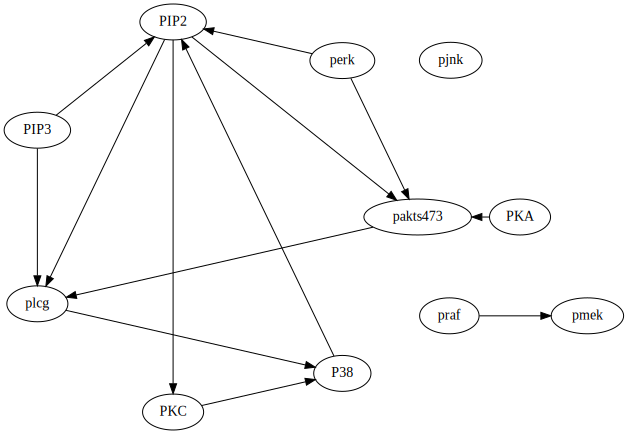

In [23]:
# Experiments 1 and 5, alpha 0.3

data_exp1_5_drop = data_exp1_5.drop(columns='experiment')
tester1_5 = IndependenceTester(data_exp1_5_drop, ParCorr(), alpha=0.3)

G = PC_algorithm(11, tester1_5)
graph_to_graphviz(G, list(data_exp1_5_drop.columns))

**Question**: In the dataframe for experiments 1 and 6, look at pmek, perk, and any other variables you think might be relevant. Assume it is true that adding U0126 produces an intervention on the activity of pmek. What would you expect to see in the data if the graph found by PC was correct? What changes would you propose to that graph based on the data?

Again put your answer with accompanying plots in new boxes below here.

**Answer**: One thing we might expect to see is more connectedness around pmek. This does seem to be the case. However, when consulting the graph resulting from experiments 1 and 6, it appears that pmek is a child of perk rather than the other way around. With all alpha values that we tried, perk appeared to consistently be a parent to pmek, which conflicts with the believed reality of the true model.  

perk has changed, which does fall in line with expectations from the data. If this graph is correct, an intervention on pmek would influence the structural graph of perk. In the actual graph, however, much more changes, which makes it difficult to thorougly gauge the effects of the intervention. Additionally, if the true causal model perk is a child of pmek, that should be reflected in the graphs, which currently is not the case.

One possible explanation for the directionality of the edge between perk and pmek being different, is that the algorithm may have concluded a cyclicity in the graph which we are explicitly excluding. However, some investigation of the graphs seems to conclude that this is not the case.

test: 0 and 1 given () -> pval=0.0
test: 0 and 2 given () -> pval=0.22579211347507994
independence found: 0 and 2 given ()
test: 0 and 3 given () -> pval=0.03332165389820263
test: 0 and 4 given () -> pval=0.0018048301566494169
test: 0 and 5 given () -> pval=2.4846295816511114e-70
test: 0 and 6 given () -> pval=1.795947241414922e-29
test: 0 and 7 given () -> pval=6.091908195017966e-12
test: 0 and 8 given () -> pval=4.579202937137639e-62
test: 0 and 9 given () -> pval=0.016423604063641198
test: 0 and 10 given () -> pval=5.139426589447728e-26
test: 1 and 0 given () -> pval=0.0
test: 1 and 2 given () -> pval=0.10463195222143483
independence found: 1 and 2 given ()
test: 1 and 3 given () -> pval=0.02337330991619621
test: 1 and 4 given () -> pval=0.0007183354978785982
test: 1 and 5 given () -> pval=1.491894310801781e-110
test: 1 and 6 given () -> pval=4.1379458633678395e-49
test: 1 and 7 given () -> pval=2.0093199621435567e-18
test: 1 and 8 given () -> pval=1.6347190760257162e-95
test: 1 and

test: 4 and 7 given (3,) -> pval=0.08177978479118823
test: 4 and 7 given (5,) -> pval=0.1537027677291096
independence found: 4 and 7 given (5,)
test: 4 and 8 given (0,) -> pval=0.04813377223194608
test: 4 and 8 given (1,) -> pval=0.1050093839795673
independence found: 4 and 8 given (1,)
test: 4 and 10 given (0,) -> pval=0.09422447109224832
test: 4 and 10 given (1,) -> pval=0.16938036587562594
independence found: 4 and 10 given (1,)
test: 5 and 0 given (1,) -> pval=7.775564356882014e-14
test: 5 and 0 given (2,) -> pval=5.08340204799932e-70
test: 5 and 0 given (3,) -> pval=1.0713660710063662e-69
test: 5 and 0 given (4,) -> pval=2.0962123918131258e-69
test: 5 and 0 given (6,) -> pval=3.5988458404804736e-100
test: 5 and 0 given (7,) -> pval=5.465076201551924e-67
test: 5 and 0 given (8,) -> pval=6.417284532229118e-40
test: 5 and 0 given (9,) -> pval=1.0794665977780903e-69
test: 5 and 0 given (10,) -> pval=7.036524757353962e-57
test: 5 and 1 given (0,) -> pval=3.0366483793818307e-54
test: 5 

test: 9 and 10 given (7,) -> pval=1.273589389958279e-17
test: 9 and 10 given (8,) -> pval=0.07682353901653789
test: 10 and 0 given (1,) -> pval=1.5085719195881846e-09
test: 10 and 0 given (2,) -> pval=7.702251611944243e-26
test: 10 and 0 given (3,) -> pval=1.2861258143381675e-25
test: 10 and 0 given (4,) -> pval=2.4262263286221474e-25
test: 10 and 0 given (5,) -> pval=1.8183841756332275e-12
test: 10 and 0 given (6,) -> pval=1.446907991584047e-19
test: 10 and 0 given (7,) -> pval=1.3083701633685988e-23
test: 10 and 0 given (8,) -> pval=1.513422150513607e-08
test: 10 and 0 given (9,) -> pval=9.463814226002236e-25
test: 10 and 1 given (0,) -> pval=4.342835262144796e-27
test: 10 and 1 given (2,) -> pval=3.776639289890145e-43
test: 10 and 1 given (3,) -> pval=6.4471930633960395e-43
test: 10 and 1 given (4,) -> pval=1.4752295242851722e-42
test: 10 and 1 given (5,) -> pval=7.234793733116622e-24
test: 10 and 1 given (6,) -> pval=4.558215673813968e-34
test: 10 and 1 given (7,) -> pval=4.5709287

test: 0 and 10 given (2, 9) -> pval=1.3794588986148295e-24
test: 0 and 10 given (3, 4) -> pval=3.080895161337281e-25
test: 0 and 10 given (3, 5) -> pval=2.511783444995286e-12
test: 0 and 10 given (3, 6) -> pval=3.7072482813786706e-19
test: 0 and 10 given (3, 7) -> pval=2.5188847829410835e-23
test: 0 and 10 given (3, 8) -> pval=1.7944142773290647e-08
test: 0 and 10 given (3, 9) -> pval=2.0347561856827897e-24
test: 0 and 10 given (4, 5) -> pval=3.610678183941843e-12
test: 0 and 10 given (4, 6) -> pval=5.289830976325792e-19
test: 0 and 10 given (4, 7) -> pval=4.265848105817511e-23
test: 0 and 10 given (4, 8) -> pval=2.2273572172512455e-08
test: 0 and 10 given (4, 9) -> pval=3.472700644749368e-24
test: 0 and 10 given (5, 6) -> pval=0.0001082404090779158
test: 0 and 10 given (5, 7) -> pval=2.1722322973122395e-11
test: 0 and 10 given (5, 8) -> pval=4.0763872220699796e-05
test: 0 and 10 given (5, 9) -> pval=8.186839667587874e-12
test: 0 and 10 given (6, 7) -> pval=1.5350730549262603e-13
test:

test: 2 and 3 given (1, 10) -> pval=8.946458678980011e-06
test: 2 and 3 given (4, 5) -> pval=0.0006562231696716158
test: 2 and 3 given (4, 6) -> pval=0.0005326228814110935
test: 2 and 3 given (4, 7) -> pval=0.0005860782637655498
test: 2 and 3 given (4, 8) -> pval=0.0007071141348386253
test: 2 and 3 given (4, 9) -> pval=0.0005528534325060912
test: 2 and 3 given (4, 10) -> pval=0.0006150613691984406
test: 2 and 3 given (5, 6) -> pval=7.996230906518254e-06
test: 2 and 3 given (5, 7) -> pval=7.526548664829001e-06
test: 2 and 3 given (5, 8) -> pval=1.131714397988798e-05
test: 2 and 3 given (5, 9) -> pval=8.370020941612938e-06
test: 2 and 3 given (5, 10) -> pval=9.569461116025244e-06
test: 2 and 3 given (6, 7) -> pval=6.5911094839019445e-06
test: 2 and 3 given (6, 8) -> pval=9.958709471025841e-06
test: 2 and 3 given (6, 9) -> pval=5.476048758654493e-06
test: 2 and 3 given (6, 10) -> pval=7.228695237246471e-06
test: 2 and 3 given (7, 8) -> pval=1.0648238492711911e-05
test: 2 and 3 given (7, 9

test: 5 and 7 given (0, 3) -> pval=5.530605633941887e-185
test: 5 and 7 given (0, 4) -> pval=3.597045081488389e-185
test: 5 and 7 given (0, 6) -> pval=3.4126471917415916e-148
test: 5 and 7 given (0, 8) -> pval=3.9659562268100267e-181
test: 5 and 7 given (0, 9) -> pval=3.5096079037222945e-185
test: 5 and 7 given (0, 10) -> pval=4.744133712359136e-185
test: 5 and 7 given (1, 2) -> pval=1.699681432517453e-182
test: 5 and 7 given (1, 3) -> pval=3.121256670343381e-182
test: 5 and 7 given (1, 4) -> pval=1.5254986979886737e-182
test: 5 and 7 given (1, 6) -> pval=6.150051795204653e-124
test: 5 and 7 given (1, 8) -> pval=3.1111488307696957e-180
test: 5 and 7 given (1, 9) -> pval=2.4129795452740595e-182
test: 5 and 7 given (1, 10) -> pval=1.3969193536598159e-182
test: 5 and 7 given (2, 3) -> pval=7.788711015176269e-188
test: 5 and 7 given (2, 4) -> pval=1.0780707916372507e-187
test: 5 and 7 given (2, 6) -> pval=7.669345095769946e-179
test: 5 and 7 given (2, 8) -> pval=2.8972446055747486e-180
tes

test: 6 and 8 given (1, 5) -> pval=1.035705908477907e-10
test: 6 and 8 given (1, 7) -> pval=1.3281549291728018e-06
test: 6 and 8 given (1, 9) -> pval=0.0005767573259091559
test: 6 and 8 given (1, 10) -> pval=0.027247958004702328
test: 6 and 8 given (2, 3) -> pval=2.6546405402324832e-20
test: 6 and 8 given (2, 4) -> pval=5.542143388275203e-20
test: 6 and 8 given (2, 5) -> pval=4.173293574271361e-39
test: 6 and 8 given (2, 7) -> pval=7.164332702234773e-37
test: 6 and 8 given (2, 9) -> pval=2.8975892354724974e-25
test: 6 and 8 given (2, 10) -> pval=3.792409864004435e-13
test: 6 and 8 given (3, 4) -> pval=3.570226037653263e-20
test: 6 and 8 given (3, 5) -> pval=2.4869657380812783e-39
test: 6 and 8 given (3, 7) -> pval=5.7140148414020965e-37
test: 6 and 8 given (3, 9) -> pval=1.6809791507426753e-25
test: 6 and 8 given (3, 10) -> pval=2.5220406725921965e-13
test: 6 and 8 given (4, 5) -> pval=6.023944922771897e-39
test: 6 and 8 given (4, 7) -> pval=1.5959344355046645e-36
test: 6 and 8 given (

test: 8 and 5 given (0, 1) -> pval=7.500090740648949e-09
test: 8 and 5 given (0, 2) -> pval=3.0628289111230526e-24
test: 8 and 5 given (0, 3) -> pval=3.237463691810818e-24
test: 8 and 5 given (0, 4) -> pval=2.7053712467616165e-24
test: 8 and 5 given (0, 6) -> pval=3.4021775600414824e-38
test: 8 and 5 given (0, 7) -> pval=3.824550631846427e-20
test: 8 and 5 given (0, 9) -> pval=3.719300948588089e-30
test: 8 and 5 given (0, 10) -> pval=1.5887189885940403e-18
test: 8 and 5 given (1, 2) -> pval=1.208830678486239e-11
test: 8 and 5 given (1, 3) -> pval=1.2837935540900222e-11
test: 8 and 5 given (1, 4) -> pval=1.0678250755317024e-11
test: 8 and 5 given (1, 6) -> pval=2.4873225773970994e-19
test: 8 and 5 given (1, 7) -> pval=2.10497001786189e-09
test: 8 and 5 given (1, 9) -> pval=4.4706334414375706e-14
test: 8 and 5 given (1, 10) -> pval=1.1690866651227444e-09
test: 8 and 5 given (2, 3) -> pval=7.891328776133401e-54
test: 8 and 5 given (2, 4) -> pval=1.0399670640322838e-53
test: 8 and 5 given 

test: 10 and 0 given (2, 3) -> pval=1.714471228488317e-25
test: 10 and 0 given (2, 4) -> pval=3.2216028084737055e-25
test: 10 and 0 given (2, 5) -> pval=1.9836351570250574e-12
test: 10 and 0 given (2, 6) -> pval=2.0350558652494072e-19
test: 10 and 0 given (2, 7) -> pval=1.820552338752226e-23
test: 10 and 0 given (2, 8) -> pval=1.5917386122409307e-08
test: 10 and 0 given (2, 9) -> pval=1.379458898614869e-24
test: 10 and 0 given (3, 4) -> pval=3.080895161337281e-25
test: 10 and 0 given (3, 5) -> pval=2.511783444995286e-12
test: 10 and 0 given (3, 6) -> pval=3.7072482813786706e-19
test: 10 and 0 given (3, 7) -> pval=2.5188847829410835e-23
test: 10 and 0 given (3, 8) -> pval=1.794414277329071e-08
test: 10 and 0 given (3, 9) -> pval=2.0347561856827607e-24
test: 10 and 0 given (4, 5) -> pval=3.6106781839418825e-12
test: 10 and 0 given (4, 6) -> pval=5.289830976325945e-19
test: 10 and 0 given (4, 7) -> pval=4.265848105817511e-23
test: 10 and 0 given (4, 8) -> pval=2.2273572172512455e-08
test:

test: 10 and 8 given (6, 7) -> pval=8.702145066809248e-33
test: 10 and 8 given (6, 9) -> pval=4.115087296301708e-25
test: 10 and 8 given (7, 9) -> pval=3.065535479239431e-29
test: 10 and 9 given (0, 1) -> pval=5.6231763658063955e-18
test: 10 and 9 given (0, 2) -> pval=7.771741635015141e-17
test: 10 and 9 given (0, 3) -> pval=1.0141159470303567e-16
test: 10 and 9 given (0, 4) -> pval=1.0904219412622964e-16
test: 10 and 9 given (0, 5) -> pval=1.26645695767247e-16
test: 10 and 9 given (0, 6) -> pval=4.240220641642971e-17
test: 10 and 9 given (0, 7) -> pval=1.30174489967592e-16
test: 10 and 9 given (0, 8) -> pval=0.004371519432128561
test: 10 and 9 given (1, 2) -> pval=4.352698733489117e-17
test: 10 and 9 given (1, 3) -> pval=5.5356134139400886e-17
test: 10 and 9 given (1, 4) -> pval=5.760300352738325e-17
test: 10 and 9 given (1, 5) -> pval=6.593421045361753e-17
test: 10 and 9 given (1, 6) -> pval=3.107080554373616e-17
test: 10 and 9 given (1, 7) -> pval=5.713289171578391e-17
test: 10 and 

test: 0 and 5 given (3, 7, 8) -> pval=1.0290968019083603e-40
test: 0 and 5 given (3, 7, 9) -> pval=1.6470321179801147e-66
test: 0 and 5 given (3, 7, 10) -> pval=8.679349089847473e-55
test: 0 and 5 given (3, 8, 9) -> pval=2.3626163201968596e-34
test: 0 and 5 given (3, 8, 10) -> pval=1.886544813040235e-36
test: 0 and 5 given (3, 9, 10) -> pval=1.7665633967329222e-56
test: 0 and 5 given (4, 6, 7) -> pval=4.744399608143648e-69
test: 0 and 5 given (4, 6, 8) -> pval=4.173863423159954e-64
test: 0 and 5 given (4, 6, 9) -> pval=2.248129823701611e-98
test: 0 and 5 given (4, 6, 10) -> pval=7.010071911616047e-85
test: 0 and 5 given (4, 7, 8) -> pval=8.383795134913523e-41
test: 0 and 5 given (4, 7, 9) -> pval=1.5661829419092286e-66
test: 0 and 5 given (4, 7, 10) -> pval=7.198138491818629e-55
test: 0 and 5 given (4, 8, 9) -> pval=3.103331097126527e-34
test: 0 and 5 given (4, 8, 10) -> pval=2.294032451789905e-36
test: 0 and 5 given (4, 9, 10) -> pval=2.6360244526296218e-56
test: 0 and 5 given (6, 7, 

test: 0 and 8 given (2, 6, 9) -> pval=1.6088082116410113e-57
test: 0 and 8 given (2, 6, 10) -> pval=3.886967335493363e-37
test: 0 and 8 given (2, 7, 9) -> pval=7.737398159806378e-66
test: 0 and 8 given (2, 7, 10) -> pval=1.2116640538541946e-40
test: 0 and 8 given (2, 9, 10) -> pval=2.82477921695661e-57
test: 0 and 8 given (3, 4, 5) -> pval=5.006857354892776e-31
test: 0 and 8 given (3, 4, 6) -> pval=1.3603974039780604e-48
test: 0 and 8 given (3, 4, 7) -> pval=4.400888944030701e-55
test: 0 and 8 given (3, 4, 9) -> pval=3.5971290882375774e-71
test: 0 and 8 given (3, 4, 10) -> pval=5.784913242372556e-44
test: 0 and 8 given (3, 5, 6) -> pval=8.198858453941577e-14
test: 0 and 8 given (3, 5, 7) -> pval=1.7661408581589482e-29
test: 0 and 8 given (3, 5, 9) -> pval=5.377260136797493e-37
test: 0 and 8 given (3, 5, 10) -> pval=2.9415930430366687e-24
test: 0 and 8 given (3, 6, 7) -> pval=6.428259997957144e-35
test: 0 and 8 given (3, 6, 9) -> pval=4.5525860941668256e-57
test: 0 and 8 given (3, 6, 10

test: 1 and 0 given (3, 5, 8) -> pval=0.0
test: 1 and 0 given (3, 5, 9) -> pval=0.0
test: 1 and 0 given (3, 5, 10) -> pval=0.0
test: 1 and 0 given (3, 6, 7) -> pval=0.0
test: 1 and 0 given (3, 6, 8) -> pval=0.0
test: 1 and 0 given (3, 6, 9) -> pval=0.0
test: 1 and 0 given (3, 6, 10) -> pval=0.0
test: 1 and 0 given (3, 7, 8) -> pval=0.0
test: 1 and 0 given (3, 7, 9) -> pval=0.0
test: 1 and 0 given (3, 7, 10) -> pval=0.0
test: 1 and 0 given (3, 8, 9) -> pval=0.0
test: 1 and 0 given (3, 8, 10) -> pval=0.0
test: 1 and 0 given (3, 9, 10) -> pval=0.0
test: 1 and 0 given (4, 5, 6) -> pval=0.0
test: 1 and 0 given (4, 5, 7) -> pval=0.0
test: 1 and 0 given (4, 5, 8) -> pval=0.0
test: 1 and 0 given (4, 5, 9) -> pval=0.0
test: 1 and 0 given (4, 5, 10) -> pval=0.0
test: 1 and 0 given (4, 6, 7) -> pval=0.0
test: 1 and 0 given (4, 6, 8) -> pval=0.0
test: 1 and 0 given (4, 6, 9) -> pval=0.0
test: 1 and 0 given (4, 6, 10) -> pval=0.0
test: 1 and 0 given (4, 7, 8) -> pval=0.0
test: 1 and 0 given (4, 7, 

test: 1 and 6 given (2, 3, 5) -> pval=9.66396617887554e-115
test: 1 and 6 given (2, 3, 7) -> pval=1.3542210547718052e-87
test: 1 and 6 given (2, 3, 8) -> pval=1.76131671567962e-32
test: 1 and 6 given (2, 3, 9) -> pval=2.6123249680885363e-49
test: 1 and 6 given (2, 3, 10) -> pval=5.153083672692739e-40
test: 1 and 6 given (2, 4, 5) -> pval=2.6233414187118718e-114
test: 1 and 6 given (2, 4, 7) -> pval=5.378970457676432e-87
test: 1 and 6 given (2, 4, 8) -> pval=2.3086334242592067e-32
test: 1 and 6 given (2, 4, 9) -> pval=6.125124346607167e-49
test: 1 and 6 given (2, 4, 10) -> pval=8.754311138857683e-40
test: 1 and 6 given (2, 5, 7) -> pval=3.717735472809889e-104
test: 1 and 6 given (2, 5, 8) -> pval=2.197234020520971e-86
test: 1 and 6 given (2, 5, 9) -> pval=2.2643003076101913e-114
test: 1 and 6 given (2, 5, 10) -> pval=5.309883786557152e-101
test: 1 and 6 given (2, 7, 8) -> pval=1.2948016245011208e-57
test: 1 and 6 given (2, 7, 9) -> pval=2.982747972019688e-87
test: 1 and 6 given (2, 7, 1

test: 1 and 10 given (2, 3, 9) -> pval=9.173337800628827e-42
test: 1 and 10 given (2, 4, 5) -> pval=2.2020058255985758e-23
test: 1 and 10 given (2, 4, 6) -> pval=4.1406146909779674e-33
test: 1 and 10 given (2, 4, 7) -> pval=3.274913345484795e-39
test: 1 and 10 given (2, 4, 8) -> pval=3.6796350328483483e-16
test: 1 and 10 given (2, 4, 9) -> pval=1.831331843225212e-41
test: 1 and 10 given (2, 5, 6) -> pval=4.64930431525966e-10
test: 1 and 10 given (2, 5, 7) -> pval=3.6670505387435317e-22
test: 1 and 10 given (2, 5, 8) -> pval=8.449306473141835e-11
test: 1 and 10 given (2, 5, 9) -> pval=2.047588043827253e-23
test: 1 and 10 given (2, 6, 7) -> pval=1.0967192954701725e-24
test: 1 and 10 given (2, 6, 8) -> pval=2.3898042432347824e-13
test: 1 and 10 given (2, 6, 9) -> pval=8.638413295003342e-33
test: 1 and 10 given (2, 7, 8) -> pval=9.999732772588308e-16
test: 1 and 10 given (2, 7, 9) -> pval=3.570193568858359e-39
test: 1 and 10 given (2, 8, 9) -> pval=2.95139099306007e-19
test: 1 and 10 given

test: 3 and 2 given (4, 7, 8) -> pval=0.0007310671477001745
test: 3 and 2 given (4, 7, 9) -> pval=0.0005966242211943307
test: 3 and 2 given (4, 7, 10) -> pval=0.000652403330337711
test: 3 and 2 given (4, 8, 9) -> pval=0.0007132611864550546
test: 3 and 2 given (4, 8, 10) -> pval=0.0007345969046602194
test: 3 and 2 given (4, 9, 10) -> pval=0.0006168015661566227
test: 3 and 2 given (5, 6, 7) -> pval=7.680827847041968e-06
test: 3 and 2 given (5, 6, 8) -> pval=1.1200026273687515e-05
test: 3 and 2 given (5, 6, 9) -> pval=8.318421618418417e-06
test: 3 and 2 given (5, 6, 10) -> pval=9.411598032148454e-06
test: 3 and 2 given (5, 7, 8) -> pval=1.0724136713453193e-05
test: 3 and 2 given (5, 7, 9) -> pval=7.848987082196523e-06
test: 3 and 2 given (5, 7, 10) -> pval=9.020299191364324e-06
test: 3 and 2 given (5, 8, 9) -> pval=1.1261023505825729e-05
test: 3 and 2 given (5, 8, 10) -> pval=1.2161274598832245e-05
test: 3 and 2 given (5, 9, 10) -> pval=9.67558969716388e-06
test: 3 and 2 given (6, 7, 8) -

test: 5 and 0 given (2, 3, 6) -> pval=3.707460738388051e-99
test: 5 and 0 given (2, 3, 7) -> pval=1.378432974253075e-66
test: 5 and 0 given (2, 3, 8) -> pval=1.0408198364559217e-39
test: 5 and 0 given (2, 3, 9) -> pval=7.075881306982873e-69
test: 5 and 0 given (2, 3, 10) -> pval=2.2382450345657224e-56
test: 5 and 0 given (2, 4, 6) -> pval=8.033112738336786e-99
test: 5 and 0 given (2, 4, 7) -> pval=1.2986816536191173e-66
test: 5 and 0 given (2, 4, 8) -> pval=1.3351563520905883e-39
test: 5 and 0 given (2, 4, 9) -> pval=1.3250958924219694e-68
test: 5 and 0 given (2, 4, 10) -> pval=3.292577076474249e-56
test: 5 and 0 given (2, 6, 7) -> pval=5.368945258426049e-69
test: 5 and 0 given (2, 6, 8) -> pval=2.2028176946625654e-64
test: 5 and 0 given (2, 6, 9) -> pval=4.46196381174455e-99
test: 5 and 0 given (2, 6, 10) -> pval=2.379304713693475e-85
test: 5 and 0 given (2, 7, 8) -> pval=1.1271400929725284e-40
test: 5 and 0 given (2, 7, 9) -> pval=1.8777920537045802e-66
test: 5 and 0 given (2, 7, 10)

test: 5 and 7 given (1, 2, 10) -> pval=1.9694186201525903e-182
test: 5 and 7 given (1, 3, 4) -> pval=3.1165142803346536e-182
test: 5 and 7 given (1, 3, 6) -> pval=8.924997222844695e-124
test: 5 and 7 given (1, 3, 8) -> pval=5.647519134206681e-180
test: 5 and 7 given (1, 3, 9) -> pval=6.093650304620642e-182
test: 5 and 7 given (1, 3, 10) -> pval=3.125164115017797e-182
test: 5 and 7 given (1, 4, 6) -> pval=6.810974731627476e-124
test: 5 and 7 given (1, 4, 8) -> pval=2.879085053691715e-180
test: 5 and 7 given (1, 4, 9) -> pval=3.004775520833916e-182
test: 5 and 7 given (1, 4, 10) -> pval=1.4909062576966964e-182
test: 5 and 7 given (1, 6, 8) -> pval=6.635413561241444e-118
test: 5 and 7 given (1, 6, 9) -> pval=1.102713542216908e-123
test: 5 and 7 given (1, 6, 10) -> pval=4.4155757697583775e-122
test: 5 and 7 given (1, 8, 9) -> pval=9.347393023483774e-181
test: 5 and 7 given (1, 8, 10) -> pval=2.217606447722102e-180
test: 5 and 7 given (1, 9, 10) -> pval=1.451854828789801e-182
test: 5 and 7 

test: 5 and 10 given (1, 4, 9) -> pval=0.00010270518964079127
test: 5 and 10 given (1, 6, 7) -> pval=6.457857459591659e-07
test: 5 and 10 given (1, 6, 8) -> pval=8.227098897784186e-05
test: 5 and 10 given (1, 6, 9) -> pval=1.4449648049365337e-08
test: 5 and 10 given (1, 7, 8) -> pval=0.005129879062228455
test: 5 and 10 given (1, 7, 9) -> pval=4.320024697099105e-05
test: 5 and 10 given (1, 8, 9) -> pval=0.0032868474072332357
test: 5 and 10 given (2, 3, 4) -> pval=5.948788193447243e-24
test: 5 and 10 given (2, 3, 6) -> pval=4.5192486770360883e-32
test: 5 and 10 given (2, 3, 7) -> pval=9.769296441765295e-23
test: 5 and 10 given (2, 3, 8) -> pval=1.9793342983124544e-08
test: 5 and 10 given (2, 3, 9) -> pval=2.1851986785918027e-23
test: 5 and 10 given (2, 4, 6) -> pval=5.97768572910802e-32
test: 5 and 10 given (2, 4, 7) -> pval=1.0132919396821148e-22
test: 5 and 10 given (2, 4, 8) -> pval=2.0936724389036564e-08
test: 5 and 10 given (2, 4, 9) -> pval=2.691666188380956e-23
test: 5 and 10 give

test: 6 and 1 given (3, 7, 8) -> pval=1.0746067067433384e-57
test: 6 and 1 given (3, 7, 9) -> pval=2.201137905597875e-87
test: 6 and 1 given (3, 7, 10) -> pval=1.3135821245761705e-72
test: 6 and 1 given (3, 8, 9) -> pval=3.2261773985120865e-28
test: 6 and 1 given (3, 8, 10) -> pval=1.9493578857271787e-29
test: 6 and 1 given (3, 9, 10) -> pval=6.1304196556042215e-40
test: 6 and 1 given (4, 5, 7) -> pval=1.2054708156129762e-103
test: 6 and 1 given (4, 5, 8) -> pval=2.067705626567435e-86
test: 6 and 1 given (4, 5, 9) -> pval=3.365994305469402e-114
test: 6 and 1 given (4, 5, 10) -> pval=5.851686704449603e-101
test: 6 and 1 given (4, 7, 8) -> pval=1.9903783395470326e-57
test: 6 and 1 given (4, 7, 9) -> pval=8.860276664223569e-87
test: 6 and 1 given (4, 7, 10) -> pval=3.4104994280670703e-72
test: 6 and 1 given (4, 8, 9) -> pval=4.238405228769745e-28
test: 6 and 1 given (4, 8, 10) -> pval=2.3469566338722616e-29
test: 6 and 1 given (4, 9, 10) -> pval=1.0944663665290015e-39
test: 6 and 1 given 

test: 7 and 5 given (3, 4, 9) -> pval=8.785790443107019e-187
test: 7 and 5 given (3, 4, 10) -> pval=4.919594003537643e-186
test: 7 and 5 given (3, 6, 8) -> pval=5.5737809691761474e-151
test: 7 and 5 given (3, 6, 9) -> pval=1.8799316174451275e-177
test: 7 and 5 given (3, 6, 10) -> pval=1.4732640449199215e-167
test: 7 and 5 given (3, 8, 9) -> pval=9.138176799254506e-181
test: 7 and 5 given (3, 8, 10) -> pval=3.0111796869243164e-180
test: 7 and 5 given (3, 9, 10) -> pval=1.6395116325393406e-186
test: 7 and 5 given (4, 6, 8) -> pval=8.499084579256708e-151
test: 7 and 5 given (4, 6, 9) -> pval=4.159351251240158e-177
test: 7 and 5 given (4, 6, 10) -> pval=2.5509969505862417e-167
test: 7 and 5 given (4, 8, 9) -> pval=9.67238109158586e-181
test: 7 and 5 given (4, 8, 10) -> pval=2.881333635736314e-180
test: 7 and 5 given (4, 9, 10) -> pval=1.7938759218744582e-186
test: 7 and 5 given (6, 8, 9) -> pval=6.300715562215299e-147
test: 7 and 5 given (6, 8, 10) -> pval=5.059408623124285e-148
test: 7 an

test: 8 and 1 given (0, 2, 6) -> pval=9.60980548768989e-39
test: 8 and 1 given (0, 2, 7) -> pval=4.388613889258148e-41
test: 8 and 1 given (0, 2, 9) -> pval=2.0633598262051745e-62
test: 8 and 1 given (0, 2, 10) -> pval=9.109110694582253e-32
test: 8 and 1 given (0, 3, 4) -> pval=2.489746458588191e-44
test: 8 and 1 given (0, 3, 5) -> pval=3.9479541060996796e-29
test: 8 and 1 given (0, 3, 6) -> pval=9.08416670928003e-39
test: 8 and 1 given (0, 3, 7) -> pval=2.899388448311596e-41
test: 8 and 1 given (0, 3, 9) -> pval=1.3897920071158775e-62
test: 8 and 1 given (0, 3, 10) -> pval=6.930134219495168e-32
test: 8 and 1 given (0, 4, 5) -> pval=5.474930328791792e-29
test: 8 and 1 given (0, 4, 6) -> pval=1.0105366695386166e-38
test: 8 and 1 given (0, 4, 7) -> pval=3.874062043332364e-41
test: 8 and 1 given (0, 4, 9) -> pval=1.766283770378348e-62
test: 8 and 1 given (0, 4, 10) -> pval=8.657957559025153e-32
test: 8 and 1 given (0, 5, 6) -> pval=4.634248810737839e-15
test: 8 and 1 given (0, 5, 7) -> pv

test: 8 and 9 given (1, 7, 10) -> pval=4.932839890051162e-120
test: 8 and 9 given (2, 3, 4) -> pval=2.476214174433334e-109
test: 8 and 9 given (2, 3, 5) -> pval=5.2217410315422915e-120
test: 8 and 9 given (2, 3, 6) -> pval=1.0086857584575147e-114
test: 8 and 9 given (2, 3, 7) -> pval=5.413801057274999e-110
test: 8 and 9 given (2, 3, 10) -> pval=3.9981160998534324e-94
test: 8 and 9 given (2, 4, 5) -> pval=6.771489681761872e-120
test: 8 and 9 given (2, 4, 6) -> pval=1.3553586069605922e-114
test: 8 and 9 given (2, 4, 7) -> pval=7.059140790588787e-110
test: 8 and 9 given (2, 4, 10) -> pval=4.579533914197708e-94
test: 8 and 9 given (2, 5, 6) -> pval=6.65315265234151e-132
test: 8 and 9 given (2, 5, 7) -> pval=3.7004492877450967e-122
test: 8 and 9 given (2, 5, 10) -> pval=1.440018224508753e-106
test: 8 and 9 given (2, 6, 7) -> pval=1.4027867172838163e-118
test: 8 and 9 given (2, 6, 10) -> pval=8.688815161760127e-100
test: 8 and 9 given (2, 7, 10) -> pval=3.072811846942101e-95
test: 8 and 9 gi

test: 9 and 8 given (4, 6, 7) -> pval=4.579276152231768e-118
test: 9 and 8 given (4, 6, 10) -> pval=2.255112500487601e-99
test: 9 and 8 given (4, 7, 10) -> pval=7.108111710330698e-95
test: 9 and 8 given (5, 6, 7) -> pval=8.078385192477005e-132
test: 9 and 8 given (5, 6, 10) -> pval=7.993712995579673e-120
test: 9 and 8 given (5, 7, 10) -> pval=2.9551569004330434e-108
test: 9 and 8 given (6, 7, 10) -> pval=1.7744354960780628e-104
test: 9 and 10 given (0, 1, 2) -> pval=6.0242088867576136e-18
test: 9 and 10 given (0, 1, 3) -> pval=7.735483606755703e-18
test: 9 and 10 given (0, 1, 4) -> pval=8.034443290953631e-18
test: 9 and 10 given (0, 1, 5) -> pval=9.679988927736153e-18
test: 9 and 10 given (0, 1, 6) -> pval=5.141213382483617e-18
test: 9 and 10 given (0, 1, 7) -> pval=7.155891737938706e-18
test: 9 and 10 given (0, 1, 8) -> pval=2.2097199996507255e-06
test: 9 and 10 given (0, 2, 3) -> pval=1.0571028908824316e-16
test: 9 and 10 given (0, 2, 4) -> pval=1.1423146924705146e-16
test: 9 and 10 

test: 10 and 1 given (2, 4, 7) -> pval=3.274913345484701e-39
test: 10 and 1 given (2, 4, 8) -> pval=3.6796350328483483e-16
test: 10 and 1 given (2, 4, 9) -> pval=1.831331843225212e-41
test: 10 and 1 given (2, 5, 6) -> pval=4.64930431525966e-10
test: 10 and 1 given (2, 5, 7) -> pval=3.6670505387435317e-22
test: 10 and 1 given (2, 5, 8) -> pval=8.449306473141898e-11
test: 10 and 1 given (2, 5, 9) -> pval=2.04758804382715e-23
test: 10 and 1 given (2, 6, 7) -> pval=1.0967192954701725e-24
test: 10 and 1 given (2, 6, 8) -> pval=2.3898042432348253e-13
test: 10 and 1 given (2, 6, 9) -> pval=8.638413295003342e-33
test: 10 and 1 given (2, 7, 8) -> pval=9.999732772588308e-16
test: 10 and 1 given (2, 7, 9) -> pval=3.570193568858257e-39
test: 10 and 1 given (2, 8, 9) -> pval=2.95139099306007e-19
test: 10 and 1 given (3, 4, 5) -> pval=2.0711126115583496e-23
test: 10 and 1 given (3, 4, 6) -> pval=4.103782151865514e-33
test: 10 and 1 given (3, 4, 7) -> pval=2.623654254193363e-39
test: 10 and 1 given (

test: 10 and 8 given (3, 5, 9) -> pval=2.4425460074595332e-17
test: 10 and 8 given (3, 6, 7) -> pval=2.3469144717635066e-32
test: 10 and 8 given (3, 6, 9) -> pval=1.1573784870106554e-24
test: 10 and 8 given (3, 7, 9) -> pval=6.365259375937714e-29
test: 10 and 8 given (4, 5, 6) -> pval=1.5028230698120853e-20
test: 10 and 8 given (4, 5, 7) -> pval=6.66388358079729e-30
test: 10 and 8 given (4, 5, 9) -> pval=2.8106469220549044e-17
test: 10 and 8 given (4, 6, 7) -> pval=2.2693571306338377e-32
test: 10 and 8 given (4, 6, 9) -> pval=1.1930792952949644e-24
test: 10 and 8 given (4, 7, 9) -> pval=7.816075175740738e-29
test: 10 and 8 given (5, 6, 7) -> pval=7.426226346269947e-21
test: 10 and 8 given (5, 6, 9) -> pval=1.263558554800529e-08
test: 10 and 8 given (5, 7, 9) -> pval=2.0925400044611094e-16
test: 10 and 8 given (6, 7, 9) -> pval=1.1416845409504987e-18
test: 10 and 9 given (0, 1, 2) -> pval=6.0242088867576136e-18
test: 10 and 9 given (0, 1, 3) -> pval=7.735483606755703e-18
test: 10 and 9 

test: 0 and 1 given (4, 6, 7, 8) -> pval=0.0
test: 0 and 1 given (4, 6, 7, 9) -> pval=0.0
test: 0 and 1 given (4, 6, 7, 10) -> pval=0.0
test: 0 and 1 given (4, 6, 8, 9) -> pval=0.0
test: 0 and 1 given (4, 6, 8, 10) -> pval=0.0
test: 0 and 1 given (4, 6, 9, 10) -> pval=0.0
test: 0 and 1 given (4, 7, 8, 9) -> pval=0.0
test: 0 and 1 given (4, 7, 8, 10) -> pval=0.0
test: 0 and 1 given (4, 7, 9, 10) -> pval=0.0
test: 0 and 1 given (4, 8, 9, 10) -> pval=0.0
test: 0 and 1 given (5, 6, 7, 8) -> pval=0.0
test: 0 and 1 given (5, 6, 7, 9) -> pval=0.0
test: 0 and 1 given (5, 6, 7, 10) -> pval=0.0
test: 0 and 1 given (5, 6, 8, 9) -> pval=0.0
test: 0 and 1 given (5, 6, 8, 10) -> pval=0.0
test: 0 and 1 given (5, 6, 9, 10) -> pval=0.0
test: 0 and 1 given (5, 7, 8, 9) -> pval=0.0
test: 0 and 1 given (5, 7, 8, 10) -> pval=0.0
test: 0 and 1 given (5, 7, 9, 10) -> pval=0.0
test: 0 and 1 given (5, 8, 9, 10) -> pval=0.0
test: 0 and 1 given (6, 7, 8, 9) -> pval=0.0
test: 0 and 1 given (6, 7, 8, 10) -> pval=0

test: 0 and 6 given (1, 5, 7, 10) -> pval=1.508459241345595e-25
test: 0 and 6 given (1, 5, 8, 9) -> pval=3.283008052054155e-23
test: 0 and 6 given (1, 5, 8, 10) -> pval=1.254984480134759e-23
test: 0 and 6 given (1, 5, 9, 10) -> pval=1.2044741497156654e-25
test: 0 and 6 given (1, 7, 8, 9) -> pval=1.08996504304696e-15
test: 0 and 6 given (1, 7, 8, 10) -> pval=7.321190460913221e-16
test: 0 and 6 given (1, 7, 9, 10) -> pval=2.0745373140890382e-17
test: 0 and 6 given (1, 8, 9, 10) -> pval=3.4375616959959446e-08
test: 0 and 6 given (2, 3, 4, 5) -> pval=4.171472762202681e-59
test: 0 and 6 given (2, 3, 4, 7) -> pval=7.850366467876644e-50
test: 0 and 6 given (2, 3, 4, 8) -> pval=2.492848919588829e-17
test: 0 and 6 given (2, 3, 4, 9) -> pval=2.3515030832777894e-29
test: 0 and 6 given (2, 3, 4, 10) -> pval=4.2678627670264366e-23
test: 0 and 6 given (2, 3, 5, 7) -> pval=1.5288713475175222e-52
test: 0 and 6 given (2, 3, 5, 8) -> pval=5.173631038993443e-42
test: 0 and 6 given (2, 3, 5, 9) -> pval=3.

test: 0 and 10 given (1, 2, 5, 9) -> pval=9.14915997734882e-09
test: 0 and 10 given (1, 2, 6, 7) -> pval=1.2330172426555166e-07
test: 0 and 10 given (1, 2, 6, 8) -> pval=7.462746978065203e-06
test: 0 and 10 given (1, 2, 6, 9) -> pval=1.9240774073152895e-09
test: 0 and 10 given (1, 2, 7, 8) -> pval=2.7278905224566396e-06
test: 0 and 10 given (1, 2, 7, 9) -> pval=3.6529170589406714e-10
test: 0 and 10 given (1, 2, 8, 9) -> pval=9.303495419926411e-08
test: 0 and 10 given (1, 3, 4, 5) -> pval=5.76524069215889e-08
test: 0 and 10 given (1, 3, 4, 6) -> pval=1.1013842523266838e-08
test: 0 and 10 given (1, 3, 4, 7) -> pval=2.5674299198052384e-09
test: 0 and 10 given (1, 3, 4, 8) -> pval=2.102811736767924e-06
test: 0 and 10 given (1, 3, 4, 9) -> pval=2.0331128914508418e-10
test: 0 and 10 given (1, 3, 5, 6) -> pval=1.6506199142656088e-05
test: 0 and 10 given (1, 3, 5, 7) -> pval=7.86556831533015e-08
test: 0 and 10 given (1, 3, 5, 8) -> pval=1.1153885725657092e-05
test: 0 and 10 given (1, 3, 5, 9) 

test: 1 and 0 given (4, 6, 8, 10) -> pval=0.0
test: 1 and 0 given (4, 6, 9, 10) -> pval=0.0
test: 1 and 0 given (4, 7, 8, 9) -> pval=0.0
test: 1 and 0 given (4, 7, 8, 10) -> pval=0.0
test: 1 and 0 given (4, 7, 9, 10) -> pval=0.0
test: 1 and 0 given (4, 8, 9, 10) -> pval=0.0
test: 1 and 0 given (5, 6, 7, 8) -> pval=0.0
test: 1 and 0 given (5, 6, 7, 9) -> pval=0.0
test: 1 and 0 given (5, 6, 7, 10) -> pval=0.0
test: 1 and 0 given (5, 6, 8, 9) -> pval=0.0
test: 1 and 0 given (5, 6, 8, 10) -> pval=0.0
test: 1 and 0 given (5, 6, 9, 10) -> pval=0.0
test: 1 and 0 given (5, 7, 8, 9) -> pval=0.0
test: 1 and 0 given (5, 7, 8, 10) -> pval=0.0
test: 1 and 0 given (5, 7, 9, 10) -> pval=0.0
test: 1 and 0 given (5, 8, 9, 10) -> pval=0.0
test: 1 and 0 given (6, 7, 8, 9) -> pval=0.0
test: 1 and 0 given (6, 7, 8, 10) -> pval=0.0
test: 1 and 0 given (6, 7, 9, 10) -> pval=0.0
test: 1 and 0 given (6, 8, 9, 10) -> pval=0.0
test: 1 and 0 given (7, 8, 9, 10) -> pval=0.0
test: 1 and 5 given (0, 2, 3, 4) -> pval

test: 1 and 6 given (2, 3, 8, 10) -> pval=1.96787418929891e-29
test: 1 and 6 given (2, 3, 9, 10) -> pval=6.349529241092027e-40
test: 1 and 6 given (2, 4, 5, 7) -> pval=1.4742450619780864e-103
test: 1 and 6 given (2, 4, 5, 8) -> pval=2.333598769484823e-86
test: 1 and 6 given (2, 4, 5, 9) -> pval=4.351705383561214e-114
test: 1 and 6 given (2, 4, 5, 10) -> pval=6.98131264125075e-101
test: 1 and 6 given (2, 4, 7, 8) -> pval=2.0760836385674935e-57
test: 1 and 6 given (2, 4, 7, 9) -> pval=1.1041790027719524e-86
test: 1 and 6 given (2, 4, 7, 10) -> pval=3.7700901299271073e-72
test: 1 and 6 given (2, 4, 8, 9) -> pval=4.240933539745968e-28
test: 1 and 6 given (2, 4, 8, 10) -> pval=2.3417168510457134e-29
test: 1 and 6 given (2, 4, 9, 10) -> pval=1.0920440312618552e-39
test: 1 and 6 given (2, 5, 7, 8) -> pval=2.1884854152406475e-78
test: 1 and 6 given (2, 5, 7, 9) -> pval=7.576861979679865e-104
test: 1 and 6 given (2, 5, 7, 10) -> pval=3.810435993142025e-92
test: 1 and 6 given (2, 5, 8, 9) -> pva

test: 1 and 8 given (3, 4, 6, 10) -> pval=3.769349425747005e-57
test: 1 and 8 given (3, 4, 7, 9) -> pval=2.6164658017263376e-107
test: 1 and 8 given (3, 4, 7, 10) -> pval=4.632122859934437e-62
test: 1 and 8 given (3, 4, 9, 10) -> pval=1.2530819101042012e-93
test: 1 and 8 given (3, 5, 6, 7) -> pval=7.683932169754961e-24
test: 1 and 8 given (3, 5, 6, 9) -> pval=5.11250924564715e-30
test: 1 and 8 given (3, 5, 6, 10) -> pval=3.423847574793545e-19
test: 1 and 8 given (3, 5, 7, 9) -> pval=2.0816556136433514e-62
test: 1 and 8 given (3, 5, 7, 10) -> pval=8.600247493518867e-38
test: 1 and 8 given (3, 5, 9, 10) -> pval=5.580671341262927e-56
test: 1 and 8 given (3, 6, 7, 9) -> pval=3.708718482347522e-71
test: 1 and 8 given (3, 6, 7, 10) -> pval=1.3994773872579433e-42
test: 1 and 8 given (3, 6, 9, 10) -> pval=4.578024780314811e-79
test: 1 and 8 given (3, 7, 9, 10) -> pval=2.6256881919179246e-87
test: 1 and 8 given (4, 5, 6, 7) -> pval=9.791780945976602e-24
test: 1 and 8 given (4, 5, 6, 9) -> pval=

test: 2 and 3 given (0, 6, 7, 10) -> pval=9.410366123685094e-06
test: 2 and 3 given (0, 6, 8, 9) -> pval=1.0679674848191803e-05
test: 2 and 3 given (0, 6, 8, 10) -> pval=1.1709678358469844e-05
test: 2 and 3 given (0, 6, 9, 10) -> pval=8.684717927502978e-06
test: 2 and 3 given (0, 7, 8, 9) -> pval=1.093204127207599e-05
test: 2 and 3 given (0, 7, 8, 10) -> pval=1.1961467227559196e-05
test: 2 and 3 given (0, 7, 9, 10) -> pval=9.4855570743261e-06
test: 2 and 3 given (0, 8, 9, 10) -> pval=1.1096075787951078e-05
test: 2 and 3 given (1, 4, 5, 6) -> pval=0.0006538063394652515
test: 2 and 3 given (1, 4, 5, 7) -> pval=0.0006480283492707949
test: 2 and 3 given (1, 4, 5, 8) -> pval=0.0007615995854298333
test: 2 and 3 given (1, 4, 5, 9) -> pval=0.0006768713127213544
test: 2 and 3 given (1, 4, 5, 10) -> pval=0.0007061562800338545
test: 2 and 3 given (1, 4, 6, 7) -> pval=0.0006352905948162147
test: 2 and 3 given (1, 4, 6, 8) -> pval=0.0007450148798881965
test: 2 and 3 given (1, 4, 6, 9) -> pval=0.000

test: 3 and 4 given (0, 1, 5, 10) -> pval=1.161994303980449e-69
test: 3 and 4 given (0, 1, 6, 7) -> pval=1.4136786065687195e-69
test: 3 and 4 given (0, 1, 6, 8) -> pval=1.748182968053199e-69
test: 3 and 4 given (0, 1, 6, 9) -> pval=1.0720459636984858e-69
test: 3 and 4 given (0, 1, 6, 10) -> pval=1.190931631824823e-69
test: 3 and 4 given (0, 1, 7, 8) -> pval=3.6827759993376825e-69
test: 3 and 4 given (0, 1, 7, 9) -> pval=2.5776089551400325e-69
test: 3 and 4 given (0, 1, 7, 10) -> pval=2.8035333929881114e-69
test: 3 and 4 given (0, 1, 8, 9) -> pval=1.454305019889142e-69
test: 3 and 4 given (0, 1, 8, 10) -> pval=1.979225794332611e-69
test: 3 and 4 given (0, 1, 9, 10) -> pval=1.355769080442195e-69
test: 3 and 4 given (0, 2, 5, 6) -> pval=3.6596142566748015e-68
test: 3 and 4 given (0, 2, 5, 7) -> pval=9.021201219155483e-68
test: 3 and 4 given (0, 2, 5, 8) -> pval=9.277699938427496e-68
test: 3 and 4 given (0, 2, 5, 9) -> pval=6.474358850332975e-68
test: 3 and 4 given (0, 2, 5, 10) -> pval=6.

test: 4 and 3 given (2, 6, 7, 10) -> pval=6.112244724449475e-68
test: 4 and 3 given (2, 6, 8, 9) -> pval=4.0135675560713e-68
test: 4 and 3 given (2, 6, 8, 10) -> pval=6.508348589613554e-68
test: 4 and 3 given (2, 6, 9, 10) -> pval=2.0420007940703646e-68
test: 4 and 3 given (2, 7, 8, 9) -> pval=1.4070262037183395e-67
test: 4 and 3 given (2, 7, 8, 10) -> pval=2.0055893758491225e-67
test: 4 and 3 given (2, 7, 9, 10) -> pval=9.809492274872674e-68
test: 4 and 3 given (2, 8, 9, 10) -> pval=7.126148355773899e-68
test: 4 and 3 given (5, 6, 7, 8) -> pval=1.9010639293125857e-69
test: 4 and 3 given (5, 6, 7, 9) -> pval=7.647510206170734e-70
test: 4 and 3 given (5, 6, 7, 10) -> pval=1.0553871153124775e-69
test: 4 and 3 given (5, 6, 8, 9) -> pval=9.936084005815315e-70
test: 4 and 3 given (5, 6, 8, 10) -> pval=1.5114708936283969e-69
test: 4 and 3 given (5, 6, 9, 10) -> pval=7.292120588961676e-70
test: 4 and 3 given (5, 7, 8, 9) -> pval=2.570976497746297e-69
test: 4 and 3 given (5, 7, 8, 10) -> pval=

test: 5 and 1 given (2, 3, 6, 7) -> pval=2.8071114446735085e-120
test: 5 and 1 given (2, 3, 6, 8) -> pval=3.3169137458015677e-121
test: 5 and 1 given (2, 3, 6, 9) -> pval=8.641571989527531e-174
test: 5 and 1 given (2, 3, 6, 10) -> pval=2.332159951633338e-151
test: 5 and 1 given (2, 3, 7, 8) -> pval=2.365533611346898e-67
test: 5 and 1 given (2, 3, 7, 9) -> pval=2.0152385339903162e-103
test: 5 and 1 given (2, 3, 7, 10) -> pval=3.1972749272510754e-86
test: 5 and 1 given (2, 3, 8, 9) -> pval=1.7218132770441217e-58
test: 5 and 1 given (2, 3, 8, 10) -> pval=8.696222746492833e-62
test: 5 and 1 given (2, 3, 9, 10) -> pval=2.829536099697614e-90
test: 5 and 1 given (2, 4, 6, 7) -> pval=2.1887584019714313e-120
test: 5 and 1 given (2, 4, 6, 8) -> pval=5.055561886716698e-121
test: 5 and 1 given (2, 4, 6, 9) -> pval=1.9551855555186986e-173
test: 5 and 1 given (2, 4, 6, 10) -> pval=4.087607254456893e-151
test: 5 and 1 given (2, 4, 7, 8) -> pval=1.5895071505796797e-67
test: 5 and 1 given (2, 4, 7, 9) 

test: 5 and 8 given (0, 2, 6, 9) -> pval=1.5941834255915118e-48
test: 5 and 8 given (0, 2, 6, 10) -> pval=9.891640437553167e-29
test: 5 and 8 given (0, 2, 7, 9) -> pval=1.2649783639997237e-26
test: 5 and 8 given (0, 2, 7, 10) -> pval=9.938544293473964e-15
test: 5 and 8 given (0, 2, 9, 10) -> pval=5.085361053575084e-25
test: 5 and 8 given (0, 3, 4, 6) -> pval=7.749062698738028e-38
test: 5 and 8 given (0, 3, 4, 7) -> pval=3.495488126349011e-20
test: 5 and 8 given (0, 3, 4, 9) -> pval=7.435265642735356e-30
test: 5 and 8 given (0, 3, 4, 10) -> pval=2.5398580639545355e-18
test: 5 and 8 given (0, 3, 6, 7) -> pval=7.80269172815077e-25
test: 5 and 8 given (0, 3, 6, 9) -> pval=1.2110352906095623e-48
test: 5 and 8 given (0, 3, 6, 10) -> pval=8.392646989924679e-29
test: 5 and 8 given (0, 3, 7, 9) -> pval=7.468740711164798e-27
test: 5 and 8 given (0, 3, 7, 10) -> pval=7.060502877956236e-15
test: 5 and 8 given (0, 3, 9, 10) -> pval=4.673104339980193e-25
test: 5 and 8 given (0, 4, 6, 7) -> pval=6.87

test: 6 and 0 given (1, 2, 3, 8) -> pval=2.25238307675061e-09
test: 6 and 0 given (1, 2, 3, 9) -> pval=2.3107586356576842e-10
test: 6 and 0 given (1, 2, 3, 10) -> pval=1.6413302364736753e-09
test: 6 and 0 given (1, 2, 4, 5) -> pval=3.962056871779437e-28
test: 6 and 0 given (1, 2, 4, 7) -> pval=4.887094615964642e-19
test: 6 and 0 given (1, 2, 4, 8) -> pval=2.132796054594342e-09
test: 6 and 0 given (1, 2, 4, 9) -> pval=2.2908028720291936e-10
test: 6 and 0 given (1, 2, 4, 10) -> pval=1.5828903352202003e-09
test: 6 and 0 given (1, 2, 5, 7) -> pval=9.225918620669608e-28
test: 6 and 0 given (1, 2, 5, 8) -> pval=5.556167468675496e-25
test: 6 and 0 given (1, 2, 5, 9) -> pval=3.566128902918528e-28
test: 6 and 0 given (1, 2, 5, 10) -> pval=8.940690640056642e-26
test: 6 and 0 given (1, 2, 7, 8) -> pval=9.971083983410818e-17
test: 6 and 0 given (1, 2, 7, 9) -> pval=4.439118231241585e-19
test: 6 and 0 given (1, 2, 7, 10) -> pval=1.8944742048810927e-17
test: 6 and 0 given (1, 2, 8, 9) -> pval=8.2804

test: 6 and 1 given (2, 7, 8, 10) -> pval=1.02003933690283e-52
test: 6 and 1 given (2, 7, 9, 10) -> pval=2.2409270551519624e-72
test: 6 and 1 given (2, 8, 9, 10) -> pval=9.388024037705695e-25
test: 6 and 1 given (3, 4, 5, 7) -> pval=1.1516022289409803e-103
test: 6 and 1 given (3, 4, 5, 8) -> pval=2.2018360344687612e-86
test: 6 and 1 given (3, 4, 5, 9) -> pval=3.156606681111661e-114
test: 6 and 1 given (3, 4, 5, 10) -> pval=5.656590279235609e-101
test: 6 and 1 given (3, 4, 7, 8) -> pval=2.0143976413102928e-57
test: 6 and 1 given (3, 4, 7, 9) -> pval=7.886025666030736e-87
test: 6 and 1 given (3, 4, 7, 10) -> pval=3.141275059097928e-72
test: 6 and 1 given (3, 4, 8, 9) -> pval=3.907076166206453e-28
test: 6 and 1 given (3, 4, 8, 10) -> pval=2.226267195921733e-29
test: 6 and 1 given (3, 4, 9, 10) -> pval=8.422443180683751e-40
test: 6 and 1 given (3, 5, 7, 8) -> pval=1.6194267480958136e-78
test: 6 and 1 given (3, 5, 7, 9) -> pval=5.818638637295032e-104
test: 6 and 1 given (3, 5, 7, 10) -> pva

test: 7 and 5 given (1, 2, 3, 10) -> pval=3.8372724852231956e-182
test: 7 and 5 given (1, 2, 4, 6) -> pval=7.812470508557697e-124
test: 7 and 5 given (1, 2, 4, 8) -> pval=3.5243798649044553e-180
test: 7 and 5 given (1, 2, 4, 9) -> pval=3.757788471657573e-182
test: 7 and 5 given (1, 2, 4, 10) -> pval=1.8764443965749923e-182
test: 7 and 5 given (1, 2, 6, 8) -> pval=7.7705258555782715e-118
test: 7 and 5 given (1, 2, 6, 9) -> pval=1.3906197106080366e-123
test: 7 and 5 given (1, 2, 6, 10) -> pval=5.435275897351939e-122
test: 7 and 5 given (1, 2, 8, 9) -> pval=1.2637728110959443e-180
test: 7 and 5 given (1, 2, 8, 10) -> pval=2.9926752812864164e-180
test: 7 and 5 given (1, 2, 9, 10) -> pval=2.0425632037167716e-182
test: 7 and 5 given (1, 3, 4, 6) -> pval=9.070824924897096e-124
test: 7 and 5 given (1, 3, 4, 8) -> pval=4.997061927395861e-180
test: 7 and 5 given (1, 3, 4, 9) -> pval=6.042670818565296e-182
test: 7 and 5 given (1, 3, 4, 10) -> pval=2.8766812830911864e-182
test: 7 and 5 given (1, 3

test: 8 and 0 given (1, 3, 7, 9) -> pval=1.3893648551766787e-16
test: 8 and 0 given (1, 3, 7, 10) -> pval=2.2730959156553702e-07
test: 8 and 0 given (1, 3, 9, 10) -> pval=8.463276795079424e-15
test: 8 and 0 given (1, 4, 5, 6) -> pval=8.208110959205191e-05
test: 8 and 0 given (1, 4, 5, 7) -> pval=5.511746797356936e-08
test: 8 and 0 given (1, 4, 5, 9) -> pval=2.4441488375339907e-13
test: 8 and 0 given (1, 4, 5, 10) -> pval=8.231154104292962e-06
test: 8 and 0 given (1, 4, 6, 7) -> pval=5.6369107102865214e-08
test: 8 and 0 given (1, 4, 6, 9) -> pval=8.042202727485548e-16
test: 8 and 0 given (1, 4, 6, 10) -> pval=3.117744149430944e-07
test: 8 and 0 given (1, 4, 7, 9) -> pval=1.4856414285722731e-16
test: 8 and 0 given (1, 4, 7, 10) -> pval=2.378832502896416e-07
test: 8 and 0 given (1, 4, 9, 10) -> pval=9.023405465931598e-15
test: 8 and 0 given (1, 5, 6, 7) -> pval=8.810310111830147e-05
test: 8 and 0 given (1, 5, 6, 9) -> pval=2.766015552071673e-08
test: 8 and 0 given (1, 5, 6, 10) -> pval=0.

test: 8 and 5 given (0, 1, 2, 7) -> pval=5.276365205448802e-07
test: 8 and 5 given (0, 1, 2, 9) -> pval=6.408660698750905e-10
test: 8 and 5 given (0, 1, 2, 10) -> pval=1.5189444938880793e-07
test: 8 and 5 given (0, 1, 3, 4) -> pval=1.0489191121051336e-08
test: 8 and 5 given (0, 1, 3, 6) -> pval=3.8970578577961416e-14
test: 8 and 5 given (0, 1, 3, 7) -> pval=4.4049653088024243e-07
test: 8 and 5 given (0, 1, 3, 9) -> pval=6.634732824833873e-10
test: 8 and 5 given (0, 1, 3, 10) -> pval=1.6378502160684416e-07
test: 8 and 5 given (0, 1, 4, 6) -> pval=3.6211992282805984e-14
test: 8 and 5 given (0, 1, 4, 7) -> pval=3.8647231731037366e-07
test: 8 and 5 given (0, 1, 4, 9) -> pval=5.641250388271547e-10
test: 8 and 5 given (0, 1, 4, 10) -> pval=1.4244923945124815e-07
test: 8 and 5 given (0, 1, 6, 7) -> pval=3.567259587424519e-10
test: 8 and 5 given (0, 1, 6, 9) -> pval=6.575554383680508e-17
test: 8 and 5 given (0, 1, 6, 10) -> pval=6.678283140244285e-12
test: 8 and 5 given (0, 1, 7, 9) -> pval=4.

test: 8 and 9 given (2, 3, 7, 10) -> pval=5.183745286988485e-95
test: 8 and 9 given (2, 4, 5, 6) -> pval=2.0047785746625382e-131
test: 8 and 9 given (2, 4, 5, 7) -> pval=1.1564852396364896e-121
test: 8 and 9 given (2, 4, 5, 10) -> pval=2.9162301575743083e-106
test: 8 and 9 given (2, 4, 6, 7) -> pval=4.030796089975476e-118
test: 8 and 9 given (2, 4, 6, 10) -> pval=1.7745322843151734e-99
test: 8 and 9 given (2, 4, 7, 10) -> pval=5.835813811831751e-95
test: 8 and 9 given (2, 5, 6, 7) -> pval=8.602793285081367e-132
test: 8 and 9 given (2, 5, 6, 10) -> pval=7.669977525199223e-120
test: 8 and 9 given (2, 5, 7, 10) -> pval=2.8338273156678334e-108
test: 8 and 9 given (2, 6, 7, 10) -> pval=1.4541662798983662e-104
test: 8 and 9 given (3, 4, 5, 6) -> pval=3.0216920118114264e-131
test: 8 and 9 given (3, 4, 5, 7) -> pval=1.7075493906145874e-121
test: 8 and 9 given (3, 4, 5, 10) -> pval=4.2012711273438497e-106
test: 8 and 9 given (3, 4, 6, 7) -> pval=6.8601761932445585e-118
test: 8 and 9 given (3, 4

test: 9 and 8 given (1, 3, 4, 5) -> pval=8.944039020699388e-134
test: 9 and 8 given (1, 3, 4, 6) -> pval=1.9486918973888833e-132
test: 9 and 8 given (1, 3, 4, 7) -> pval=2.9855177507398376e-131
test: 9 and 8 given (1, 3, 4, 10) -> pval=8.465983714750129e-120
test: 9 and 8 given (1, 3, 5, 6) -> pval=1.3288247001875853e-137
test: 9 and 8 given (1, 3, 5, 7) -> pval=1.842562745275048e-134
test: 9 and 8 given (1, 3, 5, 10) -> pval=8.614784565635526e-123
test: 9 and 8 given (1, 3, 6, 7) -> pval=5.761556890399244e-133
test: 9 and 8 given (1, 3, 6, 10) -> pval=6.201896117473039e-121
test: 9 and 8 given (1, 3, 7, 10) -> pval=8.798952102707128e-120
test: 9 and 8 given (1, 4, 5, 6) -> pval=1.405894826373656e-137
test: 9 and 8 given (1, 4, 5, 7) -> pval=1.9825077111262555e-134
test: 9 and 8 given (1, 4, 5, 10) -> pval=9.002903309520165e-123
test: 9 and 8 given (1, 4, 6, 7) -> pval=5.7510835857064754e-133
test: 9 and 8 given (1, 4, 6, 10) -> pval=6.695758506672246e-121
test: 9 and 8 given (1, 4, 7,

test: 10 and 0 given (1, 3, 8, 9) -> pval=8.436445880804458e-08
test: 10 and 0 given (1, 4, 5, 6) -> pval=1.659216690556095e-05
test: 10 and 0 given (1, 4, 5, 7) -> pval=8.190605964374478e-08
test: 10 and 0 given (1, 4, 5, 8) -> pval=1.1395737702107204e-05
test: 10 and 0 given (1, 4, 5, 9) -> pval=8.428208551517142e-09
test: 10 and 0 given (1, 4, 6, 7) -> pval=1.0681827417940388e-07
test: 10 and 0 given (1, 4, 6, 8) -> pval=6.967765430673092e-06
test: 10 and 0 given (1, 4, 6, 9) -> pval=1.7409933538112035e-09
test: 10 and 0 given (1, 4, 7, 8) -> pval=2.497534360251435e-06
test: 10 and 0 given (1, 4, 7, 9) -> pval=3.218654867035465e-10
test: 10 and 0 given (1, 4, 8, 9) -> pval=8.67596874718477e-08
test: 10 and 0 given (1, 5, 6, 7) -> pval=1.6148010958271442e-05
test: 10 and 0 given (1, 5, 6, 8) -> pval=0.0003084020261676597
test: 10 and 0 given (1, 5, 6, 9) -> pval=3.454330622631622e-06
test: 10 and 0 given (1, 5, 7, 8) -> pval=1.448600031422487e-05
test: 10 and 0 given (1, 5, 7, 9) -> 

test: 10 and 5 given (0, 1, 3, 4) -> pval=0.003155179663579034
test: 10 and 5 given (0, 1, 3, 6) -> pval=1.5955688693455443e-05
test: 10 and 5 given (0, 1, 3, 7) -> pval=0.0018560331806816456
test: 10 and 5 given (0, 1, 3, 8) -> pval=0.06611453295493284
test: 10 and 5 given (0, 1, 3, 9) -> pval=0.005339092571687389
test: 10 and 5 given (0, 1, 4, 6) -> pval=1.5516962024617783e-05
test: 10 and 5 given (0, 1, 4, 7) -> pval=0.0017146939173437546
test: 10 and 5 given (0, 1, 4, 8) -> pval=0.06443394913745726
test: 10 and 5 given (0, 1, 4, 9) -> pval=0.005088421834291154
test: 10 and 5 given (0, 1, 6, 7) -> pval=9.678685230267336e-05
test: 10 and 5 given (0, 1, 6, 8) -> pval=0.003847820371446143
test: 10 and 5 given (0, 1, 6, 9) -> pval=3.059344686013799e-05
test: 10 and 5 given (0, 1, 7, 8) -> pval=0.032774845390518094
test: 10 and 5 given (0, 1, 7, 9) -> pval=0.0018748960127408262
test: 10 and 5 given (0, 1, 8, 9) -> pval=0.029493722273371468
test: 10 and 5 given (0, 2, 3, 4) -> pval=6.2055

test: 10 and 8 given (2, 4, 6, 9) -> pval=2.0229150212528046e-24
test: 10 and 8 given (2, 4, 7, 9) -> pval=1.323546184197447e-28
test: 10 and 8 given (2, 5, 6, 7) -> pval=9.810362879829202e-21
test: 10 and 8 given (2, 5, 6, 9) -> pval=1.5151341529340744e-08
test: 10 and 8 given (2, 5, 7, 9) -> pval=2.776009231312166e-16
test: 10 and 8 given (2, 6, 7, 9) -> pval=1.8333938817067517e-18
test: 10 and 8 given (3, 4, 5, 6) -> pval=2.0335868463520823e-20
test: 10 and 8 given (3, 4, 5, 7) -> pval=8.862862199808877e-30
test: 10 and 8 given (3, 4, 5, 9) -> pval=3.2499081191055984e-17
test: 10 and 8 given (3, 4, 6, 7) -> pval=3.522278025533463e-32
test: 10 and 8 given (3, 4, 6, 9) -> pval=1.8329985973049286e-24
test: 10 and 8 given (3, 4, 7, 9) -> pval=1.0203224672350116e-28
test: 10 and 8 given (3, 5, 6, 7) -> pval=1.4978457671930744e-20
test: 10 and 8 given (3, 5, 6, 9) -> pval=1.7728190397693363e-08
test: 10 and 8 given (3, 5, 7, 9) -> pval=3.3381290207447493e-16
test: 10 and 8 given (3, 6, 7,

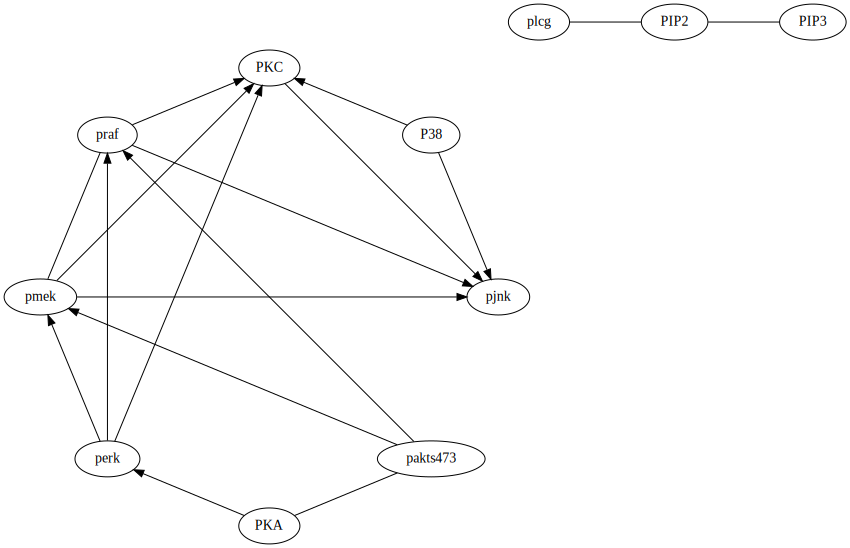

In [24]:
data_exp1_6_drop = data_exp1_6.drop(columns='experiment')
tester1_6 = IndependenceTester(data_exp1_6_drop, ParCorr(), alpha=0.1)

G = PC_algorithm(11, tester1_6)
graph_to_graphviz(G, list(data_exp1_6_drop.columns))

test: 0 and 1 given () -> pval=0.0
test: 0 and 2 given () -> pval=0.22579211347507994
independence found: 0 and 2 given ()
test: 0 and 3 given () -> pval=0.03332165389820263
test: 0 and 4 given () -> pval=0.0018048301566494169
test: 0 and 5 given () -> pval=2.4846295816511114e-70
test: 0 and 6 given () -> pval=1.795947241414922e-29
test: 0 and 7 given () -> pval=6.091908195017966e-12
test: 0 and 8 given () -> pval=4.579202937137639e-62
test: 0 and 9 given () -> pval=0.016423604063641198
test: 0 and 10 given () -> pval=5.139426589447728e-26
test: 1 and 0 given () -> pval=0.0
test: 1 and 2 given () -> pval=0.10463195222143483
test: 1 and 3 given () -> pval=0.02337330991619621
test: 1 and 4 given () -> pval=0.0007183354978785982
test: 1 and 5 given () -> pval=1.491894310801781e-110
test: 1 and 6 given () -> pval=4.1379458633678395e-49
test: 1 and 7 given () -> pval=2.0093199621435567e-18
test: 1 and 8 given () -> pval=1.6347190760257162e-95
test: 1 and 9 given () -> pval=0.025241806301168

test: 3 and 4 given (7,) -> pval=2.983804013170816e-70
test: 3 and 4 given (8,) -> pval=6.152085739514567e-70
test: 3 and 4 given (9,) -> pval=9.366166586824903e-71
test: 3 and 4 given (10,) -> pval=2.121335601147102e-70
test: 3 and 5 given (0,) -> pval=0.15440149732279027
test: 3 and 5 given (1,) -> pval=0.23414439006992138
independence found: 3 and 5 given (1,)
test: 3 and 7 given (0,) -> pval=0.04332635944104688
test: 3 and 7 given (1,) -> pval=0.05607956484331382
test: 3 and 7 given (2,) -> pval=0.023514277385573965
test: 3 and 7 given (4,) -> pval=0.15964615013636865
test: 3 and 7 given (5,) -> pval=0.2134332180259313
independence found: 3 and 7 given (5,)
test: 3 and 8 given (0,) -> pval=0.03359115179046628
test: 3 and 8 given (1,) -> pval=0.05223965708891499
test: 3 and 8 given (2,) -> pval=0.010175601244725522
test: 3 and 8 given (4,) -> pval=0.09418911088150757
test: 3 and 8 given (5,) -> pval=0.032828247046488346
test: 3 and 8 given (6,) -> pval=0.0029344391609487474
test: 3 

test: 7 and 9 given (4,) -> pval=0.09411505909276968
test: 7 and 9 given (5,) -> pval=0.5062965496386069
independence found: 7 and 9 given (5,)
test: 7 and 10 given (0,) -> pval=0.011669670447339978
test: 7 and 10 given (1,) -> pval=0.16376544843461474
test: 7 and 10 given (2,) -> pval=3.6720676347221373e-05
test: 7 and 10 given (3,) -> pval=5.131743644761772e-05
test: 7 and 10 given (4,) -> pval=5.8713785761107634e-05
test: 7 and 10 given (5,) -> pval=0.0020449533909233397
test: 7 and 10 given (6,) -> pval=1.3276613167229432e-12
test: 7 and 10 given (8,) -> pval=0.06610803019639967
test: 7 and 10 given (9,) -> pval=0.00010834917968624528
test: 8 and 0 given (1,) -> pval=5.298543741848871e-11
test: 8 and 0 given (2,) -> pval=9.557173906528252e-62
test: 8 and 0 given (3,) -> pval=2.5578274623344847e-61
test: 8 and 0 given (4,) -> pval=7.220803740682309e-61
test: 8 and 0 given (5,) -> pval=1.2374016540765652e-31
test: 8 and 0 given (6,) -> pval=6.489560673438371e-50
test: 8 and 0 given (

test: 0 and 5 given (4, 9) -> pval=8.035169619100416e-69
test: 0 and 5 given (4, 10) -> pval=2.4930957594104073e-56
test: 0 and 5 given (6, 7) -> pval=3.2896055644661414e-69
test: 0 and 5 given (6, 8) -> pval=1.81393650770237e-64
test: 0 and 5 given (6, 9) -> pval=2.0523800948131697e-99
test: 0 and 5 given (6, 10) -> pval=1.4625607431256938e-85
test: 0 and 5 given (7, 8) -> pval=1.0015149447545594e-40
test: 0 and 5 given (7, 9) -> pval=1.0596009954955639e-66
test: 0 and 5 given (7, 10) -> pval=7.217456022179741e-55
test: 0 and 5 given (8, 9) -> pval=1.6396179448400177e-34
test: 0 and 5 given (8, 10) -> pval=1.401400552421808e-36
test: 0 and 5 given (9, 10) -> pval=7.423618301150552e-57
test: 0 and 6 given (1, 2) -> pval=2.1867279917421975e-10
test: 0 and 6 given (1, 3) -> pval=2.2753330587667365e-10
test: 0 and 6 given (1, 4) -> pval=2.2804857673317573e-10
test: 0 and 6 given (1, 5) -> pval=3.568506855710222e-28
test: 0 and 6 given (1, 7) -> pval=4.879334349684408e-19
test: 0 and 6 giv

test: 1 and 6 given (2, 10) -> pval=9.457115271030292e-40
test: 1 and 6 given (3, 4) -> pval=3.3690398243691655e-49
test: 1 and 6 given (3, 5) -> pval=7.201360307409723e-115
test: 1 and 6 given (3, 7) -> pval=1.0188180114274952e-87
test: 1 and 6 given (3, 8) -> pval=1.7382159930121817e-32
test: 1 and 6 given (3, 9) -> pval=2.3462571036817337e-49
test: 1 and 6 given (3, 10) -> pval=4.974709784822815e-40
test: 1 and 6 given (4, 5) -> pval=2.0247043223273748e-114
test: 1 and 6 given (4, 7) -> pval=4.299536636486765e-87
test: 1 and 6 given (4, 8) -> pval=2.3187683727496467e-32
test: 1 and 6 given (4, 9) -> pval=5.815088902506597e-49
test: 1 and 6 given (4, 10) -> pval=8.774069117753066e-40
test: 1 and 6 given (5, 7) -> pval=2.8762698321473765e-104
test: 1 and 6 given (5, 8) -> pval=1.9368628525669553e-86
test: 1 and 6 given (5, 9) -> pval=1.6601369236927887e-114
test: 1 and 6 given (5, 10) -> pval=4.344282215114241e-101
test: 1 and 6 given (7, 8) -> pval=1.2393110442825012e-57
test: 1 and 

test: 3 and 2 given (1, 5) -> pval=8.98633141641372e-06
test: 3 and 2 given (1, 6) -> pval=8.049874893102723e-06
test: 3 and 2 given (1, 7) -> pval=8.508557503091557e-06
test: 3 and 2 given (1, 8) -> pval=1.0527448922032429e-05
test: 3 and 2 given (1, 9) -> pval=8.027442686301905e-06
test: 3 and 2 given (1, 10) -> pval=8.946458678980062e-06
test: 3 and 2 given (4, 5) -> pval=0.0006562231696716158
test: 3 and 2 given (4, 6) -> pval=0.0005326228814110943
test: 3 and 2 given (4, 7) -> pval=0.0005860782637655489
test: 3 and 2 given (4, 8) -> pval=0.0007071141348386218
test: 3 and 2 given (4, 9) -> pval=0.0005528534325060912
test: 3 and 2 given (4, 10) -> pval=0.0006150613691984392
test: 3 and 2 given (5, 6) -> pval=7.996230906518254e-06
test: 3 and 2 given (5, 7) -> pval=7.526548664829053e-06
test: 3 and 2 given (5, 8) -> pval=1.131714397988802e-05
test: 3 and 2 given (5, 9) -> pval=8.37002094161289e-06
test: 3 and 2 given (5, 10) -> pval=9.569461116025244e-06
test: 3 and 2 given (6, 7) ->

test: 5 and 1 given (6, 7) -> pval=7.719764525899089e-121
test: 5 and 1 given (6, 8) -> pval=1.2728294094133054e-121
test: 5 and 1 given (6, 9) -> pval=3.384924486041607e-175
test: 5 and 1 given (6, 10) -> pval=2.967020807040734e-152
test: 5 and 1 given (7, 8) -> pval=1.7777100326276214e-67
test: 5 and 1 given (7, 9) -> pval=5.4305078495810825e-104
test: 5 and 1 given (7, 10) -> pval=1.5653905686736173e-86
test: 5 and 1 given (8, 9) -> pval=9.426200341220741e-59
test: 5 and 1 given (8, 10) -> pval=5.163003071137407e-62
test: 5 and 1 given (9, 10) -> pval=5.62164954654876e-91
test: 5 and 6 given (0, 1) -> pval=4.350765917433919e-96
test: 5 and 6 given (0, 2) -> pval=9.993035064973314e-43
test: 5 and 6 given (0, 3) -> pval=1.6352192166921287e-42
test: 5 and 6 given (0, 4) -> pval=1.0979241126764522e-42
test: 5 and 6 given (0, 7) -> pval=5.337727096051668e-05
test: 5 and 6 given (0, 8) -> pval=2.294920962396172e-56
test: 5 and 6 given (0, 9) -> pval=1.0823997275845705e-42
test: 5 and 6 gi

test: 6 and 7 given (0, 8) -> pval=3.76300767131105e-75
test: 6 and 7 given (0, 9) -> pval=5.3740355114740905e-67
test: 6 and 7 given (0, 10) -> pval=1.4599834837400697e-70
test: 6 and 7 given (1, 2) -> pval=1.1234702896792932e-84
test: 6 and 7 given (1, 3) -> pval=2.355527904172756e-84
test: 6 and 7 given (1, 4) -> pval=1.1479581382281246e-84
test: 6 and 7 given (1, 5) -> pval=6.483856702099839e-26
test: 6 and 7 given (1, 8) -> pval=3.60344260748347e-88
test: 6 and 7 given (1, 9) -> pval=1.0317927690826225e-84
test: 6 and 7 given (1, 10) -> pval=4.522641154718017e-86
test: 6 and 7 given (2, 3) -> pval=4.329914310531672e-46
test: 6 and 7 given (2, 4) -> pval=1.2977715958244258e-46
test: 6 and 7 given (2, 5) -> pval=2.367396449791186e-36
test: 6 and 7 given (2, 8) -> pval=7.43248657987042e-63
test: 6 and 7 given (2, 9) -> pval=2.156845377171228e-46
test: 6 and 7 given (2, 10) -> pval=2.7351246419283674e-53
test: 6 and 7 given (3, 4) -> pval=1.895608551818022e-46
test: 6 and 7 given (3, 

test: 8 and 1 given (0, 3) -> pval=1.694964264675584e-44
test: 8 and 1 given (0, 4) -> pval=2.3245444869937305e-44
test: 8 and 1 given (0, 5) -> pval=3.7473647263233424e-29
test: 8 and 1 given (0, 6) -> pval=4.970456657457034e-39
test: 8 and 1 given (0, 7) -> pval=2.475263656455728e-41
test: 8 and 1 given (0, 9) -> pval=9.43382153945561e-63
test: 8 and 1 given (0, 10) -> pval=6.175290129141928e-32
test: 8 and 1 given (2, 3) -> pval=3.469980286355546e-94
test: 8 and 1 given (2, 4) -> pval=1.2665353750371022e-93
test: 8 and 1 given (2, 5) -> pval=2.2252891831041797e-52
test: 8 and 1 given (2, 6) -> pval=3.164946816352915e-78
test: 8 and 1 given (2, 7) -> pval=1.73526334701008e-86
test: 8 and 1 given (2, 9) -> pval=4.609731843482416e-117
test: 8 and 1 given (2, 10) -> pval=2.450358417300782e-68
test: 8 and 1 given (3, 4) -> pval=8.928023317287611e-94
test: 8 and 1 given (3, 5) -> pval=3.451851157955893e-52
test: 8 and 1 given (3, 6) -> pval=1.188927060807089e-77
test: 8 and 1 given (3, 7)

test: 9 and 8 given (2, 6) -> pval=3.6678860429377424e-115
test: 9 and 8 given (2, 7) -> pval=2.2427936500589372e-110
test: 9 and 8 given (2, 10) -> pval=2.2760324162648089e-94
test: 9 and 8 given (3, 4) -> pval=2.8409421189763104e-109
test: 9 and 8 given (3, 5) -> pval=5.2577361496464627e-120
test: 9 and 8 given (3, 6) -> pval=1.149936933961335e-114
test: 9 and 8 given (3, 7) -> pval=6.096450919703314e-110
test: 9 and 8 given (3, 10) -> pval=4.906489130146724e-94
test: 9 and 8 given (4, 5) -> pval=6.806504672791895e-120
test: 9 and 8 given (4, 6) -> pval=1.5661276314931439e-114
test: 9 and 8 given (4, 7) -> pval=7.951978705517855e-110
test: 9 and 8 given (4, 10) -> pval=5.660242410385537e-94
test: 9 and 8 given (5, 6) -> pval=6.279705816700733e-132
test: 9 and 8 given (5, 7) -> pval=3.5065594406152245e-122
test: 9 and 8 given (5, 10) -> pval=1.5240697491893396e-106
test: 9 and 8 given (6, 7) -> pval=1.5130847446051134e-118
test: 9 and 8 given (6, 10) -> pval=1.102573756581464e-99
test

test: 10 and 8 given (7, 9) -> pval=3.065535479239431e-29
test: 10 and 9 given (0, 1) -> pval=5.6231763658063955e-18
test: 10 and 9 given (0, 2) -> pval=7.771741635015141e-17
test: 10 and 9 given (0, 3) -> pval=1.0141159470303567e-16
test: 10 and 9 given (0, 4) -> pval=1.0904219412622964e-16
test: 10 and 9 given (0, 5) -> pval=1.26645695767247e-16
test: 10 and 9 given (0, 6) -> pval=4.240220641642971e-17
test: 10 and 9 given (0, 7) -> pval=1.30174489967592e-16
test: 10 and 9 given (0, 8) -> pval=0.004371519432128561
test: 10 and 9 given (1, 2) -> pval=4.352698733489117e-17
test: 10 and 9 given (1, 3) -> pval=5.5356134139400886e-17
test: 10 and 9 given (1, 4) -> pval=5.760300352738325e-17
test: 10 and 9 given (1, 5) -> pval=6.593421045361753e-17
test: 10 and 9 given (1, 6) -> pval=3.107080554373616e-17
test: 10 and 9 given (1, 7) -> pval=5.713289171578391e-17
test: 10 and 9 given (1, 8) -> pval=5.709366759211572e-05
test: 10 and 9 given (2, 3) -> pval=6.771856618856965e-18
test: 10 and 

test: 0 and 6 given (1, 8, 9) -> pval=8.501092438328149e-09
test: 0 and 6 given (1, 8, 10) -> pval=6.769160248372824e-09
test: 0 and 6 given (1, 9, 10) -> pval=1.98823943458232e-09
test: 0 and 6 given (2, 3, 4) -> pval=1.9722038301207085e-29
test: 0 and 6 given (2, 3, 5) -> pval=2.012829092412185e-59
test: 0 and 6 given (2, 3, 7) -> pval=2.894856489375498e-50
test: 0 and 6 given (2, 3, 8) -> pval=2.130612770167866e-17
test: 0 and 6 given (2, 3, 9) -> pval=1.4964416008420497e-29
test: 0 and 6 given (2, 3, 10) -> pval=3.300453665555985e-23
test: 0 and 6 given (2, 4, 5) -> pval=4.5397146197749745e-59
test: 0 and 6 given (2, 4, 7) -> pval=8.561883786604233e-50
test: 0 and 6 given (2, 4, 8) -> pval=2.7171332629429598e-17
test: 0 and 6 given (2, 4, 9) -> pval=2.951283379877946e-29
test: 0 and 6 given (2, 4, 10) -> pval=5.112299134732696e-23
test: 0 and 6 given (2, 5, 7) -> pval=1.477228604852063e-52
test: 0 and 6 given (2, 5, 8) -> pval=6.723114277608707e-42
test: 0 and 6 given (2, 5, 9) -> 

test: 0 and 10 given (5, 7, 8) -> pval=0.00010831823960530974
test: 0 and 10 given (5, 7, 9) -> pval=1.1171621902786112e-10
test: 0 and 10 given (5, 8, 9) -> pval=5.962984497690678e-06
test: 0 and 10 given (6, 7, 8) -> pval=2.5829277997244622e-05
test: 0 and 10 given (6, 7, 9) -> pval=7.994002720309966e-13
test: 0 and 10 given (6, 8, 9) -> pval=8.348012380119182e-08
test: 0 and 10 given (7, 8, 9) -> pval=3.2418801635726963e-09
test: 1 and 0 given (2, 3, 4) -> pval=0.0
test: 1 and 0 given (2, 3, 5) -> pval=0.0
test: 1 and 0 given (2, 3, 6) -> pval=0.0
test: 1 and 0 given (2, 3, 7) -> pval=0.0
test: 1 and 0 given (2, 3, 8) -> pval=0.0
test: 1 and 0 given (2, 3, 9) -> pval=0.0
test: 1 and 0 given (2, 3, 10) -> pval=0.0
test: 1 and 0 given (2, 4, 5) -> pval=0.0
test: 1 and 0 given (2, 4, 6) -> pval=0.0
test: 1 and 0 given (2, 4, 7) -> pval=0.0
test: 1 and 0 given (2, 4, 8) -> pval=0.0
test: 1 and 0 given (2, 4, 9) -> pval=0.0
test: 1 and 0 given (2, 4, 10) -> pval=0.0
test: 1 and 0 given (

test: 1 and 6 given (3, 4, 10) -> pval=6.749601995978996e-40
test: 1 and 6 given (3, 5, 7) -> pval=2.890158863895841e-104
test: 1 and 6 given (3, 5, 8) -> pval=1.4086784340734633e-86
test: 1 and 6 given (3, 5, 9) -> pval=1.239139149751595e-114
test: 1 and 6 given (3, 5, 10) -> pval=3.0169542006127315e-101
test: 1 and 6 given (3, 7, 8) -> pval=1.0746067067433384e-57
test: 1 and 6 given (3, 7, 9) -> pval=2.201137905597875e-87
test: 1 and 6 given (3, 7, 10) -> pval=1.3135821245761705e-72
test: 1 and 6 given (3, 8, 9) -> pval=3.2261773985119932e-28
test: 1 and 6 given (3, 8, 10) -> pval=1.949357885727235e-29
test: 1 and 6 given (3, 9, 10) -> pval=6.130419655604396e-40
test: 1 and 6 given (4, 5, 7) -> pval=1.2054708156129762e-103
test: 1 and 6 given (4, 5, 8) -> pval=2.067705626567435e-86
test: 1 and 6 given (4, 5, 9) -> pval=3.365994305469019e-114
test: 1 and 6 given (4, 5, 10) -> pval=5.851686704450602e-101
test: 1 and 6 given (4, 7, 8) -> pval=1.990378339546862e-57
test: 1 and 6 given (4

test: 2 and 3 given (0, 8, 10) -> pval=1.1113228030750354e-05
test: 2 and 3 given (0, 9, 10) -> pval=8.478779596675184e-06
test: 2 and 3 given (1, 4, 5) -> pval=0.0006680267619750146
test: 2 and 3 given (1, 4, 6) -> pval=0.0006221514954127543
test: 2 and 3 given (1, 4, 7) -> pval=0.0006293162211098503
test: 2 and 3 given (1, 4, 8) -> pval=0.0007144632262295126
test: 2 and 3 given (1, 4, 9) -> pval=0.0006136037024045174
test: 2 and 3 given (1, 4, 10) -> pval=0.0006482501149005293
test: 2 and 3 given (1, 5, 6) -> pval=8.756536829171465e-06
test: 2 and 3 given (1, 5, 7) -> pval=8.478431996492893e-06
test: 2 and 3 given (1, 5, 8) -> pval=1.154493714833031e-05
test: 2 and 3 given (1, 5, 9) -> pval=9.320331382951784e-06
test: 2 and 3 given (1, 5, 10) -> pval=1.0155979281772018e-05
test: 2 and 3 given (1, 6, 7) -> pval=8.590453701827673e-06
test: 2 and 3 given (1, 6, 8) -> pval=1.1216787019391037e-05
test: 2 and 3 given (1, 6, 9) -> pval=8.383520506707196e-06
test: 2 and 3 given (1, 6, 10) ->

test: 3 and 4 given (0, 1, 7) -> pval=1.5049858068419546e-69
test: 3 and 4 given (0, 1, 8) -> pval=1.3186311869947895e-69
test: 3 and 4 given (0, 1, 9) -> pval=8.450678947421865e-70
test: 3 and 4 given (0, 1, 10) -> pval=9.059071460155828e-70
test: 3 and 4 given (0, 2, 5) -> pval=3.776149388673666e-68
test: 3 and 4 given (0, 2, 6) -> pval=2.5348678522266944e-68
test: 3 and 4 given (0, 2, 7) -> pval=8.41185344367592e-68
test: 3 and 4 given (0, 2, 8) -> pval=7.4852514098614e-68
test: 3 and 4 given (0, 2, 9) -> pval=4.229887692579126e-68
test: 3 and 4 given (0, 2, 10) -> pval=5.059201954119609e-68
test: 3 and 4 given (0, 5, 6) -> pval=5.4248634427398086e-70
test: 3 and 4 given (0, 5, 7) -> pval=1.297632385496909e-69
test: 3 and 4 given (0, 5, 8) -> pval=1.5875864892944042e-69
test: 3 and 4 given (0, 5, 9) -> pval=9.838327323804397e-70
test: 3 and 4 given (0, 5, 10) -> pval=1.1092081720710034e-69
test: 3 and 4 given (0, 6, 7) -> pval=1.1134362814394303e-69
test: 3 and 4 given (0, 6, 8) -> 

test: 4 and 3 given (5, 8, 10) -> pval=1.688457617461728e-69
test: 4 and 3 given (5, 9, 10) -> pval=8.457978625586047e-70
test: 4 and 3 given (6, 7, 8) -> pval=1.729702181093735e-69
test: 4 and 3 given (6, 7, 9) -> pval=5.814328112192057e-70
test: 4 and 3 given (6, 7, 10) -> pval=9.165701661716293e-70
test: 4 and 3 given (6, 8, 9) -> pval=6.373169952770186e-70
test: 4 and 3 given (6, 8, 10) -> pval=1.0996577471159209e-69
test: 4 and 3 given (6, 9, 10) -> pval=2.7799413424418755e-70
test: 4 and 3 given (7, 8, 9) -> pval=2.34225947671165e-69
test: 4 and 3 given (7, 8, 10) -> pval=3.540008208523832e-69
test: 4 and 3 given (7, 9, 10) -> pval=1.4628450077528952e-69
test: 4 and 3 given (8, 9, 10) -> pval=1.2000437328027813e-69
test: 5 and 0 given (1, 2, 3) -> pval=8.870961084589035e-14
test: 5 and 0 given (1, 2, 4) -> pval=9.269296164460438e-14
test: 5 and 0 given (1, 2, 6) -> pval=1.7605564276764189e-31
test: 5 and 0 given (1, 2, 7) -> pval=6.209771485555308e-12
test: 5 and 0 given (1, 2, 8

test: 5 and 7 given (1, 8, 10) -> pval=2.217606447722102e-180
test: 5 and 7 given (1, 9, 10) -> pval=1.451854828789801e-182
test: 5 and 7 given (2, 3, 4) -> pval=2.6183881027891997e-187
test: 5 and 7 given (2, 3, 6) -> pval=4.917448790346987e-178
test: 5 and 7 given (2, 3, 8) -> pval=6.935600222590868e-180
test: 5 and 7 given (2, 3, 9) -> pval=3.453800742239364e-187
test: 5 and 7 given (2, 3, 10) -> pval=2.6145117279790538e-186
test: 5 and 7 given (2, 4, 6) -> pval=1.1417961561909887e-177
test: 5 and 7 given (2, 4, 8) -> pval=7.347091412064767e-180
test: 5 and 7 given (2, 4, 9) -> pval=4.656554116450457e-187
test: 5 and 7 given (2, 4, 10) -> pval=2.9550158612501576e-186
test: 5 and 7 given (2, 6, 8) -> pval=3.8131395356897775e-151
test: 5 and 7 given (2, 6, 9) -> pval=5.120897183138313e-178
test: 5 and 7 given (2, 6, 10) -> pval=6.229909992132647e-168
test: 5 and 7 given (2, 8, 9) -> pval=4.585003702360331e-181
test: 5 and 7 given (2, 8, 10) -> pval=1.8036930959269762e-180
test: 5 and 

test: 6 and 0 given (1, 7, 8) -> pval=1.0133832534174247e-16
test: 6 and 0 given (1, 7, 9) -> pval=4.462501507874357e-19
test: 6 and 0 given (1, 7, 10) -> pval=1.9140059219120262e-17
test: 6 and 0 given (1, 8, 9) -> pval=8.501092438328086e-09
test: 6 and 0 given (1, 8, 10) -> pval=6.769160248372775e-09
test: 6 and 0 given (1, 9, 10) -> pval=1.98823943458232e-09
test: 6 and 0 given (2, 3, 4) -> pval=1.9722038301206244e-29
test: 6 and 0 given (2, 3, 5) -> pval=2.012829092412299e-59
test: 6 and 0 given (2, 3, 7) -> pval=2.894856489375498e-50
test: 6 and 0 given (2, 3, 8) -> pval=2.130612770167866e-17
test: 6 and 0 given (2, 3, 9) -> pval=1.4964416008420926e-29
test: 6 and 0 given (2, 3, 10) -> pval=3.300453665555985e-23
test: 6 and 0 given (2, 4, 5) -> pval=4.539714619775234e-59
test: 6 and 0 given (2, 4, 7) -> pval=8.561883786604233e-50
test: 6 and 0 given (2, 4, 8) -> pval=2.7171332629430184e-17
test: 6 and 0 given (2, 4, 9) -> pval=2.951283379877946e-29
test: 6 and 0 given (2, 4, 10) -

test: 6 and 7 given (5, 8, 9) -> pval=6.103728663996071e-32
test: 6 and 7 given (5, 8, 10) -> pval=1.0585077914233516e-32
test: 6 and 7 given (5, 9, 10) -> pval=3.605285542665168e-34
test: 6 and 7 given (8, 9, 10) -> pval=4.094049608469651e-69
test: 6 and 8 given (0, 1, 2) -> pval=0.07656890036705491
test: 6 and 8 given (0, 1, 3) -> pval=0.06803020726663839
test: 6 and 8 given (0, 1, 4) -> pval=0.07549427180617477
test: 6 and 8 given (0, 1, 5) -> pval=1.756163928037131e-07
test: 6 and 8 given (0, 1, 7) -> pval=0.0003316585391842751
test: 6 and 8 given (0, 1, 9) -> pval=0.027150834002211095
test: 6 and 8 given (0, 1, 10) -> pval=0.14911389969641506
test: 6 and 8 given (0, 2, 3) -> pval=5.6838808527129675e-08
test: 6 and 8 given (0, 2, 4) -> pval=7.495307129247651e-08
test: 6 and 8 given (0, 2, 5) -> pval=1.2923267291464545e-21
test: 6 and 8 given (0, 2, 7) -> pval=3.8560273533364014e-16
test: 6 and 8 given (0, 2, 9) -> pval=1.41212384303887e-10
test: 6 and 8 given (0, 2, 10) -> pval=1.5

test: 7 and 5 given (2, 3, 8) -> pval=6.935600222590868e-180
test: 7 and 5 given (2, 3, 9) -> pval=3.453800742239364e-187
test: 7 and 5 given (2, 3, 10) -> pval=2.6145117279795004e-186
test: 7 and 5 given (2, 4, 6) -> pval=1.1417961561909887e-177
test: 7 and 5 given (2, 4, 8) -> pval=7.347091412064767e-180
test: 7 and 5 given (2, 4, 9) -> pval=4.656554116450457e-187
test: 7 and 5 given (2, 4, 10) -> pval=2.95501586124898e-186
test: 7 and 5 given (2, 6, 8) -> pval=3.8131395356897775e-151
test: 7 and 5 given (2, 6, 9) -> pval=5.120897183138313e-178
test: 7 and 5 given (2, 6, 10) -> pval=6.229909992132647e-168
test: 7 and 5 given (2, 8, 9) -> pval=4.585003702360331e-181
test: 7 and 5 given (2, 8, 10) -> pval=1.8036930959273868e-180
test: 7 and 5 given (2, 9, 10) -> pval=5.005478061796161e-187
test: 7 and 5 given (3, 4, 6) -> pval=1.5799193806467403e-177
test: 7 and 5 given (3, 4, 8) -> pval=1.0232188149246535e-179
test: 7 and 5 given (3, 4, 9) -> pval=8.785790443107019e-187
test: 7 and 5 

test: 8 and 1 given (0, 4, 10) -> pval=8.657957559025153e-32
test: 8 and 1 given (0, 5, 6) -> pval=4.634248810737839e-15
test: 8 and 1 given (0, 5, 7) -> pval=2.035700381291636e-28
test: 8 and 1 given (0, 5, 9) -> pval=9.159495543302307e-43
test: 8 and 1 given (0, 5, 10) -> pval=3.908561919430197e-21
test: 8 and 1 given (0, 6, 7) -> pval=1.269562798703699e-29
test: 8 and 1 given (0, 6, 9) -> pval=7.747575944435433e-55
test: 8 and 1 given (0, 6, 10) -> pval=2.6216002981340345e-28
test: 8 and 1 given (0, 7, 9) -> pval=5.302226605961618e-59
test: 8 and 1 given (0, 7, 10) -> pval=1.644091378372434e-29
test: 8 and 1 given (0, 9, 10) -> pval=4.616201251941206e-52
test: 8 and 1 given (2, 3, 4) -> pval=2.0173938207870994e-93
test: 8 and 1 given (2, 3, 5) -> pval=4.4761494919347696e-52
test: 8 and 1 given (2, 3, 6) -> pval=2.7018320039702615e-77
test: 8 and 1 given (2, 3, 7) -> pval=5.9451574393854735e-86
test: 8 and 1 given (2, 3, 9) -> pval=2.5257884680993666e-116
test: 8 and 1 given (2, 3, 1

test: 8 and 6 given (4, 5, 7) -> pval=4.020412528676621e-36
test: 8 and 6 given (4, 5, 9) -> pval=1.4319904946222757e-50
test: 8 and 6 given (4, 5, 10) -> pval=1.6031902565761794e-28
test: 8 and 6 given (4, 7, 9) -> pval=7.744232813826844e-45
test: 8 and 6 given (4, 7, 10) -> pval=4.485804494859148e-25
test: 8 and 6 given (4, 9, 10) -> pval=1.2409336270605086e-18
test: 8 and 6 given (5, 7, 9) -> pval=2.9124445109529567e-46
test: 8 and 6 given (5, 7, 10) -> pval=5.137543502967464e-27
test: 8 and 6 given (5, 9, 10) -> pval=5.029660920535629e-42
test: 8 and 6 given (7, 9, 10) -> pval=1.0342484666964586e-34
test: 8 and 9 given (0, 1, 2) -> pval=2.4910274927581413e-138
test: 8 and 9 given (0, 1, 3) -> pval=5.787550997580968e-138
test: 8 and 9 given (0, 1, 4) -> pval=6.125965261806444e-138
test: 8 and 9 given (0, 1, 5) -> pval=1.994528078569185e-139
test: 8 and 9 given (0, 1, 6) -> pval=1.1216063242450697e-138
test: 8 and 9 given (0, 1, 7) -> pval=7.034050653581941e-138
test: 8 and 9 given (

test: 9 and 8 given (1, 7, 10) -> pval=4.932839890051162e-120
test: 9 and 8 given (2, 3, 4) -> pval=2.4762141744329093e-109
test: 9 and 8 given (2, 3, 5) -> pval=5.221741031543481e-120
test: 9 and 8 given (2, 3, 6) -> pval=1.0086857584575147e-114
test: 9 and 8 given (2, 3, 7) -> pval=5.413801057274382e-110
test: 9 and 8 given (2, 3, 10) -> pval=3.9981160998534324e-94
test: 9 and 8 given (2, 4, 5) -> pval=6.771489681761872e-120
test: 9 and 8 given (2, 4, 6) -> pval=1.3553586069605922e-114
test: 9 and 8 given (2, 4, 7) -> pval=7.05914079058919e-110
test: 9 and 8 given (2, 4, 10) -> pval=4.579533914198229e-94
test: 9 and 8 given (2, 5, 6) -> pval=6.65315265234151e-132
test: 9 and 8 given (2, 5, 7) -> pval=3.7004492877450967e-122
test: 9 and 8 given (2, 5, 10) -> pval=1.440018224508753e-106
test: 9 and 8 given (2, 6, 7) -> pval=1.4027867172838163e-118
test: 9 and 8 given (2, 6, 10) -> pval=8.688815161760127e-100
test: 9 and 8 given (2, 7, 10) -> pval=3.072811846942101e-95
test: 9 and 8 giv

test: 10 and 1 given (0, 7, 9) -> pval=4.1338499414988005e-27
test: 10 and 1 given (0, 8, 9) -> pval=1.8992901265183357e-17
test: 10 and 1 given (2, 3, 4) -> pval=3.1509368494320396e-42
test: 10 and 1 given (2, 3, 5) -> pval=1.2940316911876741e-23
test: 10 and 1 given (2, 3, 6) -> pval=2.577283853271735e-33
test: 10 and 1 given (2, 3, 7) -> pval=1.6390948639172144e-39
test: 10 and 1 given (2, 3, 8) -> pval=2.684238744400776e-16
test: 10 and 1 given (2, 3, 9) -> pval=9.173337800627908e-42
test: 10 and 1 given (2, 4, 5) -> pval=2.202005825598607e-23
test: 10 and 1 given (2, 4, 6) -> pval=4.1406146909779674e-33
test: 10 and 1 given (2, 4, 7) -> pval=3.274913345484701e-39
test: 10 and 1 given (2, 4, 8) -> pval=3.6796350328483483e-16
test: 10 and 1 given (2, 4, 9) -> pval=1.831331843225212e-41
test: 10 and 1 given (2, 5, 6) -> pval=4.64930431525966e-10
test: 10 and 1 given (2, 5, 7) -> pval=3.6670505387435317e-22
test: 10 and 1 given (2, 5, 8) -> pval=8.449306473141898e-11
test: 10 and 1 gi

test: 10 and 6 given (5, 8, 9) -> pval=1.2371665857108034e-11
test: 10 and 6 given (7, 8, 9) -> pval=8.74594059784408e-09
test: 10 and 8 given (0, 1, 2) -> pval=2.563553477939388e-17
test: 10 and 8 given (0, 1, 3) -> pval=3.270224300801e-17
test: 10 and 8 given (0, 1, 4) -> pval=3.0315734302057726e-17
test: 10 and 8 given (0, 1, 5) -> pval=3.351676422857627e-16
test: 10 and 8 given (0, 1, 6) -> pval=3.401955909598222e-17
test: 10 and 8 given (0, 1, 7) -> pval=2.9748889653825056e-17
test: 10 and 8 given (0, 1, 9) -> pval=8.19465879886819e-06
test: 10 and 8 given (0, 2, 3) -> pval=1.0764010390737748e-29
test: 10 and 8 given (0, 2, 4) -> pval=1.1249405153280324e-29
test: 10 and 8 given (0, 2, 5) -> pval=4.261107106147841e-24
test: 10 and 8 given (0, 2, 6) -> pval=9.91110510233905e-28
test: 10 and 8 given (0, 2, 7) -> pval=6.58952874811389e-29
test: 10 and 8 given (0, 2, 9) -> pval=1.6221118462750046e-16
test: 10 and 8 given (0, 3, 4) -> pval=1.0137159701861755e-29
test: 10 and 8 given (0,

test: 0 and 1 given (2, 7, 9, 10) -> pval=0.0
test: 0 and 1 given (2, 8, 9, 10) -> pval=0.0
test: 0 and 1 given (3, 4, 5, 6) -> pval=0.0
test: 0 and 1 given (3, 4, 5, 7) -> pval=0.0
test: 0 and 1 given (3, 4, 5, 8) -> pval=0.0
test: 0 and 1 given (3, 4, 5, 9) -> pval=0.0
test: 0 and 1 given (3, 4, 5, 10) -> pval=0.0
test: 0 and 1 given (3, 4, 6, 7) -> pval=0.0
test: 0 and 1 given (3, 4, 6, 8) -> pval=0.0
test: 0 and 1 given (3, 4, 6, 9) -> pval=0.0
test: 0 and 1 given (3, 4, 6, 10) -> pval=0.0
test: 0 and 1 given (3, 4, 7, 8) -> pval=0.0
test: 0 and 1 given (3, 4, 7, 9) -> pval=0.0
test: 0 and 1 given (3, 4, 7, 10) -> pval=0.0
test: 0 and 1 given (3, 4, 8, 9) -> pval=0.0
test: 0 and 1 given (3, 4, 8, 10) -> pval=0.0
test: 0 and 1 given (3, 4, 9, 10) -> pval=0.0
test: 0 and 1 given (3, 5, 6, 7) -> pval=0.0
test: 0 and 1 given (3, 5, 6, 8) -> pval=0.0
test: 0 and 1 given (3, 5, 6, 9) -> pval=0.0
test: 0 and 1 given (3, 5, 6, 10) -> pval=0.0
test: 0 and 1 given (3, 5, 7, 8) -> pval=0.0
te

test: 0 and 6 given (1, 2, 9, 10) -> pval=1.9220307782586136e-09
test: 0 and 6 given (1, 3, 4, 5) -> pval=4.004157121157035e-28
test: 0 and 6 given (1, 3, 4, 7) -> pval=5.156857945063035e-19
test: 0 and 6 given (1, 3, 4, 8) -> pval=2.3179440638501468e-09
test: 0 and 6 given (1, 3, 4, 9) -> pval=2.383953237266654e-10
test: 0 and 6 given (1, 3, 4, 10) -> pval=1.690510581791702e-09
test: 0 and 6 given (1, 3, 5, 7) -> pval=9.298493898261796e-28
test: 0 and 6 given (1, 3, 5, 8) -> pval=6.250500433467505e-25
test: 0 and 6 given (1, 3, 5, 9) -> pval=3.591000905848793e-28
test: 0 and 6 given (1, 3, 5, 10) -> pval=9.675788999135722e-26
test: 0 and 6 given (1, 3, 7, 8) -> pval=1.1056864295332304e-16
test: 0 and 6 given (1, 3, 7, 9) -> pval=4.648035278365547e-19
test: 0 and 6 given (1, 3, 7, 10) -> pval=2.052589018144604e-17
test: 0 and 6 given (1, 3, 8, 9) -> pval=9.068540274460023e-09
test: 0 and 6 given (1, 3, 8, 10) -> pval=7.45210193821097e-09
test: 0 and 6 given (1, 3, 9, 10) -> pval=2.0579

test: 0 and 8 given (3, 6, 7, 9) -> pval=3.2681403068415306e-41
test: 0 and 8 given (3, 6, 7, 10) -> pval=5.1671097546114166e-27
test: 0 and 8 given (3, 6, 9, 10) -> pval=7.416029183175337e-47
test: 0 and 8 given (3, 7, 9, 10) -> pval=1.453462416903348e-52
test: 0 and 8 given (4, 5, 6, 7) -> pval=9.052716775767867e-14
test: 0 and 8 given (4, 5, 6, 9) -> pval=1.5038713013470475e-15
test: 0 and 8 given (4, 5, 6, 10) -> pval=1.2451291188899148e-11
test: 0 and 8 given (4, 5, 7, 9) -> pval=4.3118064043330195e-34
test: 0 and 8 given (4, 5, 7, 10) -> pval=7.338912221061735e-23
test: 0 and 8 given (4, 5, 9, 10) -> pval=3.6031783581457873e-31
test: 0 and 8 given (4, 6, 7, 9) -> pval=3.539104790780387e-41
test: 0 and 8 given (4, 6, 7, 10) -> pval=5.904516449537913e-27
test: 0 and 8 given (4, 6, 9, 10) -> pval=9.611462115803183e-47
test: 0 and 8 given (4, 7, 9, 10) -> pval=2.241654720278362e-52
test: 0 and 8 given (5, 6, 7, 9) -> pval=8.85191000582287e-16
test: 0 and 8 given (5, 6, 7, 10) -> pval

test: 1 and 0 given (3, 4, 9, 10) -> pval=0.0
test: 1 and 0 given (3, 5, 6, 7) -> pval=0.0
test: 1 and 0 given (3, 5, 6, 8) -> pval=0.0
test: 1 and 0 given (3, 5, 6, 9) -> pval=0.0
test: 1 and 0 given (3, 5, 6, 10) -> pval=0.0
test: 1 and 0 given (3, 5, 7, 8) -> pval=0.0
test: 1 and 0 given (3, 5, 7, 9) -> pval=0.0
test: 1 and 0 given (3, 5, 7, 10) -> pval=0.0
test: 1 and 0 given (3, 5, 8, 9) -> pval=0.0
test: 1 and 0 given (3, 5, 8, 10) -> pval=0.0
test: 1 and 0 given (3, 5, 9, 10) -> pval=0.0
test: 1 and 0 given (3, 6, 7, 8) -> pval=0.0
test: 1 and 0 given (3, 6, 7, 9) -> pval=0.0
test: 1 and 0 given (3, 6, 7, 10) -> pval=0.0
test: 1 and 0 given (3, 6, 8, 9) -> pval=0.0
test: 1 and 0 given (3, 6, 8, 10) -> pval=0.0
test: 1 and 0 given (3, 6, 9, 10) -> pval=0.0
test: 1 and 0 given (3, 7, 8, 9) -> pval=0.0
test: 1 and 0 given (3, 7, 8, 10) -> pval=0.0
test: 1 and 0 given (3, 7, 9, 10) -> pval=0.0
test: 1 and 0 given (3, 8, 9, 10) -> pval=0.0
test: 1 and 0 given (4, 5, 6, 7) -> pval=0.0

test: 1 and 6 given (0, 4, 5, 7) -> pval=2.4294120420846527e-79
test: 1 and 6 given (0, 4, 5, 8) -> pval=1.5119443822241365e-69
test: 1 and 6 given (0, 4, 5, 9) -> pval=1.6472810138103115e-83
test: 1 and 6 given (0, 4, 5, 10) -> pval=4.1981390870456084e-75
test: 1 and 6 given (0, 4, 7, 8) -> pval=9.746705724144358e-45
test: 1 and 6 given (0, 4, 7, 9) -> pval=2.341012014621574e-56
test: 1 and 6 given (0, 4, 7, 10) -> pval=1.2186904978684664e-49
test: 1 and 6 given (0, 4, 8, 9) -> pval=3.290997875768108e-22
test: 1 and 6 given (0, 4, 8, 10) -> pval=9.922250441750575e-23
test: 1 and 6 given (0, 4, 9, 10) -> pval=3.572598635638815e-26
test: 1 and 6 given (0, 5, 7, 8) -> pval=3.6157305898717507e-66
test: 1 and 6 given (0, 5, 7, 9) -> pval=1.6853608888414697e-79
test: 1 and 6 given (0, 5, 7, 10) -> pval=9.552525475058048e-72
test: 1 and 6 given (0, 5, 8, 9) -> pval=9.62794593862225e-64
test: 1 and 6 given (0, 5, 8, 10) -> pval=2.4750331483227436e-65
test: 1 and 6 given (0, 5, 9, 10) -> pval=

test: 1 and 10 given (0, 2, 3, 4) -> pval=1.0176557067176437e-26
test: 1 and 10 given (0, 2, 3, 5) -> pval=2.639797237953011e-19
test: 1 and 10 given (0, 2, 3, 6) -> pval=5.367890806420532e-23
test: 1 and 10 given (0, 2, 3, 7) -> pval=1.1278813891475382e-25
test: 1 and 10 given (0, 2, 3, 8) -> pval=2.949280222338763e-14
test: 1 and 10 given (0, 2, 3, 9) -> pval=6.102413456341013e-28
test: 1 and 10 given (0, 2, 4, 5) -> pval=3.270458398673461e-19
test: 1 and 10 given (0, 2, 4, 6) -> pval=6.021396896187153e-23
test: 1 and 10 given (0, 2, 4, 7) -> pval=1.375143979766235e-25
test: 1 and 10 given (0, 2, 4, 8) -> pval=3.335299989003811e-14
test: 1 and 10 given (0, 2, 4, 9) -> pval=7.360531572825789e-28
test: 1 and 10 given (0, 2, 5, 6) -> pval=7.828626748677161e-11
test: 1 and 10 given (0, 2, 5, 7) -> pval=1.2503159443508111e-18
test: 1 and 10 given (0, 2, 5, 8) -> pval=2.609695285259464e-11
test: 1 and 10 given (0, 2, 5, 9) -> pval=1.9574439999168443e-20
test: 1 and 10 given (0, 2, 6, 7) ->

test: 2 and 3 given (1, 7, 8, 9) -> pval=1.112765756893888e-05
test: 2 and 3 given (1, 7, 8, 10) -> pval=1.2082809326411987e-05
test: 2 and 3 given (1, 7, 9, 10) -> pval=9.895822163139867e-06
test: 2 and 3 given (1, 8, 9, 10) -> pval=1.1278011351067096e-05
test: 2 and 3 given (4, 5, 6, 7) -> pval=0.0006264214962055683
test: 2 and 3 given (4, 5, 6, 8) -> pval=0.0007521185048439163
test: 2 and 3 given (4, 5, 6, 9) -> pval=0.000646468096542463
test: 2 and 3 given (4, 5, 6, 10) -> pval=0.000685026938561963
test: 2 and 3 given (4, 5, 7, 8) -> pval=0.0007371059524259793
test: 2 and 3 given (4, 5, 7, 9) -> pval=0.0006438371928343223
test: 2 and 3 given (4, 5, 7, 10) -> pval=0.0006793503435668506
test: 2 and 3 given (4, 5, 8, 9) -> pval=0.0007601582236906866
test: 2 and 3 given (4, 5, 8, 10) -> pval=0.0007802122258706078
test: 2 and 3 given (4, 5, 9, 10) -> pval=0.0007036910833776137
test: 2 and 3 given (4, 6, 7, 8) -> pval=0.0007362378553630928
test: 2 and 3 given (4, 6, 7, 9) -> pval=0.00058

test: 3 and 2 given (0, 6, 9, 10) -> pval=8.684717927502978e-06
test: 3 and 2 given (0, 7, 8, 9) -> pval=1.0932041272076046e-05
test: 3 and 2 given (0, 7, 8, 10) -> pval=1.1961467227559123e-05
test: 3 and 2 given (0, 7, 9, 10) -> pval=9.4855570743261e-06
test: 3 and 2 given (0, 8, 9, 10) -> pval=1.1096075787951078e-05
test: 3 and 2 given (1, 4, 5, 6) -> pval=0.0006538063394652526
test: 3 and 2 given (1, 4, 5, 7) -> pval=0.0006480283492707919
test: 3 and 2 given (1, 4, 5, 8) -> pval=0.0007615995854298297
test: 3 and 2 given (1, 4, 5, 9) -> pval=0.0006768713127213496
test: 3 and 2 given (1, 4, 5, 10) -> pval=0.0007061562800338545
test: 3 and 2 given (1, 4, 6, 7) -> pval=0.0006352905948162119
test: 3 and 2 given (1, 4, 6, 8) -> pval=0.0007450148798881945
test: 3 and 2 given (1, 4, 6, 9) -> pval=0.0006315391335764682
test: 3 and 2 given (1, 4, 6, 10) -> pval=0.0006725293504543558
test: 3 and 2 given (1, 4, 7, 8) -> pval=0.0007331118234085898
test: 3 and 2 given (1, 4, 7, 9) -> pval=0.00063

test: 4 and 2 given (0, 1, 5, 8) -> pval=0.0013803516546994122
test: 4 and 2 given (0, 1, 5, 9) -> pval=0.0012122267899987236
test: 4 and 2 given (0, 1, 5, 10) -> pval=0.0012867551413227667
test: 4 and 2 given (0, 1, 6, 7) -> pval=0.0011745724624712714
test: 4 and 2 given (0, 1, 6, 8) -> pval=0.0013728232008711552
test: 4 and 2 given (0, 1, 6, 9) -> pval=0.0011719729177190837
test: 4 and 2 given (0, 1, 6, 10) -> pval=0.0012589345278432521
test: 4 and 2 given (0, 1, 7, 8) -> pval=0.0014009784113110635
test: 4 and 2 given (0, 1, 7, 9) -> pval=0.0012219566645628084
test: 4 and 2 given (0, 1, 7, 10) -> pval=0.0013058579667216993
test: 4 and 2 given (0, 1, 8, 9) -> pval=0.0013010852150008678
test: 4 and 2 given (0, 1, 8, 10) -> pval=0.0014127453930770637
test: 4 and 2 given (0, 1, 9, 10) -> pval=0.0012422183542303404
test: 4 and 2 given (0, 3, 5, 6) -> pval=0.11921626940350731
test: 4 and 2 given (0, 3, 5, 7) -> pval=0.11355795880926577
test: 4 and 2 given (0, 3, 5, 8) -> pval=0.12558792163

test: 4 and 3 given (2, 5, 6, 9) -> pval=2.5132662764706e-68
test: 4 and 3 given (2, 5, 6, 10) -> pval=3.1236718511165295e-68
test: 4 and 3 given (2, 5, 7, 8) -> pval=1.4029148634007641e-67
test: 4 and 3 given (2, 5, 7, 9) -> pval=5.362936593607207e-68
test: 4 and 3 given (2, 5, 7, 10) -> pval=7.722721237649316e-68
test: 4 and 3 given (2, 5, 8, 9) -> pval=6.991523798338127e-68
test: 4 and 3 given (2, 5, 8, 10) -> pval=9.466827945159502e-68
test: 4 and 3 given (2, 5, 9, 10) -> pval=5.363276639568114e-68
test: 4 and 3 given (2, 6, 7, 8) -> pval=1.0380764267203713e-67
test: 4 and 3 given (2, 6, 7, 9) -> pval=4.3048176003451355e-68
test: 4 and 3 given (2, 6, 7, 10) -> pval=6.112244724449475e-68
test: 4 and 3 given (2, 6, 8, 9) -> pval=4.0135675560713e-68
test: 4 and 3 given (2, 6, 8, 10) -> pval=6.508348589613554e-68
test: 4 and 3 given (2, 6, 9, 10) -> pval=2.0420007940703646e-68
test: 4 and 3 given (2, 7, 8, 9) -> pval=1.4070262037183395e-67
test: 4 and 3 given (2, 7, 8, 10) -> pval=2.00

test: 5 and 1 given (0, 6, 8, 10) -> pval=2.328882817088259e-78
test: 5 and 1 given (0, 6, 9, 10) -> pval=3.9094523287656625e-95
test: 5 and 1 given (0, 7, 8, 9) -> pval=6.99808541880605e-32
test: 5 and 1 given (0, 7, 8, 10) -> pval=1.3585679344765425e-33
test: 5 and 1 given (0, 7, 9, 10) -> pval=4.026895383539632e-42
test: 5 and 1 given (0, 8, 9, 10) -> pval=8.497841556853724e-31
test: 5 and 1 given (2, 3, 4, 6) -> pval=6.644059025048115e-174
test: 5 and 1 given (2, 3, 4, 7) -> pval=9.622633865065967e-104
test: 5 and 1 given (2, 3, 4, 8) -> pval=4.2229402064180295e-67
test: 5 and 1 given (2, 3, 4, 9) -> pval=3.2330722099312274e-108
test: 5 and 1 given (2, 3, 4, 10) -> pval=5.003424135260925e-90
test: 5 and 1 given (2, 3, 6, 7) -> pval=2.8071114446735085e-120
test: 5 and 1 given (2, 3, 6, 8) -> pval=3.3169137458015677e-121
test: 5 and 1 given (2, 3, 6, 9) -> pval=8.641571989527531e-174
test: 5 and 1 given (2, 3, 6, 10) -> pval=2.332159951633338e-151
test: 5 and 1 given (2, 3, 7, 8) -> 

test: 5 and 8 given (0, 1, 4, 9) -> pval=5.641250388271588e-10
test: 5 and 8 given (0, 1, 4, 10) -> pval=1.424492394512487e-07
test: 5 and 8 given (0, 1, 6, 7) -> pval=3.567259587424545e-10
test: 5 and 8 given (0, 1, 6, 9) -> pval=6.575554383680508e-17
test: 5 and 8 given (0, 1, 6, 10) -> pval=6.678283140244213e-12
test: 5 and 8 given (0, 1, 7, 9) -> pval=4.171679770976628e-09
test: 5 and 8 given (0, 1, 7, 10) -> pval=6.475338109973693e-06
test: 5 and 8 given (0, 1, 9, 10) -> pval=2.6697795113076517e-09
test: 5 and 8 given (0, 2, 3, 4) -> pval=5.8032027833211275e-24
test: 5 and 8 given (0, 2, 3, 6) -> pval=1.1064844130791298e-37
test: 5 and 8 given (0, 2, 3, 7) -> pval=5.85012311025963e-20
test: 5 and 8 given (0, 2, 3, 9) -> pval=1.1136861768861586e-29
test: 5 and 8 given (0, 2, 3, 10) -> pval=3.178504142959168e-18
test: 5 and 8 given (0, 2, 4, 6) -> pval=1.095163133575255e-37
test: 5 and 8 given (0, 2, 4, 7) -> pval=5.001502962415574e-20
test: 5 and 8 given (0, 2, 4, 9) -> pval=9.6421

test: 5 and 10 given (2, 3, 6, 7) -> pval=1.8155513930079767e-21
test: 5 and 10 given (2, 3, 6, 8) -> pval=7.916726561852213e-13
test: 5 and 10 given (2, 3, 6, 9) -> pval=3.3311576287072e-31
test: 5 and 10 given (2, 3, 7, 8) -> pval=8.069203899566711e-09
test: 5 and 10 given (2, 3, 7, 9) -> pval=1.0805932148560645e-22
test: 5 and 10 given (2, 3, 8, 9) -> pval=1.6361040798684733e-09
test: 5 and 10 given (2, 4, 6, 7) -> pval=1.7864497762735502e-21
test: 5 and 10 given (2, 4, 6, 8) -> pval=8.872743075604153e-13
test: 5 and 10 given (2, 4, 6, 9) -> pval=4.181788047959646e-31
test: 5 and 10 given (2, 4, 7, 8) -> pval=7.868368318660504e-09
test: 5 and 10 given (2, 4, 7, 9) -> pval=1.116747662490055e-22
test: 5 and 10 given (2, 4, 8, 9) -> pval=1.7416936876390174e-09
test: 5 and 10 given (2, 6, 7, 8) -> pval=1.0891337876934973e-09
test: 5 and 10 given (2, 6, 7, 9) -> pval=1.551002999339951e-21
test: 5 and 10 given (2, 6, 8, 9) -> pval=2.4661084590929792e-15
test: 5 and 10 given (2, 7, 8, 9) -

test: 6 and 1 given (2, 3, 4, 8) -> pval=2.1381995258066205e-32
test: 6 and 1 given (2, 3, 4, 9) -> pval=4.449187569292261e-49
test: 6 and 1 given (2, 3, 4, 10) -> pval=6.971612100005378e-40
test: 6 and 1 given (2, 3, 5, 7) -> pval=3.637241400135707e-104
test: 6 and 1 given (2, 3, 5, 8) -> pval=1.6040835146109644e-86
test: 6 and 1 given (2, 3, 5, 9) -> pval=1.6588294500856465e-114
test: 6 and 1 given (2, 3, 5, 10) -> pval=3.683505237165681e-101
test: 6 and 1 given (2, 3, 7, 8) -> pval=1.14484375668319e-57
test: 6 and 1 given (2, 3, 7, 9) -> pval=2.913187739988348e-87
test: 6 and 1 given (2, 3, 7, 10) -> pval=1.5143105965091328e-72
test: 6 and 1 given (2, 3, 8, 9) -> pval=3.258671192915018e-28
test: 6 and 1 given (2, 3, 8, 10) -> pval=1.9678741892988827e-29
test: 6 and 1 given (2, 3, 9, 10) -> pval=6.349529241092027e-40
test: 6 and 1 given (2, 4, 5, 7) -> pval=1.474245061978423e-103
test: 6 and 1 given (2, 4, 5, 8) -> pval=2.333598769484823e-86
test: 6 and 1 given (2, 4, 5, 9) -> pval=4

test: 6 and 8 given (0, 2, 3, 4) -> pval=5.970876468907798e-08
test: 6 and 8 given (0, 2, 3, 5) -> pval=8.850673892246782e-22
test: 6 and 8 given (0, 2, 3, 7) -> pval=3.2527041500925983e-16
test: 6 and 8 given (0, 2, 3, 9) -> pval=1.0273766412988844e-10
test: 6 and 8 given (0, 2, 3, 10) -> pval=1.2073038892526192e-05
test: 6 and 8 given (0, 2, 4, 5) -> pval=1.3200842647759231e-21
test: 6 and 8 given (0, 2, 4, 7) -> pval=4.721679936402322e-16
test: 6 and 8 given (0, 2, 4, 9) -> pval=1.3526724318833169e-10
test: 6 and 8 given (0, 2, 4, 10) -> pval=1.4623911760327129e-05
test: 6 and 8 given (0, 2, 5, 7) -> pval=8.199385895002431e-21
test: 6 and 8 given (0, 2, 5, 9) -> pval=2.2942295627590838e-29
test: 6 and 8 given (0, 2, 5, 10) -> pval=4.551772326671785e-16
test: 6 and 8 given (0, 2, 7, 9) -> pval=1.1262144762072758e-20
test: 6 and 8 given (0, 2, 7, 10) -> pval=9.86189256798772e-12
test: 6 and 8 given (0, 2, 9, 10) -> pval=1.817406776198897e-08
test: 6 and 8 given (0, 3, 4, 5) -> pval=8.

test: 6 and 10 given (3, 4, 5, 7) -> pval=3.786421913377253e-18
test: 6 and 10 given (3, 4, 5, 8) -> pval=8.548706083244752e-10
test: 6 and 10 given (3, 4, 5, 9) -> pval=2.1759880131364595e-20
test: 6 and 10 given (3, 4, 7, 8) -> pval=7.79639891044019e-08
test: 6 and 10 given (3, 4, 7, 9) -> pval=3.2299086874035372e-19
test: 6 and 10 given (3, 4, 8, 9) -> pval=7.501026414613777e-06
test: 6 and 10 given (3, 5, 7, 8) -> pval=8.766416870359076e-09
test: 6 and 10 given (3, 5, 7, 9) -> pval=3.804550207808953e-18
test: 6 and 10 given (3, 5, 8, 9) -> pval=1.0671814113557365e-11
test: 6 and 10 given (3, 7, 8, 9) -> pval=8.141122307415564e-09
test: 6 and 10 given (4, 5, 7, 8) -> pval=1.1119178755748252e-08
test: 6 and 10 given (4, 5, 7, 9) -> pval=6.046993761443803e-18
test: 6 and 10 given (4, 5, 8, 9) -> pval=1.3480061318344835e-11
test: 6 and 10 given (4, 7, 8, 9) -> pval=1.0371671261216912e-08
test: 6 and 10 given (5, 7, 8, 9) -> pval=2.1241073992926278e-10
test: 7 and 5 given (0, 1, 2, 3) -

test: 7 and 6 given (1, 2, 9, 10) -> pval=7.845681804587478e-86
test: 7 and 6 given (1, 3, 4, 5) -> pval=8.097208108526423e-26
test: 7 and 6 given (1, 3, 4, 8) -> pval=8.895329778431333e-88
test: 7 and 6 given (1, 3, 4, 9) -> pval=2.2543734119797286e-84
test: 7 and 6 given (1, 3, 4, 10) -> pval=1.1052585612866175e-85
test: 7 and 6 given (1, 3, 5, 8) -> pval=1.569451237093706e-25
test: 7 and 6 given (1, 3, 5, 9) -> pval=8.49625954176881e-26
test: 7 and 6 given (1, 3, 5, 10) -> pval=2.772142443417363e-25
test: 7 and 6 given (1, 3, 8, 9) -> pval=2.2688481497849705e-88
test: 7 and 6 given (1, 3, 8, 10) -> pval=2.799720402921604e-88
test: 7 and 6 given (1, 3, 9, 10) -> pval=1.6778020616974112e-85
test: 7 and 6 given (1, 4, 5, 8) -> pval=1.2100528383385789e-25
test: 7 and 6 given (1, 4, 5, 9) -> pval=6.504555386096588e-26
test: 7 and 6 given (1, 4, 5, 10) -> pval=2.1479788449820424e-25
test: 7 and 6 given (1, 4, 8, 9) -> pval=1.1537350066241386e-88
test: 7 and 6 given (1, 4, 8, 10) -> pval=1

test: 8 and 1 given (0, 3, 5, 9) -> pval=9.951390415636798e-43
test: 8 and 1 given (0, 3, 5, 10) -> pval=3.737837910138122e-21
test: 8 and 1 given (0, 3, 6, 7) -> pval=1.6173776541768994e-29
test: 8 and 1 given (0, 3, 6, 9) -> pval=1.43855319559017e-54
test: 8 and 1 given (0, 3, 6, 10) -> pval=3.510890948419145e-28
test: 8 and 1 given (0, 3, 7, 9) -> pval=6.410775749156012e-59
test: 8 and 1 given (0, 3, 7, 10) -> pval=1.6330978960882103e-29
test: 8 and 1 given (0, 3, 9, 10) -> pval=5.450097303780908e-52
test: 8 and 1 given (0, 4, 5, 6) -> pval=6.173866595714627e-15
test: 8 and 1 given (0, 4, 5, 7) -> pval=3.282742847152486e-28
test: 8 and 1 given (0, 4, 5, 9) -> pval=1.3027811738438695e-42
test: 8 and 1 given (0, 4, 5, 10) -> pval=4.709049088500402e-21
test: 8 and 1 given (0, 4, 6, 7) -> pval=1.679494352909219e-29
test: 8 and 1 given (0, 4, 6, 9) -> pval=1.4811738027834864e-54
test: 8 and 1 given (0, 4, 6, 10) -> pval=3.816712243813616e-28
test: 8 and 1 given (0, 4, 7, 9) -> pval=8.069

test: 8 and 5 given (2, 6, 7, 10) -> pval=6.8947319136379074e-34
test: 8 and 5 given (2, 6, 9, 10) -> pval=5.054593976890536e-74
test: 8 and 5 given (2, 7, 9, 10) -> pval=2.6597565104560188e-45
test: 8 and 5 given (3, 4, 6, 7) -> pval=9.031546442258563e-46
test: 8 and 5 given (3, 4, 6, 9) -> pval=1.4113431677430409e-89
test: 8 and 5 given (3, 4, 6, 10) -> pval=1.4998321780191816e-53
test: 8 and 5 given (3, 4, 7, 9) -> pval=4.29441148217264e-58
test: 8 and 5 given (3, 4, 7, 10) -> pval=2.4447774241841384e-32
test: 8 and 5 given (3, 4, 9, 10) -> pval=1.4062658730552884e-50
test: 8 and 5 given (3, 6, 7, 9) -> pval=3.415974856926995e-59
test: 8 and 5 given (3, 6, 7, 10) -> pval=4.602664195609335e-34
test: 8 and 5 given (3, 6, 9, 10) -> pval=5.682077310584501e-74
test: 8 and 5 given (3, 7, 9, 10) -> pval=1.5875020960218236e-45
test: 8 and 5 given (4, 6, 7, 9) -> pval=3.1274197157579548e-59
test: 8 and 5 given (4, 6, 7, 10) -> pval=4.329012212708519e-34
test: 8 and 5 given (4, 6, 9, 10) -> p

test: 8 and 9 given (1, 2, 5, 6) -> pval=5.812923130243428e-138
test: 8 and 9 given (1, 2, 5, 7) -> pval=8.573551216703752e-135
test: 8 and 9 given (1, 2, 5, 10) -> pval=4.5327576230093196e-123
test: 8 and 9 given (1, 2, 6, 7) -> pval=2.4991372775398348e-133
test: 8 and 9 given (1, 2, 6, 10) -> pval=3.0620665289885844e-121
test: 8 and 9 given (1, 2, 7, 10) -> pval=4.564550266047149e-120
test: 8 and 9 given (1, 3, 4, 5) -> pval=8.944039020699388e-134
test: 8 and 9 given (1, 3, 4, 6) -> pval=1.9486918973885504e-132
test: 8 and 9 given (1, 3, 4, 7) -> pval=2.9855177507398376e-131
test: 8 and 9 given (1, 3, 4, 10) -> pval=8.465983714750129e-120
test: 8 and 9 given (1, 3, 5, 6) -> pval=1.3288247001875853e-137
test: 8 and 9 given (1, 3, 5, 7) -> pval=1.842562745275048e-134
test: 8 and 9 given (1, 3, 5, 10) -> pval=8.614784565634541e-123
test: 8 and 9 given (1, 3, 6, 7) -> pval=5.761556890399244e-133
test: 8 and 9 given (1, 3, 6, 10) -> pval=6.20189611747445e-121
test: 8 and 9 given (1, 3, 7,

test: 9 and 8 given (0, 2, 4, 5) -> pval=1.6084316143880147e-125
test: 9 and 8 given (0, 2, 4, 6) -> pval=1.4589776314381895e-122
test: 9 and 8 given (0, 2, 4, 7) -> pval=5.980641413377595e-120
test: 9 and 8 given (0, 2, 4, 10) -> pval=1.0311265108178635e-106
test: 9 and 8 given (0, 2, 5, 6) -> pval=1.4991047238609354e-133
test: 9 and 8 given (0, 2, 5, 7) -> pval=6.8489043899688484e-127
test: 9 and 8 given (0, 2, 5, 10) -> pval=1.5513951038040747e-113
test: 9 and 8 given (0, 2, 6, 7) -> pval=9.540943965681702e-125
test: 9 and 8 given (0, 2, 6, 10) -> pval=9.268519585199201e-110
test: 9 and 8 given (0, 2, 7, 10) -> pval=3.070518862964992e-107
test: 9 and 8 given (0, 3, 4, 5) -> pval=2.444909455429364e-125
test: 9 and 8 given (0, 3, 4, 6) -> pval=2.46144407808322e-122
test: 9 and 8 given (0, 3, 4, 7) -> pval=9.732448901806963e-120
test: 9 and 8 given (0, 3, 4, 10) -> pval=1.649098261574329e-106
test: 9 and 8 given (0, 3, 5, 6) -> pval=3.447737119204401e-133
test: 9 and 8 given (0, 3, 5, 

test: 9 and 10 given (3, 4, 5, 7) -> pval=2.7845713399468153e-17
test: 9 and 10 given (3, 4, 5, 8) -> pval=0.004723065450946379
test: 9 and 10 given (3, 4, 6, 7) -> pval=4.0494304372808416e-17
test: 9 and 10 given (3, 4, 6, 8) -> pval=0.021075464476209966
test: 9 and 10 given (3, 4, 7, 8) -> pval=0.061636536560323904
test: 9 and 10 given (3, 5, 6, 7) -> pval=3.3470756258126713e-17
test: 9 and 10 given (3, 5, 6, 8) -> pval=5.212039334973282e-05
test: 9 and 10 given (3, 5, 7, 8) -> pval=0.002647935483525633
test: 9 and 10 given (3, 6, 7, 8) -> pval=0.005824918732685801
test: 9 and 10 given (4, 5, 6, 7) -> pval=3.590224680008412e-17
test: 9 and 10 given (4, 5, 6, 8) -> pval=5.429538383550632e-05
test: 9 and 10 given (4, 5, 7, 8) -> pval=0.00266967375732566
test: 9 and 10 given (4, 6, 7, 8) -> pval=0.005993481195302351
test: 9 and 10 given (5, 6, 7, 8) -> pval=5.015929970898538e-05
test: 10 and 0 given (1, 2, 3, 4) -> pval=1.6572195949451171e-09
test: 10 and 0 given (1, 2, 3, 5) -> pval=6.

test: 10 and 1 given (2, 4, 5, 7) -> pval=1.045167428176606e-21
test: 10 and 1 given (2, 4, 5, 8) -> pval=1.1705969615552535e-10
test: 10 and 1 given (2, 4, 5, 9) -> pval=4.37700740481867e-23
test: 10 and 1 given (2, 4, 6, 7) -> pval=2.503213030585508e-24
test: 10 and 1 given (2, 4, 6, 8) -> pval=3.8794207006922953e-13
test: 10 and 1 given (2, 4, 6, 9) -> pval=3.306089862078832e-32
test: 10 and 1 given (2, 4, 7, 8) -> pval=1.5171369298069152e-15
test: 10 and 1 given (2, 4, 7, 9) -> pval=1.1661971017103702e-38
test: 10 and 1 given (2, 4, 8, 9) -> pval=5.214395978539384e-19
test: 10 and 1 given (2, 5, 6, 7) -> pval=4.830489437522599e-10
test: 10 and 1 given (2, 5, 6, 8) -> pval=3.0004363339315103e-05
test: 10 and 1 given (2, 5, 6, 9) -> pval=8.888167665987085e-10
test: 10 and 1 given (2, 5, 7, 8) -> pval=4.4273768664351956e-10
test: 10 and 1 given (2, 5, 7, 9) -> pval=1.1702902595074447e-21
test: 10 and 1 given (2, 5, 8, 9) -> pval=4.78962817343357e-13
test: 10 and 1 given (2, 6, 7, 8) -

test: 10 and 6 given (0, 2, 7, 9) -> pval=1.3071710177914403e-09
test: 10 and 6 given (0, 2, 8, 9) -> pval=0.0006441920650335071
test: 10 and 6 given (0, 3, 4, 5) -> pval=7.716041865439666e-13
test: 10 and 6 given (0, 3, 4, 7) -> pval=1.558649595481003e-09
test: 10 and 6 given (0, 3, 4, 8) -> pval=0.00152132367305441
test: 10 and 6 given (0, 3, 4, 9) -> pval=3.796619153627878e-06
test: 10 and 6 given (0, 3, 5, 7) -> pval=8.214019291344075e-12
test: 10 and 6 given (0, 3, 5, 8) -> pval=3.195731082414857e-07
test: 10 and 6 given (0, 3, 5, 9) -> pval=3.5079164967066484e-13
test: 10 and 6 given (0, 3, 7, 8) -> pval=4.376257414918446e-05
test: 10 and 6 given (0, 3, 7, 9) -> pval=1.1737217555406008e-09
test: 10 and 6 given (0, 3, 8, 9) -> pval=0.0005785425042468524
test: 10 and 6 given (0, 4, 5, 7) -> pval=1.070001188227587e-11
test: 10 and 6 given (0, 4, 5, 8) -> pval=3.5797302073378196e-07
test: 10 and 6 given (0, 4, 5, 9) -> pval=4.2556225230064787e-13
test: 10 and 6 given (0, 4, 7, 8) -> 

test: 10 and 8 given (4, 5, 6, 9) -> pval=1.699285725866915e-08
test: 10 and 8 given (4, 5, 7, 9) -> pval=3.913087223019846e-16
test: 10 and 8 given (4, 6, 7, 9) -> pval=1.9235925315393093e-18
test: 10 and 8 given (5, 6, 7, 9) -> pval=1.288644974019684e-08
test: 10 and 9 given (0, 1, 2, 3) -> pval=8.070421523486755e-18
test: 10 and 9 given (0, 1, 2, 4) -> pval=8.417935144486698e-18
test: 10 and 9 given (0, 1, 2, 5) -> pval=1.0285649241207176e-17
test: 10 and 9 given (0, 1, 2, 6) -> pval=5.510067656256772e-18
test: 10 and 9 given (0, 1, 2, 7) -> pval=7.639252405677157e-18
test: 10 and 9 given (0, 1, 2, 8) -> pval=2.117733492948404e-06
test: 10 and 9 given (0, 1, 3, 4) -> pval=9.178381695371314e-18
test: 10 and 9 given (0, 1, 3, 5) -> pval=1.2953637149330489e-17
test: 10 and 9 given (0, 1, 3, 6) -> pval=7.153170926713062e-18
test: 10 and 9 given (0, 1, 3, 7) -> pval=9.60052648299711e-18
test: 10 and 9 given (0, 1, 3, 8) -> pval=2.245630806253602e-06
test: 10 and 9 given (0, 1, 4, 5) -> p

test: 0 and 1 given (3, 4, 5, 8, 10) -> pval=0.0
test: 0 and 1 given (3, 4, 5, 9, 10) -> pval=0.0
test: 0 and 1 given (3, 4, 6, 7, 8) -> pval=0.0
test: 0 and 1 given (3, 4, 6, 7, 9) -> pval=0.0
test: 0 and 1 given (3, 4, 6, 7, 10) -> pval=0.0
test: 0 and 1 given (3, 4, 6, 8, 9) -> pval=0.0
test: 0 and 1 given (3, 4, 6, 8, 10) -> pval=0.0
test: 0 and 1 given (3, 4, 6, 9, 10) -> pval=0.0
test: 0 and 1 given (3, 4, 7, 8, 9) -> pval=0.0
test: 0 and 1 given (3, 4, 7, 8, 10) -> pval=0.0
test: 0 and 1 given (3, 4, 7, 9, 10) -> pval=0.0
test: 0 and 1 given (3, 4, 8, 9, 10) -> pval=0.0
test: 0 and 1 given (3, 5, 6, 7, 8) -> pval=0.0
test: 0 and 1 given (3, 5, 6, 7, 9) -> pval=0.0
test: 0 and 1 given (3, 5, 6, 7, 10) -> pval=0.0
test: 0 and 1 given (3, 5, 6, 8, 9) -> pval=0.0
test: 0 and 1 given (3, 5, 6, 8, 10) -> pval=0.0
test: 0 and 1 given (3, 5, 6, 9, 10) -> pval=0.0
test: 0 and 1 given (3, 5, 7, 8, 9) -> pval=0.0
test: 0 and 1 given (3, 5, 7, 8, 10) -> pval=0.0
test: 0 and 1 given (3, 5, 7

test: 0 and 6 given (1, 2, 5, 7, 9) -> pval=8.05126396329111e-28
test: 0 and 6 given (1, 2, 5, 7, 10) -> pval=1.5611874302880483e-25
test: 0 and 6 given (1, 2, 5, 8, 9) -> pval=3.3607300583271495e-23
test: 0 and 6 given (1, 2, 5, 8, 10) -> pval=1.2854227634825155e-23
test: 0 and 6 given (1, 2, 5, 9, 10) -> pval=1.2564780035225232e-25
test: 0 and 6 given (1, 2, 7, 8, 9) -> pval=1.0740752770538703e-15
test: 0 and 6 given (1, 2, 7, 8, 10) -> pval=7.211653104319947e-16
test: 0 and 6 given (1, 2, 7, 9, 10) -> pval=2.0528073727808532e-17
test: 0 and 6 given (1, 2, 8, 9, 10) -> pval=3.365786594510851e-08
test: 0 and 6 given (1, 3, 4, 5, 7) -> pval=9.705802099415053e-28
test: 0 and 6 given (1, 3, 4, 5, 8) -> pval=6.45565794071633e-25
test: 0 and 6 given (1, 3, 4, 5, 9) -> pval=3.7353619328223693e-28
test: 0 and 6 given (1, 3, 4, 5, 10) -> pval=9.998027172246266e-26
test: 0 and 6 given (1, 3, 4, 7, 8) -> pval=1.1018626735990501e-16
test: 0 and 6 given (1, 3, 4, 7, 9) -> pval=4.718937076185103e-

test: 0 and 8 given (2, 5, 6, 9, 10) -> pval=2.4310582131586968e-14
test: 0 and 8 given (2, 5, 7, 9, 10) -> pval=1.651876206574718e-29
test: 0 and 8 given (2, 6, 7, 9, 10) -> pval=5.420310203704707e-35
test: 0 and 8 given (3, 4, 5, 6, 7) -> pval=1.0769637468622372e-13
test: 0 and 8 given (3, 4, 5, 6, 9) -> pval=1.7640992604861305e-15
test: 0 and 8 given (3, 4, 5, 6, 10) -> pval=1.4080426790159742e-11
test: 0 and 8 given (3, 4, 5, 7, 9) -> pval=4.980465862421293e-34
test: 0 and 8 given (3, 4, 5, 7, 10) -> pval=8.028822614150464e-23
test: 0 and 8 given (3, 4, 5, 9, 10) -> pval=3.8720128280855055e-31
test: 0 and 8 given (3, 4, 6, 7, 9) -> pval=5.006472036263151e-41
test: 0 and 8 given (3, 4, 6, 7, 10) -> pval=7.372092009501844e-27
test: 0 and 8 given (3, 4, 6, 9, 10) -> pval=1.4353322186768918e-46
test: 0 and 8 given (3, 4, 7, 9, 10) -> pval=2.6701087579460717e-52
test: 0 and 8 given (3, 5, 6, 7, 9) -> pval=1.4485752684377738e-15
test: 0 and 8 given (3, 5, 6, 7, 10) -> pval=1.012886569896

test: 1 and 0 given (2, 4, 6, 7, 9) -> pval=0.0
test: 1 and 0 given (2, 4, 6, 7, 10) -> pval=0.0
test: 1 and 0 given (2, 4, 6, 8, 9) -> pval=0.0
test: 1 and 0 given (2, 4, 6, 8, 10) -> pval=0.0
test: 1 and 0 given (2, 4, 6, 9, 10) -> pval=0.0
test: 1 and 0 given (2, 4, 7, 8, 9) -> pval=0.0
test: 1 and 0 given (2, 4, 7, 8, 10) -> pval=0.0
test: 1 and 0 given (2, 4, 7, 9, 10) -> pval=0.0
test: 1 and 0 given (2, 4, 8, 9, 10) -> pval=0.0
test: 1 and 0 given (2, 5, 6, 7, 8) -> pval=0.0
test: 1 and 0 given (2, 5, 6, 7, 9) -> pval=0.0
test: 1 and 0 given (2, 5, 6, 7, 10) -> pval=0.0
test: 1 and 0 given (2, 5, 6, 8, 9) -> pval=0.0
test: 1 and 0 given (2, 5, 6, 8, 10) -> pval=0.0
test: 1 and 0 given (2, 5, 6, 9, 10) -> pval=0.0
test: 1 and 0 given (2, 5, 7, 8, 9) -> pval=0.0
test: 1 and 0 given (2, 5, 7, 8, 10) -> pval=0.0
test: 1 and 0 given (2, 5, 7, 9, 10) -> pval=0.0
test: 1 and 0 given (2, 5, 8, 9, 10) -> pval=0.0
test: 1 and 0 given (2, 6, 7, 8, 9) -> pval=0.0
test: 1 and 0 given (2, 6, 7

test: 1 and 5 given (4, 6, 7, 8, 9) -> pval=2.480684168559761e-79
test: 1 and 5 given (4, 6, 7, 8, 10) -> pval=6.048993639578566e-83
test: 1 and 5 given (4, 6, 7, 9, 10) -> pval=4.494304658445471e-106
test: 1 and 5 given (4, 6, 8, 9, 10) -> pval=2.9129671491162875e-99
test: 1 and 5 given (4, 7, 8, 9, 10) -> pval=3.1731111326819333e-52
test: 1 and 5 given (6, 7, 8, 9, 10) -> pval=1.0029364215545437e-72
test: 1 and 6 given (0, 2, 3, 4, 5) -> pval=2.20678250996782e-83
test: 1 and 6 given (0, 2, 3, 4, 7) -> pval=2.555560628031156e-56
test: 1 and 6 given (0, 2, 3, 4, 8) -> pval=1.6498950316587202e-24
test: 1 and 6 given (0, 2, 3, 4, 9) -> pval=3.350837857472389e-30
test: 1 and 6 given (0, 2, 3, 4, 10) -> pval=2.1288445137338194e-26
test: 1 and 6 given (0, 2, 3, 5, 7) -> pval=2.0850289555428337e-79
test: 1 and 6 given (0, 2, 3, 5, 8) -> pval=1.8371310777768063e-69
test: 1 and 6 given (0, 2, 3, 5, 9) -> pval=1.7652862934787654e-83
test: 1 and 6 given (0, 2, 3, 5, 10) -> pval=4.854388865876552

test: 1 and 8 given (2, 3, 4, 5, 7) -> pval=4.218675825418466e-49
test: 1 and 8 given (2, 3, 4, 5, 9) -> pval=8.800466934722645e-66
test: 1 and 8 given (2, 3, 4, 5, 10) -> pval=4.5659368012554935e-39
test: 1 and 8 given (2, 3, 4, 6, 7) -> pval=9.833749358877229e-56
test: 1 and 8 given (2, 3, 4, 6, 9) -> pval=9.068715070658037e-95
test: 1 and 8 given (2, 3, 4, 6, 10) -> pval=5.798359020483415e-57
test: 1 and 8 given (2, 3, 4, 7, 9) -> pval=5.841112352555837e-107
test: 1 and 8 given (2, 3, 4, 7, 10) -> pval=6.8790475182938155e-62
test: 1 and 8 given (2, 3, 4, 9, 10) -> pval=2.1577624542257334e-93
test: 1 and 8 given (2, 3, 5, 6, 7) -> pval=8.440376856598884e-24
test: 1 and 8 given (2, 3, 5, 6, 9) -> pval=5.6822193727241614e-30
test: 1 and 8 given (2, 3, 5, 6, 10) -> pval=3.620148773744372e-19
test: 1 and 8 given (2, 3, 5, 7, 9) -> pval=2.6277466631713636e-62
test: 1 and 8 given (2, 3, 5, 7, 10) -> pval=9.637257414945403e-38
test: 1 and 8 given (2, 3, 5, 9, 10) -> pval=6.588410581659215e-

test: 2 and 3 given (0, 1, 4, 8, 10) -> pval=0.0007267442166109473
test: 2 and 3 given (0, 1, 4, 9, 10) -> pval=0.0006442573866375705
test: 2 and 3 given (0, 1, 5, 6, 7) -> pval=8.41509624097569e-06
test: 2 and 3 given (0, 1, 5, 6, 8) -> pval=1.1402056414807193e-05
test: 2 and 3 given (0, 1, 5, 6, 9) -> pval=9.12375140445304e-06
test: 2 and 3 given (0, 1, 5, 6, 10) -> pval=9.92983870323651e-06
test: 2 and 3 given (0, 1, 5, 7, 8) -> pval=1.075328344428631e-05
test: 2 and 3 given (0, 1, 5, 7, 9) -> pval=8.717911225630868e-06
test: 2 and 3 given (0, 1, 5, 7, 10) -> pval=9.455749109975377e-06
test: 2 and 3 given (0, 1, 5, 8, 9) -> pval=1.1222435671409146e-05
test: 2 and 3 given (0, 1, 5, 8, 10) -> pval=1.2040667979318288e-05
test: 2 and 3 given (0, 1, 5, 9, 10) -> pval=1.0091999038863264e-05
test: 2 and 3 given (0, 1, 6, 7, 8) -> pval=1.1315489542432454e-05
test: 2 and 3 given (0, 1, 6, 7, 9) -> pval=8.8854344372265e-06
test: 2 and 3 given (0, 1, 6, 7, 10) -> pval=9.773379776548931e-06
tes

test: 2 and 4 given (1, 3, 7, 8, 10) -> pval=0.13159599042307116
test: 2 and 4 given (1, 3, 7, 9, 10) -> pval=0.12724746495062125
test: 2 and 4 given (1, 3, 8, 9, 10) -> pval=0.12802069220541631
test: 2 and 4 given (1, 5, 6, 7, 8) -> pval=0.0013249997524906955
test: 2 and 4 given (1, 5, 6, 7, 9) -> pval=0.0011520415667815819
test: 2 and 4 given (1, 5, 6, 7, 10) -> pval=0.001234595642359998
test: 2 and 4 given (1, 5, 6, 8, 9) -> pval=0.0013568483336156819
test: 2 and 4 given (1, 5, 6, 8, 10) -> pval=0.0014728435694218976
test: 2 and 4 given (1, 5, 6, 9, 10) -> pval=0.0013061695049084534
test: 2 and 4 given (1, 5, 7, 8, 9) -> pval=0.001289869472526844
test: 2 and 4 given (1, 5, 7, 8, 10) -> pval=0.0013969365885577666
test: 2 and 4 given (1, 5, 7, 9, 10) -> pval=0.0012420285722281523
test: 2 and 4 given (1, 5, 8, 9, 10) -> pval=0.0014291612765529526
test: 2 and 4 given (1, 6, 7, 8, 9) -> pval=0.0013699263896399278
test: 2 and 4 given (1, 6, 7, 8, 10) -> pval=0.0015031996829177378
test: 2 

test: 3 and 4 given (0, 1, 7, 8, 9) -> pval=4.071060792281528e-69
test: 3 and 4 given (0, 1, 7, 8, 10) -> pval=5.478892351336887e-69
test: 3 and 4 given (0, 1, 7, 9, 10) -> pval=4.054510646450455e-69
test: 3 and 4 given (0, 1, 8, 9, 10) -> pval=2.1415666702958502e-69
test: 3 and 4 given (0, 2, 5, 6, 7) -> pval=8.252807564111839e-68
test: 3 and 4 given (0, 2, 5, 6, 8) -> pval=9.970751300493724e-68
test: 3 and 4 given (0, 2, 5, 6, 9) -> pval=6.284492716633443e-68
test: 3 and 4 given (0, 2, 5, 6, 10) -> pval=7.118455622367365e-68
test: 3 and 4 given (0, 2, 5, 7, 8) -> pval=2.405772547960164e-67
test: 3 and 4 given (0, 2, 5, 7, 9) -> pval=1.505849994903327e-67
test: 3 and 4 given (0, 2, 5, 7, 10) -> pval=1.764722022949021e-67
test: 3 and 4 given (0, 2, 5, 8, 9) -> pval=1.0593466284681175e-67
test: 3 and 4 given (0, 2, 5, 8, 10) -> pval=1.3124800864391065e-67
test: 3 and 4 given (0, 2, 5, 9, 10) -> pval=1.0061688026656857e-67
test: 3 and 4 given (0, 2, 6, 7, 8) -> pval=1.824512153632363e-67

test: 4 and 2 given (1, 7, 8, 9, 10) -> pval=0.00146009975069405
test: 4 and 2 given (3, 5, 6, 7, 8) -> pval=0.12366284133170355
test: 4 and 2 given (3, 5, 6, 7, 9) -> pval=0.11604128193887009
test: 4 and 2 given (3, 5, 6, 7, 10) -> pval=0.12018165751117528
test: 4 and 2 given (3, 5, 6, 8, 9) -> pval=0.12610032880813754
test: 4 and 2 given (3, 5, 6, 8, 10) -> pval=0.13015778380866455
test: 4 and 2 given (3, 5, 6, 9, 10) -> pval=0.12368829002184965
test: 4 and 2 given (3, 5, 7, 8, 9) -> pval=0.12271551272889458
test: 4 and 2 given (3, 5, 7, 8, 10) -> pval=0.1264018653663462
test: 4 and 2 given (3, 5, 7, 9, 10) -> pval=0.11797598875573345
test: 4 and 2 given (3, 5, 8, 9, 10) -> pval=0.1290671243251503
test: 4 and 2 given (3, 6, 7, 8, 9) -> pval=0.1223727095653881
test: 4 and 2 given (3, 6, 7, 8, 10) -> pval=0.12740172580989353
test: 4 and 2 given (3, 6, 7, 9, 10) -> pval=0.11894665125940726
test: 4 and 2 given (3, 6, 8, 9, 10) -> pval=0.12504225355760404
test: 4 and 2 given (3, 7, 8, 9, 

test: 5 and 0 given (1, 4, 6, 7, 8) -> pval=1.1564281161818592e-17
test: 5 and 0 given (1, 4, 6, 7, 9) -> pval=8.424753573559962e-21
test: 5 and 0 given (1, 4, 6, 7, 10) -> pval=1.2118410117665108e-18
test: 5 and 0 given (1, 4, 6, 8, 9) -> pval=3.1076725378908118e-24
test: 5 and 0 given (1, 4, 6, 8, 10) -> pval=6.512403780171798e-25
test: 5 and 0 given (1, 4, 6, 9, 10) -> pval=1.8560779797079906e-28
test: 5 and 0 given (1, 4, 7, 8, 9) -> pval=1.579139837058211e-08
test: 5 and 0 given (1, 4, 7, 8, 10) -> pval=6.386592576109149e-09
test: 5 and 0 given (1, 4, 7, 9, 10) -> pval=2.0217033094869547e-10
test: 5 and 0 given (1, 4, 8, 9, 10) -> pval=5.575019089846032e-09
test: 5 and 0 given (1, 6, 7, 8, 9) -> pval=5.426167054858615e-16
test: 5 and 0 given (1, 6, 7, 8, 10) -> pval=1.4684733320453069e-16
test: 5 and 0 given (1, 6, 7, 9, 10) -> pval=1.4974454032140176e-18
test: 5 and 0 given (1, 6, 8, 9, 10) -> pval=2.7407925940582716e-22
test: 5 and 0 given (1, 7, 8, 9, 10) -> pval=1.182019259245

test: 5 and 7 given (0, 1, 2, 3, 6) -> pval=5.869780157517056e-113
test: 5 and 7 given (0, 1, 2, 3, 8) -> pval=1.547975354007338e-178
test: 5 and 7 given (0, 1, 2, 3, 9) -> pval=7.128901069509955e-180
test: 5 and 7 given (0, 1, 2, 3, 10) -> pval=2.5659477726186367e-180
test: 5 and 7 given (0, 1, 2, 4, 6) -> pval=4.541010450035341e-113
test: 5 and 7 given (0, 1, 2, 4, 8) -> pval=7.766128956988615e-179
test: 5 and 7 given (0, 1, 2, 4, 9) -> pval=3.477643302721556e-180
test: 5 and 7 given (0, 1, 2, 4, 10) -> pval=1.218126143117974e-180
test: 5 and 7 given (0, 1, 2, 6, 8) -> pval=4.622929545122171e-109
test: 5 and 7 given (0, 1, 2, 6, 9) -> pval=9.721562986606948e-113
test: 5 and 7 given (0, 1, 2, 6, 10) -> pval=3.1317548253053444e-112
test: 5 and 7 given (0, 1, 2, 8, 9) -> pval=2.990950798384391e-179
test: 5 and 7 given (0, 1, 2, 8, 10) -> pval=6.46456809880709e-179
test: 5 and 7 given (0, 1, 2, 9, 10) -> pval=1.6887045661403387e-180
test: 5 and 7 given (0, 1, 3, 4, 6) -> pval=5.440568466

test: 5 and 8 given (1, 2, 4, 7, 10) -> pval=1.7098210893915343e-07
test: 5 and 8 given (1, 2, 4, 9, 10) -> pval=1.788617699637705e-12
test: 5 and 8 given (1, 2, 6, 7, 9) -> pval=8.915754879420403e-18
test: 5 and 8 given (1, 2, 6, 7, 10) -> pval=1.7560294999934803e-10
test: 5 and 8 given (1, 2, 6, 9, 10) -> pval=1.2684270174515782e-21
test: 5 and 8 given (1, 2, 7, 9, 10) -> pval=4.972276424859767e-11
test: 5 and 8 given (1, 3, 4, 6, 7) -> pval=2.325202443746087e-13
test: 5 and 8 given (1, 3, 4, 6, 9) -> pval=2.762873474769143e-24
test: 5 and 8 given (1, 3, 4, 6, 10) -> pval=2.0437907552779428e-15
test: 5 and 8 given (1, 3, 4, 7, 9) -> pval=1.3638281383304184e-12
test: 5 and 8 given (1, 3, 4, 7, 10) -> pval=1.4941150118363627e-07
test: 5 and 8 given (1, 3, 4, 9, 10) -> pval=1.6561895420253411e-12
test: 5 and 8 given (1, 3, 6, 7, 9) -> pval=5.8852259491439445e-18
test: 5 and 8 given (1, 3, 6, 7, 10) -> pval=1.297271638470955e-10
test: 5 and 8 given (1, 3, 6, 9, 10) -> pval=1.036178514414

test: 6 and 0 given (1, 2, 8, 9, 10) -> pval=3.365786594510851e-08
test: 6 and 0 given (1, 3, 4, 5, 7) -> pval=9.705802099414705e-28
test: 6 and 0 given (1, 3, 4, 5, 8) -> pval=6.455657940716284e-25
test: 6 and 0 given (1, 3, 4, 5, 9) -> pval=3.7353619328225823e-28
test: 6 and 0 given (1, 3, 4, 5, 10) -> pval=9.998027172246266e-26
test: 6 and 0 given (1, 3, 4, 7, 8) -> pval=1.1018626735990501e-16
test: 6 and 0 given (1, 3, 4, 7, 9) -> pval=4.718937076185103e-19
test: 6 and 0 given (1, 3, 4, 7, 10) -> pval=2.0437611011030946e-17
test: 6 and 0 given (1, 3, 4, 8, 9) -> pval=9.163077215111634e-09
test: 6 and 0 given (1, 3, 4, 8, 10) -> pval=7.535436720190577e-09
test: 6 and 0 given (1, 3, 4, 9, 10) -> pval=2.081169485976711e-09
test: 6 and 0 given (1, 3, 5, 7, 8) -> pval=1.2518785236113998e-24
test: 6 and 0 given (1, 3, 5, 7, 9) -> pval=8.08289551912482e-28
test: 6 and 0 given (1, 3, 5, 7, 10) -> pval=1.6488164081303947e-25
test: 6 and 0 given (1, 3, 5, 8, 9) -> pval=3.7506102975753475e-23

test: 6 and 1 given (3, 5, 7, 8, 9) -> pval=1.3371250495941891e-71
test: 6 and 1 given (3, 5, 7, 8, 10) -> pval=8.920881297608955e-74
test: 6 and 1 given (3, 5, 7, 9, 10) -> pval=3.474232615451532e-92
test: 6 and 1 given (3, 5, 8, 9, 10) -> pval=5.138072494620762e-72
test: 6 and 1 given (3, 7, 8, 9, 10) -> pval=2.9574400086219595e-45
test: 6 and 1 given (4, 5, 7, 8, 9) -> pval=2.778546536350285e-71
test: 6 and 1 given (4, 5, 7, 8, 10) -> pval=1.5519648034900644e-73
test: 6 and 1 given (4, 5, 7, 9, 10) -> pval=9.745900750866561e-92
test: 6 and 1 given (4, 5, 8, 9, 10) -> pval=6.65024834766597e-72
test: 6 and 1 given (4, 7, 8, 9, 10) -> pval=4.659857184034961e-45
test: 6 and 1 given (5, 7, 8, 9, 10) -> pval=7.330590117316955e-66
test: 6 and 7 given (0, 1, 2, 3, 4) -> pval=8.01403720526868e-93
test: 6 and 7 given (0, 1, 2, 3, 5) -> pval=2.2422412339136804e-25
test: 6 and 7 given (0, 1, 2, 3, 8) -> pval=7.655192119603361e-95
test: 6 and 7 given (0, 1, 2, 3, 9) -> pval=8.43816071830574e-93


test: 6 and 8 given (0, 5, 7, 9, 10) -> pval=1.9974077979137262e-23
test: 6 and 8 given (1, 2, 3, 4, 5) -> pval=8.165838292555574e-11
test: 6 and 8 given (1, 2, 3, 4, 7) -> pval=1.2103361040883853e-06
test: 6 and 8 given (1, 2, 3, 4, 9) -> pval=0.0004601075961112427
test: 6 and 8 given (1, 2, 3, 4, 10) -> pval=0.02274975635732891
test: 6 and 8 given (1, 2, 3, 5, 7) -> pval=1.362644934829047e-10
test: 6 and 8 given (1, 2, 3, 5, 9) -> pval=1.4094149359737785e-14
test: 6 and 8 given (1, 2, 3, 5, 10) -> pval=1.8614180875357535e-08
test: 6 and 8 given (1, 2, 3, 7, 9) -> pval=2.513867351488532e-08
test: 6 and 8 given (1, 2, 3, 7, 10) -> pval=2.9215935810349768e-05
test: 6 and 8 given (1, 2, 3, 9, 10) -> pval=0.001531298659544725
test: 6 and 8 given (1, 2, 4, 5, 7) -> pval=1.721753913580615e-10
test: 6 and 8 given (1, 2, 4, 5, 9) -> pval=1.7456387167562724e-14
test: 6 and 8 given (1, 2, 4, 5, 10) -> pval=2.2147780954083602e-08
test: 6 and 8 given (1, 2, 4, 7, 9) -> pval=2.9241530554957227e-08

test: 7 and 5 given (0, 1, 3, 4, 6) -> pval=5.440568466817561e-113
test: 7 and 5 given (0, 1, 3, 4, 8) -> pval=1.1524926333251394e-178
test: 7 and 5 given (0, 1, 3, 4, 9) -> pval=5.775649439197047e-180
test: 7 and 5 given (0, 1, 3, 4, 10) -> pval=1.956047836160815e-180
test: 7 and 5 given (0, 1, 3, 6, 8) -> pval=4.484090814942702e-109
test: 7 and 5 given (0, 1, 3, 6, 9) -> pval=1.1434502416496176e-112
test: 7 and 5 given (0, 1, 3, 6, 10) -> pval=3.3981634960520533e-112
test: 7 and 5 given (0, 1, 3, 8, 9) -> pval=4.465415312638179e-179
test: 7 and 5 given (0, 1, 3, 8, 10) -> pval=9.051417433914687e-179
test: 7 and 5 given (0, 1, 3, 9, 10) -> pval=2.9116306530321647e-180
test: 7 and 5 given (0, 1, 4, 6, 8) -> pval=3.438345991398604e-109
test: 7 and 5 given (0, 1, 4, 6, 9) -> pval=8.831191176410409e-113
test: 7 and 5 given (0, 1, 4, 6, 10) -> pval=2.5526523137874066e-112
test: 7 and 5 given (0, 1, 4, 8, 9) -> pval=2.290252479203732e-179
test: 7 and 5 given (0, 1, 4, 8, 10) -> pval=4.39243

test: 7 and 6 given (0, 3, 4, 8, 9) -> pval=1.0690978471180139e-76
test: 7 and 6 given (0, 3, 4, 8, 10) -> pval=3.0417080461113735e-76
test: 7 and 6 given (0, 3, 4, 9, 10) -> pval=3.6262807660671836e-70
test: 7 and 6 given (0, 3, 5, 8, 9) -> pval=1.7091295816445644e-27
test: 7 and 6 given (0, 3, 5, 8, 10) -> pval=6.106983057707958e-28
test: 7 and 6 given (0, 3, 5, 9, 10) -> pval=2.954011464128729e-28
test: 7 and 6 given (0, 3, 8, 9, 10) -> pval=2.6981316110294984e-78
test: 7 and 6 given (0, 4, 5, 8, 9) -> pval=1.1315759223075e-27
test: 7 and 6 given (0, 4, 5, 8, 10) -> pval=4.196950105405051e-28
test: 7 and 6 given (0, 4, 5, 9, 10) -> pval=1.9968981095548355e-28
test: 7 and 6 given (0, 4, 8, 9, 10) -> pval=1.2965202099372908e-78
test: 7 and 6 given (0, 5, 8, 9, 10) -> pval=7.0539992524729e-27
test: 7 and 6 given (1, 2, 3, 4, 5) -> pval=8.666007929811759e-26
test: 7 and 6 given (1, 2, 3, 4, 8) -> pval=1.0163772759970615e-87
test: 7 and 6 given (1, 2, 3, 4, 9) -> pval=2.5623628300973878e

test: 8 and 0 given (2, 3, 6, 9, 10) -> pval=9.848633494388756e-47
test: 8 and 0 given (2, 3, 7, 9, 10) -> pval=1.883002872398677e-52
test: 8 and 0 given (2, 4, 5, 6, 7) -> pval=9.140626383970667e-14
test: 8 and 0 given (2, 4, 5, 6, 9) -> pval=1.5134347087303055e-15
test: 8 and 0 given (2, 4, 5, 6, 10) -> pval=1.2453859127500527e-11
test: 8 and 0 given (2, 4, 5, 7, 9) -> pval=4.494768456514757e-34
test: 8 and 0 given (2, 4, 5, 7, 10) -> pval=7.427956677292804e-23
test: 8 and 0 given (2, 4, 5, 9, 10) -> pval=3.6721881510816996e-31
test: 8 and 0 given (2, 4, 6, 7, 9) -> pval=4.857911602868717e-41
test: 8 and 0 given (2, 4, 6, 7, 10) -> pval=6.992611533102318e-27
test: 8 and 0 given (2, 4, 6, 9, 10) -> pval=1.2788100977905666e-46
test: 8 and 0 given (2, 4, 7, 9, 10) -> pval=2.8428678250506456e-52
test: 8 and 0 given (2, 5, 6, 7, 9) -> pval=9.304702063117065e-16
test: 8 and 0 given (2, 5, 6, 7, 10) -> pval=6.930534117865999e-12
test: 8 and 0 given (2, 5, 6, 9, 10) -> pval=2.431058213158766

test: 8 and 5 given (0, 1, 4, 6, 9) -> pval=7.190732470700956e-17
test: 8 and 5 given (0, 1, 4, 6, 10) -> pval=7.103545605260491e-12
test: 8 and 5 given (0, 1, 4, 7, 9) -> pval=3.7807085612538855e-09
test: 8 and 5 given (0, 1, 4, 7, 10) -> pval=5.734745334308454e-06
test: 8 and 5 given (0, 1, 4, 9, 10) -> pval=2.8799286414408305e-09
test: 8 and 5 given (0, 1, 6, 7, 9) -> pval=4.3657788350101965e-13
test: 8 and 5 given (0, 1, 6, 7, 10) -> pval=1.969297327834894e-08
test: 8 and 5 given (0, 1, 6, 9, 10) -> pval=1.4513722250487265e-15
test: 8 and 5 given (0, 1, 7, 9, 10) -> pval=2.3706640752596344e-08
test: 8 and 5 given (0, 2, 3, 4, 6) -> pval=1.364655775929838e-37
test: 8 and 5 given (0, 2, 3, 4, 7) -> pval=5.246804181974348e-20
test: 8 and 5 given (0, 2, 3, 4, 9) -> pval=1.2489756947275923e-29
test: 8 and 5 given (0, 2, 3, 4, 10) -> pval=3.4023046755601233e-18
test: 8 and 5 given (0, 2, 3, 6, 7) -> pval=1.231214503441016e-24
test: 8 and 5 given (0, 2, 3, 6, 9) -> pval=2.4649555790232542

test: 8 and 6 given (1, 2, 7, 9, 10) -> pval=2.921090635466291e-07
test: 8 and 6 given (1, 3, 4, 5, 7) -> pval=1.4152470367991e-10
test: 8 and 6 given (1, 3, 4, 5, 9) -> pval=1.346010459947759e-14
test: 8 and 6 given (1, 3, 4, 5, 10) -> pval=1.8126124921839002e-08
test: 8 and 6 given (1, 3, 4, 7, 9) -> pval=2.6509609592910872e-08
test: 8 and 6 given (1, 3, 4, 7, 10) -> pval=3.090246705605135e-05
test: 8 and 6 given (1, 3, 4, 9, 10) -> pval=0.00158124853299691
test: 8 and 6 given (1, 3, 5, 7, 9) -> pval=9.636940752946984e-14
test: 8 and 6 given (1, 3, 5, 7, 10) -> pval=2.211252515228458e-08
test: 8 and 6 given (1, 3, 5, 9, 10) -> pval=6.252807472851495e-13
test: 8 and 6 given (1, 3, 7, 9, 10) -> pval=2.704439862552245e-07
test: 8 and 6 given (1, 4, 5, 7, 9) -> pval=1.2071250655658806e-13
test: 8 and 6 given (1, 4, 5, 7, 10) -> pval=2.6852432617386327e-08
test: 8 and 6 given (1, 4, 5, 9, 10) -> pval=7.745180014114471e-13
test: 8 and 6 given (1, 4, 7, 9, 10) -> pval=3.142913622878549e-07


test: 8 and 10 given (0, 2, 3, 4, 5) -> pval=8.39008827874143e-24
test: 8 and 10 given (0, 2, 3, 4, 6) -> pval=2.6673961771363918e-27
test: 8 and 10 given (0, 2, 3, 4, 7) -> pval=1.4085330442895485e-28
test: 8 and 10 given (0, 2, 3, 4, 9) -> pval=2.5903144152424777e-16
test: 8 and 10 given (0, 2, 3, 5, 6) -> pval=2.3922357234718936e-18
test: 8 and 10 given (0, 2, 3, 5, 7) -> pval=1.6587983854683418e-23
test: 8 and 10 given (0, 2, 3, 5, 9) -> pval=1.527792008761329e-11
test: 8 and 10 given (0, 2, 3, 6, 7) -> pval=2.649990542583419e-24
test: 8 and 10 given (0, 2, 3, 6, 9) -> pval=2.933710909410764e-14
test: 8 and 10 given (0, 2, 3, 7, 9) -> pval=1.1885702591309733e-15
test: 8 and 10 given (0, 2, 4, 5, 6) -> pval=2.2991265266943956e-18
test: 8 and 10 given (0, 2, 4, 5, 7) -> pval=1.798868889055473e-23
test: 8 and 10 given (0, 2, 4, 5, 9) -> pval=1.5413624993949814e-11
test: 8 and 10 given (0, 2, 4, 6, 7) -> pval=2.439833895050066e-24
test: 8 and 10 given (0, 2, 4, 6, 9) -> pval=2.73370677

test: 9 and 8 given (1, 3, 4, 5, 6) -> pval=2.1527584376800517e-137
test: 9 and 8 given (1, 3, 4, 5, 7) -> pval=2.9974016464107733e-134
test: 9 and 8 given (1, 3, 4, 5, 10) -> pval=1.2369660403033323e-122
test: 9 and 8 given (1, 3, 4, 6, 7) -> pval=8.683427318762203e-133
test: 9 and 8 given (1, 3, 4, 6, 10) -> pval=8.897960146587555e-121
test: 9 and 8 given (1, 3, 4, 7, 10) -> pval=1.2185513611089186e-119
test: 9 and 8 given (1, 3, 5, 6, 7) -> pval=1.8353856928044277e-137
test: 9 and 8 given (1, 3, 5, 6, 10) -> pval=4.368864571773362e-127
test: 9 and 8 given (1, 3, 5, 7, 10) -> pval=3.0217738462552307e-123
test: 9 and 8 given (1, 3, 6, 7, 10) -> pval=1.132368759026017e-121
test: 9 and 8 given (1, 4, 5, 6, 7) -> pval=1.9299149049047593e-137
test: 9 and 8 given (1, 4, 5, 6, 10) -> pval=4.700619998964141e-127
test: 9 and 8 given (1, 4, 5, 7, 10) -> pval=3.2043653746948327e-123
test: 9 and 8 given (1, 4, 6, 7, 10) -> pval=1.162327123674066e-121
test: 9 and 8 given (1, 5, 6, 7, 10) -> pval=

test: 10 and 0 given (1, 2, 4, 6, 8) -> pval=7.3155371328620814e-06
test: 10 and 0 given (1, 2, 4, 6, 9) -> pval=1.951825220408511e-09
test: 10 and 0 given (1, 2, 4, 7, 8) -> pval=2.610243746048059e-06
test: 10 and 0 given (1, 2, 4, 7, 9) -> pval=3.577260743351237e-10
test: 10 and 0 given (1, 2, 4, 8, 9) -> pval=9.113108905845094e-08
test: 10 and 0 given (1, 2, 5, 6, 7) -> pval=1.7054191158798812e-05
test: 10 and 0 given (1, 2, 5, 6, 8) -> pval=0.00031693771020489
test: 10 and 0 given (1, 2, 5, 6, 9) -> pval=3.6549601458634204e-06
test: 10 and 0 given (1, 2, 5, 7, 8) -> pval=1.4945887310626524e-05
test: 10 and 0 given (1, 2, 5, 7, 9) -> pval=1.3225891741154044e-08
test: 10 and 0 given (1, 2, 5, 8, 9) -> pval=6.930649482888112e-07
test: 10 and 0 given (1, 2, 6, 7, 8) -> pval=2.0665228056080486e-05
test: 10 and 0 given (1, 2, 6, 7, 9) -> pval=1.758772864041339e-08
test: 10 and 0 given (1, 2, 6, 8, 9) -> pval=3.801036766658135e-07
test: 10 and 0 given (1, 2, 7, 8, 9) -> pval=1.13883060120

test: 10 and 1 given (2, 3, 4, 7, 9) -> pval=1.3487943262771242e-38
test: 10 and 1 given (2, 3, 4, 8, 9) -> pval=5.380577407011114e-19
test: 10 and 1 given (2, 3, 5, 6, 7) -> pval=6.803239228559561e-10
test: 10 and 1 given (2, 3, 5, 6, 8) -> pval=3.376831844078915e-05
test: 10 and 1 given (2, 3, 5, 6, 9) -> pval=1.1734725497992293e-09
test: 10 and 1 given (2, 3, 5, 7, 8) -> pval=5.000026237013346e-10
test: 10 and 1 given (2, 3, 5, 7, 9) -> pval=1.732110094677823e-21
test: 10 and 1 given (2, 3, 5, 8, 9) -> pval=5.308694448012045e-13
test: 10 and 1 given (2, 3, 6, 7, 8) -> pval=1.0164193225749139e-10
test: 10 and 1 given (2, 3, 6, 7, 9) -> pval=4.860472089199158e-24
test: 10 and 1 given (2, 3, 6, 8, 9) -> pval=7.892469859117678e-16
test: 10 and 1 given (2, 3, 7, 8, 9) -> pval=1.8065888604970822e-18
test: 10 and 1 given (2, 4, 5, 6, 7) -> pval=8.122105606482563e-10
test: 10 and 1 given (2, 4, 5, 6, 8) -> pval=3.738887159208446e-05
test: 10 and 1 given (2, 4, 5, 6, 9) -> pval=1.34162271004

test: 10 and 6 given (0, 1, 4, 5, 9) -> pval=0.0004129599727340105
test: 10 and 6 given (0, 1, 4, 7, 8) -> pval=0.09434672771499242
test: 10 and 6 given (0, 1, 4, 7, 9) -> pval=0.02203123388452483
test: 10 and 6 given (0, 1, 4, 8, 9) -> pval=0.13119462792709055
test: 10 and 6 given (0, 1, 5, 7, 8) -> pval=0.01728732534255789
test: 10 and 6 given (0, 1, 5, 7, 9) -> pval=0.001111005349375857
test: 10 and 6 given (0, 1, 5, 8, 9) -> pval=0.0029972442194768833
test: 10 and 6 given (0, 1, 7, 8, 9) -> pval=0.05844015329113875
test: 10 and 6 given (0, 2, 3, 4, 5) -> pval=8.352350059020728e-13
test: 10 and 6 given (0, 2, 3, 4, 7) -> pval=1.6160114869327102e-09
test: 10 and 6 given (0, 2, 3, 4, 8) -> pval=0.0015118003003826983
test: 10 and 6 given (0, 2, 3, 4, 9) -> pval=3.820689119806661e-06
test: 10 and 6 given (0, 2, 3, 5, 7) -> pval=8.743717524628354e-12
test: 10 and 6 given (0, 2, 3, 5, 8) -> pval=3.271830333024809e-07
test: 10 and 6 given (0, 2, 3, 5, 9) -> pval=3.818575992571485e-13
test:

test: 10 and 8 given (1, 4, 5, 7, 9) -> pval=8.898265416688664e-07
test: 10 and 8 given (1, 4, 6, 7, 9) -> pval=3.2020249415923835e-07
test: 10 and 8 given (1, 5, 6, 7, 9) -> pval=2.7546643429840526e-05
test: 10 and 8 given (2, 3, 4, 5, 6) -> pval=2.4367139858125258e-20
test: 10 and 8 given (2, 3, 4, 5, 7) -> pval=1.1348574813556367e-29
test: 10 and 8 given (2, 3, 4, 5, 9) -> pval=4.050695630977084e-17
test: 10 and 8 given (2, 3, 4, 6, 7) -> pval=5.360068326120631e-32
test: 10 and 8 given (2, 3, 4, 6, 9) -> pval=2.895995353994017e-24
test: 10 and 8 given (2, 3, 4, 7, 9) -> pval=1.6395835355259032e-28
test: 10 and 8 given (2, 3, 5, 6, 7) -> pval=1.8238693799572264e-20
test: 10 and 8 given (2, 3, 5, 6, 9) -> pval=2.0265589604197203e-08
test: 10 and 8 given (2, 3, 5, 7, 9) -> pval=4.134095411824779e-16
test: 10 and 8 given (2, 3, 6, 7, 9) -> pval=3.006322460556867e-18
test: 10 and 8 given (2, 4, 5, 6, 7) -> pval=1.844280092960523e-20
test: 10 and 8 given (2, 4, 5, 6, 9) -> pval=1.96810358

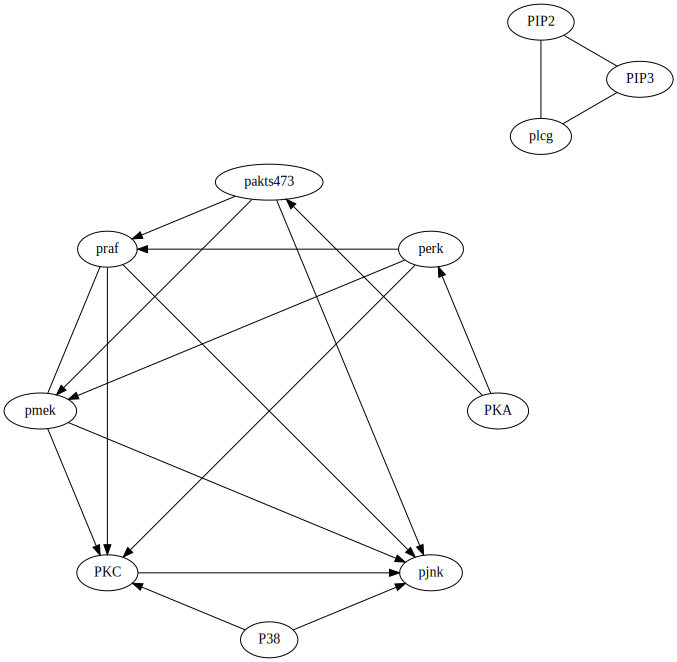

In [25]:
data_exp1_6_drop = data_exp1_6.drop(columns='experiment')
tester1_6 = IndependenceTester(data_exp1_6_drop, ParCorr(), alpha=0.2)

G = PC_algorithm(11, tester1_6)
graph_to_graphviz(G, list(data_exp1_6_drop.columns))

test: 0 and 1 given () -> pval=0.0
test: 0 and 2 given () -> pval=0.22579211347507994
test: 0 and 3 given () -> pval=0.03332165389820263
test: 0 and 4 given () -> pval=0.0018048301566494169
test: 0 and 5 given () -> pval=2.4846295816511114e-70
test: 0 and 6 given () -> pval=1.795947241414922e-29
test: 0 and 7 given () -> pval=6.091908195017966e-12
test: 0 and 8 given () -> pval=4.579202937137639e-62
test: 0 and 9 given () -> pval=0.016423604063641198
test: 0 and 10 given () -> pval=5.139426589447728e-26
test: 1 and 0 given () -> pval=0.0
test: 1 and 2 given () -> pval=0.10463195222143483
test: 1 and 3 given () -> pval=0.02337330991619621
test: 1 and 4 given () -> pval=0.0007183354978785982
test: 1 and 5 given () -> pval=1.491894310801781e-110
test: 1 and 6 given () -> pval=4.1379458633678395e-49
test: 1 and 7 given () -> pval=2.0093199621435567e-18
test: 1 and 8 given () -> pval=1.6347190760257162e-95
test: 1 and 9 given () -> pval=0.025241806301168856
test: 1 and 10 given () -> pval=1

test: 3 and 2 given (5,) -> pval=8.031274117326251e-06
test: 3 and 2 given (6,) -> pval=5.169832988648387e-06
test: 3 and 2 given (7,) -> pval=6.418726129544414e-06
test: 3 and 2 given (8,) -> pval=9.715377628266501e-06
test: 3 and 2 given (9,) -> pval=5.541789040966871e-06
test: 3 and 2 given (10,) -> pval=7.228843212901324e-06
test: 3 and 4 given (0,) -> pval=3.248860359497097e-70
test: 3 and 4 given (1,) -> pval=4.279739286783481e-70
test: 3 and 4 given (2,) -> pval=4.131999890384792e-69
test: 3 and 4 given (5,) -> pval=2.2232137116819344e-70
test: 3 and 4 given (6,) -> pval=3.943473653456188e-71
test: 3 and 4 given (7,) -> pval=2.983804013170816e-70
test: 3 and 4 given (8,) -> pval=6.152085739514567e-70
test: 3 and 4 given (9,) -> pval=9.366166586824903e-71
test: 3 and 4 given (10,) -> pval=2.121335601147102e-70
test: 3 and 5 given (0,) -> pval=0.15440149732279027
test: 3 and 5 given (1,) -> pval=0.23414439006992138
test: 3 and 5 given (2,) -> pval=0.04706568548011025
test: 3 and 5

test: 7 and 1 given (10,) -> pval=4.892232101787367e-15
test: 7 and 3 given (0,) -> pval=0.04332635944104694
test: 7 and 3 given (1,) -> pval=0.05607956484331382
test: 7 and 3 given (2,) -> pval=0.023514277385573965
test: 7 and 3 given (4,) -> pval=0.15964615013636865
test: 7 and 3 given (5,) -> pval=0.2134332180259312
test: 7 and 3 given (6,) -> pval=0.02045674381825033
test: 7 and 3 given (8,) -> pval=0.058263877754203094
test: 7 and 3 given (9,) -> pval=0.021900612350832557
test: 7 and 3 given (10,) -> pval=0.03126665916116207
test: 7 and 4 given (0,) -> pval=0.03826247673013293
test: 7 and 4 given (1,) -> pval=0.05871583817516742
test: 7 and 4 given (2,) -> pval=0.012472852143727235
test: 7 and 4 given (3,) -> pval=0.08177978479118823
test: 7 and 4 given (5,) -> pval=0.1537027677291097
test: 7 and 4 given (6,) -> pval=0.0029022475026908067
test: 7 and 4 given (8,) -> pval=0.03862655195334683
test: 7 and 4 given (9,) -> pval=0.012493942784422502
test: 7 and 4 given (10,) -> pval=0.0

test: 0 and 1 given (2, 7) -> pval=0.0
test: 0 and 1 given (2, 8) -> pval=0.0
test: 0 and 1 given (2, 9) -> pval=0.0
test: 0 and 1 given (2, 10) -> pval=0.0
test: 0 and 1 given (3, 4) -> pval=0.0
test: 0 and 1 given (3, 5) -> pval=0.0
test: 0 and 1 given (3, 6) -> pval=0.0
test: 0 and 1 given (3, 7) -> pval=0.0
test: 0 and 1 given (3, 8) -> pval=0.0
test: 0 and 1 given (3, 9) -> pval=0.0
test: 0 and 1 given (3, 10) -> pval=0.0
test: 0 and 1 given (4, 5) -> pval=0.0
test: 0 and 1 given (4, 6) -> pval=0.0
test: 0 and 1 given (4, 7) -> pval=0.0
test: 0 and 1 given (4, 8) -> pval=0.0
test: 0 and 1 given (4, 9) -> pval=0.0
test: 0 and 1 given (4, 10) -> pval=0.0
test: 0 and 1 given (5, 6) -> pval=0.0
test: 0 and 1 given (5, 7) -> pval=0.0
test: 0 and 1 given (5, 8) -> pval=0.0
test: 0 and 1 given (5, 9) -> pval=0.0
test: 0 and 1 given (5, 10) -> pval=0.0
test: 0 and 1 given (6, 7) -> pval=0.0
test: 0 and 1 given (6, 8) -> pval=0.0
test: 0 and 1 given (6, 9) -> pval=0.0
test: 0 and 1 given (

test: 1 and 0 given (7, 9) -> pval=0.0
test: 1 and 0 given (7, 10) -> pval=0.0
test: 1 and 0 given (8, 9) -> pval=0.0
test: 1 and 0 given (8, 10) -> pval=0.0
test: 1 and 0 given (9, 10) -> pval=0.0
test: 1 and 4 given (0, 2) -> pval=0.22978689822625664
test: 1 and 4 given (0, 3) -> pval=0.2815103028362924
test: 1 and 4 given (0, 5) -> pval=0.33257293546612965
independence found: 1 and 4 given (0, 5)
test: 1 and 5 given (0, 2) -> pval=5.607724939896785e-54
test: 1 and 5 given (0, 3) -> pval=4.277222815758974e-54
test: 1 and 5 given (0, 4) -> pval=4.7980502931912107e-54
test: 1 and 5 given (0, 6) -> pval=1.36845649857353e-107
test: 1 and 5 given (0, 7) -> pval=1.62021139335533e-49
test: 1 and 5 given (0, 8) -> pval=9.348569953114677e-39
test: 1 and 5 given (0, 9) -> pval=3.018959093626826e-54
test: 1 and 5 given (0, 10) -> pval=1.3955307288435339e-46
test: 1 and 5 given (2, 3) -> pval=2.2707166149295736e-109
test: 1 and 5 given (2, 4) -> pval=4.782406761838359e-109
test: 1 and 5 given (2

test: 2 and 4 given (0, 1) -> pval=0.0011048802203110005
test: 2 and 4 given (0, 3) -> pval=0.11331441889191157
test: 2 and 4 given (0, 5) -> pval=0.001094391637550891
test: 2 and 4 given (0, 6) -> pval=0.0009597566362761636
test: 2 and 4 given (0, 7) -> pval=0.0010657825284789235
test: 2 and 4 given (0, 8) -> pval=0.0012749717069166619
test: 2 and 4 given (0, 9) -> pval=0.0009916666398074442
test: 2 and 4 given (0, 10) -> pval=0.0011325023871063295
test: 2 and 4 given (1, 3) -> pval=0.12050359176250451
test: 2 and 4 given (1, 5) -> pval=0.0011747763391843707
test: 2 and 4 given (1, 6) -> pval=0.001117594254876412
test: 2 and 4 given (1, 7) -> pval=0.0011880346331600636
test: 2 and 4 given (1, 8) -> pval=0.0013455903503146263
test: 2 and 4 given (1, 9) -> pval=0.0011378073053422782
test: 2 and 4 given (1, 10) -> pval=0.0012343536482002228
test: 2 and 4 given (3, 5) -> pval=0.11398182729579993
test: 2 and 4 given (3, 6) -> pval=0.10271880562518941
test: 2 and 4 given (3, 7) -> pval=0.10

test: 4 and 2 given (1, 7) -> pval=0.001188034633160067
test: 4 and 2 given (1, 8) -> pval=0.0013455903503146263
test: 4 and 2 given (1, 9) -> pval=0.0011378073053422782
test: 4 and 2 given (1, 10) -> pval=0.0012343536482002256
test: 4 and 2 given (3, 5) -> pval=0.1139818272958
test: 4 and 2 given (3, 6) -> pval=0.10271880562518948
test: 4 and 2 given (3, 7) -> pval=0.10631179938997891
test: 4 and 2 given (3, 8) -> pval=0.12114662849849017
test: 4 and 2 given (3, 9) -> pval=0.10244411690933879
test: 4 and 2 given (3, 10) -> pval=0.11249527732417917
test: 4 and 2 given (5, 6) -> pval=0.0010668043864811457
test: 4 and 2 given (5, 7) -> pval=0.0009519809202456383
test: 4 and 2 given (5, 8) -> pval=0.001350521663367671
test: 4 and 2 given (5, 9) -> pval=0.0010442993675641424
test: 4 and 2 given (5, 10) -> pval=0.0011888158066155523
test: 4 and 2 given (6, 7) -> pval=0.0009161442598592809
test: 4 and 2 given (6, 8) -> pval=0.0012018057471991997
test: 4 and 2 given (6, 9) -> pval=0.000758670

test: 5 and 7 given (0, 8) -> pval=3.9659562268100267e-181
test: 5 and 7 given (0, 9) -> pval=3.5096079037222945e-185
test: 5 and 7 given (0, 10) -> pval=4.744133712359136e-185
test: 5 and 7 given (1, 2) -> pval=1.699681432517453e-182
test: 5 and 7 given (1, 3) -> pval=3.121256670343381e-182
test: 5 and 7 given (1, 4) -> pval=1.5254986979886737e-182
test: 5 and 7 given (1, 6) -> pval=6.150051795204653e-124
test: 5 and 7 given (1, 8) -> pval=3.1111488307696957e-180
test: 5 and 7 given (1, 9) -> pval=2.4129795452740595e-182
test: 5 and 7 given (1, 10) -> pval=1.3969193536598159e-182
test: 5 and 7 given (2, 3) -> pval=7.788711015176269e-188
test: 5 and 7 given (2, 4) -> pval=1.0780707916372507e-187
test: 5 and 7 given (2, 6) -> pval=7.669345095769946e-179
test: 5 and 7 given (2, 8) -> pval=2.8972446055747486e-180
test: 5 and 7 given (2, 9) -> pval=5.229021789765422e-188
test: 5 and 7 given (2, 10) -> pval=6.179409469883216e-187
test: 5 and 7 given (3, 4) -> pval=2.0878724901741067e-187
te

test: 6 and 8 given (0, 1) -> pval=0.07931751013830798
test: 6 and 8 given (0, 2) -> pval=7.970196532106674e-08
test: 6 and 8 given (0, 3) -> pval=5.678688479513413e-08
test: 6 and 8 given (0, 4) -> pval=7.68928477457802e-08
test: 6 and 8 given (0, 5) -> pval=1.1381142233790882e-21
test: 6 and 8 given (0, 7) -> pval=3.6931080907384e-16
test: 6 and 8 given (0, 9) -> pval=1.487186285317575e-10
test: 6 and 8 given (0, 10) -> pval=1.620766441469358e-05
test: 6 and 8 given (1, 2) -> pval=0.006162531172993559
test: 6 and 8 given (1, 3) -> pval=0.0051759466629896595
test: 6 and 8 given (1, 4) -> pval=0.005987858566939808
test: 6 and 8 given (1, 5) -> pval=1.035705908477907e-10
test: 6 and 8 given (1, 7) -> pval=1.3281549291728018e-06
test: 6 and 8 given (1, 9) -> pval=0.0005767573259091559
test: 6 and 8 given (1, 10) -> pval=0.027247958004702328
test: 6 and 8 given (2, 3) -> pval=2.6546405402324832e-20
test: 6 and 8 given (2, 4) -> pval=5.542143388275203e-20
test: 6 and 8 given (2, 5) -> pval

test: 8 and 1 given (2, 9) -> pval=4.609731843482416e-117
test: 8 and 1 given (2, 10) -> pval=2.450358417300782e-68
test: 8 and 1 given (3, 4) -> pval=8.928023317287611e-94
test: 8 and 1 given (3, 5) -> pval=3.451851157955893e-52
test: 8 and 1 given (3, 6) -> pval=1.188927060807089e-77
test: 8 and 1 given (3, 7) -> pval=2.688528155026603e-86
test: 8 and 1 given (3, 9) -> pval=9.113083573674023e-117
test: 8 and 1 given (3, 10) -> pval=4.0484428217399155e-68
test: 8 and 1 given (4, 5) -> pval=8.446419320201648e-52
test: 8 and 1 given (4, 6) -> pval=2.2876405546736254e-77
test: 8 and 1 given (4, 7) -> pval=7.850881115577628e-86
test: 8 and 1 given (4, 9) -> pval=2.57739902762651e-116
test: 8 and 1 given (4, 10) -> pval=8.977216905094494e-68
test: 8 and 1 given (5, 6) -> pval=3.750654236933716e-24
test: 8 and 1 given (5, 7) -> pval=4.444837660385972e-50
test: 8 and 1 given (5, 9) -> pval=1.4969056710677468e-66
test: 8 and 1 given (5, 10) -> pval=1.3957061695174038e-39
test: 8 and 1 given (

test: 8 and 10 given (2, 6) -> pval=3.1043361175405235e-40
test: 8 and 10 given (2, 7) -> pval=4.0408623572140905e-44
test: 8 and 10 given (2, 9) -> pval=2.1428857186833783e-31
test: 8 and 10 given (3, 4) -> pval=1.9086454079217238e-46
test: 8 and 10 given (3, 5) -> pval=4.126568488322573e-31
test: 8 and 10 given (3, 6) -> pval=6.719182497570484e-40
test: 8 and 10 given (3, 7) -> pval=5.875404980074812e-44
test: 8 and 10 given (3, 9) -> pval=2.7696823055668e-31
test: 8 and 10 given (4, 5) -> pval=5.410138868235502e-31
test: 8 and 10 given (4, 6) -> pval=7.697184114189777e-40
test: 8 and 10 given (4, 7) -> pval=8.31420037549857e-44
test: 8 and 10 given (4, 9) -> pval=3.637650760134086e-31
test: 8 and 10 given (5, 6) -> pval=7.526910884240456e-21
test: 8 and 10 given (5, 7) -> pval=2.167187085953052e-30
test: 8 and 10 given (5, 9) -> pval=1.6143876968773326e-17
test: 8 and 10 given (6, 7) -> pval=8.702145066809497e-33
test: 8 and 10 given (6, 9) -> pval=4.115087296301708e-25
test: 8 and 

test: 10 and 6 given (7, 8) -> pval=7.131720976767794e-08
test: 10 and 6 given (7, 9) -> pval=1.9558934287662271e-19
test: 10 and 6 given (8, 9) -> pval=8.283893546955355e-06
test: 10 and 8 given (0, 1) -> pval=2.0088339885120895e-17
test: 10 and 8 given (0, 2) -> pval=5.7841537150874296e-30
test: 10 and 8 given (0, 3) -> pval=7.252374885208001e-30
test: 10 and 8 given (0, 4) -> pval=7.387471163778571e-30
test: 10 and 8 given (0, 5) -> pval=3.093557298002325e-24
test: 10 and 8 given (0, 6) -> pval=5.987798311616671e-28
test: 10 and 8 given (0, 7) -> pval=4.116540251746324e-29
test: 10 and 8 given (0, 9) -> pval=1.0898905044218538e-16
test: 10 and 8 given (1, 2) -> pval=2.13840802420004e-20
test: 10 and 8 given (1, 3) -> pval=2.5963308351933698e-20
test: 10 and 8 given (1, 4) -> pval=2.4250253414120162e-20
test: 10 and 8 given (1, 5) -> pval=1.925966468980967e-18
test: 10 and 8 given (1, 6) -> pval=5.832869381955247e-20
test: 10 and 8 given (1, 7) -> pval=3.485589014276429e-20
test: 10 

test: 0 and 5 given (3, 6, 8) -> pval=2.839699338530042e-64
test: 0 and 5 given (3, 6, 9) -> pval=1.0884285628884339e-98
test: 0 and 5 given (3, 6, 10) -> pval=4.197985697526363e-85
test: 0 and 5 given (3, 7, 8) -> pval=1.0290968019083603e-40
test: 0 and 5 given (3, 7, 9) -> pval=1.6470321179801147e-66
test: 0 and 5 given (3, 7, 10) -> pval=8.679349089847473e-55
test: 0 and 5 given (3, 8, 9) -> pval=2.3626163201968596e-34
test: 0 and 5 given (3, 8, 10) -> pval=1.886544813040235e-36
test: 0 and 5 given (3, 9, 10) -> pval=1.7665633967329222e-56
test: 0 and 5 given (4, 6, 7) -> pval=4.744399608143648e-69
test: 0 and 5 given (4, 6, 8) -> pval=4.173863423159954e-64
test: 0 and 5 given (4, 6, 9) -> pval=2.248129823701611e-98
test: 0 and 5 given (4, 6, 10) -> pval=7.010071911616047e-85
test: 0 and 5 given (4, 7, 8) -> pval=8.383795134913523e-41
test: 0 and 5 given (4, 7, 9) -> pval=1.5661829419092286e-66
test: 0 and 5 given (4, 7, 10) -> pval=7.198138491818629e-55
test: 0 and 5 given (4, 8, 9

test: 0 and 8 given (4, 5, 6) -> pval=9.749824744194285e-14
test: 0 and 8 given (4, 5, 7) -> pval=3.4733710657607393e-29
test: 0 and 8 given (4, 5, 9) -> pval=8.828302704994666e-37
test: 0 and 8 given (4, 5, 10) -> pval=4.4630974895555126e-24
test: 0 and 8 given (4, 6, 7) -> pval=7.944888761032923e-35
test: 0 and 8 given (4, 6, 9) -> pval=6.685490158052936e-57
test: 0 and 8 given (4, 6, 10) -> pval=1.1751453540283149e-36
test: 0 and 8 given (4, 7, 9) -> pval=2.401127171571599e-65
test: 0 and 8 given (4, 7, 10) -> pval=2.877014644116597e-40
test: 0 and 8 given (4, 9, 10) -> pval=8.62216920641601e-57
test: 0 and 8 given (5, 6, 7) -> pval=4.3498885057802814e-14
test: 0 and 8 given (5, 6, 9) -> pval=8.574673943298507e-16
test: 0 and 8 given (5, 6, 10) -> pval=7.382386475790234e-12
test: 0 and 8 given (5, 7, 9) -> pval=1.265209338150619e-34
test: 0 and 8 given (5, 7, 10) -> pval=2.878239739727946e-23
test: 0 and 8 given (5, 9, 10) -> pval=1.6995156553441127e-31
test: 0 and 8 given (6, 7, 9)

test: 1 and 5 given (2, 6, 10) -> pval=7.387695914977381e-152
test: 1 and 5 given (2, 7, 8) -> pval=2.3180785284452018e-67
test: 1 and 5 given (2, 7, 9) -> pval=1.407727126584933e-103
test: 1 and 5 given (2, 7, 10) -> pval=2.7907435340460323e-86
test: 1 and 5 given (2, 8, 9) -> pval=1.1527850408707715e-58
test: 1 and 5 given (2, 8, 10) -> pval=6.426196478644236e-62
test: 1 and 5 given (2, 9, 10) -> pval=1.1255804696890512e-90
test: 1 and 5 given (3, 4, 6) -> pval=2.492579434846115e-174
test: 1 and 5 given (3, 4, 7) -> pval=4.565656418969838e-104
test: 1 and 5 given (3, 4, 8) -> pval=3.412397534016684e-67
test: 1 and 5 given (3, 4, 9) -> pval=1.4527129387301967e-108
test: 1 and 5 given (3, 4, 10) -> pval=3.062990413499653e-90
test: 1 and 5 given (3, 6, 7) -> pval=1.317836355964682e-120
test: 1 and 5 given (3, 6, 8) -> pval=2.314370534280381e-121
test: 1 and 5 given (3, 6, 9) -> pval=2.965676796410529e-174
test: 1 and 5 given (3, 6, 10) -> pval=1.1475251878905494e-151
test: 1 and 5 given

test: 1 and 8 given (3, 6, 9) -> pval=1.1404746771980329e-95
test: 1 and 8 given (3, 6, 10) -> pval=1.533188709064664e-57
test: 1 and 8 given (3, 7, 9) -> pval=8.037705343751095e-108
test: 1 and 8 given (3, 7, 10) -> pval=2.067730016492223e-62
test: 1 and 8 given (3, 9, 10) -> pval=4.51894924587365e-94
test: 1 and 8 given (4, 5, 6) -> pval=1.0278602413668413e-23
test: 1 and 8 given (4, 5, 7) -> pval=3.0380000388321967e-49
test: 1 and 8 given (4, 5, 9) -> pval=6.174367015272853e-66
test: 1 and 8 given (4, 5, 10) -> pval=3.96103753585792e-39
test: 1 and 8 given (4, 6, 7) -> pval=3.642398125715583e-56
test: 1 and 8 given (4, 6, 9) -> pval=1.7111422980576097e-95
test: 1 and 8 given (4, 6, 10) -> pval=2.322213911318652e-57
test: 1 and 8 given (4, 7, 9) -> pval=1.8491216362756517e-107
test: 1 and 8 given (4, 7, 10) -> pval=4.0014495174044025e-62
test: 1 and 8 given (4, 9, 10) -> pval=9.114091601796746e-94
test: 1 and 8 given (5, 6, 7) -> pval=3.556238271491238e-24
test: 1 and 8 given (5, 6, 

test: 2 and 3 given (1, 7, 10) -> pval=9.787731288978701e-06
test: 2 and 3 given (1, 8, 9) -> pval=1.0424068592482692e-05
test: 2 and 3 given (1, 8, 10) -> pval=1.1326081973034653e-05
test: 2 and 3 given (1, 9, 10) -> pval=9.058256242040326e-06
test: 2 and 3 given (4, 5, 6) -> pval=0.0006375005170332643
test: 2 and 3 given (4, 5, 7) -> pval=0.0006343430993880794
test: 2 and 3 given (4, 5, 8) -> pval=0.0007599330101553875
test: 2 and 3 given (4, 5, 9) -> pval=0.0006657787437462443
test: 2 and 3 given (4, 5, 10) -> pval=0.0007014934314930729
test: 2 and 3 given (4, 6, 7) -> pval=0.000577246046813558
test: 2 and 3 given (4, 6, 8) -> pval=0.0007222689717717542
test: 2 and 3 given (4, 6, 9) -> pval=0.0005438177029064853
test: 2 and 3 given (4, 6, 10) -> pval=0.0006150728104237278
test: 2 and 3 given (4, 7, 8) -> pval=0.0007310671477001745
test: 2 and 3 given (4, 7, 9) -> pval=0.0005966242211943364
test: 2 and 3 given (4, 7, 10) -> pval=0.0006524033303377141
test: 2 and 3 given (4, 8, 9) -> 

test: 3 and 2 given (1, 4, 7) -> pval=0.0006293162211098484
test: 3 and 2 given (1, 4, 8) -> pval=0.0007144632262295109
test: 3 and 2 given (1, 4, 9) -> pval=0.0006136037024045174
test: 3 and 2 given (1, 4, 10) -> pval=0.0006482501149005278
test: 3 and 2 given (1, 5, 6) -> pval=8.756536829171516e-06
test: 3 and 2 given (1, 5, 7) -> pval=8.478431996492893e-06
test: 3 and 2 given (1, 5, 8) -> pval=1.1544937148330375e-05
test: 3 and 2 given (1, 5, 9) -> pval=9.320331382951852e-06
test: 3 and 2 given (1, 5, 10) -> pval=1.0155979281771962e-05
test: 3 and 2 given (1, 6, 7) -> pval=8.590453701827673e-06
test: 3 and 2 given (1, 6, 8) -> pval=1.121678701939089e-05
test: 3 and 2 given (1, 6, 9) -> pval=8.383520506707122e-06
test: 3 and 2 given (1, 6, 10) -> pval=9.462681735398792e-06
test: 3 and 2 given (1, 7, 8) -> pval=1.1260526691643612e-05
test: 3 and 2 given (1, 7, 9) -> pval=8.83305461595647e-06
test: 3 and 2 given (1, 7, 10) -> pval=9.787731288978701e-06
test: 3 and 2 given (1, 8, 9) -> p

test: 3 and 8 given (1, 9, 10) -> pval=0.16903645800211553
test: 3 and 8 given (2, 4, 5) -> pval=0.24674940356155475
test: 3 and 8 given (2, 4, 6) -> pval=0.07817196264606419
test: 3 and 8 given (2, 4, 7) -> pval=0.19061648444025475
test: 3 and 8 given (2, 4, 9) -> pval=0.18470873962874954
test: 3 and 8 given (2, 4, 10) -> pval=0.212387147431988
test: 3 and 8 given (2, 5, 6) -> pval=0.03209544340401984
test: 3 and 8 given (2, 5, 7) -> pval=0.036010316511817915
test: 3 and 8 given (2, 5, 9) -> pval=0.11581132079186848
test: 3 and 8 given (2, 5, 10) -> pval=0.10049927223412217
test: 3 and 8 given (2, 6, 7) -> pval=0.02516043677676208
test: 3 and 8 given (2, 6, 9) -> pval=0.015202157709364604
test: 3 and 8 given (2, 6, 10) -> pval=0.025140070160720066
test: 3 and 8 given (2, 7, 9) -> pval=0.06386142021398807
test: 3 and 8 given (2, 7, 10) -> pval=0.07815774885565809
test: 3 and 8 given (2, 9, 10) -> pval=0.0677937766202304
test: 3 and 8 given (4, 5, 6) -> pval=0.1220391708835651
test: 3 a

test: 4 and 3 given (2, 7, 9) -> pval=4.270792752789367e-68
test: 4 and 3 given (2, 7, 10) -> pval=6.88880702201619e-68
test: 4 and 3 given (2, 8, 9) -> pval=4.279746041789676e-68
test: 4 and 3 given (2, 8, 10) -> pval=6.5005107496443775e-68
test: 4 and 3 given (2, 9, 10) -> pval=2.3003315648205234e-68
test: 4 and 3 given (5, 6, 7) -> pval=4.258787967344289e-70
test: 4 and 3 given (5, 6, 8) -> pval=9.154891708929855e-70
test: 4 and 3 given (5, 6, 9) -> pval=3.709877623202518e-70
test: 4 and 3 given (5, 6, 10) -> pval=4.9176417206025505e-70
test: 4 and 3 given (5, 7, 8) -> pval=2.3394233682102463e-69
test: 4 and 3 given (5, 7, 9) -> pval=7.518933018675789e-70
test: 4 and 3 given (5, 7, 10) -> pval=1.1769614678520392e-69
test: 4 and 3 given (5, 8, 9) -> pval=1.1867087702781853e-69
test: 4 and 3 given (5, 8, 10) -> pval=1.688457617461728e-69
test: 4 and 3 given (5, 9, 10) -> pval=8.457978625586047e-70
test: 4 and 3 given (6, 7, 8) -> pval=1.729702181093735e-69
test: 4 and 3 given (6, 7, 9

test: 5 and 7 given (0, 8, 9) -> pval=8.089220977988535e-182
test: 5 and 7 given (0, 8, 10) -> pval=2.485675188564799e-181
test: 5 and 7 given (0, 9, 10) -> pval=3.515412214280328e-185
test: 5 and 7 given (1, 2, 3) -> pval=3.817696524317119e-182
test: 5 and 7 given (1, 2, 4) -> pval=1.9161171818584056e-182
test: 5 and 7 given (1, 2, 6) -> pval=7.805770499977378e-124
test: 5 and 7 given (1, 2, 8) -> pval=4.195326564608935e-180
test: 5 and 7 given (1, 2, 9) -> pval=3.4069538377547266e-182
test: 5 and 7 given (1, 2, 10) -> pval=1.9694186201525903e-182
test: 5 and 7 given (1, 3, 4) -> pval=3.1165142803346536e-182
test: 5 and 7 given (1, 3, 6) -> pval=8.924997222844695e-124
test: 5 and 7 given (1, 3, 8) -> pval=5.647519134206681e-180
test: 5 and 7 given (1, 3, 9) -> pval=6.093650304620642e-182
test: 5 and 7 given (1, 3, 10) -> pval=3.125164115017797e-182
test: 5 and 7 given (1, 4, 6) -> pval=6.810974731627476e-124
test: 5 and 7 given (1, 4, 8) -> pval=2.879085053691715e-180
test: 5 and 7 gi

test: 5 and 10 given (1, 2, 9) -> pval=0.00010734756983769378
test: 5 and 10 given (1, 3, 4) -> pval=7.035873486895241e-05
test: 5 and 10 given (1, 3, 6) -> pval=1.0519234353970364e-08
test: 5 and 10 given (1, 3, 7) -> pval=5.331740191332695e-05
test: 5 and 10 given (1, 3, 8) -> pval=0.01042629628428172
test: 5 and 10 given (1, 3, 9) -> pval=0.00010875808655368817
test: 5 and 10 given (1, 4, 6) -> pval=1.0151033660741411e-08
test: 5 and 10 given (1, 4, 7) -> pval=4.850757816290135e-05
test: 5 and 10 given (1, 4, 8) -> pval=0.010131012836994616
test: 5 and 10 given (1, 4, 9) -> pval=0.00010270518964079127
test: 5 and 10 given (1, 6, 7) -> pval=6.457857459591659e-07
test: 5 and 10 given (1, 6, 8) -> pval=8.227098897784186e-05
test: 5 and 10 given (1, 6, 9) -> pval=1.4449648049365337e-08
test: 5 and 10 given (1, 7, 8) -> pval=0.005129879062228455
test: 5 and 10 given (1, 7, 9) -> pval=4.320024697099105e-05
test: 5 and 10 given (1, 8, 9) -> pval=0.0032868474072332357
test: 5 and 10 given (

test: 6 and 1 given (3, 5, 7) -> pval=2.890158863895841e-104
test: 6 and 1 given (3, 5, 8) -> pval=1.408678434073383e-86
test: 6 and 1 given (3, 5, 9) -> pval=1.2391391497520184e-114
test: 6 and 1 given (3, 5, 10) -> pval=3.0169542006127315e-101
test: 6 and 1 given (3, 7, 8) -> pval=1.0746067067433384e-57
test: 6 and 1 given (3, 7, 9) -> pval=2.201137905597875e-87
test: 6 and 1 given (3, 7, 10) -> pval=1.3135821245761705e-72
test: 6 and 1 given (3, 8, 9) -> pval=3.2261773985120865e-28
test: 6 and 1 given (3, 8, 10) -> pval=1.9493578857271787e-29
test: 6 and 1 given (3, 9, 10) -> pval=6.1304196556042215e-40
test: 6 and 1 given (4, 5, 7) -> pval=1.2054708156129762e-103
test: 6 and 1 given (4, 5, 8) -> pval=2.067705626567435e-86
test: 6 and 1 given (4, 5, 9) -> pval=3.365994305469402e-114
test: 6 and 1 given (4, 5, 10) -> pval=5.851686704449603e-101
test: 6 and 1 given (4, 7, 8) -> pval=1.9903783395470326e-57
test: 6 and 1 given (4, 7, 9) -> pval=8.860276664223569e-87
test: 6 and 1 given 

test: 6 and 10 given (0, 5, 9) -> pval=4.099358439382353e-13
test: 6 and 10 given (0, 7, 8) -> pval=4.7106328813875975e-05
test: 6 and 10 given (0, 7, 9) -> pval=1.2590435466602884e-09
test: 6 and 10 given (0, 8, 9) -> pval=0.0006613189311381759
test: 6 and 10 given (1, 2, 3) -> pval=0.009058629172931792
test: 6 and 10 given (1, 2, 4) -> pval=0.009797928086633212
test: 6 and 10 given (1, 2, 5) -> pval=1.3544263912117697e-06
test: 6 and 10 given (1, 2, 7) -> pval=0.0003338102885341679
test: 6 and 10 given (1, 2, 8) -> pval=0.0450484516711886
test: 6 and 10 given (1, 2, 9) -> pval=0.007467492219220114
test: 6 and 10 given (1, 3, 4) -> pval=0.00918557222134441
test: 6 and 10 given (1, 3, 5) -> pval=1.1222060908593199e-06
test: 6 and 10 given (1, 3, 7) -> pval=0.00031216855351019757
test: 6 and 10 given (1, 3, 8) -> pval=0.04196992762120919
test: 6 and 10 given (1, 3, 9) -> pval=0.006774984433341789
test: 6 and 10 given (1, 4, 5) -> pval=1.2545107698070877e-06
test: 6 and 10 given (1, 4, 7

test: 8 and 0 given (1, 2, 3) -> pval=5.885627719967669e-11
test: 8 and 0 given (1, 2, 4) -> pval=6.219699946655508e-11
test: 8 and 0 given (1, 2, 5) -> pval=4.887595180046611e-08
test: 8 and 0 given (1, 2, 6) -> pval=5.988039768631388e-10
test: 8 and 0 given (1, 2, 7) -> pval=3.1368565562718283e-10
test: 8 and 0 given (1, 2, 9) -> pval=2.820387064868972e-17
test: 8 and 0 given (1, 2, 10) -> pval=8.300240980457682e-08
test: 8 and 0 given (1, 3, 4) -> pval=5.082719430939011e-11
test: 8 and 0 given (1, 3, 5) -> pval=4.030995790461218e-08
test: 8 and 0 given (1, 3, 6) -> pval=5.024790466320471e-10
test: 8 and 0 given (1, 3, 7) -> pval=2.4362158356710233e-10
test: 8 and 0 given (1, 3, 9) -> pval=2.1394493376383574e-17
test: 8 and 0 given (1, 3, 10) -> pval=6.870188444891455e-08
test: 8 and 0 given (1, 4, 5) -> pval=4.298077879410156e-08
test: 8 and 0 given (1, 4, 6) -> pval=5.0411972972215e-10
test: 8 and 0 given (1, 4, 7) -> pval=2.5691358350825467e-10
test: 8 and 0 given (1, 4, 9) -> pva

test: 8 and 2 given (3, 7, 9) -> pval=0.057627639110718235
test: 8 and 2 given (3, 7, 10) -> pval=0.1549665441318763
test: 8 and 2 given (3, 9, 10) -> pval=0.09146031546443502
test: 8 and 2 given (4, 5, 6) -> pval=0.20646771271788314
test: 8 and 2 given (4, 5, 7) -> pval=0.18663066266434228
test: 8 and 2 given (4, 5, 9) -> pval=0.13838122594602978
test: 8 and 2 given (4, 5, 10) -> pval=0.25024375166377016
test: 8 and 2 given (4, 6, 7) -> pval=0.08225966894539283
test: 8 and 2 given (4, 6, 9) -> pval=0.041692818192105824
test: 8 and 2 given (4, 6, 10) -> pval=0.12025268719103238
test: 8 and 2 given (4, 7, 9) -> pval=0.05205804850206632
test: 8 and 2 given (4, 7, 10) -> pval=0.14254030008937868
test: 8 and 2 given (4, 9, 10) -> pval=0.08253809341679562
test: 8 and 2 given (5, 6, 7) -> pval=0.15264056534494705
test: 8 and 2 given (5, 6, 9) -> pval=0.13057892685533845
test: 8 and 2 given (5, 6, 10) -> pval=0.21454182326364607
test: 8 and 2 given (5, 7, 9) -> pval=0.11193845445175288
test: 

test: 8 and 6 given (0, 7, 9) -> pval=1.0860830460084008e-20
test: 8 and 6 given (0, 7, 10) -> pval=9.872970946464612e-12
test: 8 and 6 given (0, 9, 10) -> pval=1.9424432240215637e-08
test: 8 and 6 given (1, 2, 3) -> pval=0.00507913848292102
test: 8 and 6 given (1, 2, 4) -> pval=0.005799971556630601
test: 8 and 6 given (1, 2, 5) -> pval=1.079469352510246e-10
test: 8 and 6 given (1, 2, 7) -> pval=1.2958476908688984e-06
test: 8 and 6 given (1, 2, 9) -> pval=0.0005466084115203077
test: 8 and 6 given (1, 2, 10) -> pval=0.026340997344690673
test: 8 and 6 given (1, 3, 4) -> pval=0.005197536814343959
test: 8 and 6 given (1, 3, 5) -> pval=7.514488828785683e-11
test: 8 and 6 given (1, 3, 7) -> pval=1.1457711097271865e-06
test: 8 and 6 given (1, 3, 9) -> pval=0.0004701138964021988
test: 8 and 6 given (1, 3, 10) -> pval=0.02312128461181953
test: 8 and 6 given (1, 4, 5) -> pval=9.514617272679053e-11
test: 8 and 6 given (1, 4, 7) -> pval=1.4088908529692014e-06
test: 8 and 6 given (1, 4, 9) -> pval=

test: 9 and 8 given (0, 2, 6) -> pval=5.371534011453681e-123
test: 9 and 8 given (0, 2, 7) -> pval=2.5222011588978943e-120
test: 9 and 8 given (0, 2, 10) -> pval=5.459217814532425e-107
test: 9 and 8 given (0, 3, 4) -> pval=9.930959317005679e-120
test: 9 and 8 given (0, 3, 5) -> pval=1.4387656576753257e-125
test: 9 and 8 given (0, 3, 6) -> pval=1.4226324951011008e-122
test: 9 and 8 given (0, 3, 7) -> pval=5.945749694900439e-120
test: 9 and 8 given (0, 3, 10) -> pval=1.1389177842464703e-106
test: 9 and 8 given (0, 4, 5) -> pval=1.6259301805227645e-125
test: 9 and 8 given (0, 4, 6) -> pval=1.639113751493032e-122
test: 9 and 8 given (0, 4, 7) -> pval=6.580949341056475e-120
test: 9 and 8 given (0, 4, 10) -> pval=1.2381281290890588e-106
test: 9 and 8 given (0, 5, 6) -> pval=1.4168121624070357e-133
test: 9 and 8 given (0, 5, 7) -> pval=6.49662658477909e-127
test: 9 and 8 given (0, 5, 10) -> pval=1.6362102918919835e-113
test: 9 and 8 given (0, 6, 7) -> pval=9.998219770340499e-125
test: 9 and 8

test: 10 and 0 given (7, 8, 9) -> pval=3.2418801635726723e-09
test: 10 and 1 given (0, 2, 3) -> pval=7.776272308065633e-27
test: 10 and 1 given (0, 2, 4) -> pval=9.71636474940592e-27
test: 10 and 1 given (0, 2, 5) -> pval=2.5387011720479354e-19
test: 10 and 1 given (0, 2, 6) -> pval=3.9063474808404405e-23
test: 10 and 1 given (0, 2, 7) -> pval=1.0289789379478105e-25
test: 10 and 1 given (0, 2, 8) -> pval=2.946085037443251e-14
test: 10 and 1 given (0, 2, 9) -> pval=5.0644408718125775e-28
test: 10 and 1 given (0, 3, 4) -> pval=7.571068748223934e-27
test: 10 and 1 given (0, 3, 5) -> pval=2.259808220071726e-19
test: 10 and 1 given (0, 3, 6) -> pval=3.975200504201252e-23
test: 10 and 1 given (0, 3, 7) -> pval=8.423533006585728e-26
test: 10 and 1 given (0, 3, 8) -> pval=2.6655799960448268e-14
test: 10 and 1 given (0, 3, 9) -> pval=4.443655068680193e-28
test: 10 and 1 given (0, 4, 5) -> pval=2.815173654495813e-19
test: 10 and 1 given (0, 4, 6) -> pval=4.401631487893546e-23
test: 10 and 1 give

test: 10 and 6 given (3, 4, 9) -> pval=1.603522956031439e-12
test: 10 and 6 given (3, 5, 7) -> pval=2.4047432394127183e-18
test: 10 and 6 given (3, 5, 8) -> pval=7.603939348044474e-10
test: 10 and 6 given (3, 5, 9) -> pval=1.6007739812860934e-20
test: 10 and 6 given (3, 7, 8) -> pval=6.673050391917714e-08
test: 10 and 6 given (3, 7, 9) -> pval=2.0878601882515248e-19
test: 10 and 6 given (3, 8, 9) -> pval=7.0183244210788695e-06
test: 10 and 6 given (4, 5, 7) -> pval=4.12957298704846e-18
test: 10 and 6 given (4, 5, 8) -> pval=9.339773763277195e-10
test: 10 and 6 given (4, 5, 9) -> pval=2.4199858065020864e-20
test: 10 and 6 given (4, 7, 8) -> pval=8.339298485819538e-08
test: 10 and 6 given (4, 7, 9) -> pval=3.5142872748449246e-19
test: 10 and 6 given (4, 8, 9) -> pval=8.252150498533068e-06
test: 10 and 6 given (5, 7, 8) -> pval=9.407158662384766e-09
test: 10 and 6 given (5, 7, 9) -> pval=3.619117577915934e-18
test: 10 and 6 given (5, 8, 9) -> pval=1.2371665857108034e-11
test: 10 and 6 giv

test: 0 and 1 given (2, 5, 6, 9) -> pval=0.0
test: 0 and 1 given (2, 5, 6, 10) -> pval=0.0
test: 0 and 1 given (2, 5, 7, 8) -> pval=0.0
test: 0 and 1 given (2, 5, 7, 9) -> pval=0.0
test: 0 and 1 given (2, 5, 7, 10) -> pval=0.0
test: 0 and 1 given (2, 5, 8, 9) -> pval=0.0
test: 0 and 1 given (2, 5, 8, 10) -> pval=0.0
test: 0 and 1 given (2, 5, 9, 10) -> pval=0.0
test: 0 and 1 given (2, 6, 7, 8) -> pval=0.0
test: 0 and 1 given (2, 6, 7, 9) -> pval=0.0
test: 0 and 1 given (2, 6, 7, 10) -> pval=0.0
test: 0 and 1 given (2, 6, 8, 9) -> pval=0.0
test: 0 and 1 given (2, 6, 8, 10) -> pval=0.0
test: 0 and 1 given (2, 6, 9, 10) -> pval=0.0
test: 0 and 1 given (2, 7, 8, 9) -> pval=0.0
test: 0 and 1 given (2, 7, 8, 10) -> pval=0.0
test: 0 and 1 given (2, 7, 9, 10) -> pval=0.0
test: 0 and 1 given (2, 8, 9, 10) -> pval=0.0
test: 0 and 1 given (3, 4, 5, 6) -> pval=0.0
test: 0 and 1 given (3, 4, 5, 7) -> pval=0.0
test: 0 and 1 given (3, 4, 5, 8) -> pval=0.0
test: 0 and 1 given (3, 4, 5, 9) -> pval=0.0


test: 0 and 6 given (1, 2, 3, 10) -> pval=1.6413302364736577e-09
test: 0 and 6 given (1, 2, 4, 5) -> pval=3.962056871779494e-28
test: 0 and 6 given (1, 2, 4, 7) -> pval=4.887094615964711e-19
test: 0 and 6 given (1, 2, 4, 8) -> pval=2.1327960545943736e-09
test: 0 and 6 given (1, 2, 4, 9) -> pval=2.290802872029211e-10
test: 0 and 6 given (1, 2, 4, 10) -> pval=1.5828903352201773e-09
test: 0 and 6 given (1, 2, 5, 7) -> pval=9.225918620669608e-28
test: 0 and 6 given (1, 2, 5, 8) -> pval=5.556167468675654e-25
test: 0 and 6 given (1, 2, 5, 9) -> pval=3.566128902918528e-28
test: 0 and 6 given (1, 2, 5, 10) -> pval=8.940690640056642e-26
test: 0 and 6 given (1, 2, 7, 8) -> pval=9.971083983410748e-17
test: 0 and 6 given (1, 2, 7, 9) -> pval=4.439118231241585e-19
test: 0 and 6 given (1, 2, 7, 10) -> pval=1.8944742048810656e-17
test: 0 and 6 given (1, 2, 8, 9) -> pval=8.280416383181301e-09
test: 0 and 6 given (1, 2, 8, 10) -> pval=6.590494372440771e-09
test: 0 and 6 given (1, 2, 9, 10) -> pval=1.92

test: 0 and 8 given (3, 4, 5, 9) -> pval=9.88259334565182e-37
test: 0 and 8 given (3, 4, 5, 10) -> pval=4.753416535209535e-24
test: 0 and 8 given (3, 4, 6, 7) -> pval=1.1343128923170258e-34
test: 0 and 8 given (3, 4, 6, 9) -> pval=1.220446401673445e-56
test: 0 and 8 given (3, 4, 6, 10) -> pval=1.7055420767828136e-36
test: 0 and 8 given (3, 4, 7, 9) -> pval=3.2101346332952952e-65
test: 0 and 8 given (3, 4, 7, 10) -> pval=3.3676699931114042e-40
test: 0 and 8 given (3, 4, 9, 10) -> pval=1.1275558937911367e-56
test: 0 and 8 given (3, 5, 6, 7) -> pval=7.607501465139285e-14
test: 0 and 8 given (3, 5, 6, 9) -> pval=1.3860336469668285e-15
test: 0 and 8 given (3, 5, 6, 10) -> pval=1.1012818182154057e-11
test: 0 and 8 given (3, 5, 7, 9) -> pval=2.491805863451801e-34
test: 0 and 8 given (3, 5, 7, 10) -> pval=4.6922756062187763e-23
test: 0 and 8 given (3, 5, 9, 10) -> pval=2.5239668382355116e-31
test: 0 and 8 given (3, 6, 7, 9) -> pval=3.2681403068415306e-41
test: 0 and 8 given (3, 6, 7, 10) -> pv

test: 1 and 0 given (3, 4, 5, 7) -> pval=0.0
test: 1 and 0 given (3, 4, 5, 8) -> pval=0.0
test: 1 and 0 given (3, 4, 5, 9) -> pval=0.0
test: 1 and 0 given (3, 4, 5, 10) -> pval=0.0
test: 1 and 0 given (3, 4, 6, 7) -> pval=0.0
test: 1 and 0 given (3, 4, 6, 8) -> pval=0.0
test: 1 and 0 given (3, 4, 6, 9) -> pval=0.0
test: 1 and 0 given (3, 4, 6, 10) -> pval=0.0
test: 1 and 0 given (3, 4, 7, 8) -> pval=0.0
test: 1 and 0 given (3, 4, 7, 9) -> pval=0.0
test: 1 and 0 given (3, 4, 7, 10) -> pval=0.0
test: 1 and 0 given (3, 4, 8, 9) -> pval=0.0
test: 1 and 0 given (3, 4, 8, 10) -> pval=0.0
test: 1 and 0 given (3, 4, 9, 10) -> pval=0.0
test: 1 and 0 given (3, 5, 6, 7) -> pval=0.0
test: 1 and 0 given (3, 5, 6, 8) -> pval=0.0
test: 1 and 0 given (3, 5, 6, 9) -> pval=0.0
test: 1 and 0 given (3, 5, 6, 10) -> pval=0.0
test: 1 and 0 given (3, 5, 7, 8) -> pval=0.0
test: 1 and 0 given (3, 5, 7, 9) -> pval=0.0
test: 1 and 0 given (3, 5, 7, 10) -> pval=0.0
test: 1 and 0 given (3, 5, 8, 9) -> pval=0.0
tes

test: 1 and 6 given (0, 3, 5, 7) -> pval=1.7229792699324994e-79
test: 1 and 6 given (0, 3, 5, 8) -> pval=1.6230014063323388e-69
test: 1 and 6 given (0, 3, 5, 9) -> pval=1.3862669667878163e-83
test: 1 and 6 given (0, 3, 5, 10) -> pval=4.089334931220606e-75
test: 1 and 6 given (0, 3, 7, 8) -> pval=9.345816775904472e-45
test: 1 and 6 given (0, 3, 7, 9) -> pval=1.743117507625605e-56
test: 1 and 6 given (0, 3, 7, 10) -> pval=1.067390270109973e-49
test: 1 and 6 given (0, 3, 8, 9) -> pval=3.307792146901809e-22
test: 1 and 6 given (0, 3, 8, 10) -> pval=1.0441891382623894e-22
test: 1 and 6 given (0, 3, 9, 10) -> pval=3.2288616399788265e-26
test: 1 and 6 given (0, 4, 5, 7) -> pval=2.4294120420846527e-79
test: 1 and 6 given (0, 4, 5, 8) -> pval=1.5119443822241365e-69
test: 1 and 6 given (0, 4, 5, 9) -> pval=1.6472810138103115e-83
test: 1 and 6 given (0, 4, 5, 10) -> pval=4.1981390870456084e-75
test: 1 and 6 given (0, 4, 7, 8) -> pval=9.746705724144358e-45
test: 1 and 6 given (0, 4, 7, 9) -> pval=

test: 1 and 8 given (5, 6, 7, 10) -> pval=1.9171868047264776e-19
test: 1 and 8 given (5, 6, 9, 10) -> pval=4.506254471733162e-27
test: 1 and 8 given (5, 7, 9, 10) -> pval=2.2480893097750225e-53
test: 1 and 8 given (6, 7, 9, 10) -> pval=1.91177963637549e-60
test: 1 and 10 given (0, 2, 3, 4) -> pval=1.0176557067176437e-26
test: 1 and 10 given (0, 2, 3, 5) -> pval=2.639797237953011e-19
test: 1 and 10 given (0, 2, 3, 6) -> pval=5.367890806420532e-23
test: 1 and 10 given (0, 2, 3, 7) -> pval=1.1278813891475382e-25
test: 1 and 10 given (0, 2, 3, 8) -> pval=2.949280222338763e-14
test: 1 and 10 given (0, 2, 3, 9) -> pval=6.102413456341013e-28
test: 1 and 10 given (0, 2, 4, 5) -> pval=3.270458398673461e-19
test: 1 and 10 given (0, 2, 4, 6) -> pval=6.021396896187153e-23
test: 1 and 10 given (0, 2, 4, 7) -> pval=1.375143979766235e-25
test: 1 and 10 given (0, 2, 4, 8) -> pval=3.335299989003811e-14
test: 1 and 10 given (0, 2, 4, 9) -> pval=7.360531572825789e-28
test: 1 and 10 given (0, 2, 5, 6) -> 

test: 2 and 3 given (4, 5, 6, 10) -> pval=0.000685026938561963
test: 2 and 3 given (4, 5, 7, 8) -> pval=0.0007371059524259793
test: 2 and 3 given (4, 5, 7, 9) -> pval=0.0006438371928343223
test: 2 and 3 given (4, 5, 7, 10) -> pval=0.0006793503435668506
test: 2 and 3 given (4, 5, 8, 9) -> pval=0.0007601582236906866
test: 2 and 3 given (4, 5, 8, 10) -> pval=0.0007802122258706078
test: 2 and 3 given (4, 5, 9, 10) -> pval=0.0007036910833776137
test: 2 and 3 given (4, 6, 7, 8) -> pval=0.0007362378553630928
test: 2 and 3 given (4, 6, 7, 9) -> pval=0.0005872662190125596
test: 2 and 3 given (4, 6, 7, 10) -> pval=0.0006461440320627587
test: 2 and 3 given (4, 6, 8, 9) -> pval=0.0007368229144215605
test: 2 and 3 given (4, 6, 8, 10) -> pval=0.0007574297903604055
test: 2 and 3 given (4, 6, 9, 10) -> pval=0.0006168702390867863
test: 2 and 3 given (4, 7, 8, 9) -> pval=0.0007342497015086502
test: 2 and 3 given (4, 7, 8, 10) -> pval=0.0007567443308611416
test: 2 and 3 given (4, 7, 9, 10) -> pval=0.0006

test: 2 and 8 given (1, 3, 4, 9) -> pval=0.14418618851958126
test: 2 and 8 given (1, 3, 4, 10) -> pval=0.25495213286111534
test: 2 and 8 given (1, 3, 5, 6) -> pval=0.258285839456394
test: 2 and 8 given (1, 3, 5, 7) -> pval=0.24675665244444087
test: 2 and 8 given (1, 3, 5, 9) -> pval=0.19309400552801634
test: 2 and 8 given (1, 3, 5, 10) -> pval=0.3038148197656224
independence found: 2 and 8 given (1, 3, 5, 10)
test: 3 and 2 given (0, 1, 4, 5) -> pval=0.0006593968548200599
test: 3 and 2 given (0, 1, 4, 6) -> pval=0.0006279864720114073
test: 3 and 2 given (0, 1, 4, 7) -> pval=0.0006216944342575035
test: 3 and 2 given (0, 1, 4, 8) -> pval=0.0007041285073647062
test: 3 and 2 given (0, 1, 4, 9) -> pval=0.0006110032808827878
test: 3 and 2 given (0, 1, 4, 10) -> pval=0.0006407838414883726
test: 3 and 2 given (0, 1, 5, 6) -> pval=8.778718684861807e-06
test: 3 and 2 given (0, 1, 5, 7) -> pval=8.387403807339066e-06
test: 3 and 2 given (0, 1, 5, 8) -> pval=1.13019191110182e-05
test: 3 and 2 given 

test: 3 and 4 given (1, 7, 8, 10) -> pval=4.611931257426732e-69
test: 3 and 4 given (1, 7, 9, 10) -> pval=3.604856894952313e-69
test: 3 and 4 given (1, 8, 9, 10) -> pval=1.8865600822679388e-69
test: 3 and 4 given (2, 5, 6, 7) -> pval=3.0238656232476376e-68
test: 3 and 4 given (2, 5, 6, 8) -> pval=5.369029079360737e-68
test: 3 and 4 given (2, 5, 6, 9) -> pval=2.5132662764706e-68
test: 3 and 4 given (2, 5, 6, 10) -> pval=3.123671851116351e-68
test: 3 and 4 given (2, 5, 7, 8) -> pval=1.4029148634007641e-67
test: 3 and 4 given (2, 5, 7, 9) -> pval=5.362936593607207e-68
test: 3 and 4 given (2, 5, 7, 10) -> pval=7.722721237649316e-68
test: 3 and 4 given (2, 5, 8, 9) -> pval=6.991523798339522e-68
test: 3 and 4 given (2, 5, 8, 10) -> pval=9.466827945158153e-68
test: 3 and 4 given (2, 5, 9, 10) -> pval=5.363276639568573e-68
test: 3 and 4 given (2, 6, 7, 8) -> pval=1.0380764267203713e-67
test: 3 and 4 given (2, 6, 7, 9) -> pval=4.3048176003451355e-68
test: 3 and 4 given (2, 6, 7, 10) -> pval=6.1

test: 4 and 3 given (0, 1, 8, 9) -> pval=1.4543050198891006e-69
test: 4 and 3 given (0, 1, 8, 10) -> pval=1.9792257943324416e-69
test: 4 and 3 given (0, 1, 9, 10) -> pval=1.3557690804423112e-69
test: 4 and 3 given (0, 2, 5, 6) -> pval=3.6596142566743844e-68
test: 4 and 3 given (0, 2, 5, 7) -> pval=9.021201219155483e-68
test: 4 and 3 given (0, 2, 5, 8) -> pval=9.277699938427496e-68
test: 4 and 3 given (0, 2, 5, 9) -> pval=6.474358850333528e-68
test: 4 and 3 given (0, 2, 5, 10) -> pval=6.889334310771505e-68
test: 4 and 3 given (0, 2, 6, 7) -> pval=7.603402745229755e-68
test: 4 and 3 given (0, 2, 6, 8) -> pval=8.748638814280644e-68
test: 4 and 3 given (0, 2, 6, 9) -> pval=4.436628807305532e-68
test: 4 and 3 given (0, 2, 6, 10) -> pval=5.730124229361131e-68
test: 4 and 3 given (0, 2, 7, 8) -> pval=2.0630000045759225e-67
test: 4 and 3 given (0, 2, 7, 9) -> pval=1.4035816246365255e-67
test: 4 and 3 given (0, 2, 7, 10) -> pval=1.5936683808615074e-67
test: 4 and 3 given (0, 2, 8, 9) -> pval=8.

test: 5 and 0 given (4, 6, 8, 10) -> pval=5.155553944345508e-60
test: 5 and 0 given (4, 6, 9, 10) -> pval=6.76971598004383e-85
test: 5 and 0 given (4, 7, 8, 9) -> pval=2.793019207090484e-35
test: 5 and 0 given (4, 7, 8, 10) -> pval=1.6971079922162115e-37
test: 5 and 0 given (4, 7, 9, 10) -> pval=7.08986843663056e-55
test: 5 and 0 given (4, 8, 9, 10) -> pval=1.1050300239587384e-30
test: 5 and 0 given (6, 7, 8, 9) -> pval=3.172289107625866e-43
test: 5 and 0 given (6, 7, 8, 10) -> pval=2.9185358583559053e-45
test: 5 and 0 given (6, 7, 9, 10) -> pval=1.2972445177469503e-60
test: 5 and 0 given (6, 8, 9, 10) -> pval=1.0367924817384908e-52
test: 5 and 0 given (7, 8, 9, 10) -> pval=1.453744898309521e-31
test: 5 and 1 given (0, 2, 3, 4) -> pval=8.812861176627993e-54
test: 5 and 1 given (0, 2, 3, 6) -> pval=5.2683292649001843e-107
test: 5 and 1 given (0, 2, 3, 7) -> pval=2.8977844857459044e-49
test: 5 and 1 given (0, 2, 3, 8) -> pval=1.2176426365580872e-38
test: 5 and 1 given (0, 2, 3, 9) -> pva

test: 5 and 7 given (1, 3, 6, 9) -> pval=1.5697553067322327e-123
test: 5 and 7 given (1, 3, 6, 10) -> pval=5.510130570096685e-122
test: 5 and 7 given (1, 3, 8, 9) -> pval=1.7343553620889578e-180
test: 5 and 7 given (1, 3, 8, 10) -> pval=3.7557604087535945e-180
test: 5 and 7 given (1, 3, 9, 10) -> pval=3.243157061006699e-182
test: 5 and 7 given (1, 4, 6, 8) -> pval=5.343413459896203e-118
test: 5 and 7 given (1, 4, 6, 9) -> pval=1.1966655609525687e-123
test: 5 and 7 given (1, 4, 6, 10) -> pval=4.043335733888917e-122
test: 5 and 7 given (1, 4, 8, 9) -> pval=9.260054082568544e-181
test: 5 and 7 given (1, 4, 8, 10) -> pval=1.8738706326777392e-180
test: 5 and 7 given (1, 4, 9, 10) -> pval=1.5683488239532867e-182
test: 5 and 7 given (1, 6, 8, 9) -> pval=3.2726426613707e-117
test: 5 and 7 given (1, 6, 8, 10) -> pval=3.4536048887791454e-117
test: 5 and 7 given (1, 6, 9, 10) -> pval=3.98287767319881e-122
test: 5 and 7 given (1, 8, 9, 10) -> pval=5.320587030800022e-181
test: 5 and 7 given (2, 3, 

test: 5 and 10 given (0, 3, 7, 9) -> pval=4.664098384754766e-11
test: 5 and 10 given (0, 3, 8, 9) -> pval=6.837449554010782e-06
test: 5 and 10 given (0, 4, 6, 7) -> pval=4.604891082449799e-13
test: 5 and 10 given (0, 4, 6, 8) -> pval=1.0741538824022638e-08
test: 5 and 10 given (0, 4, 6, 9) -> pval=8.566913119043115e-18
test: 5 and 10 given (0, 4, 7, 8) -> pval=1.7334318705535165e-05
test: 5 and 10 given (0, 4, 7, 9) -> pval=4.203699380538768e-11
test: 5 and 10 given (0, 4, 8, 9) -> pval=6.722869150687518e-06
test: 5 and 10 given (0, 6, 7, 8) -> pval=6.560611354897013e-07
test: 5 and 10 given (0, 6, 7, 9) -> pval=2.5547013449229546e-13
test: 5 and 10 given (0, 6, 8, 9) -> pval=1.541537152399584e-10
test: 5 and 10 given (0, 7, 8, 9) -> pval=2.259650610114316e-06
test: 5 and 10 given (1, 2, 3, 4) -> pval=7.701138527102244e-05
test: 5 and 10 given (1, 2, 3, 6) -> pval=1.2056433201253607e-08
test: 5 and 10 given (1, 2, 3, 7) -> pval=5.8820165128508404e-05
test: 5 and 10 given (1, 2, 3, 8) -

test: 6 and 1 given (0, 2, 5, 8) -> pval=1.6494217553848575e-69
test: 6 and 1 given (0, 2, 5, 9) -> pval=1.850313459521203e-83
test: 6 and 1 given (0, 2, 5, 10) -> pval=4.677600959748927e-75
test: 6 and 1 given (0, 2, 7, 8) -> pval=8.704619318682501e-45
test: 6 and 1 given (0, 2, 7, 9) -> pval=1.9139764444442417e-56
test: 6 and 1 given (0, 2, 7, 10) -> pval=1.0699326441071366e-49
test: 6 and 1 given (0, 2, 8, 9) -> pval=3.379247349141253e-22
test: 6 and 1 given (0, 2, 8, 10) -> pval=9.928968886780582e-23
test: 6 and 1 given (0, 2, 9, 10) -> pval=3.6562866029896764e-26
test: 6 and 1 given (0, 3, 4, 5) -> pval=1.750272095772399e-83
test: 6 and 1 given (0, 3, 4, 7) -> pval=2.3587614185481155e-56
test: 6 and 1 given (0, 3, 4, 8) -> pval=1.679851618000581e-24
test: 6 and 1 given (0, 3, 4, 9) -> pval=3.358715869564316e-30
test: 6 and 1 given (0, 3, 4, 10) -> pval=2.1659283736793016e-26
test: 6 and 1 given (0, 3, 5, 7) -> pval=1.7229792699324994e-79
test: 6 and 1 given (0, 3, 5, 8) -> pval=1.

test: 6 and 7 given (2, 5, 9, 10) -> pval=3.884597696708142e-34
test: 6 and 7 given (2, 8, 9, 10) -> pval=4.72395649175286e-69
test: 6 and 7 given (3, 4, 5, 8) -> pval=9.480792690279354e-34
test: 6 and 7 given (3, 4, 5, 9) -> pval=1.0770362930244054e-36
test: 6 and 7 given (3, 4, 5, 10) -> pval=1.9466207066459567e-34
test: 6 and 7 given (3, 4, 8, 9) -> pval=3.363583898865204e-66
test: 6 and 7 given (3, 4, 8, 10) -> pval=3.4691576108583373e-65
test: 6 and 7 given (3, 4, 9, 10) -> pval=2.9189581629702196e-53
test: 6 and 7 given (3, 5, 8, 9) -> pval=8.130987011922173e-32
test: 6 and 7 given (3, 5, 8, 10) -> pval=1.5210723296345579e-32
test: 6 and 7 given (3, 5, 9, 10) -> pval=4.172316431408481e-34
test: 6 and 7 given (3, 8, 9, 10) -> pval=8.788885080873352e-69
test: 6 and 7 given (4, 5, 8, 9) -> pval=4.4950381015718263e-32
test: 6 and 7 given (4, 5, 8, 10) -> pval=8.673260210309094e-33
test: 6 and 7 given (4, 5, 9, 10) -> pval=2.279798372599999e-34
test: 6 and 7 given (4, 8, 9, 10) -> pva

test: 6 and 10 given (1, 3, 4, 9) -> pval=0.006804256750582719
test: 6 and 10 given (1, 3, 5, 7) -> pval=3.531483134038033e-06
test: 6 and 10 given (1, 3, 5, 8) -> pval=0.0003046683508841122
test: 6 and 10 given (1, 3, 5, 9) -> pval=8.306050807887605e-07
test: 6 and 10 given (1, 3, 7, 8) -> pval=0.009229093150186295
test: 6 and 10 given (1, 3, 7, 9) -> pval=0.0003204999620865436
test: 6 and 10 given (1, 3, 8, 9) -> pval=0.024044563741529648
test: 6 and 10 given (1, 4, 5, 7) -> pval=4.027092570873853e-06
test: 6 and 10 given (1, 4, 5, 8) -> pval=0.00032402449893077334
test: 6 and 10 given (1, 4, 5, 9) -> pval=9.134705624593649e-07
test: 6 and 10 given (1, 4, 7, 8) -> pval=0.009876472026845077
test: 6 and 10 given (1, 4, 7, 9) -> pval=0.0003533744305719618
test: 6 and 10 given (1, 4, 8, 9) -> pval=0.02539919308198604
test: 6 and 10 given (1, 5, 7, 8) -> pval=0.0007435813711716199
test: 6 and 10 given (1, 5, 7, 9) -> pval=3.741943953992491e-06
test: 6 and 10 given (1, 5, 8, 9) -> pval=4.9

test: 7 and 6 given (0, 3, 5, 10) -> pval=2.0162362844673034e-28
test: 7 and 6 given (0, 3, 8, 9) -> pval=1.3290158741551724e-76
test: 7 and 6 given (0, 3, 8, 10) -> pval=3.4815691854063595e-76
test: 7 and 6 given (0, 3, 9, 10) -> pval=4.5561734547317015e-70
test: 7 and 6 given (0, 4, 5, 8) -> pval=9.071787113906445e-29
test: 7 and 6 given (0, 4, 5, 9) -> pval=1.0567707670197928e-29
test: 7 and 6 given (0, 4, 5, 10) -> pval=1.3580013858676434e-28
test: 7 and 6 given (0, 4, 8, 9) -> pval=6.11627207934241e-77
test: 7 and 6 given (0, 4, 8, 10) -> pval=1.737075278855212e-76
test: 7 and 6 given (0, 4, 9, 10) -> pval=2.109461015551738e-70
test: 7 and 6 given (0, 5, 8, 9) -> pval=1.1569052292475728e-27
test: 7 and 6 given (0, 5, 8, 10) -> pval=3.8695760678759e-28
test: 7 and 6 given (0, 5, 9, 10) -> pval=2.166019034919388e-28
test: 7 and 6 given (0, 8, 9, 10) -> pval=1.0981595928344296e-78
test: 7 and 6 given (1, 2, 3, 4) -> pval=2.3984845148993317e-84
test: 7 and 6 given (1, 2, 3, 5) -> pval

test: 8 and 1 given (0, 2, 5, 10) -> pval=4.636416835141389e-21
test: 8 and 1 given (0, 2, 6, 7) -> pval=2.0830194678880222e-29
test: 8 and 1 given (0, 2, 6, 9) -> pval=1.7151735422465736e-54
test: 8 and 1 given (0, 2, 6, 10) -> pval=3.9330965515073954e-28
test: 8 and 1 given (0, 2, 7, 9) -> pval=1.0598766723824702e-58
test: 8 and 1 given (0, 2, 7, 10) -> pval=2.3051731316100224e-29
test: 8 and 1 given (0, 2, 9, 10) -> pval=7.775804048940724e-52
test: 8 and 1 given (0, 3, 4, 5) -> pval=5.111156951077244e-29
test: 8 and 1 given (0, 3, 4, 6) -> pval=1.271986439765188e-38
test: 8 and 1 given (0, 3, 4, 7) -> pval=3.8335069253409717e-41
test: 8 and 1 given (0, 3, 4, 9) -> pval=1.9321525883093309e-62
test: 8 and 1 given (0, 3, 4, 10) -> pval=8.532950456024234e-32
test: 8 and 1 given (0, 3, 5, 6) -> pval=5.670577934491877e-15
test: 8 and 1 given (0, 3, 5, 7) -> pval=2.3197992938985796e-28
test: 8 and 1 given (0, 3, 5, 9) -> pval=9.951390415636798e-43
test: 8 and 1 given (0, 3, 5, 10) -> pval=

test: 8 and 5 given (2, 6, 7, 10) -> pval=6.8947319136379074e-34
test: 8 and 5 given (2, 6, 9, 10) -> pval=5.054593976890536e-74
test: 8 and 5 given (2, 7, 9, 10) -> pval=2.6597565104560188e-45
test: 8 and 5 given (3, 4, 6, 7) -> pval=9.031546442258563e-46
test: 8 and 5 given (3, 4, 6, 9) -> pval=1.4113431677430409e-89
test: 8 and 5 given (3, 4, 6, 10) -> pval=1.4998321780191816e-53
test: 8 and 5 given (3, 4, 7, 9) -> pval=4.29441148217264e-58
test: 8 and 5 given (3, 4, 7, 10) -> pval=2.4447774241841384e-32
test: 8 and 5 given (3, 4, 9, 10) -> pval=1.4062658730552884e-50
test: 8 and 5 given (3, 6, 7, 9) -> pval=3.415974856926995e-59
test: 8 and 5 given (3, 6, 7, 10) -> pval=4.602664195609335e-34
test: 8 and 5 given (3, 6, 9, 10) -> pval=5.682077310584501e-74
test: 8 and 5 given (3, 7, 9, 10) -> pval=1.5875020960218236e-45
test: 8 and 5 given (4, 6, 7, 9) -> pval=3.1274197157579548e-59
test: 8 and 5 given (4, 6, 7, 10) -> pval=4.329012212708519e-34
test: 8 and 5 given (4, 6, 9, 10) -> p

test: 8 and 9 given (1, 3, 5, 6) -> pval=1.3288247001875853e-137
test: 8 and 9 given (1, 3, 5, 7) -> pval=1.842562745275048e-134
test: 8 and 9 given (1, 3, 5, 10) -> pval=8.614784565634541e-123
test: 8 and 9 given (1, 3, 6, 7) -> pval=5.761556890399244e-133
test: 8 and 9 given (1, 3, 6, 10) -> pval=6.20189611747445e-121
test: 8 and 9 given (1, 3, 7, 10) -> pval=8.798952102709132e-120
test: 8 and 9 given (1, 4, 5, 6) -> pval=1.4058948263732554e-137
test: 8 and 9 given (1, 4, 5, 7) -> pval=1.9825077111262555e-134
test: 8 and 9 given (1, 4, 5, 10) -> pval=9.002903309520168e-123
test: 8 and 9 given (1, 4, 6, 7) -> pval=5.751083585705165e-133
test: 8 and 9 given (1, 4, 6, 10) -> pval=6.695758506672246e-121
test: 8 and 9 given (1, 4, 7, 10) -> pval=9.066077900484302e-120
test: 8 and 9 given (1, 5, 6, 7) -> pval=7.713126597323927e-138
test: 8 and 9 given (1, 5, 6, 10) -> pval=2.3587315813052915e-127
test: 8 and 9 given (1, 5, 7, 10) -> pval=1.683628164823932e-123
test: 8 and 9 given (1, 6, 7,

test: 9 and 8 given (0, 3, 4, 10) -> pval=1.649098261574329e-106
test: 9 and 8 given (0, 3, 5, 6) -> pval=3.447737119204401e-133
test: 9 and 8 given (0, 3, 5, 7) -> pval=1.489692097952048e-126
test: 9 and 8 given (0, 3, 5, 10) -> pval=2.930960393711919e-113
test: 9 and 8 given (0, 3, 6, 7) -> pval=2.3124538497238254e-124
test: 9 and 8 given (0, 3, 6, 10) -> pval=1.9254105107569418e-109
test: 9 and 8 given (0, 3, 7, 10) -> pval=6.069019509163942e-107
test: 9 and 8 given (0, 4, 5, 6) -> pval=3.816533960944814e-133
test: 9 and 8 given (0, 4, 5, 7) -> pval=1.7075098991326482e-126
test: 9 and 8 given (0, 4, 5, 10) -> pval=3.137532082830885e-113
test: 9 and 8 given (0, 4, 6, 7) -> pval=2.4332773745000518e-124
test: 9 and 8 given (0, 4, 6, 10) -> pval=2.1731564457952275e-109
test: 9 and 8 given (0, 4, 7, 10) -> pval=6.438648117832698e-107
test: 9 and 8 given (0, 5, 6, 7) -> pval=2.046321177316804e-133
test: 9 and 8 given (0, 5, 6, 10) -> pval=3.2637796804488806e-122
test: 9 and 8 given (0, 5,

test: 10 and 0 given (1, 2, 4, 6) -> pval=1.2112032247280747e-08
test: 10 and 0 given (1, 2, 4, 7) -> pval=2.9045451611121466e-09
test: 10 and 0 given (1, 2, 4, 8) -> pval=2.241823362974489e-06
test: 10 and 0 given (1, 2, 4, 9) -> pval=2.2807118890102614e-10
test: 10 and 0 given (1, 2, 5, 6) -> pval=1.7592748906733503e-05
test: 10 and 0 given (1, 2, 5, 7) -> pval=8.841245860601527e-08
test: 10 and 0 given (1, 2, 5, 8) -> pval=1.2159777959129181e-05
test: 10 and 0 given (1, 2, 5, 9) -> pval=9.149159977348686e-09
test: 10 and 0 given (1, 2, 6, 7) -> pval=1.2330172426555166e-07
test: 10 and 0 given (1, 2, 6, 8) -> pval=7.462746978065203e-06
test: 10 and 0 given (1, 2, 6, 9) -> pval=1.9240774073152895e-09
test: 10 and 0 given (1, 2, 7, 8) -> pval=2.7278905224566396e-06
test: 10 and 0 given (1, 2, 7, 9) -> pval=3.6529170589406714e-10
test: 10 and 0 given (1, 2, 8, 9) -> pval=9.303495419926411e-08
test: 10 and 0 given (1, 3, 4, 5) -> pval=5.7652406921589346e-08
test: 10 and 0 given (1, 3, 4,

test: 10 and 1 given (3, 4, 6, 9) -> pval=3.152861401103746e-32
test: 10 and 1 given (3, 4, 7, 8) -> pval=1.4299139275821617e-15
test: 10 and 1 given (3, 4, 7, 9) -> pval=9.232525909154127e-39
test: 10 and 1 given (3, 4, 8, 9) -> pval=5.064188969339456e-19
test: 10 and 1 given (3, 5, 6, 7) -> pval=6.484844021535834e-10
test: 10 and 1 given (3, 5, 6, 8) -> pval=3.348270701993622e-05
test: 10 and 1 given (3, 5, 6, 9) -> pval=1.1196886233344897e-09
test: 10 and 1 given (3, 5, 7, 8) -> pval=4.91325845490981e-10
test: 10 and 1 given (3, 5, 7, 9) -> pval=1.5467488309886945e-21
test: 10 and 1 given (3, 5, 8, 9) -> pval=5.226270488509062e-13
test: 10 and 1 given (3, 6, 7, 8) -> pval=9.502267410275917e-11
test: 10 and 1 given (3, 6, 7, 9) -> pval=3.660591318473144e-24
test: 10 and 1 given (3, 6, 8, 9) -> pval=7.314527063601137e-16
test: 10 and 1 given (3, 7, 8, 9) -> pval=1.6894503563143907e-18
test: 10 and 1 given (4, 5, 6, 7) -> pval=7.741298319625024e-10
test: 10 and 1 given (4, 5, 6, 8) -> 

test: 10 and 6 given (1, 2, 5, 8) -> pval=0.00034198604710553997
test: 10 and 6 given (1, 2, 5, 9) -> pval=9.745620283179913e-07
test: 10 and 6 given (1, 2, 7, 8) -> pval=0.009619717874855238
test: 10 and 6 given (1, 2, 7, 9) -> pval=0.0003385206794023528
test: 10 and 6 given (1, 2, 8, 9) -> pval=0.025830625764026064
test: 10 and 6 given (1, 3, 4, 5) -> pval=1.142673696284352e-06
test: 10 and 6 given (1, 3, 4, 7) -> pval=0.0003294168740547553
test: 10 and 6 given (1, 3, 4, 8) -> pval=0.04198656171320296
test: 10 and 6 given (1, 3, 4, 9) -> pval=0.006804256750582719
test: 10 and 6 given (1, 3, 5, 7) -> pval=3.5314831340380652e-06
test: 10 and 6 given (1, 3, 5, 8) -> pval=0.0003046683508841122
test: 10 and 6 given (1, 3, 5, 9) -> pval=8.306050807887605e-07
test: 10 and 6 given (1, 3, 7, 8) -> pval=0.009229093150186305
test: 10 and 6 given (1, 3, 7, 9) -> pval=0.00032049996208654446
test: 10 and 6 given (1, 3, 8, 9) -> pval=0.024044563741529683
test: 10 and 6 given (1, 4, 5, 7) -> pval=4.

test: 10 and 9 given (0, 2, 5, 8) -> pval=0.0006042106637534015
test: 10 and 9 given (0, 2, 6, 7) -> pval=1.2115391191888418e-16
test: 10 and 9 given (0, 2, 6, 8) -> pval=0.0015939377035033083
test: 10 and 9 given (0, 2, 7, 8) -> pval=0.0036269080583195357
test: 10 and 9 given (0, 3, 4, 5) -> pval=2.0410140823240913e-16
test: 10 and 9 given (0, 3, 4, 6) -> pval=7.494510548097828e-17
test: 10 and 9 given (0, 3, 4, 7) -> pval=2.1061364672322012e-16
test: 10 and 9 given (0, 3, 4, 8) -> pval=0.004520598940163093
test: 10 and 9 given (0, 3, 5, 6) -> pval=8.551265617722614e-17
test: 10 and 9 given (0, 3, 5, 7) -> pval=1.0113958228434171e-16
test: 10 and 9 given (0, 3, 5, 8) -> pval=0.0006383909484616559
test: 10 and 9 given (0, 3, 6, 7) -> pval=1.5463816190636116e-16
test: 10 and 9 given (0, 3, 6, 8) -> pval=0.001676039959879973
test: 10 and 9 given (0, 3, 7, 8) -> pval=0.003836198355045688
test: 10 and 9 given (0, 4, 5, 6) -> pval=8.973439982867137e-17
test: 10 and 9 given (0, 4, 5, 7) -> p

test: 0 and 1 given (4, 5, 6, 7, 8) -> pval=0.0
test: 0 and 1 given (4, 5, 6, 7, 9) -> pval=0.0
test: 0 and 1 given (4, 5, 6, 7, 10) -> pval=0.0
test: 0 and 1 given (4, 5, 6, 8, 9) -> pval=0.0
test: 0 and 1 given (4, 5, 6, 8, 10) -> pval=0.0
test: 0 and 1 given (4, 5, 6, 9, 10) -> pval=0.0
test: 0 and 1 given (4, 5, 7, 8, 9) -> pval=0.0
test: 0 and 1 given (4, 5, 7, 8, 10) -> pval=0.0
test: 0 and 1 given (4, 5, 7, 9, 10) -> pval=0.0
test: 0 and 1 given (4, 5, 8, 9, 10) -> pval=0.0
test: 0 and 1 given (4, 6, 7, 8, 9) -> pval=0.0
test: 0 and 1 given (4, 6, 7, 8, 10) -> pval=0.0
test: 0 and 1 given (4, 6, 7, 9, 10) -> pval=0.0
test: 0 and 1 given (4, 6, 8, 9, 10) -> pval=0.0
test: 0 and 1 given (4, 7, 8, 9, 10) -> pval=0.0
test: 0 and 1 given (5, 6, 7, 8, 9) -> pval=0.0
test: 0 and 1 given (5, 6, 7, 8, 10) -> pval=0.0
test: 0 and 1 given (5, 6, 7, 9, 10) -> pval=0.0
test: 0 and 1 given (5, 6, 8, 9, 10) -> pval=0.0
test: 0 and 1 given (5, 7, 8, 9, 10) -> pval=0.0
test: 0 and 1 given (6, 7,

test: 0 and 6 given (1, 4, 7, 8, 9) -> pval=1.095017308393371e-15
test: 0 and 6 given (1, 4, 7, 8, 10) -> pval=7.340415997586654e-16
test: 0 and 6 given (1, 4, 7, 9, 10) -> pval=2.085767318281451e-17
test: 0 and 6 given (1, 4, 8, 9, 10) -> pval=3.5398607319393455e-08
test: 0 and 6 given (1, 5, 7, 8, 9) -> pval=4.494670093957841e-23
test: 0 and 6 given (1, 5, 7, 8, 10) -> pval=2.063052925489803e-23
test: 0 and 6 given (1, 5, 7, 9, 10) -> pval=1.7933283099624708e-25
test: 0 and 6 given (1, 5, 8, 9, 10) -> pval=1.6224508728490373e-21
test: 0 and 6 given (1, 7, 8, 9, 10) -> pval=1.2084265244154655e-14
test: 0 and 6 given (2, 3, 4, 5, 7) -> pval=4.135188660439898e-52
test: 0 and 6 given (2, 3, 4, 5, 8) -> pval=7.24343141817844e-42
test: 0 and 6 given (2, 3, 4, 5, 9) -> pval=6.380849555552899e-59
test: 0 and 6 given (2, 3, 4, 5, 10) -> pval=1.0937664283325839e-51
test: 0 and 6 given (2, 3, 4, 7, 8) -> pval=1.8224205759672976e-29
test: 0 and 6 given (2, 3, 4, 7, 9) -> pval=1.4761748897313894e

test: 0 and 10 given (1, 2, 3, 6, 8) -> pval=7.280629139624807e-06
test: 0 and 10 given (1, 2, 3, 6, 9) -> pval=1.9470133871632e-09
test: 0 and 10 given (1, 2, 3, 7, 8) -> pval=2.5731971405898534e-06
test: 0 and 10 given (1, 2, 3, 7, 9) -> pval=3.49502185320889e-10
test: 0 and 10 given (1, 2, 3, 8, 9) -> pval=8.873260610439241e-08
test: 0 and 10 given (1, 2, 4, 5, 6) -> pval=1.7420309680911065e-05
test: 0 and 10 given (1, 2, 4, 5, 7) -> pval=8.729636974753865e-08
test: 0 and 10 given (1, 2, 4, 5, 8) -> pval=1.1752709287705081e-05
test: 0 and 10 given (1, 2, 4, 5, 9) -> pval=9.043297243967223e-09
test: 0 and 10 given (1, 2, 4, 6, 7) -> pval=1.1777882218068603e-07
test: 0 and 10 given (1, 2, 4, 6, 8) -> pval=7.315537132862137e-06
test: 0 and 10 given (1, 2, 4, 6, 9) -> pval=1.951825220408511e-09
test: 0 and 10 given (1, 2, 4, 7, 8) -> pval=2.6102437460480294e-06
test: 0 and 10 given (1, 2, 4, 7, 9) -> pval=3.577260743351237e-10
test: 0 and 10 given (1, 2, 4, 8, 9) -> pval=9.1131089058450

test: 1 and 0 given (3, 5, 6, 8, 10) -> pval=0.0
test: 1 and 0 given (3, 5, 6, 9, 10) -> pval=0.0
test: 1 and 0 given (3, 5, 7, 8, 9) -> pval=0.0
test: 1 and 0 given (3, 5, 7, 8, 10) -> pval=0.0
test: 1 and 0 given (3, 5, 7, 9, 10) -> pval=0.0
test: 1 and 0 given (3, 5, 8, 9, 10) -> pval=0.0
test: 1 and 0 given (3, 6, 7, 8, 9) -> pval=0.0
test: 1 and 0 given (3, 6, 7, 8, 10) -> pval=0.0
test: 1 and 0 given (3, 6, 7, 9, 10) -> pval=0.0
test: 1 and 0 given (3, 6, 8, 9, 10) -> pval=0.0
test: 1 and 0 given (3, 7, 8, 9, 10) -> pval=0.0
test: 1 and 0 given (4, 5, 6, 7, 8) -> pval=0.0
test: 1 and 0 given (4, 5, 6, 7, 9) -> pval=0.0
test: 1 and 0 given (4, 5, 6, 7, 10) -> pval=0.0
test: 1 and 0 given (4, 5, 6, 8, 9) -> pval=0.0
test: 1 and 0 given (4, 5, 6, 8, 10) -> pval=0.0
test: 1 and 0 given (4, 5, 6, 9, 10) -> pval=0.0
test: 1 and 0 given (4, 5, 7, 8, 9) -> pval=0.0
test: 1 and 0 given (4, 5, 7, 8, 10) -> pval=0.0
test: 1 and 0 given (4, 5, 7, 9, 10) -> pval=0.0
test: 1 and 0 given (4, 5,

test: 1 and 6 given (0, 3, 5, 9, 10) -> pval=9.119082468747406e-75
test: 1 and 6 given (0, 3, 7, 8, 9) -> pval=8.193407822672352e-41
test: 1 and 6 given (0, 3, 7, 8, 10) -> pval=1.0260761946992621e-41
test: 1 and 6 given (0, 3, 7, 9, 10) -> pval=1.483775706840888e-49
test: 1 and 6 given (0, 3, 8, 9, 10) -> pval=4.129316077738259e-20
test: 1 and 6 given (0, 4, 5, 7, 8) -> pval=4.153552030747185e-66
test: 1 and 6 given (0, 4, 5, 7, 9) -> pval=2.364067717849099e-79
test: 1 and 6 given (0, 4, 5, 7, 10) -> pval=1.1645969824408508e-71
test: 1 and 6 given (0, 4, 5, 8, 9) -> pval=9.727681145492673e-64
test: 1 and 6 given (0, 4, 5, 8, 10) -> pval=2.5031023471338755e-65
test: 1 and 6 given (0, 4, 5, 9, 10) -> pval=9.559152986062084e-75
test: 1 and 6 given (0, 4, 7, 8, 9) -> pval=8.749717115325461e-41
test: 1 and 6 given (0, 4, 7, 8, 10) -> pval=9.942337449861858e-42
test: 1 and 6 given (0, 4, 7, 9, 10) -> pval=1.7304146137663616e-49
test: 1 and 6 given (0, 4, 8, 9, 10) -> pval=3.899618586927715e

test: 1 and 10 given (0, 2, 3, 5, 6) -> pval=8.803853972097105e-11
test: 1 and 10 given (0, 2, 3, 5, 7) -> pval=1.3584334557438754e-18
test: 1 and 10 given (0, 2, 3, 5, 8) -> pval=2.515401159383406e-11
test: 1 and 10 given (0, 2, 3, 5, 9) -> pval=2.049262878248803e-20
test: 1 and 10 given (0, 2, 3, 6, 7) -> pval=6.980239862694113e-19
test: 1 and 10 given (0, 2, 3, 6, 8) -> pval=1.9615118383578926e-12
test: 1 and 10 given (0, 2, 3, 6, 9) -> pval=6.377616114070693e-24
test: 1 and 10 given (0, 2, 3, 7, 8) -> pval=5.950037954101737e-14
test: 1 and 10 given (0, 2, 3, 7, 9) -> pval=6.365473471643238e-27
test: 1 and 10 given (0, 2, 3, 8, 9) -> pval=2.1502199881729018e-17
test: 1 and 10 given (0, 2, 4, 5, 6) -> pval=9.5106108612837e-11
test: 1 and 10 given (0, 2, 4, 5, 7) -> pval=1.7263486257275111e-18
test: 1 and 10 given (0, 2, 4, 5, 8) -> pval=2.8318763930533656e-11
test: 1 and 10 given (0, 2, 4, 5, 9) -> pval=2.4585076859510446e-20
test: 1 and 10 given (0, 2, 4, 6, 7) -> pval=7.31313541051

test: 2 and 3 given (1, 4, 5, 9, 10) -> pval=0.0007085834783737003
test: 2 and 3 given (1, 4, 6, 7, 8) -> pval=0.0007509320226857315
test: 2 and 3 given (1, 4, 6, 7, 9) -> pval=0.0006443046996429244
test: 2 and 3 given (1, 4, 6, 7, 10) -> pval=0.0006831283249809122
test: 2 and 3 given (1, 4, 6, 8, 9) -> pval=0.0007527355391301867
test: 2 and 3 given (1, 4, 6, 8, 10) -> pval=0.0007731595037055958
test: 2 and 3 given (1, 4, 6, 9, 10) -> pval=0.0006748005008560627
test: 2 and 3 given (1, 4, 7, 8, 9) -> pval=0.0007365126675417142
test: 2 and 3 given (1, 4, 7, 8, 10) -> pval=0.0007566386979355093
test: 2 and 3 given (1, 4, 7, 9, 10) -> pval=0.0006744982248807772
test: 2 and 3 given (1, 4, 8, 9, 10) -> pval=0.0007453068311388152
test: 2 and 3 given (1, 5, 6, 7, 8) -> pval=1.1005598034513902e-05
test: 2 and 3 given (1, 5, 6, 7, 9) -> pval=8.72836539399952e-06
test: 2 and 3 given (1, 5, 6, 7, 10) -> pval=9.590023851078215e-06
test: 2 and 3 given (1, 5, 6, 8, 9) -> pval=1.141932733099214e-05
te

test: 3 and 2 given (0, 4, 5, 6, 9) -> pval=0.0006513080004506459
test: 3 and 2 given (0, 4, 5, 6, 10) -> pval=0.0006873801700629456
test: 3 and 2 given (0, 4, 5, 7, 8) -> pval=0.0007384085625742539
test: 3 and 2 given (0, 4, 5, 7, 9) -> pval=0.0006512753832659535
test: 3 and 2 given (0, 4, 5, 7, 10) -> pval=0.0006831786970627249
test: 3 and 2 given (0, 4, 5, 8, 9) -> pval=0.0007624182618723233
test: 3 and 2 given (0, 4, 5, 8, 10) -> pval=0.0007831967662037674
test: 3 and 2 given (0, 4, 5, 9, 10) -> pval=0.0007082220800118538
test: 3 and 2 given (0, 4, 6, 7, 8) -> pval=0.0007449689666422026
test: 3 and 2 given (0, 4, 6, 7, 9) -> pval=0.0006213168246632638
test: 3 and 2 given (0, 4, 6, 7, 10) -> pval=0.0006693608266934639
test: 3 and 2 given (0, 4, 6, 8, 9) -> pval=0.0007444187625335793
test: 3 and 2 given (0, 4, 6, 8, 10) -> pval=0.0007661395677052066
test: 3 and 2 given (0, 4, 6, 9, 10) -> pval=0.0006518191641699384
test: 3 and 2 given (0, 4, 7, 8, 9) -> pval=0.0007376624006243171
tes

test: 3 and 4 given (1, 2, 7, 8, 9) -> pval=2.0788067109986976e-67
test: 3 and 4 given (1, 2, 7, 8, 10) -> pval=2.5273818821167847e-67
test: 3 and 4 given (1, 2, 7, 9, 10) -> pval=2.1489450394120593e-67
test: 3 and 4 given (1, 2, 8, 9, 10) -> pval=1.0894477753222359e-67
test: 3 and 4 given (1, 5, 6, 7, 8) -> pval=3.7160842023442237e-69
test: 3 and 4 given (1, 5, 6, 7, 9) -> pval=2.4329134949645257e-69
test: 3 and 4 given (1, 5, 6, 7, 10) -> pval=2.7009488636568513e-69
test: 3 and 4 given (1, 5, 6, 8, 9) -> pval=1.9286204601574635e-69
test: 3 and 4 given (1, 5, 6, 8, 10) -> pval=2.631714573922276e-69
test: 3 and 4 given (1, 5, 6, 9, 10) -> pval=1.8340814653050354e-69
test: 3 and 4 given (1, 5, 7, 8, 9) -> pval=4.0682987650427177e-69
test: 3 and 4 given (1, 5, 7, 8, 10) -> pval=5.366708965521541e-69
test: 3 and 4 given (1, 5, 7, 9, 10) -> pval=3.899981853909526e-69
test: 3 and 4 given (1, 5, 8, 9, 10) -> pval=2.2267559573009848e-69
test: 3 and 4 given (1, 6, 7, 8, 9) -> pval=3.3525233155

test: 4 and 3 given (0, 1, 2, 5, 7) -> pval=1.0447478241196251e-67
test: 4 and 3 given (0, 1, 2, 5, 8) -> pval=9.242906641721494e-68
test: 4 and 3 given (0, 1, 2, 5, 9) -> pval=7.1066800373790165e-68
test: 4 and 3 given (0, 1, 2, 5, 10) -> pval=7.100443256051533e-68
test: 4 and 3 given (0, 1, 2, 6, 7) -> pval=9.186243503213355e-68
test: 4 and 3 given (0, 1, 2, 6, 8) -> pval=1.0174948258397443e-67
test: 4 and 3 given (0, 1, 2, 6, 9) -> pval=6.987267111068149e-68
test: 4 and 3 given (0, 1, 2, 6, 10) -> pval=7.40215955555184e-68
test: 4 and 3 given (0, 1, 2, 7, 8) -> pval=2.1167651678483793e-67
test: 4 and 3 given (0, 1, 2, 7, 9) -> pval=1.6330088282513043e-67
test: 4 and 3 given (0, 1, 2, 7, 10) -> pval=1.7005788632243674e-67
test: 4 and 3 given (0, 1, 2, 8, 9) -> pval=8.785731290331844e-68
test: 4 and 3 given (0, 1, 2, 8, 10) -> pval=1.1374665075483413e-67
test: 4 and 3 given (0, 1, 2, 9, 10) -> pval=8.538373635455807e-68
test: 4 and 3 given (0, 1, 5, 6, 7) -> pval=1.5544179736345617e-6

test: 5 and 0 given (1, 3, 4, 7, 10) -> pval=1.6858979240867367e-10
test: 5 and 0 given (1, 3, 4, 8, 9) -> pval=7.225452550567689e-10
test: 5 and 0 given (1, 3, 4, 8, 10) -> pval=3.0774902185494407e-10
test: 5 and 0 given (1, 3, 4, 9, 10) -> pval=2.61591791663486e-12
test: 5 and 0 given (1, 3, 6, 7, 8) -> pval=1.129628702834128e-17
test: 5 and 0 given (1, 3, 6, 7, 9) -> pval=8.342471166201424e-21
test: 5 and 0 given (1, 3, 6, 7, 10) -> pval=1.1765077487862198e-18
test: 5 and 0 given (1, 3, 6, 8, 9) -> pval=3.0847712590115796e-24
test: 5 and 0 given (1, 3, 6, 8, 10) -> pval=6.460320375656008e-25
test: 5 and 0 given (1, 3, 6, 9, 10) -> pval=1.847630888502893e-28
test: 5 and 0 given (1, 3, 7, 8, 9) -> pval=1.5663218915331605e-08
test: 5 and 0 given (1, 3, 7, 8, 10) -> pval=6.215950161075374e-09
test: 5 and 0 given (1, 3, 7, 9, 10) -> pval=1.9894879221583543e-10
test: 5 and 0 given (1, 3, 8, 9, 10) -> pval=5.287789398532413e-09
test: 5 and 0 given (1, 4, 6, 7, 8) -> pval=1.1564281161818592

test: 5 and 1 given (2, 3, 6, 8, 9) -> pval=1.3403006382904954e-108
test: 5 and 1 given (2, 3, 6, 8, 10) -> pval=2.5421014282311366e-113
test: 5 and 1 given (2, 3, 6, 9, 10) -> pval=3.07310913491172e-151
test: 5 and 1 given (2, 3, 7, 8, 9) -> pval=2.7271764238849643e-58
test: 5 and 1 given (2, 3, 7, 8, 10) -> pval=9.087821897984246e-62
test: 5 and 1 given (2, 3, 7, 9, 10) -> pval=4.7127376159775204e-86
test: 5 and 1 given (2, 3, 8, 9, 10) -> pval=2.2533572641114923e-52
test: 5 and 1 given (2, 4, 6, 7, 8) -> pval=2.9207639533468384e-88
test: 5 and 1 given (2, 4, 6, 7, 9) -> pval=4.064317248469398e-120
test: 5 and 1 given (2, 4, 6, 7, 10) -> pval=5.311071704890628e-106
test: 5 and 1 given (2, 4, 6, 8, 9) -> pval=2.1808443620722274e-108
test: 5 and 1 given (2, 4, 6, 8, 10) -> pval=3.4422197133145646e-113
test: 5 and 1 given (2, 4, 6, 9, 10) -> pval=5.42288597946482e-151
test: 5 and 1 given (2, 4, 7, 8, 9) -> pval=1.9116171356729572e-58
test: 5 and 1 given (2, 4, 7, 8, 10) -> pval=5.984932

test: 5 and 8 given (0, 1, 7, 9, 10) -> pval=2.3706640752596506e-08
test: 5 and 8 given (0, 2, 3, 4, 6) -> pval=1.364655775929838e-37
test: 5 and 8 given (0, 2, 3, 4, 7) -> pval=5.24680418197416e-20
test: 5 and 8 given (0, 2, 3, 4, 9) -> pval=1.2489756947275386e-29
test: 5 and 8 given (0, 2, 3, 4, 10) -> pval=3.4023046755601233e-18
test: 5 and 8 given (0, 2, 3, 6, 7) -> pval=1.231214503441016e-24
test: 5 and 8 given (0, 2, 3, 6, 9) -> pval=2.464955579023536e-48
test: 5 and 8 given (0, 2, 3, 6, 10) -> pval=1.2462128406798714e-28
test: 5 and 8 given (0, 2, 3, 7, 9) -> pval=1.2433499771094672e-26
test: 5 and 8 given (0, 2, 3, 7, 10) -> pval=9.280647839742168e-15
test: 5 and 8 given (0, 2, 3, 9, 10) -> pval=6.966595478755588e-25
test: 5 and 8 given (0, 2, 4, 6, 7) -> pval=1.1213002125054337e-24
test: 5 and 8 given (0, 2, 4, 6, 9) -> pval=2.352861034600394e-48
test: 5 and 8 given (0, 2, 4, 6, 10) -> pval=1.2359509777538478e-28
test: 5 and 8 given (0, 2, 4, 7, 9) -> pval=1.1058102186173381e-

test: 5 and 10 given (3, 4, 6, 7, 8) -> pval=9.640717561961609e-10
test: 5 and 10 given (3, 4, 6, 7, 9) -> pval=1.4512340447583041e-21
test: 5 and 10 given (3, 4, 6, 8, 9) -> pval=3.1489674817638303e-15
test: 5 and 10 given (3, 4, 7, 8, 9) -> pval=4.2576258957075064e-10
test: 5 and 10 given (3, 6, 7, 8, 9) -> pval=1.0507131958542447e-11
test: 5 and 10 given (4, 6, 7, 8, 9) -> pval=1.0521690659829902e-11
test: 6 and 0 given (1, 2, 3, 4, 5) -> pval=4.330580389010785e-28
test: 6 and 0 given (1, 2, 3, 4, 7) -> pval=5.161103638598748e-19
test: 6 and 0 given (1, 2, 3, 4, 8) -> pval=2.2774399863786055e-09
test: 6 and 0 given (1, 2, 3, 4, 9) -> pval=2.341450070152316e-10
test: 6 and 0 given (1, 2, 3, 4, 10) -> pval=1.65986909815246e-09
test: 6 and 0 given (1, 2, 3, 5, 7) -> pval=9.88643309892606e-28
test: 6 and 0 given (1, 2, 3, 5, 8) -> pval=6.534006430798364e-25
test: 6 and 0 given (1, 2, 3, 5, 9) -> pval=3.888054101800115e-28
test: 6 and 0 given (1, 2, 3, 5, 10) -> pval=1.0254265615643173e-

test: 6 and 1 given (2, 3, 4, 7, 10) -> pval=3.5568864952997057e-72
test: 6 and 1 given (2, 3, 4, 8, 9) -> pval=3.960838621581654e-28
test: 6 and 1 given (2, 3, 4, 8, 10) -> pval=2.2543542206953266e-29
test: 6 and 1 given (2, 3, 4, 9, 10) -> pval=8.696923640580504e-40
test: 6 and 1 given (2, 3, 5, 7, 8) -> pval=1.808224858591393e-78
test: 6 and 1 given (2, 3, 5, 7, 9) -> pval=7.30509402529463e-104
test: 6 and 1 given (2, 3, 5, 7, 10) -> pval=3.2663349071385453e-92
test: 6 and 1 given (2, 3, 5, 8, 9) -> pval=1.9693762666485048e-78
test: 6 and 1 given (2, 3, 5, 8, 10) -> pval=4.447653050848243e-81
test: 6 and 1 given (2, 3, 5, 9, 10) -> pval=5.1981885852426285e-101
test: 6 and 1 given (2, 3, 7, 8, 9) -> pval=1.1056267820625723e-50
test: 6 and 1 given (2, 3, 7, 8, 10) -> pval=9.165041140050111e-53
test: 6 and 1 given (2, 3, 7, 9, 10) -> pval=1.9857142348670714e-72
test: 6 and 1 given (2, 3, 8, 9, 10) -> pval=6.821967605392042e-25
test: 6 and 1 given (2, 4, 5, 7, 8) -> pval=3.6829317799549

test: 6 and 8 given (0, 1, 7, 9, 10) -> pval=0.00021488266325500282
test: 6 and 8 given (0, 2, 3, 4, 5) -> pval=1.003984652621727e-21
test: 6 and 8 given (0, 2, 3, 4, 7) -> pval=3.8974908792205527e-16
test: 6 and 8 given (0, 2, 3, 4, 9) -> pval=1.0757330551797725e-10
test: 6 and 8 given (0, 2, 3, 4, 10) -> pval=1.2346308452733016e-05
test: 6 and 8 given (0, 2, 3, 5, 7) -> pval=6.647316664195666e-21
test: 6 and 8 given (0, 2, 3, 5, 9) -> pval=1.6585975685522293e-29
test: 6 and 8 given (0, 2, 3, 5, 10) -> pval=3.269381134763493e-16
test: 6 and 8 given (0, 2, 3, 7, 9) -> pval=9.778460640522878e-21
test: 6 and 8 given (0, 2, 3, 7, 10) -> pval=8.436666281423852e-12
test: 6 and 8 given (0, 2, 3, 9, 10) -> pval=1.3921236749651752e-08
test: 6 and 8 given (0, 2, 4, 5, 7) -> pval=1.0260040493953662e-20
test: 6 and 8 given (0, 2, 4, 5, 9) -> pval=2.3967665671743358e-29
test: 6 and 8 given (0, 2, 4, 5, 10) -> pval=4.382719298601793e-16
test: 6 and 8 given (0, 2, 4, 7, 9) -> pval=1.334074715190647e

test: 6 and 10 given (2, 4, 5, 7, 8) -> pval=1.1176454820499186e-08
test: 6 and 10 given (2, 4, 5, 7, 9) -> pval=6.50702622724764e-18
test: 6 and 10 given (2, 4, 5, 8, 9) -> pval=1.3580042510846219e-11
test: 6 and 10 given (2, 4, 7, 8, 9) -> pval=1.0193938760145908e-08
test: 6 and 10 given (2, 5, 7, 8, 9) -> pval=2.125723096011569e-10
test: 6 and 10 given (3, 4, 5, 7, 8) -> pval=1.0364889317686495e-08
test: 6 and 10 given (3, 4, 5, 7, 9) -> pval=5.623993215579236e-18
test: 6 and 10 given (3, 4, 5, 8, 9) -> pval=1.2204733594036281e-11
test: 6 and 10 given (3, 4, 7, 8, 9) -> pval=9.633294966287613e-09
test: 6 and 10 given (3, 5, 7, 8, 9) -> pval=1.96320041331367e-10
test: 6 and 10 given (4, 5, 7, 8, 9) -> pval=2.564506883238398e-10
test: 7 and 5 given (0, 1, 2, 3, 4) -> pval=3.0545965188654566e-180
test: 7 and 5 given (0, 1, 2, 3, 6) -> pval=5.869780157515383e-113
test: 7 and 5 given (0, 1, 2, 3, 8) -> pval=1.54797535400681e-178
test: 7 and 5 given (0, 1, 2, 3, 9) -> pval=7.1289010695119

test: 7 and 6 given (1, 2, 3, 8, 9) -> pval=2.606851775960191e-88
test: 7 and 6 given (1, 2, 3, 8, 10) -> pval=3.216684379478438e-88
test: 7 and 6 given (1, 2, 3, 9, 10) -> pval=1.9237556092338606e-85
test: 7 and 6 given (1, 2, 4, 5, 8) -> pval=1.2528088685820325e-25
test: 7 and 6 given (1, 2, 4, 5, 9) -> pval=6.880714799739072e-26
test: 7 and 6 given (1, 2, 4, 5, 10) -> pval=2.246319763719991e-25
test: 7 and 6 given (1, 2, 4, 8, 9) -> pval=1.341861420793258e-88
test: 7 and 6 given (1, 2, 4, 8, 10) -> pval=1.7337655004641416e-88
test: 7 and 6 given (1, 2, 4, 9, 10) -> pval=9.929827502085148e-86
test: 7 and 6 given (1, 2, 5, 8, 9) -> pval=4.267128677362095e-25
test: 7 and 6 given (1, 2, 5, 8, 10) -> pval=2.2702512350607448e-25
test: 7 and 6 given (1, 2, 5, 9, 10) -> pval=2.511552692385704e-25
test: 7 and 6 given (1, 2, 8, 9, 10) -> pval=2.201402318204495e-89
test: 7 and 6 given (1, 3, 4, 5, 8) -> pval=1.506739729623477e-25
test: 7 and 6 given (1, 3, 4, 5, 9) -> pval=7.777403944421775e-2

test: 8 and 1 given (0, 3, 4, 5, 7) -> pval=3.1477758464485837e-28
test: 8 and 1 given (0, 3, 4, 5, 9) -> pval=1.2380244945313044e-42
test: 8 and 1 given (0, 3, 4, 5, 10) -> pval=4.3193754932702464e-21
test: 8 and 1 given (0, 3, 4, 6, 7) -> pval=1.858843141289242e-29
test: 8 and 1 given (0, 3, 4, 6, 9) -> pval=1.9112455074810726e-54
test: 8 and 1 given (0, 3, 4, 6, 10) -> pval=4.2312552096555235e-28
test: 8 and 1 given (0, 3, 4, 7, 9) -> pval=8.14991001384165e-59
test: 8 and 1 given (0, 3, 4, 7, 10) -> pval=1.889313085417885e-29
test: 8 and 1 given (0, 3, 4, 9, 10) -> pval=6.73651319078907e-52
test: 8 and 1 given (0, 3, 5, 6, 7) -> pval=6.1596395675541235e-15
test: 8 and 1 given (0, 3, 5, 6, 9) -> pval=8.389038661637244e-23
test: 8 and 1 given (0, 3, 5, 6, 10) -> pval=3.1923575706372784e-11
test: 8 and 1 given (0, 3, 5, 7, 9) -> pval=2.485561456488629e-41
test: 8 and 1 given (0, 3, 5, 7, 10) -> pval=1.0715989272451127e-20
test: 8 and 1 given (0, 3, 5, 9, 10) -> pval=2.8195719934510436e

test: 8 and 5 given (2, 4, 6, 7, 9) -> pval=7.846367160190273e-59
test: 8 and 5 given (2, 4, 6, 7, 10) -> pval=7.1591852403814984e-34
test: 8 and 5 given (2, 4, 6, 9, 10) -> pval=1.5352205464198777e-73
test: 8 and 5 given (2, 4, 7, 9, 10) -> pval=2.802619812573069e-45
test: 8 and 5 given (2, 6, 7, 9, 10) -> pval=3.889492223726037e-49
test: 8 and 5 given (3, 4, 6, 7, 9) -> pval=4.035017661741625e-59
test: 8 and 5 given (3, 4, 6, 7, 10) -> pval=4.828343850847564e-34
test: 8 and 5 given (3, 4, 6, 9, 10) -> pval=1.0372813772309598e-73
test: 8 and 5 given (3, 4, 7, 9, 10) -> pval=1.6812923505453345e-45
test: 8 and 5 given (3, 6, 7, 9, 10) -> pval=2.271687338797498e-49
test: 8 and 5 given (4, 6, 7, 9, 10) -> pval=2.1552846633135244e-49
test: 8 and 6 given (0, 1, 2, 3, 4) -> pval=0.06684347433891365
test: 8 and 6 given (0, 1, 2, 3, 5) -> pval=1.3997758422787207e-07
test: 8 and 6 given (0, 1, 2, 3, 7) -> pval=0.00029104144104868956
test: 8 and 6 given (0, 1, 2, 3, 9) -> pval=0.0229011171206548

test: 8 and 9 given (0, 1, 2, 5, 7) -> pval=1.0115256830685131e-139
test: 8 and 9 given (0, 1, 2, 5, 10) -> pval=1.7144850286163598e-128
test: 8 and 9 given (0, 1, 2, 6, 7) -> pval=2.5701927839852148e-138
test: 8 and 9 given (0, 1, 2, 6, 10) -> pval=2.5652609533351084e-127
test: 8 and 9 given (0, 1, 2, 7, 10) -> pval=1.4706312357760944e-126
test: 8 and 9 given (0, 1, 3, 4, 5) -> pval=7.849843421960746e-139
test: 8 and 9 given (0, 1, 3, 4, 6) -> pval=4.6643060507925716e-138
test: 8 and 9 given (0, 1, 3, 4, 7) -> pval=2.587568331537197e-137
test: 8 and 9 given (0, 1, 3, 4, 10) -> pval=1.705013424829056e-126
test: 8 and 9 given (0, 1, 3, 5, 6) -> pval=7.312961021982138e-141
test: 8 and 9 given (0, 1, 3, 5, 7) -> pval=2.118653182238205e-139
test: 8 and 9 given (0, 1, 3, 5, 10) -> pval=3.1289379611586877e-128
test: 8 and 9 given (0, 1, 3, 6, 7) -> pval=5.657951618455114e-138
test: 8 and 9 given (0, 1, 3, 6, 10) -> pval=4.910205747523502e-127
test: 8 and 9 given (0, 1, 3, 7, 10) -> pval=2.67

test: 8 and 10 given (1, 2, 5, 6, 9) -> pval=3.100938591093466e-05
test: 8 and 10 given (1, 2, 5, 7, 9) -> pval=8.937124390781821e-07
test: 8 and 10 given (1, 2, 6, 7, 9) -> pval=3.4637497330728564e-07
test: 8 and 10 given (1, 3, 4, 5, 6) -> pval=7.579795409466235e-16
test: 8 and 10 given (1, 3, 4, 5, 7) -> pval=4.7835203459305495e-18
test: 8 and 10 given (1, 3, 4, 5, 9) -> pval=6.530418419522764e-07
test: 8 and 10 given (1, 3, 4, 6, 7) -> pval=1.4694014020744795e-18
test: 8 and 10 given (1, 3, 4, 6, 9) -> pval=7.436227383232184e-08
test: 8 and 10 given (1, 3, 4, 7, 9) -> pval=3.431615218014107e-08
test: 8 and 10 given (1, 3, 5, 6, 7) -> pval=6.446183537109733e-16
test: 8 and 10 given (1, 3, 5, 6, 9) -> pval=3.2773783908597004e-05
test: 8 and 10 given (1, 3, 5, 7, 9) -> pval=9.251841151754306e-07
test: 8 and 10 given (1, 3, 6, 7, 9) -> pval=3.503852657755816e-07
test: 8 and 10 given (1, 4, 5, 6, 7) -> pval=5.950756617470406e-16
test: 8 and 10 given (1, 4, 5, 6, 9) -> pval=3.07479016310

test: 9 and 10 given (0, 2, 3, 4, 6) -> pval=7.753026430962127e-17
test: 9 and 10 given (0, 2, 3, 4, 7) -> pval=2.172419862440632e-16
test: 9 and 10 given (0, 2, 3, 4, 8) -> pval=0.004353967579982335
test: 9 and 10 given (0, 2, 3, 5, 6) -> pval=8.854508870765158e-17
test: 9 and 10 given (0, 2, 3, 5, 7) -> pval=1.0497939663326726e-16
test: 9 and 10 given (0, 2, 3, 5, 8) -> pval=0.0006186434500950403
test: 9 and 10 given (0, 2, 3, 6, 7) -> pval=1.605703071353766e-16
test: 9 and 10 given (0, 2, 3, 6, 8) -> pval=0.0016038249105007707
test: 9 and 10 given (0, 2, 3, 7, 8) -> pval=0.0036920673188240213
test: 9 and 10 given (0, 2, 4, 5, 6) -> pval=9.325705951356204e-17
test: 9 and 10 given (0, 2, 4, 5, 7) -> pval=1.14510983489895e-16
test: 9 and 10 given (0, 2, 4, 5, 8) -> pval=0.0006346228955279856
test: 9 and 10 given (0, 2, 4, 6, 7) -> pval=1.664130549726348e-16
test: 9 and 10 given (0, 2, 4, 6, 8) -> pval=0.001656964982325296
test: 9 and 10 given (0, 2, 4, 7, 8) -> pval=0.00378175158699867

test: 10 and 0 given (4, 5, 6, 7, 8) -> pval=0.028329165264011663
test: 10 and 0 given (4, 5, 6, 7, 9) -> pval=0.0003789126239158839
test: 10 and 0 given (4, 5, 6, 8, 9) -> pval=0.010911358788116547
test: 10 and 0 given (4, 5, 7, 8, 9) -> pval=2.369799480605059e-05
test: 10 and 0 given (4, 6, 7, 8, 9) -> pval=4.253339389409988e-06
test: 10 and 0 given (5, 6, 7, 8, 9) -> pval=0.00979101549681293
test: 10 and 1 given (0, 2, 3, 4, 5) -> pval=3.202761132405884e-19
test: 10 and 1 given (0, 2, 3, 4, 6) -> pval=6.769626178730263e-23
test: 10 and 1 given (0, 2, 3, 4, 7) -> pval=1.384549591016584e-25
test: 10 and 1 given (0, 2, 3, 4, 8) -> pval=3.280651962538509e-14
test: 10 and 1 given (0, 2, 3, 4, 9) -> pval=7.732058721705966e-28
test: 10 and 1 given (0, 2, 3, 5, 6) -> pval=8.803853972097105e-11
test: 10 and 1 given (0, 2, 3, 5, 7) -> pval=1.3584334557438754e-18
test: 10 and 1 given (0, 2, 3, 5, 8) -> pval=2.5154011593833877e-11
test: 10 and 1 given (0, 2, 3, 5, 9) -> pval=2.0492628782487446e

test: 10 and 5 given (1, 2, 3, 6, 9) -> pval=1.8256677413217343e-08
test: 10 and 5 given (1, 2, 3, 7, 8) -> pval=0.00524824714140545
test: 10 and 5 given (1, 2, 3, 7, 9) -> pval=4.7459552292539475e-05
test: 10 and 5 given (1, 2, 3, 8, 9) -> pval=0.003659842496271653
test: 10 and 5 given (1, 2, 4, 6, 7) -> pval=6.597451150145509e-07
test: 10 and 5 given (1, 2, 4, 6, 8) -> pval=8.809392725032988e-05
test: 10 and 5 given (1, 2, 4, 6, 9) -> pval=1.7843873709691945e-08
test: 10 and 5 given (1, 2, 4, 7, 8) -> pval=0.004995271130620524
test: 10 and 5 given (1, 2, 4, 7, 9) -> pval=4.4249729343082574e-05
test: 10 and 5 given (1, 2, 4, 8, 9) -> pval=0.0035676932119413415
test: 10 and 5 given (1, 2, 6, 7, 8) -> pval=0.0004245962342407349
test: 10 and 5 given (1, 2, 6, 7, 9) -> pval=5.64638745984085e-07
test: 10 and 5 given (1, 2, 6, 8, 9) -> pval=7.534540323563546e-06
test: 10 and 5 given (1, 2, 7, 8, 9) -> pval=0.0014349674825068649
test: 10 and 5 given (1, 3, 4, 6, 7) -> pval=5.880727813219389e

test: 10 and 6 given (1, 3, 4, 7, 8) -> pval=0.009503715044868386
test: 10 and 6 given (1, 3, 4, 7, 9) -> pval=0.0003346780197674136
test: 10 and 6 given (1, 3, 4, 8, 9) -> pval=0.0240897219577695
test: 10 and 6 given (1, 3, 5, 7, 8) -> pval=0.0006880174646629382
test: 10 and 6 given (1, 3, 5, 7, 9) -> pval=3.4445905850055956e-06
test: 10 and 6 given (1, 3, 5, 8, 9) -> pval=4.357689059858292e-05
test: 10 and 6 given (1, 3, 7, 8, 9) -> pval=0.0037794998759840804
test: 10 and 6 given (1, 4, 5, 7, 8) -> pval=0.0007419028085825532
test: 10 and 6 given (1, 4, 5, 7, 9) -> pval=3.8453630834770046e-06
test: 10 and 6 given (1, 4, 5, 8, 9) -> pval=4.695030189997823e-05
test: 10 and 6 given (1, 4, 7, 8, 9) -> pval=0.00407245536244826
test: 10 and 6 given (1, 5, 7, 8, 9) -> pval=0.00013610483238930354
test: 10 and 6 given (2, 3, 4, 5, 7) -> pval=4.09790854468969e-18
test: 10 and 6 given (2, 3, 4, 5, 8) -> pval=8.753992480173118e-10
test: 10 and 6 given (2, 3, 4, 5, 9) -> pval=2.4399444529574438e-2

test: 10 and 9 given (0, 1, 5, 7, 8) -> pval=8.900953109103827e-07
test: 10 and 9 given (0, 1, 6, 7, 8) -> pval=1.4892134417758244e-06
test: 10 and 9 given (0, 2, 3, 4, 5) -> pval=2.100684868782581e-16
test: 10 and 9 given (0, 2, 3, 4, 6) -> pval=7.753026430962127e-17
test: 10 and 9 given (0, 2, 3, 4, 7) -> pval=2.172419862440679e-16
test: 10 and 9 given (0, 2, 3, 4, 8) -> pval=0.004353967579982335
test: 10 and 9 given (0, 2, 3, 5, 6) -> pval=8.854508870765158e-17
test: 10 and 9 given (0, 2, 3, 5, 7) -> pval=1.0497939663326726e-16
test: 10 and 9 given (0, 2, 3, 5, 8) -> pval=0.0006186434500950373
test: 10 and 9 given (0, 2, 3, 6, 7) -> pval=1.605703071353743e-16
test: 10 and 9 given (0, 2, 3, 6, 8) -> pval=0.0016038249105007627
test: 10 and 9 given (0, 2, 3, 7, 8) -> pval=0.003692067318824014
test: 10 and 9 given (0, 2, 4, 5, 6) -> pval=9.325705951356204e-17
test: 10 and 9 given (0, 2, 4, 5, 7) -> pval=1.1451098348988917e-16
test: 10 and 9 given (0, 2, 4, 5, 8) -> pval=0.00063462289552

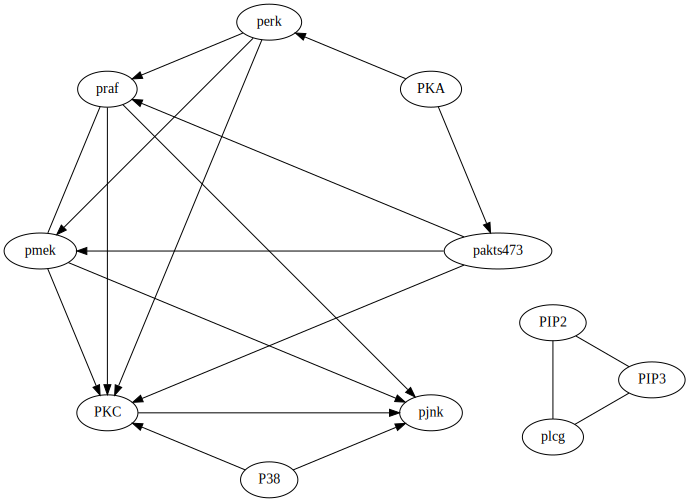

In [26]:
data_exp1_6_drop = data_exp1_6.drop(columns='experiment')
tester1_6 = IndependenceTester(data_exp1_6_drop, ParCorr(), alpha=0.3)

G = PC_algorithm(11, tester1_6)
graph_to_graphviz(G, list(data_exp1_6_drop.columns))

### References
* J. M. Mooij, S. Magliacane, and T. Claassen, "Joint Causal Inference from Multiple Contexts," [arXiv:1611.10351v4](https://arxiv.org/abs/1611.10351), 2019.
* J. Runge, "Conditional Independence Testing Based on a Nearest-Neighbor Estimator of Conditional Mutual Information" In Proceedings of the 21st International Conference on Artificial Intelligence and Statistics, http://proceedings.mlr.press/v84/runge18a.html, 2018.
* K. Sachs, O. Perez, D. Pe’er, D. A. Lauffenburger, and G. P. Nolan, "Causal protein-signaling networks derived from multiparameter single-cell data," Science, vol. 308, no. 5721, pp. 523–529, 2005.